In [1]:
import os
import pandas as pd
import torch
from datasets import Dataset
from PIL import Image
from torchvision import transforms
from transformers import CLIPTokenizer
from diffusers import StableDiffusionPipeline, DDPMScheduler, UNet2DConditionModel, AutoencoderKL
from peft import LoraConfig
from accelerate import Accelerator
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

In [2]:
# Configuration
image_dir = "C:/Users/zhang/Desktop/indiana dataset/images/images_normalized/"  # change this
csv_path = "C:/Users/zhang/Desktop/indiana dataset/image_text_pairs.csv"
pretrained_model = "sd-legacy/stable-diffusion-v1-5"
output_dir = "./sd-lora-output"
resolution = 256
batch_size = 4
epochs = 20
lr = 5e-5
rank = 8

In [3]:
# === Load CSV into HF dataset ===
df = pd.read_csv(csv_path)
df["image"] = df["filename"].apply(lambda x: os.path.join(image_dir, x))


In [4]:
# Split the dataframe
train_df, test_df = train_test_split(df[["image", "impression"]], test_size=0.2, random_state=42)

In [5]:
# Create Hugging Face Datasets
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df.reset_index(drop=True))
})

In [6]:
from datasets import load_from_disk
import os

# === Constants ===
preprocessed_path = "./preprocessed_dataset"  # path to save/load preprocessed dataset

# === Preprocess Only If Not Already Saved ===
if os.path.exists(preprocessed_path):
    print("🔁 Loading preprocessed dataset from disk...")
    dataset = load_from_disk(preprocessed_path)
else:
    print("⚙️  Preprocessing dataset...")
    transform = transforms.Compose([
        transforms.Resize(resolution),
        transforms.CenterCrop(resolution),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

    def preprocess(example):
        image = Image.open(example["image"]).convert("RGB")
        pixel_tensor = transform(image)  # transform returns a tensor

        tokens = tokenizer(
            example["impression"],
            max_length=77,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )

        return {
            "pixel_values": pixel_tensor,  # tensor, not list
            "input_ids": tokens.input_ids.squeeze(0),  # tensor
        }

    dataset = dataset.map(preprocess)

    print("💾 Saving preprocessed dataset to disk...")
    dataset.save_to_disk(preprocessed_path)



🔁 Loading preprocessed dataset from disk...


In [7]:
# === Collate Function ===
def collate_fn(batch):
    pixel_values = torch.stack([
        torch.tensor(x["pixel_values"]) if not isinstance(x["pixel_values"], torch.Tensor) else x["pixel_values"]
        for x in batch
    ])
    input_ids = torch.stack([
        torch.tensor(x["input_ids"]) if not isinstance(x["input_ids"], torch.Tensor) else x["input_ids"]
        for x in batch
    ])
    return {"pixel_values": pixel_values, "input_ids": input_ids}

In [8]:
# === Dataloaders ===
batch_size = 4  # Modify as needed
train_dataloader = DataLoader(dataset["train"], batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(dataset["test"], batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [9]:
# === Load Models ===
pipe = StableDiffusionPipeline.from_pretrained(pretrained_model, torch_dtype=torch.float16).to("cuda")
unet = pipe.unet
vae = pipe.vae
text_encoder = pipe.text_encoder

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [10]:
# Freeze everything but LoRA
unet.requires_grad_(False)
text_encoder.requires_grad_(False)
vae.requires_grad_(False)

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [11]:
# LoRA for UNet
lora_config = LoraConfig(
    r=rank,
    lora_alpha=rank,
    init_lora_weights="gaussian",
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],
)
unet.add_adapter(lora_config)

# === Force LoRA parameters to float32 (required for AMP unscale to work)
for name, param in unet.named_parameters():
    if param.requires_grad:
        param.data = param.data.to(torch.float32)  # safer: use .to()
        if param._grad is not None:
            param._grad = param._grad.to(torch.float32)

# === Collect LoRA parameters
lora_params = [p for p in unet.parameters() if p.requires_grad]


lora_params = list(filter(lambda p: p.requires_grad, unet.parameters()))


In [12]:
# Optimizer
optimizer = torch.optim.AdamW(lora_params, lr=lr)
scheduler = DDPMScheduler.from_pretrained(pretrained_model, subfolder="scheduler")



In [13]:
# Accelerator
accelerator = Accelerator(mixed_precision="fp16")    # FIXED: Enable AMP for float16 model
unet, optimizer, train_dataloader, test_dataloader = accelerator.prepare(
    unet, optimizer, train_dataloader, test_dataloader
)

In [14]:
# === Tracking containers ===
train_losses = []

In [15]:
# === Training Loop ===
unet.train()
for epoch in range(epochs):
    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch}")):
        with accelerator.accumulate(unet):
            # FIXED: Use float16 to match model weights
            pixel_values = batch["pixel_values"].to(accelerator.device, dtype=torch.float16)
            input_ids = batch["input_ids"].to(accelerator.device)

            # === Encode and Sample Latents ===
            with torch.no_grad():  # No need for grads in VAE forward
                latents = vae.encode(pixel_values).latent_dist.sample()
                latents = latents * vae.config.scaling_factor

            noise = torch.randn_like(latents)
            timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (latents.shape[0],), device=latents.device)
            noisy_latents = scheduler.add_noise(latents, noise, timesteps)
            encoder_hidden_states = text_encoder(input_ids)[0]

            model_pred = unet(noisy_latents, timesteps, encoder_hidden_states)[0]
            loss = F.mse_loss(model_pred, noise.to(dtype=model_pred.dtype), reduction="mean")

            
            accelerator.backward(loss)

            optimizer.step()
            

            optimizer.zero_grad()

        if step % 10 == 0:
            train_losses.append(loss.item())
            print(f"Epoch {epoch} Step {step} Loss: {loss.item():.4f}")

Epoch 0:   0%|          | 1/1456 [00:02<1:12:41,  3.00s/it]

Epoch 0 Step 0 Loss: 0.0318


Epoch 0:   1%|          | 11/1456 [00:10<17:37,  1.37it/s] 

Epoch 0 Step 10 Loss: 0.2405


Epoch 0:   1%|▏         | 21/1456 [00:17<17:08,  1.40it/s]

Epoch 0 Step 20 Loss: 0.1636


Epoch 0:   2%|▏         | 31/1456 [00:24<16:18,  1.46it/s]

Epoch 0 Step 30 Loss: 0.0621


Epoch 0:   3%|▎         | 41/1456 [00:31<16:48,  1.40it/s]

Epoch 0 Step 40 Loss: 0.1728


Epoch 0:   4%|▎         | 51/1456 [00:38<16:29,  1.42it/s]

Epoch 0 Step 50 Loss: 0.0263


Epoch 0:   4%|▍         | 61/1456 [00:45<15:56,  1.46it/s]

Epoch 0 Step 60 Loss: 0.1966


Epoch 0:   5%|▍         | 71/1456 [00:52<16:26,  1.40it/s]

Epoch 0 Step 70 Loss: 0.1516


Epoch 0:   6%|▌         | 81/1456 [00:59<16:52,  1.36it/s]

Epoch 0 Step 80 Loss: 0.0150


Epoch 0:   6%|▋         | 91/1456 [01:06<16:54,  1.35it/s]

Epoch 0 Step 90 Loss: 0.1733


Epoch 0:   7%|▋         | 101/1456 [01:14<15:25,  1.46it/s]

Epoch 0 Step 100 Loss: 0.1338


Epoch 0:   8%|▊         | 111/1456 [01:21<17:11,  1.30it/s]

Epoch 0 Step 110 Loss: 0.1573


Epoch 0:   8%|▊         | 121/1456 [01:28<15:15,  1.46it/s]

Epoch 0 Step 120 Loss: 0.0481


Epoch 0:   9%|▉         | 131/1456 [01:36<16:23,  1.35it/s]

Epoch 0 Step 130 Loss: 0.2107


Epoch 0:  10%|▉         | 141/1456 [01:43<15:32,  1.41it/s]

Epoch 0 Step 140 Loss: 0.1441


Epoch 0:  10%|█         | 151/1456 [01:50<14:59,  1.45it/s]

Epoch 0 Step 150 Loss: 0.1843


Epoch 0:  11%|█         | 161/1456 [01:57<14:55,  1.45it/s]

Epoch 0 Step 160 Loss: 0.0576


Epoch 0:  12%|█▏        | 171/1456 [02:04<15:55,  1.35it/s]

Epoch 0 Step 170 Loss: 0.1514


Epoch 0:  12%|█▏        | 181/1456 [02:11<14:17,  1.49it/s]

Epoch 0 Step 180 Loss: 0.2347


Epoch 0:  13%|█▎        | 191/1456 [02:18<14:03,  1.50it/s]

Epoch 0 Step 190 Loss: 0.1517


Epoch 0:  14%|█▍        | 201/1456 [02:25<14:25,  1.45it/s]

Epoch 0 Step 200 Loss: 0.0573


Epoch 0:  14%|█▍        | 211/1456 [02:32<14:16,  1.45it/s]

Epoch 0 Step 210 Loss: 0.0994


Epoch 0:  15%|█▌        | 221/1456 [02:39<13:37,  1.51it/s]

Epoch 0 Step 220 Loss: 0.1231


Epoch 0:  16%|█▌        | 231/1456 [02:46<14:55,  1.37it/s]

Epoch 0 Step 230 Loss: 0.1441


Epoch 0:  17%|█▋        | 241/1456 [02:53<14:56,  1.36it/s]

Epoch 0 Step 240 Loss: 0.1572


Epoch 0:  17%|█▋        | 251/1456 [03:00<14:17,  1.41it/s]

Epoch 0 Step 250 Loss: 0.1442


Epoch 0:  18%|█▊        | 261/1456 [03:07<14:45,  1.35it/s]

Epoch 0 Step 260 Loss: 0.0812


Epoch 0:  19%|█▊        | 271/1456 [03:14<14:17,  1.38it/s]

Epoch 0 Step 270 Loss: 0.1850


Epoch 0:  19%|█▉        | 281/1456 [03:21<13:30,  1.45it/s]

Epoch 0 Step 280 Loss: 0.1055


Epoch 0:  20%|█▉        | 291/1456 [03:29<14:14,  1.36it/s]

Epoch 0 Step 290 Loss: 0.1054


Epoch 0:  21%|██        | 301/1456 [03:36<13:44,  1.40it/s]

Epoch 0 Step 300 Loss: 0.2798


Epoch 0:  21%|██▏       | 311/1456 [03:43<13:43,  1.39it/s]

Epoch 0 Step 310 Loss: 0.0780


Epoch 0:  22%|██▏       | 321/1456 [03:50<13:20,  1.42it/s]

Epoch 0 Step 320 Loss: 0.1130


Epoch 0:  23%|██▎       | 331/1456 [03:57<12:57,  1.45it/s]

Epoch 0 Step 330 Loss: 0.1239


Epoch 0:  23%|██▎       | 341/1456 [04:04<13:19,  1.40it/s]

Epoch 0 Step 340 Loss: 0.0527


Epoch 0:  24%|██▍       | 351/1456 [04:11<13:03,  1.41it/s]

Epoch 0 Step 350 Loss: 0.2081


Epoch 0:  25%|██▍       | 361/1456 [04:18<12:39,  1.44it/s]

Epoch 0 Step 360 Loss: 0.0222


Epoch 0:  25%|██▌       | 371/1456 [04:25<12:33,  1.44it/s]

Epoch 0 Step 370 Loss: 0.0988


Epoch 0:  26%|██▌       | 381/1456 [04:32<12:42,  1.41it/s]

Epoch 0 Step 380 Loss: 0.2309


Epoch 0:  27%|██▋       | 391/1456 [04:40<12:43,  1.40it/s]

Epoch 0 Step 390 Loss: 0.0076


Epoch 0:  28%|██▊       | 401/1456 [04:47<12:49,  1.37it/s]

Epoch 0 Step 400 Loss: 0.1680


Epoch 0:  28%|██▊       | 411/1456 [04:54<12:42,  1.37it/s]

Epoch 0 Step 410 Loss: 0.1588


Epoch 0:  29%|██▉       | 421/1456 [05:01<12:22,  1.39it/s]

Epoch 0 Step 420 Loss: 0.0620


Epoch 0:  30%|██▉       | 431/1456 [05:09<12:33,  1.36it/s]

Epoch 0 Step 430 Loss: 0.2032


Epoch 0:  30%|███       | 441/1456 [05:16<12:45,  1.33it/s]

Epoch 0 Step 440 Loss: 0.2878


Epoch 0:  31%|███       | 451/1456 [05:24<12:51,  1.30it/s]

Epoch 0 Step 450 Loss: 0.1631


Epoch 0:  32%|███▏      | 461/1456 [05:31<12:40,  1.31it/s]

Epoch 0 Step 460 Loss: 0.0657


Epoch 0:  32%|███▏      | 471/1456 [05:39<12:20,  1.33it/s]

Epoch 0 Step 470 Loss: 0.0991


Epoch 0:  33%|███▎      | 481/1456 [05:46<11:33,  1.41it/s]

Epoch 0 Step 480 Loss: 0.1541


Epoch 0:  34%|███▎      | 491/1456 [05:53<11:53,  1.35it/s]

Epoch 0 Step 490 Loss: 0.1484


Epoch 0:  34%|███▍      | 501/1456 [06:00<10:58,  1.45it/s]

Epoch 0 Step 500 Loss: 0.2823


Epoch 0:  35%|███▌      | 511/1456 [06:08<11:33,  1.36it/s]

Epoch 0 Step 510 Loss: 0.1829


Epoch 0:  36%|███▌      | 521/1456 [06:15<11:11,  1.39it/s]

Epoch 0 Step 520 Loss: 0.2154


Epoch 0:  36%|███▋      | 531/1456 [06:22<11:26,  1.35it/s]

Epoch 0 Step 530 Loss: 0.1353


Epoch 0:  37%|███▋      | 541/1456 [06:29<10:53,  1.40it/s]

Epoch 0 Step 540 Loss: 0.3193


Epoch 0:  38%|███▊      | 551/1456 [06:37<11:08,  1.35it/s]

Epoch 0 Step 550 Loss: 0.0278


Epoch 0:  39%|███▊      | 561/1456 [06:44<10:44,  1.39it/s]

Epoch 0 Step 560 Loss: 0.2717


Epoch 0:  39%|███▉      | 571/1456 [06:51<10:31,  1.40it/s]

Epoch 0 Step 570 Loss: 0.0829


Epoch 0:  40%|███▉      | 581/1456 [06:58<10:24,  1.40it/s]

Epoch 0 Step 580 Loss: 0.0574


Epoch 0:  41%|████      | 591/1456 [07:05<10:29,  1.38it/s]

Epoch 0 Step 590 Loss: 0.1467


Epoch 0:  41%|████▏     | 601/1456 [07:13<10:33,  1.35it/s]

Epoch 0 Step 600 Loss: 0.0756


Epoch 0:  42%|████▏     | 611/1456 [07:20<09:50,  1.43it/s]

Epoch 0 Step 610 Loss: 0.0484


Epoch 0:  43%|████▎     | 621/1456 [07:28<10:46,  1.29it/s]

Epoch 0 Step 620 Loss: 0.1287


Epoch 0:  43%|████▎     | 631/1456 [07:36<09:43,  1.41it/s]

Epoch 0 Step 630 Loss: 0.1327


Epoch 0:  44%|████▍     | 641/1456 [07:43<09:26,  1.44it/s]

Epoch 0 Step 640 Loss: 0.0413


Epoch 0:  45%|████▍     | 651/1456 [07:50<09:34,  1.40it/s]

Epoch 0 Step 650 Loss: 0.0286


Epoch 0:  45%|████▌     | 661/1456 [07:57<09:31,  1.39it/s]

Epoch 0 Step 660 Loss: 0.0362


Epoch 0:  46%|████▌     | 671/1456 [08:04<09:18,  1.40it/s]

Epoch 0 Step 670 Loss: 0.1048


Epoch 0:  47%|████▋     | 681/1456 [08:11<09:17,  1.39it/s]

Epoch 0 Step 680 Loss: 0.0361


Epoch 0:  47%|████▋     | 691/1456 [08:18<09:05,  1.40it/s]

Epoch 0 Step 690 Loss: 0.0833


Epoch 0:  48%|████▊     | 701/1456 [08:25<08:42,  1.44it/s]

Epoch 0 Step 700 Loss: 0.1591


Epoch 0:  49%|████▉     | 711/1456 [08:32<08:57,  1.39it/s]

Epoch 0 Step 710 Loss: 0.1281


Epoch 0:  50%|████▉     | 721/1456 [08:39<08:29,  1.44it/s]

Epoch 0 Step 720 Loss: 0.1581


Epoch 0:  50%|█████     | 731/1456 [08:47<08:47,  1.37it/s]

Epoch 0 Step 730 Loss: 0.2211


Epoch 0:  51%|█████     | 741/1456 [08:54<08:29,  1.40it/s]

Epoch 0 Step 740 Loss: 0.1030


Epoch 0:  52%|█████▏    | 751/1456 [09:01<08:33,  1.37it/s]

Epoch 0 Step 750 Loss: 0.0205


Epoch 0:  52%|█████▏    | 761/1456 [09:09<08:40,  1.34it/s]

Epoch 0 Step 760 Loss: 0.1129


Epoch 0:  53%|█████▎    | 771/1456 [09:16<08:36,  1.33it/s]

Epoch 0 Step 770 Loss: 0.0863


Epoch 0:  54%|█████▎    | 781/1456 [09:24<09:15,  1.22it/s]

Epoch 0 Step 780 Loss: 0.1739


Epoch 0:  54%|█████▍    | 791/1456 [09:31<08:09,  1.36it/s]

Epoch 0 Step 790 Loss: 0.2446


Epoch 0:  55%|█████▌    | 801/1456 [09:38<08:12,  1.33it/s]

Epoch 0 Step 800 Loss: 0.2016


Epoch 0:  56%|█████▌    | 811/1456 [09:45<07:11,  1.49it/s]

Epoch 0 Step 810 Loss: 0.0873


Epoch 0:  56%|█████▋    | 821/1456 [09:52<07:20,  1.44it/s]

Epoch 0 Step 820 Loss: 0.1061


Epoch 0:  57%|█████▋    | 831/1456 [09:59<07:25,  1.40it/s]

Epoch 0 Step 830 Loss: 0.3139


Epoch 0:  58%|█████▊    | 841/1456 [10:07<07:21,  1.39it/s]

Epoch 0 Step 840 Loss: 0.2688


Epoch 0:  58%|█████▊    | 851/1456 [10:14<07:33,  1.33it/s]

Epoch 0 Step 850 Loss: 0.1549


Epoch 0:  59%|█████▉    | 861/1456 [10:21<06:57,  1.43it/s]

Epoch 0 Step 860 Loss: 0.0338


Epoch 0:  60%|█████▉    | 871/1456 [10:28<06:43,  1.45it/s]

Epoch 0 Step 870 Loss: 0.0260


Epoch 0:  61%|██████    | 881/1456 [10:35<06:41,  1.43it/s]

Epoch 0 Step 880 Loss: 0.1205


Epoch 0:  61%|██████    | 891/1456 [10:42<06:51,  1.37it/s]

Epoch 0 Step 890 Loss: 0.0627


Epoch 0:  62%|██████▏   | 901/1456 [10:49<06:24,  1.44it/s]

Epoch 0 Step 900 Loss: 0.1554


Epoch 0:  63%|██████▎   | 911/1456 [10:56<06:30,  1.39it/s]

Epoch 0 Step 910 Loss: 0.1323


Epoch 0:  63%|██████▎   | 921/1456 [11:04<06:23,  1.39it/s]

Epoch 0 Step 920 Loss: 0.2063


Epoch 0:  64%|██████▍   | 931/1456 [11:11<06:59,  1.25it/s]

Epoch 0 Step 930 Loss: 0.0619


Epoch 0:  65%|██████▍   | 941/1456 [11:19<06:38,  1.29it/s]

Epoch 0 Step 940 Loss: 0.0460


Epoch 0:  65%|██████▌   | 951/1456 [11:27<06:29,  1.30it/s]

Epoch 0 Step 950 Loss: 0.0791


Epoch 0:  66%|██████▌   | 961/1456 [11:34<05:59,  1.38it/s]

Epoch 0 Step 960 Loss: 0.1883


Epoch 0:  67%|██████▋   | 971/1456 [11:41<05:32,  1.46it/s]

Epoch 0 Step 970 Loss: 0.0443


Epoch 0:  67%|██████▋   | 981/1456 [11:48<05:25,  1.46it/s]

Epoch 0 Step 980 Loss: 0.2008


Epoch 0:  68%|██████▊   | 991/1456 [11:54<05:22,  1.44it/s]

Epoch 0 Step 990 Loss: 0.0716


Epoch 0:  69%|██████▉   | 1001/1456 [12:02<05:34,  1.36it/s]

Epoch 0 Step 1000 Loss: 0.1946


Epoch 0:  69%|██████▉   | 1011/1456 [12:09<05:08,  1.44it/s]

Epoch 0 Step 1010 Loss: 0.0990


Epoch 0:  70%|███████   | 1021/1456 [12:16<05:06,  1.42it/s]

Epoch 0 Step 1020 Loss: 0.0223


Epoch 0:  71%|███████   | 1031/1456 [12:23<04:51,  1.46it/s]

Epoch 0 Step 1030 Loss: 0.1072


Epoch 0:  71%|███████▏  | 1041/1456 [12:30<04:51,  1.42it/s]

Epoch 0 Step 1040 Loss: 0.1765


Epoch 0:  72%|███████▏  | 1051/1456 [12:37<04:41,  1.44it/s]

Epoch 0 Step 1050 Loss: 0.0523


Epoch 0:  73%|███████▎  | 1061/1456 [12:44<04:33,  1.44it/s]

Epoch 0 Step 1060 Loss: 0.0662


Epoch 0:  74%|███████▎  | 1071/1456 [12:51<04:34,  1.40it/s]

Epoch 0 Step 1070 Loss: 0.0888


Epoch 0:  74%|███████▍  | 1081/1456 [12:58<04:20,  1.44it/s]

Epoch 0 Step 1080 Loss: 0.1183


Epoch 0:  75%|███████▍  | 1091/1456 [13:06<04:31,  1.35it/s]

Epoch 0 Step 1090 Loss: 0.0501


Epoch 0:  76%|███████▌  | 1101/1456 [13:13<04:09,  1.42it/s]

Epoch 0 Step 1100 Loss: 0.1289


Epoch 0:  76%|███████▋  | 1111/1456 [13:21<04:16,  1.35it/s]

Epoch 0 Step 1110 Loss: 0.0698


Epoch 0:  77%|███████▋  | 1121/1456 [13:28<03:58,  1.41it/s]

Epoch 0 Step 1120 Loss: 0.1983


Epoch 0:  78%|███████▊  | 1131/1456 [13:35<03:56,  1.37it/s]

Epoch 0 Step 1130 Loss: 0.0146


Epoch 0:  78%|███████▊  | 1141/1456 [13:43<03:51,  1.36it/s]

Epoch 0 Step 1140 Loss: 0.1507


Epoch 0:  79%|███████▉  | 1151/1456 [13:50<03:31,  1.44it/s]

Epoch 0 Step 1150 Loss: 0.2691


Epoch 0:  80%|███████▉  | 1161/1456 [13:57<03:36,  1.36it/s]

Epoch 0 Step 1160 Loss: 0.2181


Epoch 0:  80%|████████  | 1171/1456 [14:04<03:22,  1.41it/s]

Epoch 0 Step 1170 Loss: 0.1497


Epoch 0:  81%|████████  | 1181/1456 [14:12<03:26,  1.33it/s]

Epoch 0 Step 1180 Loss: 0.0971


Epoch 0:  82%|████████▏ | 1191/1456 [14:19<03:12,  1.37it/s]

Epoch 0 Step 1190 Loss: 0.1043


Epoch 0:  82%|████████▏ | 1201/1456 [14:26<03:09,  1.34it/s]

Epoch 0 Step 1200 Loss: 0.0422


Epoch 0:  83%|████████▎ | 1211/1456 [14:33<02:52,  1.42it/s]

Epoch 0 Step 1210 Loss: 0.1361


Epoch 0:  84%|████████▍ | 1221/1456 [14:41<02:53,  1.36it/s]

Epoch 0 Step 1220 Loss: 0.3230


Epoch 0:  85%|████████▍ | 1231/1456 [14:48<02:37,  1.43it/s]

Epoch 0 Step 1230 Loss: 0.0791


Epoch 0:  85%|████████▌ | 1241/1456 [14:55<02:37,  1.37it/s]

Epoch 0 Step 1240 Loss: 0.1249


Epoch 0:  86%|████████▌ | 1251/1456 [15:03<02:30,  1.36it/s]

Epoch 0 Step 1250 Loss: 0.1107


Epoch 0:  87%|████████▋ | 1261/1456 [15:10<02:25,  1.34it/s]

Epoch 0 Step 1260 Loss: 0.0575


Epoch 0:  87%|████████▋ | 1271/1456 [15:18<02:20,  1.32it/s]

Epoch 0 Step 1270 Loss: 0.0708


Epoch 0:  88%|████████▊ | 1281/1456 [15:25<02:13,  1.31it/s]

Epoch 0 Step 1280 Loss: 0.3029


Epoch 0:  89%|████████▊ | 1291/1456 [15:33<02:07,  1.30it/s]

Epoch 0 Step 1290 Loss: 0.1172


Epoch 0:  89%|████████▉ | 1301/1456 [15:40<01:51,  1.39it/s]

Epoch 0 Step 1300 Loss: 0.3050


Epoch 0:  90%|█████████ | 1311/1456 [15:47<01:47,  1.34it/s]

Epoch 0 Step 1310 Loss: 0.0435


Epoch 0:  91%|█████████ | 1321/1456 [15:54<01:36,  1.40it/s]

Epoch 0 Step 1320 Loss: 0.0479


Epoch 0:  91%|█████████▏| 1331/1456 [16:02<01:33,  1.34it/s]

Epoch 0 Step 1330 Loss: 0.2314


Epoch 0:  92%|█████████▏| 1341/1456 [16:09<01:18,  1.46it/s]

Epoch 0 Step 1340 Loss: 0.0297


Epoch 0:  93%|█████████▎| 1351/1456 [16:16<01:15,  1.40it/s]

Epoch 0 Step 1350 Loss: 0.1135


Epoch 0:  93%|█████████▎| 1361/1456 [16:23<01:06,  1.43it/s]

Epoch 0 Step 1360 Loss: 0.1134


Epoch 0:  94%|█████████▍| 1371/1456 [16:30<01:01,  1.39it/s]

Epoch 0 Step 1370 Loss: 0.0775


Epoch 0:  95%|█████████▍| 1381/1456 [16:38<00:54,  1.38it/s]

Epoch 0 Step 1380 Loss: 0.1194


Epoch 0:  96%|█████████▌| 1391/1456 [16:45<00:47,  1.38it/s]

Epoch 0 Step 1390 Loss: 0.2110


Epoch 0:  96%|█████████▌| 1401/1456 [16:52<00:39,  1.38it/s]

Epoch 0 Step 1400 Loss: 0.1585


Epoch 0:  97%|█████████▋| 1411/1456 [16:59<00:32,  1.38it/s]

Epoch 0 Step 1410 Loss: 0.3054


Epoch 0:  98%|█████████▊| 1421/1456 [17:06<00:25,  1.35it/s]

Epoch 0 Step 1420 Loss: 0.3020


Epoch 0:  98%|█████████▊| 1431/1456 [17:14<00:17,  1.41it/s]

Epoch 0 Step 1430 Loss: 0.1488


Epoch 0:  99%|█████████▉| 1441/1456 [17:21<00:11,  1.35it/s]

Epoch 0 Step 1440 Loss: 0.0326


Epoch 0: 100%|█████████▉| 1451/1456 [17:29<00:03,  1.41it/s]

Epoch 0 Step 1450 Loss: 0.1449


Epoch 1:   0%|          | 1/1456 [00:01<25:53,  1.07s/it]

Epoch 1 Step 0 Loss: 0.0950


Epoch 1:   1%|          | 11/1456 [00:08<17:25,  1.38it/s]

Epoch 1 Step 10 Loss: 0.2128


Epoch 1:   1%|▏         | 21/1456 [00:15<16:28,  1.45it/s]

Epoch 1 Step 20 Loss: 0.1945


Epoch 1:   2%|▏         | 31/1456 [00:22<15:56,  1.49it/s]

Epoch 1 Step 30 Loss: 0.0780


Epoch 1:   3%|▎         | 41/1456 [00:28<15:42,  1.50it/s]

Epoch 1 Step 40 Loss: 0.0873


Epoch 1:   4%|▎         | 51/1456 [00:36<16:42,  1.40it/s]

Epoch 1 Step 50 Loss: 0.1796


Epoch 1:   4%|▍         | 61/1456 [00:42<15:34,  1.49it/s]

Epoch 1 Step 60 Loss: 0.0780


Epoch 1:   5%|▍         | 71/1456 [00:49<16:29,  1.40it/s]

Epoch 1 Step 70 Loss: 0.0682


Epoch 1:   6%|▌         | 81/1456 [00:57<16:14,  1.41it/s]

Epoch 1 Step 80 Loss: 0.1602


Epoch 1:   6%|▋         | 91/1456 [01:03<15:40,  1.45it/s]

Epoch 1 Step 90 Loss: 0.1175


Epoch 1:   7%|▋         | 101/1456 [01:11<15:42,  1.44it/s]

Epoch 1 Step 100 Loss: 0.2392


Epoch 1:   8%|▊         | 111/1456 [01:17<15:20,  1.46it/s]

Epoch 1 Step 110 Loss: 0.1132


Epoch 1:   8%|▊         | 121/1456 [01:24<15:45,  1.41it/s]

Epoch 1 Step 120 Loss: 0.2569


Epoch 1:   9%|▉         | 131/1456 [01:31<14:34,  1.51it/s]

Epoch 1 Step 130 Loss: 0.3419


Epoch 1:  10%|▉         | 141/1456 [01:38<15:39,  1.40it/s]

Epoch 1 Step 140 Loss: 0.1362


Epoch 1:  10%|█         | 151/1456 [01:46<15:51,  1.37it/s]

Epoch 1 Step 150 Loss: 0.2218


Epoch 1:  11%|█         | 161/1456 [01:53<15:22,  1.40it/s]

Epoch 1 Step 160 Loss: 0.1679


Epoch 1:  12%|█▏        | 171/1456 [02:00<15:16,  1.40it/s]

Epoch 1 Step 170 Loss: 0.0724


Epoch 1:  12%|█▏        | 181/1456 [02:07<14:50,  1.43it/s]

Epoch 1 Step 180 Loss: 0.1827


Epoch 1:  13%|█▎        | 191/1456 [02:14<14:41,  1.44it/s]

Epoch 1 Step 190 Loss: 0.1550


Epoch 1:  14%|█▍        | 201/1456 [02:20<13:53,  1.51it/s]

Epoch 1 Step 200 Loss: 0.2969


Epoch 1:  14%|█▍        | 211/1456 [02:27<14:07,  1.47it/s]

Epoch 1 Step 210 Loss: 0.1647


Epoch 1:  15%|█▌        | 221/1456 [02:34<14:13,  1.45it/s]

Epoch 1 Step 220 Loss: 0.0998


Epoch 1:  16%|█▌        | 231/1456 [02:41<13:56,  1.46it/s]

Epoch 1 Step 230 Loss: 0.3954


Epoch 1:  17%|█▋        | 241/1456 [02:48<14:04,  1.44it/s]

Epoch 1 Step 240 Loss: 0.2024


Epoch 1:  17%|█▋        | 251/1456 [02:54<13:43,  1.46it/s]

Epoch 1 Step 250 Loss: 0.0595


Epoch 1:  18%|█▊        | 261/1456 [03:01<14:13,  1.40it/s]

Epoch 1 Step 260 Loss: 0.1582


Epoch 1:  19%|█▊        | 271/1456 [03:08<13:17,  1.49it/s]

Epoch 1 Step 270 Loss: 0.2023


Epoch 1:  19%|█▉        | 281/1456 [03:15<14:06,  1.39it/s]

Epoch 1 Step 280 Loss: 0.1620


Epoch 1:  20%|█▉        | 291/1456 [03:23<13:52,  1.40it/s]

Epoch 1 Step 290 Loss: 0.2062


Epoch 1:  21%|██        | 301/1456 [03:30<13:27,  1.43it/s]

Epoch 1 Step 300 Loss: 0.1878


Epoch 1:  21%|██▏       | 311/1456 [03:37<13:44,  1.39it/s]

Epoch 1 Step 310 Loss: 0.0403


Epoch 1:  22%|██▏       | 321/1456 [03:44<14:21,  1.32it/s]

Epoch 1 Step 320 Loss: 0.0771


Epoch 1:  23%|██▎       | 331/1456 [03:51<13:22,  1.40it/s]

Epoch 1 Step 330 Loss: 0.0419


Epoch 1:  23%|██▎       | 341/1456 [03:58<13:19,  1.39it/s]

Epoch 1 Step 340 Loss: 0.0596


Epoch 1:  24%|██▍       | 351/1456 [04:06<13:20,  1.38it/s]

Epoch 1 Step 350 Loss: 0.1118


Epoch 1:  25%|██▍       | 361/1456 [04:12<12:13,  1.49it/s]

Epoch 1 Step 360 Loss: 0.1164


Epoch 1:  25%|██▌       | 371/1456 [04:20<12:55,  1.40it/s]

Epoch 1 Step 370 Loss: 0.1356


Epoch 1:  26%|██▌       | 381/1456 [04:26<11:37,  1.54it/s]

Epoch 1 Step 380 Loss: 0.0270


Epoch 1:  27%|██▋       | 391/1456 [04:34<12:40,  1.40it/s]

Epoch 1 Step 390 Loss: 0.1834


Epoch 1:  28%|██▊       | 401/1456 [04:41<12:36,  1.40it/s]

Epoch 1 Step 400 Loss: 0.0875


Epoch 1:  28%|██▊       | 411/1456 [04:48<12:28,  1.40it/s]

Epoch 1 Step 410 Loss: 0.0329


Epoch 1:  29%|██▉       | 421/1456 [04:55<12:06,  1.43it/s]

Epoch 1 Step 420 Loss: 0.1012


Epoch 1:  30%|██▉       | 431/1456 [05:02<11:30,  1.49it/s]

Epoch 1 Step 430 Loss: 0.1548


Epoch 1:  30%|███       | 441/1456 [05:09<11:57,  1.42it/s]

Epoch 1 Step 440 Loss: 0.1035


Epoch 1:  31%|███       | 451/1456 [05:16<11:02,  1.52it/s]

Epoch 1 Step 450 Loss: 0.1726


Epoch 1:  32%|███▏      | 461/1456 [05:23<11:41,  1.42it/s]

Epoch 1 Step 460 Loss: 0.0989


Epoch 1:  32%|███▏      | 471/1456 [05:30<11:44,  1.40it/s]

Epoch 1 Step 470 Loss: 0.1757


Epoch 1:  33%|███▎      | 481/1456 [05:37<11:29,  1.41it/s]

Epoch 1 Step 480 Loss: 0.2495


Epoch 1:  34%|███▎      | 491/1456 [05:44<11:51,  1.36it/s]

Epoch 1 Step 490 Loss: 0.1139


Epoch 1:  34%|███▍      | 501/1456 [05:51<10:56,  1.45it/s]

Epoch 1 Step 500 Loss: 0.0930


Epoch 1:  35%|███▌      | 511/1456 [05:58<11:32,  1.36it/s]

Epoch 1 Step 510 Loss: 0.0586


Epoch 1:  36%|███▌      | 521/1456 [06:05<10:38,  1.46it/s]

Epoch 1 Step 520 Loss: 0.1771


Epoch 1:  36%|███▋      | 531/1456 [06:12<10:55,  1.41it/s]

Epoch 1 Step 530 Loss: 0.1380


Epoch 1:  37%|███▋      | 541/1456 [06:19<10:09,  1.50it/s]

Epoch 1 Step 540 Loss: 0.0268


Epoch 1:  38%|███▊      | 551/1456 [06:26<10:25,  1.45it/s]

Epoch 1 Step 550 Loss: 0.3806


Epoch 1:  39%|███▊      | 561/1456 [06:33<10:35,  1.41it/s]

Epoch 1 Step 560 Loss: 0.2459


Epoch 1:  39%|███▉      | 571/1456 [06:39<10:13,  1.44it/s]

Epoch 1 Step 570 Loss: 0.1423


Epoch 1:  40%|███▉      | 581/1456 [06:46<10:04,  1.45it/s]

Epoch 1 Step 580 Loss: 0.1180


Epoch 1:  41%|████      | 591/1456 [06:53<09:43,  1.48it/s]

Epoch 1 Step 590 Loss: 0.1458


Epoch 1:  41%|████▏     | 601/1456 [07:00<09:46,  1.46it/s]

Epoch 1 Step 600 Loss: 0.0492


Epoch 1:  42%|████▏     | 611/1456 [07:07<09:32,  1.48it/s]

Epoch 1 Step 610 Loss: 0.2082


Epoch 1:  43%|████▎     | 621/1456 [07:15<10:35,  1.31it/s]

Epoch 1 Step 620 Loss: 0.0729


Epoch 1:  43%|████▎     | 631/1456 [07:22<09:37,  1.43it/s]

Epoch 1 Step 630 Loss: 0.1780


Epoch 1:  44%|████▍     | 641/1456 [07:29<09:49,  1.38it/s]

Epoch 1 Step 640 Loss: 0.1790


Epoch 1:  45%|████▍     | 651/1456 [07:36<09:51,  1.36it/s]

Epoch 1 Step 650 Loss: 0.1864


Epoch 1:  45%|████▌     | 661/1456 [07:43<09:22,  1.41it/s]

Epoch 1 Step 660 Loss: 0.1816


Epoch 1:  46%|████▌     | 671/1456 [07:50<09:36,  1.36it/s]

Epoch 1 Step 670 Loss: 0.1538


Epoch 1:  47%|████▋     | 681/1456 [07:57<09:08,  1.41it/s]

Epoch 1 Step 680 Loss: 0.0823


Epoch 1:  47%|████▋     | 691/1456 [08:05<09:32,  1.34it/s]

Epoch 1 Step 690 Loss: 0.0409


Epoch 1:  48%|████▊     | 701/1456 [08:12<08:18,  1.51it/s]

Epoch 1 Step 700 Loss: 0.0192


Epoch 1:  49%|████▉     | 711/1456 [08:19<08:58,  1.38it/s]

Epoch 1 Step 710 Loss: 0.2165


Epoch 1:  50%|████▉     | 721/1456 [08:26<08:35,  1.43it/s]

Epoch 1 Step 720 Loss: 0.0842


Epoch 1:  50%|█████     | 731/1456 [08:33<08:28,  1.42it/s]

Epoch 1 Step 730 Loss: 0.0535


Epoch 1:  51%|█████     | 741/1456 [08:40<08:25,  1.42it/s]

Epoch 1 Step 740 Loss: 0.4066


Epoch 1:  52%|█████▏    | 751/1456 [08:47<07:55,  1.48it/s]

Epoch 1 Step 750 Loss: 0.3840


Epoch 1:  52%|█████▏    | 761/1456 [08:54<08:06,  1.43it/s]

Epoch 1 Step 760 Loss: 0.0710


Epoch 1:  53%|█████▎    | 771/1456 [09:01<07:46,  1.47it/s]

Epoch 1 Step 770 Loss: 0.0750


Epoch 1:  54%|█████▎    | 781/1456 [09:08<07:59,  1.41it/s]

Epoch 1 Step 780 Loss: 0.1828


Epoch 1:  54%|█████▍    | 791/1456 [09:15<07:23,  1.50it/s]

Epoch 1 Step 790 Loss: 0.0798


Epoch 1:  55%|█████▌    | 801/1456 [09:22<07:45,  1.41it/s]

Epoch 1 Step 800 Loss: 0.0535


Epoch 1:  56%|█████▌    | 811/1456 [09:29<07:34,  1.42it/s]

Epoch 1 Step 810 Loss: 0.1122


Epoch 1:  56%|█████▋    | 821/1456 [09:36<07:38,  1.39it/s]

Epoch 1 Step 820 Loss: 0.0485


Epoch 1:  57%|█████▋    | 831/1456 [09:43<07:13,  1.44it/s]

Epoch 1 Step 830 Loss: 0.1933


Epoch 1:  58%|█████▊    | 841/1456 [09:50<07:08,  1.44it/s]

Epoch 1 Step 840 Loss: 0.1933


Epoch 1:  58%|█████▊    | 851/1456 [09:57<07:14,  1.39it/s]

Epoch 1 Step 850 Loss: 0.0529


Epoch 1:  59%|█████▉    | 861/1456 [10:04<06:37,  1.50it/s]

Epoch 1 Step 860 Loss: 0.0582


Epoch 1:  60%|█████▉    | 871/1456 [10:11<06:40,  1.46it/s]

Epoch 1 Step 870 Loss: 0.1220


Epoch 1:  61%|██████    | 881/1456 [10:18<06:41,  1.43it/s]

Epoch 1 Step 880 Loss: 0.1021


Epoch 1:  61%|██████    | 891/1456 [10:24<06:21,  1.48it/s]

Epoch 1 Step 890 Loss: 0.0283


Epoch 1:  62%|██████▏   | 901/1456 [10:31<06:12,  1.49it/s]

Epoch 1 Step 900 Loss: 0.1640


Epoch 1:  63%|██████▎   | 911/1456 [10:38<06:21,  1.43it/s]

Epoch 1 Step 910 Loss: 0.1126


Epoch 1:  63%|██████▎   | 921/1456 [10:45<06:13,  1.43it/s]

Epoch 1 Step 920 Loss: 0.0728


Epoch 1:  64%|██████▍   | 931/1456 [10:52<05:43,  1.53it/s]

Epoch 1 Step 930 Loss: 0.1970


Epoch 1:  65%|██████▍   | 941/1456 [10:59<06:02,  1.42it/s]

Epoch 1 Step 940 Loss: 0.0651


Epoch 1:  65%|██████▌   | 951/1456 [11:06<05:54,  1.42it/s]

Epoch 1 Step 950 Loss: 0.2180


Epoch 1:  66%|██████▌   | 961/1456 [11:13<05:52,  1.41it/s]

Epoch 1 Step 960 Loss: 0.2976


Epoch 1:  67%|██████▋   | 971/1456 [11:20<05:33,  1.45it/s]

Epoch 1 Step 970 Loss: 0.1151


Epoch 1:  67%|██████▋   | 981/1456 [11:27<05:48,  1.36it/s]

Epoch 1 Step 980 Loss: 0.2055


Epoch 1:  68%|██████▊   | 991/1456 [11:35<05:40,  1.37it/s]

Epoch 1 Step 990 Loss: 0.0399


Epoch 1:  69%|██████▉   | 1001/1456 [11:42<05:11,  1.46it/s]

Epoch 1 Step 1000 Loss: 0.1399


Epoch 1:  69%|██████▉   | 1011/1456 [11:49<05:24,  1.37it/s]

Epoch 1 Step 1010 Loss: 0.0107


Epoch 1:  70%|███████   | 1021/1456 [11:56<04:53,  1.48it/s]

Epoch 1 Step 1020 Loss: 0.0277


Epoch 1:  71%|███████   | 1031/1456 [12:03<05:04,  1.39it/s]

Epoch 1 Step 1030 Loss: 0.1515


Epoch 1:  71%|███████▏  | 1041/1456 [12:10<04:45,  1.46it/s]

Epoch 1 Step 1040 Loss: 0.1474


Epoch 1:  72%|███████▏  | 1051/1456 [12:17<04:56,  1.36it/s]

Epoch 1 Step 1050 Loss: 0.1323


Epoch 1:  73%|███████▎  | 1061/1456 [12:25<04:39,  1.41it/s]

Epoch 1 Step 1060 Loss: 0.1943


Epoch 1:  74%|███████▎  | 1071/1456 [12:31<04:29,  1.43it/s]

Epoch 1 Step 1070 Loss: 0.1003


Epoch 1:  74%|███████▍  | 1081/1456 [12:38<04:29,  1.39it/s]

Epoch 1 Step 1080 Loss: 0.1556


Epoch 1:  75%|███████▍  | 1091/1456 [12:45<04:08,  1.47it/s]

Epoch 1 Step 1090 Loss: 0.1175


Epoch 1:  76%|███████▌  | 1101/1456 [12:52<04:13,  1.40it/s]

Epoch 1 Step 1100 Loss: 0.0787


Epoch 1:  76%|███████▋  | 1111/1456 [12:59<03:48,  1.51it/s]

Epoch 1 Step 1110 Loss: 0.2211


Epoch 1:  77%|███████▋  | 1121/1456 [13:06<03:56,  1.41it/s]

Epoch 1 Step 1120 Loss: 0.1972


Epoch 1:  78%|███████▊  | 1131/1456 [13:13<03:53,  1.39it/s]

Epoch 1 Step 1130 Loss: 0.1107


Epoch 1:  78%|███████▊  | 1141/1456 [13:20<03:35,  1.46it/s]

Epoch 1 Step 1140 Loss: 0.0816


Epoch 1:  79%|███████▉  | 1151/1456 [13:27<03:39,  1.39it/s]

Epoch 1 Step 1150 Loss: 0.1597


Epoch 1:  80%|███████▉  | 1161/1456 [13:34<03:26,  1.43it/s]

Epoch 1 Step 1160 Loss: 0.0893


Epoch 1:  80%|████████  | 1171/1456 [13:41<03:29,  1.36it/s]

Epoch 1 Step 1170 Loss: 0.1360


Epoch 1:  81%|████████  | 1181/1456 [13:48<03:05,  1.48it/s]

Epoch 1 Step 1180 Loss: 0.0885


Epoch 1:  82%|████████▏ | 1191/1456 [13:56<03:14,  1.36it/s]

Epoch 1 Step 1190 Loss: 0.0437


Epoch 1:  82%|████████▏ | 1201/1456 [14:03<02:54,  1.46it/s]

Epoch 1 Step 1200 Loss: 0.0823


Epoch 1:  83%|████████▎ | 1211/1456 [14:10<02:50,  1.44it/s]

Epoch 1 Step 1210 Loss: 0.1033


Epoch 1:  84%|████████▍ | 1221/1456 [14:17<02:42,  1.45it/s]

Epoch 1 Step 1220 Loss: 0.2959


Epoch 1:  85%|████████▍ | 1231/1456 [14:23<02:33,  1.46it/s]

Epoch 1 Step 1230 Loss: 0.2223


Epoch 1:  85%|████████▌ | 1241/1456 [14:31<02:30,  1.43it/s]

Epoch 1 Step 1240 Loss: 0.1461


Epoch 1:  86%|████████▌ | 1251/1456 [14:38<02:25,  1.41it/s]

Epoch 1 Step 1250 Loss: 0.1343


Epoch 1:  87%|████████▋ | 1261/1456 [14:45<02:18,  1.40it/s]

Epoch 1 Step 1260 Loss: 0.2295


Epoch 1:  87%|████████▋ | 1271/1456 [14:51<02:01,  1.52it/s]

Epoch 1 Step 1270 Loss: 0.0531


Epoch 1:  88%|████████▊ | 1281/1456 [14:58<02:02,  1.42it/s]

Epoch 1 Step 1280 Loss: 0.1974


Epoch 1:  89%|████████▊ | 1291/1456 [15:05<01:55,  1.43it/s]

Epoch 1 Step 1290 Loss: 0.0770


Epoch 1:  89%|████████▉ | 1301/1456 [15:12<01:46,  1.45it/s]

Epoch 1 Step 1300 Loss: 0.0176


Epoch 1:  90%|█████████ | 1311/1456 [15:19<01:47,  1.35it/s]

Epoch 1 Step 1310 Loss: 0.0626


Epoch 1:  91%|█████████ | 1321/1456 [15:27<01:34,  1.43it/s]

Epoch 1 Step 1320 Loss: 0.0845


Epoch 1:  91%|█████████▏| 1331/1456 [15:34<01:28,  1.41it/s]

Epoch 1 Step 1330 Loss: 0.0903


Epoch 1:  92%|█████████▏| 1341/1456 [15:41<01:17,  1.49it/s]

Epoch 1 Step 1340 Loss: 0.1966


Epoch 1:  93%|█████████▎| 1351/1456 [15:48<01:15,  1.39it/s]

Epoch 1 Step 1350 Loss: 0.0707


Epoch 1:  93%|█████████▎| 1361/1456 [15:55<01:05,  1.45it/s]

Epoch 1 Step 1360 Loss: 0.1296


Epoch 1:  94%|█████████▍| 1371/1456 [16:02<00:59,  1.43it/s]

Epoch 1 Step 1370 Loss: 0.0829


Epoch 1:  95%|█████████▍| 1381/1456 [16:09<00:54,  1.37it/s]

Epoch 1 Step 1380 Loss: 0.2058


Epoch 1:  96%|█████████▌| 1391/1456 [16:16<00:47,  1.36it/s]

Epoch 1 Step 1390 Loss: 0.0578


Epoch 1:  96%|█████████▌| 1401/1456 [16:24<00:40,  1.37it/s]

Epoch 1 Step 1400 Loss: 0.1464


Epoch 1:  97%|█████████▋| 1411/1456 [16:30<00:30,  1.46it/s]

Epoch 1 Step 1410 Loss: 0.1037


Epoch 1:  98%|█████████▊| 1421/1456 [16:37<00:24,  1.46it/s]

Epoch 1 Step 1420 Loss: 0.0694


Epoch 1:  98%|█████████▊| 1431/1456 [16:44<00:16,  1.55it/s]

Epoch 1 Step 1430 Loss: 0.0738


Epoch 1:  99%|█████████▉| 1441/1456 [16:51<00:10,  1.44it/s]

Epoch 1 Step 1440 Loss: 0.0900


Epoch 1: 100%|█████████▉| 1451/1456 [16:58<00:03,  1.51it/s]

Epoch 1 Step 1450 Loss: 0.0984


Epoch 2:   0%|          | 1/1456 [00:01<29:04,  1.20s/it]

Epoch 2 Step 0 Loss: 0.1492


Epoch 2:   1%|          | 11/1456 [00:08<16:51,  1.43it/s]

Epoch 2 Step 10 Loss: 0.1171


Epoch 2:   1%|▏         | 21/1456 [00:15<15:39,  1.53it/s]

Epoch 2 Step 20 Loss: 0.0922


Epoch 2:   2%|▏         | 31/1456 [00:22<16:48,  1.41it/s]

Epoch 2 Step 30 Loss: 0.0564


Epoch 2:   3%|▎         | 41/1456 [00:28<16:31,  1.43it/s]

Epoch 2 Step 40 Loss: 0.0311


Epoch 2:   4%|▎         | 51/1456 [00:35<16:18,  1.44it/s]

Epoch 2 Step 50 Loss: 0.1369


Epoch 2:   4%|▍         | 61/1456 [00:42<16:59,  1.37it/s]

Epoch 2 Step 60 Loss: 0.1646


Epoch 2:   5%|▍         | 71/1456 [00:49<15:30,  1.49it/s]

Epoch 2 Step 70 Loss: 0.0645


Epoch 2:   6%|▌         | 81/1456 [00:56<16:46,  1.37it/s]

Epoch 2 Step 80 Loss: 0.1102


Epoch 2:   6%|▋         | 91/1456 [01:03<15:22,  1.48it/s]

Epoch 2 Step 90 Loss: 0.1711


Epoch 2:   7%|▋         | 101/1456 [01:10<15:38,  1.44it/s]

Epoch 2 Step 100 Loss: 0.0711


Epoch 2:   8%|▊         | 111/1456 [01:17<15:21,  1.46it/s]

Epoch 2 Step 110 Loss: 0.1426


Epoch 2:   8%|▊         | 121/1456 [01:24<15:27,  1.44it/s]

Epoch 2 Step 120 Loss: 0.1251


Epoch 2:   9%|▉         | 131/1456 [01:31<15:23,  1.44it/s]

Epoch 2 Step 130 Loss: 0.2102


Epoch 2:  10%|▉         | 141/1456 [01:38<14:47,  1.48it/s]

Epoch 2 Step 140 Loss: 0.0789


Epoch 2:  10%|█         | 151/1456 [01:44<14:50,  1.47it/s]

Epoch 2 Step 150 Loss: 0.1048


Epoch 2:  11%|█         | 161/1456 [01:51<14:36,  1.48it/s]

Epoch 2 Step 160 Loss: 0.0509


Epoch 2:  12%|█▏        | 171/1456 [01:58<15:10,  1.41it/s]

Epoch 2 Step 170 Loss: 0.1342


Epoch 2:  12%|█▏        | 181/1456 [02:05<14:37,  1.45it/s]

Epoch 2 Step 180 Loss: 0.0545


Epoch 2:  13%|█▎        | 191/1456 [02:12<14:25,  1.46it/s]

Epoch 2 Step 190 Loss: 0.0561


Epoch 2:  14%|█▍        | 201/1456 [02:19<14:56,  1.40it/s]

Epoch 2 Step 200 Loss: 0.1214


Epoch 2:  14%|█▍        | 211/1456 [02:26<14:56,  1.39it/s]

Epoch 2 Step 210 Loss: 0.0306


Epoch 2:  15%|█▌        | 221/1456 [02:34<15:29,  1.33it/s]

Epoch 2 Step 220 Loss: 0.0787


Epoch 2:  16%|█▌        | 231/1456 [02:41<14:18,  1.43it/s]

Epoch 2 Step 230 Loss: 0.1547


Epoch 2:  17%|█▋        | 241/1456 [02:48<14:52,  1.36it/s]

Epoch 2 Step 240 Loss: 0.2257


Epoch 2:  17%|█▋        | 251/1456 [02:55<13:25,  1.50it/s]

Epoch 2 Step 250 Loss: 0.0450


Epoch 2:  18%|█▊        | 261/1456 [03:02<14:01,  1.42it/s]

Epoch 2 Step 260 Loss: 0.2006


Epoch 2:  19%|█▊        | 271/1456 [03:09<14:10,  1.39it/s]

Epoch 2 Step 270 Loss: 0.0326


Epoch 2:  19%|█▉        | 281/1456 [03:16<13:42,  1.43it/s]

Epoch 2 Step 280 Loss: 0.0605


Epoch 2:  20%|█▉        | 291/1456 [03:23<13:58,  1.39it/s]

Epoch 2 Step 290 Loss: 0.3209


Epoch 2:  21%|██        | 301/1456 [03:30<13:46,  1.40it/s]

Epoch 2 Step 300 Loss: 0.0100


Epoch 2:  21%|██▏       | 311/1456 [03:37<13:09,  1.45it/s]

Epoch 2 Step 310 Loss: 0.0471


Epoch 2:  22%|██▏       | 321/1456 [03:44<12:52,  1.47it/s]

Epoch 2 Step 320 Loss: 0.0668


Epoch 2:  23%|██▎       | 331/1456 [03:51<13:25,  1.40it/s]

Epoch 2 Step 330 Loss: 0.1637


Epoch 2:  23%|██▎       | 341/1456 [03:58<12:24,  1.50it/s]

Epoch 2 Step 340 Loss: 0.0309


Epoch 2:  24%|██▍       | 351/1456 [04:05<12:56,  1.42it/s]

Epoch 2 Step 350 Loss: 0.0295


Epoch 2:  25%|██▍       | 361/1456 [04:12<13:05,  1.39it/s]

Epoch 2 Step 360 Loss: 0.0956


Epoch 2:  25%|██▌       | 371/1456 [04:19<12:47,  1.41it/s]

Epoch 2 Step 370 Loss: 0.1095


Epoch 2:  26%|██▌       | 381/1456 [04:26<12:45,  1.40it/s]

Epoch 2 Step 380 Loss: 0.0924


Epoch 2:  27%|██▋       | 391/1456 [04:33<12:44,  1.39it/s]

Epoch 2 Step 390 Loss: 0.0410


Epoch 2:  28%|██▊       | 401/1456 [04:41<12:39,  1.39it/s]

Epoch 2 Step 400 Loss: 0.1101


Epoch 2:  28%|██▊       | 411/1456 [04:48<12:12,  1.43it/s]

Epoch 2 Step 410 Loss: 0.0847


Epoch 2:  29%|██▉       | 421/1456 [04:55<12:45,  1.35it/s]

Epoch 2 Step 420 Loss: 0.1072


Epoch 2:  30%|██▉       | 431/1456 [05:02<11:34,  1.48it/s]

Epoch 2 Step 430 Loss: 0.0646


Epoch 2:  30%|███       | 441/1456 [05:09<11:56,  1.42it/s]

Epoch 2 Step 440 Loss: 0.0918


Epoch 2:  31%|███       | 451/1456 [05:16<11:48,  1.42it/s]

Epoch 2 Step 450 Loss: 0.0907


Epoch 2:  32%|███▏      | 461/1456 [05:23<11:50,  1.40it/s]

Epoch 2 Step 460 Loss: 0.1420


Epoch 2:  32%|███▏      | 471/1456 [05:30<11:37,  1.41it/s]

Epoch 2 Step 470 Loss: 0.2249


Epoch 2:  33%|███▎      | 481/1456 [05:37<10:50,  1.50it/s]

Epoch 2 Step 480 Loss: 0.1325


Epoch 2:  34%|███▎      | 491/1456 [05:44<10:31,  1.53it/s]

Epoch 2 Step 490 Loss: 0.1231


Epoch 2:  34%|███▍      | 501/1456 [05:50<10:33,  1.51it/s]

Epoch 2 Step 500 Loss: 0.0397


Epoch 2:  35%|███▌      | 511/1456 [05:58<11:00,  1.43it/s]

Epoch 2 Step 510 Loss: 0.0334


Epoch 2:  36%|███▌      | 521/1456 [06:05<11:39,  1.34it/s]

Epoch 2 Step 520 Loss: 0.3216


Epoch 2:  36%|███▋      | 531/1456 [06:12<10:44,  1.43it/s]

Epoch 2 Step 530 Loss: 0.0221


Epoch 2:  37%|███▋      | 541/1456 [06:19<11:18,  1.35it/s]

Epoch 2 Step 540 Loss: 0.0680


Epoch 2:  38%|███▊      | 551/1456 [06:26<10:49,  1.39it/s]

Epoch 2 Step 550 Loss: 0.2681


Epoch 2:  39%|███▊      | 561/1456 [06:33<10:42,  1.39it/s]

Epoch 2 Step 560 Loss: 0.1046


Epoch 2:  39%|███▉      | 571/1456 [06:41<10:37,  1.39it/s]

Epoch 2 Step 570 Loss: 0.1949


Epoch 2:  40%|███▉      | 581/1456 [06:48<10:26,  1.40it/s]

Epoch 2 Step 580 Loss: 0.1020


Epoch 2:  41%|████      | 591/1456 [06:55<09:40,  1.49it/s]

Epoch 2 Step 590 Loss: 0.1342


Epoch 2:  41%|████▏     | 601/1456 [07:02<10:26,  1.37it/s]

Epoch 2 Step 600 Loss: 0.1155


Epoch 2:  42%|████▏     | 611/1456 [07:09<09:56,  1.42it/s]

Epoch 2 Step 610 Loss: 0.0621


Epoch 2:  43%|████▎     | 621/1456 [07:16<09:54,  1.40it/s]

Epoch 2 Step 620 Loss: 0.1114


Epoch 2:  43%|████▎     | 631/1456 [07:24<09:58,  1.38it/s]

Epoch 2 Step 630 Loss: 0.1384


Epoch 2:  44%|████▍     | 641/1456 [07:30<09:21,  1.45it/s]

Epoch 2 Step 640 Loss: 0.2019


Epoch 2:  45%|████▍     | 651/1456 [07:37<09:25,  1.42it/s]

Epoch 2 Step 650 Loss: 0.1506


Epoch 2:  45%|████▌     | 661/1456 [07:44<08:38,  1.53it/s]

Epoch 2 Step 660 Loss: 0.0304


Epoch 2:  46%|████▌     | 671/1456 [07:51<09:01,  1.45it/s]

Epoch 2 Step 670 Loss: 0.0766


Epoch 2:  47%|████▋     | 681/1456 [07:58<08:38,  1.49it/s]

Epoch 2 Step 680 Loss: 0.3209


Epoch 2:  47%|████▋     | 691/1456 [08:05<09:13,  1.38it/s]

Epoch 2 Step 690 Loss: 0.1422


Epoch 2:  48%|████▊     | 701/1456 [08:12<08:50,  1.42it/s]

Epoch 2 Step 700 Loss: 0.0770


Epoch 2:  49%|████▉     | 711/1456 [08:19<08:43,  1.42it/s]

Epoch 2 Step 710 Loss: 0.0972


Epoch 2:  50%|████▉     | 721/1456 [08:26<08:37,  1.42it/s]

Epoch 2 Step 720 Loss: 0.1016


Epoch 2:  50%|█████     | 731/1456 [08:33<08:21,  1.44it/s]

Epoch 2 Step 730 Loss: 0.1771


Epoch 2:  51%|█████     | 741/1456 [08:40<08:30,  1.40it/s]

Epoch 2 Step 740 Loss: 0.1720


Epoch 2:  52%|█████▏    | 751/1456 [08:47<07:48,  1.50it/s]

Epoch 2 Step 750 Loss: 0.2278


Epoch 2:  52%|█████▏    | 761/1456 [08:54<08:04,  1.44it/s]

Epoch 2 Step 760 Loss: 0.1054


Epoch 2:  53%|█████▎    | 771/1456 [09:01<08:08,  1.40it/s]

Epoch 2 Step 770 Loss: 0.1385


Epoch 2:  54%|█████▎    | 781/1456 [09:08<07:51,  1.43it/s]

Epoch 2 Step 780 Loss: 0.0688


Epoch 2:  54%|█████▍    | 791/1456 [09:15<08:02,  1.38it/s]

Epoch 2 Step 790 Loss: 0.0597


Epoch 2:  55%|█████▌    | 801/1456 [09:22<07:30,  1.45it/s]

Epoch 2 Step 800 Loss: 0.0382


Epoch 2:  56%|█████▌    | 811/1456 [09:29<07:37,  1.41it/s]

Epoch 2 Step 810 Loss: 0.0250


Epoch 2:  56%|█████▋    | 821/1456 [09:36<07:00,  1.51it/s]

Epoch 2 Step 820 Loss: 0.0911


Epoch 2:  57%|█████▋    | 831/1456 [09:43<07:21,  1.42it/s]

Epoch 2 Step 830 Loss: 0.0810


Epoch 2:  58%|█████▊    | 841/1456 [09:49<06:47,  1.51it/s]

Epoch 2 Step 840 Loss: 0.2153


Epoch 2:  58%|█████▊    | 851/1456 [09:56<06:59,  1.44it/s]

Epoch 2 Step 850 Loss: 0.0821


Epoch 2:  59%|█████▉    | 861/1456 [10:04<07:10,  1.38it/s]

Epoch 2 Step 860 Loss: 0.0856


Epoch 2:  60%|█████▉    | 871/1456 [10:11<07:06,  1.37it/s]

Epoch 2 Step 870 Loss: 0.1386


Epoch 2:  61%|██████    | 881/1456 [10:18<06:55,  1.38it/s]

Epoch 2 Step 880 Loss: 0.1604


Epoch 2:  61%|██████    | 891/1456 [10:25<06:37,  1.42it/s]

Epoch 2 Step 890 Loss: 0.0657


Epoch 2:  62%|██████▏   | 901/1456 [10:32<06:51,  1.35it/s]

Epoch 2 Step 900 Loss: 0.0712


Epoch 2:  63%|██████▎   | 911/1456 [10:39<06:17,  1.45it/s]

Epoch 2 Step 910 Loss: 0.2813


Epoch 2:  63%|██████▎   | 921/1456 [10:47<06:34,  1.36it/s]

Epoch 2 Step 920 Loss: 0.1656


Epoch 2:  64%|██████▍   | 931/1456 [10:54<06:04,  1.44it/s]

Epoch 2 Step 930 Loss: 0.1035


Epoch 2:  65%|██████▍   | 941/1456 [11:01<06:21,  1.35it/s]

Epoch 2 Step 940 Loss: 0.2779


Epoch 2:  65%|██████▌   | 951/1456 [11:08<05:53,  1.43it/s]

Epoch 2 Step 950 Loss: 0.0816


Epoch 2:  66%|██████▌   | 961/1456 [11:15<05:45,  1.43it/s]

Epoch 2 Step 960 Loss: 0.2090


Epoch 2:  67%|██████▋   | 971/1456 [11:22<05:48,  1.39it/s]

Epoch 2 Step 970 Loss: 0.2841


Epoch 2:  67%|██████▋   | 981/1456 [11:29<05:33,  1.43it/s]

Epoch 2 Step 980 Loss: 0.1057


Epoch 2:  68%|██████▊   | 991/1456 [11:36<05:31,  1.40it/s]

Epoch 2 Step 990 Loss: 0.0149


Epoch 2:  69%|██████▉   | 1001/1456 [11:43<04:58,  1.53it/s]

Epoch 2 Step 1000 Loss: 0.0815


Epoch 2:  69%|██████▉   | 1011/1456 [11:50<04:50,  1.53it/s]

Epoch 2 Step 1010 Loss: 0.1027


Epoch 2:  70%|███████   | 1021/1456 [11:57<05:11,  1.40it/s]

Epoch 2 Step 1020 Loss: 0.1151


Epoch 2:  71%|███████   | 1031/1456 [12:04<04:58,  1.42it/s]

Epoch 2 Step 1030 Loss: 0.1212


Epoch 2:  71%|███████▏  | 1041/1456 [12:11<05:07,  1.35it/s]

Epoch 2 Step 1040 Loss: 0.2649


Epoch 2:  72%|███████▏  | 1051/1456 [12:18<04:39,  1.45it/s]

Epoch 2 Step 1050 Loss: 0.0802


Epoch 2:  73%|███████▎  | 1061/1456 [12:25<04:46,  1.38it/s]

Epoch 2 Step 1060 Loss: 0.0135


Epoch 2:  74%|███████▎  | 1071/1456 [12:32<04:28,  1.44it/s]

Epoch 2 Step 1070 Loss: 0.1291


Epoch 2:  74%|███████▍  | 1081/1456 [12:39<04:39,  1.34it/s]

Epoch 2 Step 1080 Loss: 0.1688


Epoch 2:  75%|███████▍  | 1091/1456 [12:46<04:08,  1.47it/s]

Epoch 2 Step 1090 Loss: 0.1352


Epoch 2:  76%|███████▌  | 1101/1456 [12:53<04:18,  1.37it/s]

Epoch 2 Step 1100 Loss: 0.2193


Epoch 2:  76%|███████▋  | 1111/1456 [13:01<04:08,  1.39it/s]

Epoch 2 Step 1110 Loss: 0.2752


Epoch 2:  77%|███████▋  | 1121/1456 [13:08<03:51,  1.45it/s]

Epoch 2 Step 1120 Loss: 0.0377


Epoch 2:  78%|███████▊  | 1131/1456 [13:14<03:39,  1.48it/s]

Epoch 2 Step 1130 Loss: 0.1887


Epoch 2:  78%|███████▊  | 1141/1456 [13:21<03:43,  1.41it/s]

Epoch 2 Step 1140 Loss: 0.0826


Epoch 2:  79%|███████▉  | 1151/1456 [13:28<03:33,  1.43it/s]

Epoch 2 Step 1150 Loss: 0.0695


Epoch 2:  80%|███████▉  | 1161/1456 [13:35<03:19,  1.48it/s]

Epoch 2 Step 1160 Loss: 0.0556


Epoch 2:  80%|████████  | 1171/1456 [13:42<03:22,  1.41it/s]

Epoch 2 Step 1170 Loss: 0.0670


Epoch 2:  81%|████████  | 1181/1456 [13:49<03:05,  1.48it/s]

Epoch 2 Step 1180 Loss: 0.1399


Epoch 2:  82%|████████▏ | 1191/1456 [13:56<03:03,  1.45it/s]

Epoch 2 Step 1190 Loss: 0.0041


Epoch 2:  82%|████████▏ | 1201/1456 [14:03<03:07,  1.36it/s]

Epoch 2 Step 1200 Loss: 0.1165


Epoch 2:  83%|████████▎ | 1211/1456 [14:10<02:54,  1.40it/s]

Epoch 2 Step 1210 Loss: 0.2362


Epoch 2:  84%|████████▍ | 1221/1456 [14:17<02:45,  1.42it/s]

Epoch 2 Step 1220 Loss: 0.3081


Epoch 2:  85%|████████▍ | 1231/1456 [14:24<02:36,  1.44it/s]

Epoch 2 Step 1230 Loss: 0.1169


Epoch 2:  85%|████████▌ | 1241/1456 [14:32<02:39,  1.35it/s]

Epoch 2 Step 1240 Loss: 0.1713


Epoch 2:  86%|████████▌ | 1251/1456 [14:39<02:17,  1.50it/s]

Epoch 2 Step 1250 Loss: 0.0465


Epoch 2:  87%|████████▋ | 1261/1456 [14:46<02:21,  1.38it/s]

Epoch 2 Step 1260 Loss: 0.0795


Epoch 2:  87%|████████▋ | 1271/1456 [14:53<02:11,  1.40it/s]

Epoch 2 Step 1270 Loss: 0.0214


Epoch 2:  88%|████████▊ | 1281/1456 [15:00<02:06,  1.39it/s]

Epoch 2 Step 1280 Loss: 0.0434


Epoch 2:  89%|████████▊ | 1291/1456 [15:08<02:00,  1.37it/s]

Epoch 2 Step 1290 Loss: 0.0618


Epoch 2:  89%|████████▉ | 1301/1456 [15:14<01:52,  1.38it/s]

Epoch 2 Step 1300 Loss: 0.1674


Epoch 2:  90%|█████████ | 1311/1456 [15:22<01:48,  1.34it/s]

Epoch 2 Step 1310 Loss: 0.0971


Epoch 2:  91%|█████████ | 1321/1456 [15:29<01:34,  1.43it/s]

Epoch 2 Step 1320 Loss: 0.1876


Epoch 2:  91%|█████████▏| 1331/1456 [15:36<01:27,  1.42it/s]

Epoch 2 Step 1330 Loss: 0.1696


Epoch 2:  92%|█████████▏| 1341/1456 [15:43<01:15,  1.52it/s]

Epoch 2 Step 1340 Loss: 0.0350


Epoch 2:  93%|█████████▎| 1351/1456 [15:50<01:15,  1.40it/s]

Epoch 2 Step 1350 Loss: 0.0838


Epoch 2:  93%|█████████▎| 1361/1456 [15:57<01:06,  1.42it/s]

Epoch 2 Step 1360 Loss: 0.0733


Epoch 2:  94%|█████████▍| 1371/1456 [16:04<00:59,  1.44it/s]

Epoch 2 Step 1370 Loss: 0.1140


Epoch 2:  95%|█████████▍| 1381/1456 [16:11<00:52,  1.43it/s]

Epoch 2 Step 1380 Loss: 0.1051


Epoch 2:  96%|█████████▌| 1391/1456 [16:18<00:45,  1.42it/s]

Epoch 2 Step 1390 Loss: 0.0476


Epoch 2:  96%|█████████▌| 1401/1456 [16:25<00:39,  1.38it/s]

Epoch 2 Step 1400 Loss: 0.2441


Epoch 2:  97%|█████████▋| 1411/1456 [16:32<00:31,  1.41it/s]

Epoch 2 Step 1410 Loss: 0.1675


Epoch 2:  98%|█████████▊| 1421/1456 [16:39<00:25,  1.39it/s]

Epoch 2 Step 1420 Loss: 0.1225


Epoch 2:  98%|█████████▊| 1431/1456 [16:46<00:16,  1.48it/s]

Epoch 2 Step 1430 Loss: 0.1183


Epoch 2:  99%|█████████▉| 1441/1456 [16:53<00:10,  1.37it/s]

Epoch 2 Step 1440 Loss: 0.0445


Epoch 2: 100%|█████████▉| 1451/1456 [17:01<00:03,  1.39it/s]

Epoch 2 Step 1450 Loss: 0.1282


Epoch 3:   0%|          | 1/1456 [00:01<27:00,  1.11s/it]

Epoch 3 Step 0 Loss: 0.1748


Epoch 3:   1%|          | 11/1456 [00:07<16:37,  1.45it/s]

Epoch 3 Step 10 Loss: 0.1800


Epoch 3:   1%|▏         | 21/1456 [00:14<15:59,  1.50it/s]

Epoch 3 Step 20 Loss: 0.0927


Epoch 3:   2%|▏         | 31/1456 [00:22<17:32,  1.35it/s]

Epoch 3 Step 30 Loss: 0.0669


Epoch 3:   3%|▎         | 41/1456 [00:29<16:44,  1.41it/s]

Epoch 3 Step 40 Loss: 0.0898


Epoch 3:   4%|▎         | 51/1456 [00:36<16:14,  1.44it/s]

Epoch 3 Step 50 Loss: 0.0604


Epoch 3:   4%|▍         | 61/1456 [00:43<16:05,  1.45it/s]

Epoch 3 Step 60 Loss: 0.1192


Epoch 3:   5%|▍         | 71/1456 [00:49<15:42,  1.47it/s]

Epoch 3 Step 70 Loss: 0.0515


Epoch 3:   6%|▌         | 81/1456 [00:56<16:13,  1.41it/s]

Epoch 3 Step 80 Loss: 0.1598


Epoch 3:   6%|▋         | 91/1456 [01:03<15:33,  1.46it/s]

Epoch 3 Step 90 Loss: 0.0260


Epoch 3:   7%|▋         | 101/1456 [01:11<16:49,  1.34it/s]

Epoch 3 Step 100 Loss: 0.2032


Epoch 3:   8%|▊         | 111/1456 [01:18<15:18,  1.46it/s]

Epoch 3 Step 110 Loss: 0.1433


Epoch 3:   8%|▊         | 121/1456 [01:25<15:39,  1.42it/s]

Epoch 3 Step 120 Loss: 0.0920


Epoch 3:   9%|▉         | 131/1456 [01:32<16:35,  1.33it/s]

Epoch 3 Step 130 Loss: 0.2083


Epoch 3:  10%|▉         | 141/1456 [01:39<15:53,  1.38it/s]

Epoch 3 Step 140 Loss: 0.2970


Epoch 3:  10%|█         | 151/1456 [01:46<15:23,  1.41it/s]

Epoch 3 Step 150 Loss: 0.0251


Epoch 3:  11%|█         | 161/1456 [01:53<15:50,  1.36it/s]

Epoch 3 Step 160 Loss: 0.2037


Epoch 3:  12%|█▏        | 171/1456 [02:00<15:12,  1.41it/s]

Epoch 3 Step 170 Loss: 0.0263


Epoch 3:  12%|█▏        | 181/1456 [02:07<14:35,  1.46it/s]

Epoch 3 Step 180 Loss: 0.0650


Epoch 3:  13%|█▎        | 191/1456 [02:15<14:55,  1.41it/s]

Epoch 3 Step 190 Loss: 0.1546


Epoch 3:  14%|█▍        | 201/1456 [02:22<14:17,  1.46it/s]

Epoch 3 Step 200 Loss: 0.1717


Epoch 3:  14%|█▍        | 211/1456 [02:28<14:20,  1.45it/s]

Epoch 3 Step 210 Loss: 0.0789


Epoch 3:  15%|█▌        | 221/1456 [02:36<14:38,  1.41it/s]

Epoch 3 Step 220 Loss: 0.0772


Epoch 3:  16%|█▌        | 231/1456 [02:43<14:10,  1.44it/s]

Epoch 3 Step 230 Loss: 0.1271


Epoch 3:  17%|█▋        | 241/1456 [02:50<14:28,  1.40it/s]

Epoch 3 Step 240 Loss: 0.0912


Epoch 3:  17%|█▋        | 251/1456 [02:56<13:31,  1.49it/s]

Epoch 3 Step 250 Loss: 0.1457


Epoch 3:  18%|█▊        | 261/1456 [03:04<15:48,  1.26it/s]

Epoch 3 Step 260 Loss: 0.0648


Epoch 3:  19%|█▊        | 271/1456 [03:11<12:57,  1.52it/s]

Epoch 3 Step 270 Loss: 0.2902


Epoch 3:  19%|█▉        | 281/1456 [03:18<14:13,  1.38it/s]

Epoch 3 Step 280 Loss: 0.0878


Epoch 3:  20%|█▉        | 291/1456 [03:25<13:30,  1.44it/s]

Epoch 3 Step 290 Loss: 0.2525


Epoch 3:  21%|██        | 301/1456 [03:32<13:53,  1.39it/s]

Epoch 3 Step 300 Loss: 0.1685


Epoch 3:  21%|██▏       | 311/1456 [03:39<13:46,  1.39it/s]

Epoch 3 Step 310 Loss: 0.1689


Epoch 3:  22%|██▏       | 321/1456 [03:46<13:27,  1.41it/s]

Epoch 3 Step 320 Loss: 0.0355


Epoch 3:  23%|██▎       | 331/1456 [03:53<13:30,  1.39it/s]

Epoch 3 Step 330 Loss: 0.0395


Epoch 3:  23%|██▎       | 341/1456 [04:00<12:44,  1.46it/s]

Epoch 3 Step 340 Loss: 0.0852


Epoch 3:  24%|██▍       | 351/1456 [04:07<12:57,  1.42it/s]

Epoch 3 Step 350 Loss: 0.1394


Epoch 3:  25%|██▍       | 361/1456 [04:14<12:05,  1.51it/s]

Epoch 3 Step 360 Loss: 0.1186


Epoch 3:  25%|██▌       | 371/1456 [04:21<13:21,  1.35it/s]

Epoch 3 Step 370 Loss: 0.2154


Epoch 3:  26%|██▌       | 381/1456 [04:28<12:26,  1.44it/s]

Epoch 3 Step 380 Loss: 0.0185


Epoch 3:  27%|██▋       | 391/1456 [04:35<12:07,  1.46it/s]

Epoch 3 Step 390 Loss: 0.1776


Epoch 3:  28%|██▊       | 401/1456 [04:42<12:05,  1.46it/s]

Epoch 3 Step 400 Loss: 0.1107


Epoch 3:  28%|██▊       | 411/1456 [04:49<12:31,  1.39it/s]

Epoch 3 Step 410 Loss: 0.2283


Epoch 3:  29%|██▉       | 421/1456 [04:56<11:32,  1.49it/s]

Epoch 3 Step 420 Loss: 0.1776


Epoch 3:  30%|██▉       | 431/1456 [05:03<11:29,  1.49it/s]

Epoch 3 Step 430 Loss: 0.0488


Epoch 3:  30%|███       | 441/1456 [05:10<12:16,  1.38it/s]

Epoch 3 Step 440 Loss: 0.2864


Epoch 3:  31%|███       | 451/1456 [05:17<11:57,  1.40it/s]

Epoch 3 Step 450 Loss: 0.1660


Epoch 3:  32%|███▏      | 461/1456 [05:24<11:50,  1.40it/s]

Epoch 3 Step 460 Loss: 0.1219


Epoch 3:  32%|███▏      | 471/1456 [05:31<12:08,  1.35it/s]

Epoch 3 Step 470 Loss: 0.0405


Epoch 3:  33%|███▎      | 481/1456 [05:39<11:55,  1.36it/s]

Epoch 3 Step 480 Loss: 0.1005


Epoch 3:  34%|███▎      | 491/1456 [05:46<12:02,  1.34it/s]

Epoch 3 Step 490 Loss: 0.0289


Epoch 3:  34%|███▍      | 501/1456 [05:53<11:22,  1.40it/s]

Epoch 3 Step 500 Loss: 0.0289


Epoch 3:  35%|███▌      | 511/1456 [06:00<11:46,  1.34it/s]

Epoch 3 Step 510 Loss: 0.1189


Epoch 3:  36%|███▌      | 521/1456 [06:07<10:40,  1.46it/s]

Epoch 3 Step 520 Loss: 0.1812


Epoch 3:  36%|███▋      | 531/1456 [06:15<11:21,  1.36it/s]

Epoch 3 Step 530 Loss: 0.0872


Epoch 3:  37%|███▋      | 541/1456 [06:22<10:18,  1.48it/s]

Epoch 3 Step 540 Loss: 0.2328


Epoch 3:  38%|███▊      | 551/1456 [06:29<10:35,  1.42it/s]

Epoch 3 Step 550 Loss: 0.1083


Epoch 3:  39%|███▊      | 561/1456 [06:36<10:45,  1.39it/s]

Epoch 3 Step 560 Loss: 0.1977


Epoch 3:  39%|███▉      | 571/1456 [06:43<10:12,  1.45it/s]

Epoch 3 Step 570 Loss: 0.0892


Epoch 3:  40%|███▉      | 581/1456 [06:50<10:20,  1.41it/s]

Epoch 3 Step 580 Loss: 0.2846


Epoch 3:  41%|████      | 591/1456 [06:57<09:30,  1.52it/s]

Epoch 3 Step 590 Loss: 0.0184


Epoch 3:  41%|████▏     | 601/1456 [07:04<10:06,  1.41it/s]

Epoch 3 Step 600 Loss: 0.1774


Epoch 3:  42%|████▏     | 611/1456 [07:11<09:26,  1.49it/s]

Epoch 3 Step 610 Loss: 0.2155


Epoch 3:  43%|████▎     | 621/1456 [07:18<09:45,  1.43it/s]

Epoch 3 Step 620 Loss: 0.0883


Epoch 3:  43%|████▎     | 631/1456 [07:25<09:45,  1.41it/s]

Epoch 3 Step 630 Loss: 0.2304


Epoch 3:  44%|████▍     | 641/1456 [07:32<09:41,  1.40it/s]

Epoch 3 Step 640 Loss: 0.0801


Epoch 3:  45%|████▍     | 651/1456 [07:39<09:43,  1.38it/s]

Epoch 3 Step 650 Loss: 0.1561


Epoch 3:  45%|████▌     | 661/1456 [07:46<09:45,  1.36it/s]

Epoch 3 Step 660 Loss: 0.0877


Epoch 3:  46%|████▌     | 671/1456 [07:54<09:51,  1.33it/s]

Epoch 3 Step 670 Loss: 0.0418


Epoch 3:  47%|████▋     | 681/1456 [08:01<09:00,  1.43it/s]

Epoch 3 Step 680 Loss: 0.1008


Epoch 3:  47%|████▋     | 691/1456 [08:08<09:02,  1.41it/s]

Epoch 3 Step 690 Loss: 0.1691


Epoch 3:  48%|████▊     | 701/1456 [08:15<08:23,  1.50it/s]

Epoch 3 Step 700 Loss: 0.1878


Epoch 3:  49%|████▉     | 711/1456 [08:22<08:34,  1.45it/s]

Epoch 3 Step 710 Loss: 0.1693


Epoch 3:  50%|████▉     | 721/1456 [08:29<08:33,  1.43it/s]

Epoch 3 Step 720 Loss: 0.0394


Epoch 3:  50%|█████     | 731/1456 [08:36<08:34,  1.41it/s]

Epoch 3 Step 730 Loss: 0.0835


Epoch 3:  51%|█████     | 741/1456 [08:43<08:21,  1.43it/s]

Epoch 3 Step 740 Loss: 0.0696


Epoch 3:  52%|█████▏    | 751/1456 [08:50<08:19,  1.41it/s]

Epoch 3 Step 750 Loss: 0.0907


Epoch 3:  52%|█████▏    | 761/1456 [08:57<08:20,  1.39it/s]

Epoch 3 Step 760 Loss: 0.0965


Epoch 3:  53%|█████▎    | 771/1456 [09:04<07:36,  1.50it/s]

Epoch 3 Step 770 Loss: 0.2189


Epoch 3:  54%|█████▎    | 781/1456 [09:11<08:00,  1.41it/s]

Epoch 3 Step 780 Loss: 0.0795


Epoch 3:  54%|█████▍    | 791/1456 [09:18<07:29,  1.48it/s]

Epoch 3 Step 790 Loss: 0.0589


Epoch 3:  55%|█████▌    | 801/1456 [09:25<08:11,  1.33it/s]

Epoch 3 Step 800 Loss: 0.1342


Epoch 3:  56%|█████▌    | 811/1456 [09:33<07:49,  1.37it/s]

Epoch 3 Step 810 Loss: 0.2085


Epoch 3:  56%|█████▋    | 821/1456 [09:40<07:47,  1.36it/s]

Epoch 3 Step 820 Loss: 0.1344


Epoch 3:  57%|█████▋    | 831/1456 [09:47<07:29,  1.39it/s]

Epoch 3 Step 830 Loss: 0.0994


Epoch 3:  58%|█████▊    | 841/1456 [09:54<07:20,  1.40it/s]

Epoch 3 Step 840 Loss: 0.1405


Epoch 3:  58%|█████▊    | 851/1456 [10:01<07:13,  1.40it/s]

Epoch 3 Step 850 Loss: 0.0218


Epoch 3:  59%|█████▉    | 861/1456 [10:08<06:54,  1.43it/s]

Epoch 3 Step 860 Loss: 0.1464


Epoch 3:  60%|█████▉    | 871/1456 [10:15<07:00,  1.39it/s]

Epoch 3 Step 870 Loss: 0.1306


Epoch 3:  61%|██████    | 881/1456 [10:22<06:27,  1.48it/s]

Epoch 3 Step 880 Loss: 0.0856


Epoch 3:  61%|██████    | 891/1456 [10:29<06:27,  1.46it/s]

Epoch 3 Step 890 Loss: 0.0891


Epoch 3:  62%|██████▏   | 901/1456 [10:36<06:37,  1.40it/s]

Epoch 3 Step 900 Loss: 0.0440


Epoch 3:  63%|██████▎   | 911/1456 [10:43<06:15,  1.45it/s]

Epoch 3 Step 910 Loss: 0.1592


Epoch 3:  63%|██████▎   | 921/1456 [10:50<06:18,  1.41it/s]

Epoch 3 Step 920 Loss: 0.1038


Epoch 3:  64%|██████▍   | 931/1456 [10:57<06:03,  1.45it/s]

Epoch 3 Step 930 Loss: 0.2245


Epoch 3:  65%|██████▍   | 941/1456 [11:04<06:16,  1.37it/s]

Epoch 3 Step 940 Loss: 0.2001


Epoch 3:  65%|██████▌   | 951/1456 [11:11<05:37,  1.50it/s]

Epoch 3 Step 950 Loss: 0.0590


Epoch 3:  66%|██████▌   | 961/1456 [11:18<05:50,  1.41it/s]

Epoch 3 Step 960 Loss: 0.1252


Epoch 3:  67%|██████▋   | 971/1456 [11:25<05:39,  1.43it/s]

Epoch 3 Step 970 Loss: 0.0992


Epoch 3:  67%|██████▋   | 981/1456 [11:33<05:44,  1.38it/s]

Epoch 3 Step 980 Loss: 0.0733


Epoch 3:  68%|██████▊   | 991/1456 [11:40<05:22,  1.44it/s]

Epoch 3 Step 990 Loss: 0.0599


Epoch 3:  69%|██████▉   | 1001/1456 [11:46<05:27,  1.39it/s]

Epoch 3 Step 1000 Loss: 0.0408


Epoch 3:  69%|██████▉   | 1011/1456 [11:54<05:25,  1.37it/s]

Epoch 3 Step 1010 Loss: 0.0878


Epoch 3:  70%|███████   | 1021/1456 [12:00<04:57,  1.46it/s]

Epoch 3 Step 1020 Loss: 0.1556


Epoch 3:  71%|███████   | 1031/1456 [12:07<04:57,  1.43it/s]

Epoch 3 Step 1030 Loss: 0.2123


Epoch 3:  71%|███████▏  | 1041/1456 [12:14<04:38,  1.49it/s]

Epoch 3 Step 1040 Loss: 0.0591


Epoch 3:  72%|███████▏  | 1051/1456 [12:21<04:43,  1.43it/s]

Epoch 3 Step 1050 Loss: 0.1521


Epoch 3:  73%|███████▎  | 1061/1456 [12:29<04:41,  1.40it/s]

Epoch 3 Step 1060 Loss: 0.1340


Epoch 3:  74%|███████▎  | 1071/1456 [12:35<04:28,  1.43it/s]

Epoch 3 Step 1070 Loss: 0.1129


Epoch 3:  74%|███████▍  | 1081/1456 [12:42<04:26,  1.41it/s]

Epoch 3 Step 1080 Loss: 0.1433


Epoch 3:  75%|███████▍  | 1091/1456 [12:49<04:08,  1.47it/s]

Epoch 3 Step 1090 Loss: 0.1991


Epoch 3:  76%|███████▌  | 1101/1456 [12:56<04:15,  1.39it/s]

Epoch 3 Step 1100 Loss: 0.0205


Epoch 3:  76%|███████▋  | 1111/1456 [13:03<03:46,  1.52it/s]

Epoch 3 Step 1110 Loss: 0.2565


Epoch 3:  77%|███████▋  | 1121/1456 [13:10<03:56,  1.41it/s]

Epoch 3 Step 1120 Loss: 0.1858


Epoch 3:  78%|███████▊  | 1131/1456 [13:17<03:53,  1.39it/s]

Epoch 3 Step 1130 Loss: 0.0293


Epoch 3:  78%|███████▊  | 1141/1456 [13:24<03:47,  1.38it/s]

Epoch 3 Step 1140 Loss: 0.1820


Epoch 3:  79%|███████▉  | 1151/1456 [13:32<03:45,  1.35it/s]

Epoch 3 Step 1150 Loss: 0.0480


Epoch 3:  80%|███████▉  | 1161/1456 [13:39<03:33,  1.38it/s]

Epoch 3 Step 1160 Loss: 0.2449


Epoch 3:  80%|████████  | 1171/1456 [13:46<03:31,  1.35it/s]

Epoch 3 Step 1170 Loss: 0.1428


Epoch 3:  81%|████████  | 1181/1456 [13:53<03:19,  1.38it/s]

Epoch 3 Step 1180 Loss: 0.0805


Epoch 3:  82%|████████▏ | 1191/1456 [14:00<03:11,  1.38it/s]

Epoch 3 Step 1190 Loss: 0.0903


Epoch 3:  82%|████████▏ | 1201/1456 [14:07<02:56,  1.45it/s]

Epoch 3 Step 1200 Loss: 0.1013


Epoch 3:  83%|████████▎ | 1211/1456 [14:15<03:02,  1.34it/s]

Epoch 3 Step 1210 Loss: 0.1436


Epoch 3:  84%|████████▍ | 1221/1456 [14:22<02:42,  1.45it/s]

Epoch 3 Step 1220 Loss: 0.1609


Epoch 3:  85%|████████▍ | 1231/1456 [14:29<02:47,  1.34it/s]

Epoch 3 Step 1230 Loss: 0.1742


Epoch 3:  85%|████████▌ | 1241/1456 [14:37<02:34,  1.39it/s]

Epoch 3 Step 1240 Loss: 0.1765


Epoch 3:  86%|████████▌ | 1251/1456 [14:44<02:26,  1.40it/s]

Epoch 3 Step 1250 Loss: 0.0366


Epoch 3:  87%|████████▋ | 1261/1456 [14:51<02:19,  1.39it/s]

Epoch 3 Step 1260 Loss: 0.2652


Epoch 3:  87%|████████▋ | 1271/1456 [14:58<02:13,  1.38it/s]

Epoch 3 Step 1270 Loss: 0.1292


Epoch 3:  88%|████████▊ | 1281/1456 [15:05<01:58,  1.48it/s]

Epoch 3 Step 1280 Loss: 0.2562


Epoch 3:  89%|████████▊ | 1291/1456 [15:11<01:52,  1.47it/s]

Epoch 3 Step 1290 Loss: 0.1385


Epoch 3:  89%|████████▉ | 1301/1456 [15:19<01:49,  1.42it/s]

Epoch 3 Step 1300 Loss: 0.2538


Epoch 3:  90%|█████████ | 1311/1456 [15:26<01:40,  1.44it/s]

Epoch 3 Step 1310 Loss: 0.1041


Epoch 3:  91%|█████████ | 1321/1456 [15:33<01:38,  1.37it/s]

Epoch 3 Step 1320 Loss: 0.0770


Epoch 3:  91%|█████████▏| 1331/1456 [15:40<01:33,  1.34it/s]

Epoch 3 Step 1330 Loss: 0.0528


Epoch 3:  92%|█████████▏| 1341/1456 [15:47<01:22,  1.39it/s]

Epoch 3 Step 1340 Loss: 0.1126


Epoch 3:  93%|█████████▎| 1351/1456 [15:54<01:17,  1.36it/s]

Epoch 3 Step 1350 Loss: 0.0479


Epoch 3:  93%|█████████▎| 1361/1456 [16:01<01:05,  1.46it/s]

Epoch 3 Step 1360 Loss: 0.0768


Epoch 3:  94%|█████████▍| 1371/1456 [16:08<01:00,  1.41it/s]

Epoch 3 Step 1370 Loss: 0.0347


Epoch 3:  95%|█████████▍| 1381/1456 [16:15<00:49,  1.51it/s]

Epoch 3 Step 1380 Loss: 0.1243


Epoch 3:  96%|█████████▌| 1391/1456 [16:22<00:46,  1.40it/s]

Epoch 3 Step 1390 Loss: 0.0410


Epoch 3:  96%|█████████▌| 1401/1456 [16:29<00:38,  1.42it/s]

Epoch 3 Step 1400 Loss: 0.1837


Epoch 3:  97%|█████████▋| 1411/1456 [16:36<00:31,  1.44it/s]

Epoch 3 Step 1410 Loss: 0.1655


Epoch 3:  98%|█████████▊| 1421/1456 [16:43<00:24,  1.44it/s]

Epoch 3 Step 1420 Loss: 0.0160


Epoch 3:  98%|█████████▊| 1431/1456 [16:50<00:17,  1.46it/s]

Epoch 3 Step 1430 Loss: 0.0235


Epoch 3:  99%|█████████▉| 1441/1456 [16:57<00:10,  1.42it/s]

Epoch 3 Step 1440 Loss: 0.1577


Epoch 3: 100%|█████████▉| 1451/1456 [17:04<00:03,  1.49it/s]

Epoch 3 Step 1450 Loss: 0.1882


Epoch 4:   0%|          | 1/1456 [00:01<24:55,  1.03s/it]

Epoch 4 Step 0 Loss: 0.2151


Epoch 4:   1%|          | 11/1456 [00:08<18:38,  1.29it/s]

Epoch 4 Step 10 Loss: 0.1988


Epoch 4:   1%|▏         | 21/1456 [00:15<17:50,  1.34it/s]

Epoch 4 Step 20 Loss: 0.0291


Epoch 4:   2%|▏         | 31/1456 [00:23<16:54,  1.40it/s]

Epoch 4 Step 30 Loss: 0.0253


Epoch 4:   3%|▎         | 41/1456 [00:30<17:05,  1.38it/s]

Epoch 4 Step 40 Loss: 0.1255


Epoch 4:   4%|▎         | 51/1456 [00:37<16:41,  1.40it/s]

Epoch 4 Step 50 Loss: 0.1360


Epoch 4:   4%|▍         | 61/1456 [00:44<15:57,  1.46it/s]

Epoch 4 Step 60 Loss: 0.2724


Epoch 4:   5%|▍         | 71/1456 [00:51<16:44,  1.38it/s]

Epoch 4 Step 70 Loss: 0.3922


Epoch 4:   6%|▌         | 81/1456 [00:58<15:58,  1.43it/s]

Epoch 4 Step 80 Loss: 0.0385


Epoch 4:   6%|▋         | 91/1456 [01:05<16:03,  1.42it/s]

Epoch 4 Step 90 Loss: 0.1187


Epoch 4:   7%|▋         | 101/1456 [01:12<16:31,  1.37it/s]

Epoch 4 Step 100 Loss: 0.0388


Epoch 4:   8%|▊         | 111/1456 [01:20<16:05,  1.39it/s]

Epoch 4 Step 110 Loss: 0.1426


Epoch 4:   8%|▊         | 121/1456 [01:26<15:25,  1.44it/s]

Epoch 4 Step 120 Loss: 0.1295


Epoch 4:   9%|▉         | 131/1456 [01:33<15:34,  1.42it/s]

Epoch 4 Step 130 Loss: 0.2318


Epoch 4:  10%|▉         | 141/1456 [01:41<16:15,  1.35it/s]

Epoch 4 Step 140 Loss: 0.1768


Epoch 4:  10%|█         | 151/1456 [01:48<14:30,  1.50it/s]

Epoch 4 Step 150 Loss: 0.0501


Epoch 4:  11%|█         | 161/1456 [01:55<15:06,  1.43it/s]

Epoch 4 Step 160 Loss: 0.1486


Epoch 4:  12%|█▏        | 171/1456 [02:02<14:16,  1.50it/s]

Epoch 4 Step 170 Loss: 0.0529


Epoch 4:  12%|█▏        | 181/1456 [02:09<15:17,  1.39it/s]

Epoch 4 Step 180 Loss: 0.0509


Epoch 4:  13%|█▎        | 191/1456 [02:16<14:59,  1.41it/s]

Epoch 4 Step 190 Loss: 0.2152


Epoch 4:  14%|█▍        | 201/1456 [02:23<14:45,  1.42it/s]

Epoch 4 Step 200 Loss: 0.1705


Epoch 4:  14%|█▍        | 211/1456 [02:30<14:51,  1.40it/s]

Epoch 4 Step 210 Loss: 0.2008


Epoch 4:  15%|█▌        | 221/1456 [02:37<14:11,  1.45it/s]

Epoch 4 Step 220 Loss: 0.1025


Epoch 4:  16%|█▌        | 231/1456 [02:44<14:21,  1.42it/s]

Epoch 4 Step 230 Loss: 0.1566


Epoch 4:  17%|█▋        | 241/1456 [02:51<13:40,  1.48it/s]

Epoch 4 Step 240 Loss: 0.1500


Epoch 4:  17%|█▋        | 251/1456 [02:58<14:23,  1.40it/s]

Epoch 4 Step 250 Loss: 0.0811


Epoch 4:  18%|█▊        | 261/1456 [03:05<13:54,  1.43it/s]

Epoch 4 Step 260 Loss: 0.1704


Epoch 4:  19%|█▊        | 271/1456 [03:12<14:14,  1.39it/s]

Epoch 4 Step 270 Loss: 0.1055


Epoch 4:  19%|█▉        | 281/1456 [03:19<13:48,  1.42it/s]

Epoch 4 Step 280 Loss: 0.1280


Epoch 4:  20%|█▉        | 291/1456 [03:26<13:08,  1.48it/s]

Epoch 4 Step 290 Loss: 0.2172


Epoch 4:  21%|██        | 301/1456 [03:33<13:19,  1.45it/s]

Epoch 4 Step 300 Loss: 0.0151


Epoch 4:  21%|██▏       | 311/1456 [03:40<12:29,  1.53it/s]

Epoch 4 Step 310 Loss: 0.2020


Epoch 4:  22%|██▏       | 321/1456 [03:46<12:52,  1.47it/s]

Epoch 4 Step 320 Loss: 0.0645


Epoch 4:  23%|██▎       | 331/1456 [03:54<13:29,  1.39it/s]

Epoch 4 Step 330 Loss: 0.3003


Epoch 4:  23%|██▎       | 341/1456 [04:01<13:02,  1.43it/s]

Epoch 4 Step 340 Loss: 0.1089


Epoch 4:  24%|██▍       | 351/1456 [04:08<13:29,  1.36it/s]

Epoch 4 Step 350 Loss: 0.2033


Epoch 4:  25%|██▍       | 361/1456 [04:15<13:12,  1.38it/s]

Epoch 4 Step 360 Loss: 0.0869


Epoch 4:  25%|██▌       | 371/1456 [04:23<13:42,  1.32it/s]

Epoch 4 Step 370 Loss: 0.1859


Epoch 4:  26%|██▌       | 381/1456 [04:29<12:33,  1.43it/s]

Epoch 4 Step 380 Loss: 0.1918


Epoch 4:  27%|██▋       | 391/1456 [04:37<13:18,  1.33it/s]

Epoch 4 Step 390 Loss: 0.1771


Epoch 4:  28%|██▊       | 401/1456 [04:44<12:23,  1.42it/s]

Epoch 4 Step 400 Loss: 0.1789


Epoch 4:  28%|██▊       | 411/1456 [04:51<12:41,  1.37it/s]

Epoch 4 Step 410 Loss: 0.2584


Epoch 4:  29%|██▉       | 421/1456 [04:58<11:44,  1.47it/s]

Epoch 4 Step 420 Loss: 0.0963


Epoch 4:  30%|██▉       | 431/1456 [05:06<12:43,  1.34it/s]

Epoch 4 Step 430 Loss: 0.4025


Epoch 4:  30%|███       | 441/1456 [05:13<11:59,  1.41it/s]

Epoch 4 Step 440 Loss: 0.1197


Epoch 4:  31%|███       | 451/1456 [05:20<11:52,  1.41it/s]

Epoch 4 Step 450 Loss: 0.1290


Epoch 4:  32%|███▏      | 461/1456 [05:27<11:24,  1.45it/s]

Epoch 4 Step 460 Loss: 0.2057


Epoch 4:  32%|███▏      | 471/1456 [05:34<11:29,  1.43it/s]

Epoch 4 Step 470 Loss: 0.0219


Epoch 4:  33%|███▎      | 481/1456 [05:41<12:04,  1.35it/s]

Epoch 4 Step 480 Loss: 0.2545


Epoch 4:  34%|███▎      | 491/1456 [05:48<10:49,  1.49it/s]

Epoch 4 Step 490 Loss: 0.0154


Epoch 4:  34%|███▍      | 501/1456 [05:55<11:04,  1.44it/s]

Epoch 4 Step 500 Loss: 0.1707


Epoch 4:  35%|███▌      | 511/1456 [06:02<10:59,  1.43it/s]

Epoch 4 Step 510 Loss: 0.1209


Epoch 4:  36%|███▌      | 521/1456 [06:09<11:15,  1.38it/s]

Epoch 4 Step 520 Loss: 0.1292


Epoch 4:  36%|███▋      | 531/1456 [06:16<10:58,  1.40it/s]

Epoch 4 Step 530 Loss: 0.0117


Epoch 4:  37%|███▋      | 541/1456 [06:23<10:47,  1.41it/s]

Epoch 4 Step 540 Loss: 0.2120


Epoch 4:  38%|███▊      | 551/1456 [06:30<11:19,  1.33it/s]

Epoch 4 Step 550 Loss: 0.1339


Epoch 4:  39%|███▊      | 561/1456 [06:37<10:30,  1.42it/s]

Epoch 4 Step 560 Loss: 0.0853


Epoch 4:  39%|███▉      | 571/1456 [06:45<10:42,  1.38it/s]

Epoch 4 Step 570 Loss: 0.1422


Epoch 4:  40%|███▉      | 581/1456 [06:51<09:40,  1.51it/s]

Epoch 4 Step 580 Loss: 0.1131


Epoch 4:  41%|████      | 591/1456 [06:59<10:13,  1.41it/s]

Epoch 4 Step 590 Loss: 0.2169


Epoch 4:  41%|████▏     | 601/1456 [07:06<09:52,  1.44it/s]

Epoch 4 Step 600 Loss: 0.0602


Epoch 4:  42%|████▏     | 611/1456 [07:12<09:47,  1.44it/s]

Epoch 4 Step 610 Loss: 0.2228


Epoch 4:  43%|████▎     | 621/1456 [07:20<09:47,  1.42it/s]

Epoch 4 Step 620 Loss: 0.1669


Epoch 4:  43%|████▎     | 631/1456 [07:26<09:36,  1.43it/s]

Epoch 4 Step 630 Loss: 0.0523


Epoch 4:  44%|████▍     | 641/1456 [07:33<09:39,  1.41it/s]

Epoch 4 Step 640 Loss: 0.0943


Epoch 4:  45%|████▍     | 651/1456 [07:40<09:08,  1.47it/s]

Epoch 4 Step 650 Loss: 0.0992


Epoch 4:  45%|████▌     | 661/1456 [07:47<09:09,  1.45it/s]

Epoch 4 Step 660 Loss: 0.0445


Epoch 4:  46%|████▌     | 671/1456 [07:54<08:54,  1.47it/s]

Epoch 4 Step 670 Loss: 0.1528


Epoch 4:  47%|████▋     | 681/1456 [08:01<09:05,  1.42it/s]

Epoch 4 Step 680 Loss: 0.2205


Epoch 4:  47%|████▋     | 691/1456 [08:08<08:35,  1.48it/s]

Epoch 4 Step 690 Loss: 0.0336


Epoch 4:  48%|████▊     | 701/1456 [08:15<08:41,  1.45it/s]

Epoch 4 Step 700 Loss: 0.1011


Epoch 4:  49%|████▉     | 711/1456 [08:22<09:07,  1.36it/s]

Epoch 4 Step 710 Loss: 0.1278


Epoch 4:  50%|████▉     | 721/1456 [08:29<08:42,  1.41it/s]

Epoch 4 Step 720 Loss: 0.2078


Epoch 4:  50%|█████     | 731/1456 [08:37<09:31,  1.27it/s]

Epoch 4 Step 730 Loss: 0.1806


Epoch 4:  51%|█████     | 741/1456 [08:44<08:11,  1.46it/s]

Epoch 4 Step 740 Loss: 0.0893


Epoch 4:  52%|█████▏    | 751/1456 [08:51<08:38,  1.36it/s]

Epoch 4 Step 750 Loss: 0.0992


Epoch 4:  52%|█████▏    | 761/1456 [08:58<08:16,  1.40it/s]

Epoch 4 Step 760 Loss: 0.0803


Epoch 4:  53%|█████▎    | 771/1456 [09:05<08:04,  1.41it/s]

Epoch 4 Step 770 Loss: 0.0222


Epoch 4:  54%|█████▎    | 781/1456 [09:13<08:13,  1.37it/s]

Epoch 4 Step 780 Loss: 0.0886


Epoch 4:  54%|█████▍    | 791/1456 [09:19<07:46,  1.43it/s]

Epoch 4 Step 790 Loss: 0.0394


Epoch 4:  55%|█████▌    | 801/1456 [09:27<07:43,  1.41it/s]

Epoch 4 Step 800 Loss: 0.2193


Epoch 4:  56%|█████▌    | 811/1456 [09:33<07:17,  1.47it/s]

Epoch 4 Step 810 Loss: 0.1164


Epoch 4:  56%|█████▋    | 821/1456 [09:41<07:35,  1.39it/s]

Epoch 4 Step 820 Loss: 0.1601


Epoch 4:  57%|█████▋    | 831/1456 [09:47<06:51,  1.52it/s]

Epoch 4 Step 830 Loss: 0.0311


Epoch 4:  58%|█████▊    | 841/1456 [09:55<07:08,  1.44it/s]

Epoch 4 Step 840 Loss: 0.0685


Epoch 4:  58%|█████▊    | 851/1456 [10:02<07:04,  1.43it/s]

Epoch 4 Step 850 Loss: 0.2245


Epoch 4:  59%|█████▉    | 861/1456 [10:09<07:05,  1.40it/s]

Epoch 4 Step 860 Loss: 0.1481


Epoch 4:  60%|█████▉    | 871/1456 [10:15<07:01,  1.39it/s]

Epoch 4 Step 870 Loss: 0.1804


Epoch 4:  61%|██████    | 881/1456 [10:23<07:03,  1.36it/s]

Epoch 4 Step 880 Loss: 0.1384


Epoch 4:  61%|██████    | 891/1456 [10:30<06:53,  1.37it/s]

Epoch 4 Step 890 Loss: 0.0390


Epoch 4:  62%|██████▏   | 901/1456 [10:37<06:28,  1.43it/s]

Epoch 4 Step 900 Loss: 0.0672


Epoch 4:  63%|██████▎   | 911/1456 [10:44<06:26,  1.41it/s]

Epoch 4 Step 910 Loss: 0.0915


Epoch 4:  63%|██████▎   | 921/1456 [10:51<06:00,  1.48it/s]

Epoch 4 Step 920 Loss: 0.1557


Epoch 4:  64%|██████▍   | 931/1456 [10:58<06:04,  1.44it/s]

Epoch 4 Step 930 Loss: 0.1779


Epoch 4:  65%|██████▍   | 941/1456 [11:05<06:06,  1.41it/s]

Epoch 4 Step 940 Loss: 0.0821


Epoch 4:  65%|██████▌   | 951/1456 [11:12<05:51,  1.44it/s]

Epoch 4 Step 950 Loss: 0.0952


Epoch 4:  66%|██████▌   | 961/1456 [11:19<05:49,  1.42it/s]

Epoch 4 Step 960 Loss: 0.0279


Epoch 4:  67%|██████▋   | 971/1456 [11:26<05:37,  1.44it/s]

Epoch 4 Step 970 Loss: 0.0607


Epoch 4:  67%|██████▋   | 981/1456 [11:33<05:29,  1.44it/s]

Epoch 4 Step 980 Loss: 0.1135


Epoch 4:  68%|██████▊   | 991/1456 [11:40<05:10,  1.50it/s]

Epoch 4 Step 990 Loss: 0.0419


Epoch 4:  69%|██████▉   | 1001/1456 [11:47<05:27,  1.39it/s]

Epoch 4 Step 1000 Loss: 0.1148


Epoch 4:  69%|██████▉   | 1011/1456 [11:54<05:16,  1.41it/s]

Epoch 4 Step 1010 Loss: 0.1350


Epoch 4:  70%|███████   | 1021/1456 [12:01<05:27,  1.33it/s]

Epoch 4 Step 1020 Loss: 0.0695


Epoch 4:  71%|███████   | 1031/1456 [12:09<05:15,  1.35it/s]

Epoch 4 Step 1030 Loss: 0.3353


Epoch 4:  71%|███████▏  | 1041/1456 [12:15<04:57,  1.39it/s]

Epoch 4 Step 1040 Loss: 0.0277


Epoch 4:  72%|███████▏  | 1051/1456 [12:23<04:58,  1.36it/s]

Epoch 4 Step 1050 Loss: 0.2533


Epoch 4:  73%|███████▎  | 1061/1456 [12:30<04:38,  1.42it/s]

Epoch 4 Step 1060 Loss: 0.1782


Epoch 4:  74%|███████▎  | 1071/1456 [12:37<04:45,  1.35it/s]

Epoch 4 Step 1070 Loss: 0.1528


Epoch 4:  74%|███████▍  | 1081/1456 [12:44<04:13,  1.48it/s]

Epoch 4 Step 1080 Loss: 0.0667


Epoch 4:  75%|███████▍  | 1091/1456 [12:51<04:23,  1.39it/s]

Epoch 4 Step 1090 Loss: 0.1176


Epoch 4:  76%|███████▌  | 1101/1456 [12:58<04:04,  1.45it/s]

Epoch 4 Step 1100 Loss: 0.1204


Epoch 4:  76%|███████▋  | 1111/1456 [13:05<04:08,  1.39it/s]

Epoch 4 Step 1110 Loss: 0.1695


Epoch 4:  77%|███████▋  | 1121/1456 [13:13<03:57,  1.41it/s]

Epoch 4 Step 1120 Loss: 0.0840


Epoch 4:  78%|███████▊  | 1131/1456 [13:20<03:56,  1.38it/s]

Epoch 4 Step 1130 Loss: 0.2722


Epoch 4:  78%|███████▊  | 1141/1456 [13:27<03:51,  1.36it/s]

Epoch 4 Step 1140 Loss: 0.1444


Epoch 4:  79%|███████▉  | 1151/1456 [13:34<03:29,  1.45it/s]

Epoch 4 Step 1150 Loss: 0.0827


Epoch 4:  80%|███████▉  | 1161/1456 [13:41<03:32,  1.39it/s]

Epoch 4 Step 1160 Loss: 0.1485


Epoch 4:  80%|████████  | 1171/1456 [13:48<03:11,  1.49it/s]

Epoch 4 Step 1170 Loss: 0.1140


Epoch 4:  81%|████████  | 1181/1456 [13:55<03:21,  1.37it/s]

Epoch 4 Step 1180 Loss: 0.0602


Epoch 4:  82%|████████▏ | 1191/1456 [14:02<03:04,  1.44it/s]

Epoch 4 Step 1190 Loss: 0.0896


Epoch 4:  82%|████████▏ | 1201/1456 [14:09<03:00,  1.41it/s]

Epoch 4 Step 1200 Loss: 0.2423


Epoch 4:  83%|████████▎ | 1211/1456 [14:16<03:02,  1.35it/s]

Epoch 4 Step 1210 Loss: 0.2982


Epoch 4:  84%|████████▍ | 1221/1456 [14:23<02:49,  1.39it/s]

Epoch 4 Step 1220 Loss: 0.2756


Epoch 4:  85%|████████▍ | 1231/1456 [14:31<02:43,  1.37it/s]

Epoch 4 Step 1230 Loss: 0.0495


Epoch 4:  85%|████████▌ | 1241/1456 [14:37<02:29,  1.44it/s]

Epoch 4 Step 1240 Loss: 0.2530


Epoch 4:  86%|████████▌ | 1251/1456 [14:45<02:30,  1.36it/s]

Epoch 4 Step 1250 Loss: 0.1616


Epoch 4:  87%|████████▋ | 1261/1456 [14:52<02:10,  1.50it/s]

Epoch 4 Step 1260 Loss: 0.1598


Epoch 4:  87%|████████▋ | 1271/1456 [14:59<02:08,  1.44it/s]

Epoch 4 Step 1270 Loss: 0.1470


Epoch 4:  88%|████████▊ | 1281/1456 [15:06<02:02,  1.43it/s]

Epoch 4 Step 1280 Loss: 0.2030


Epoch 4:  89%|████████▊ | 1291/1456 [15:13<01:59,  1.38it/s]

Epoch 4 Step 1290 Loss: 0.0794


Epoch 4:  89%|████████▉ | 1301/1456 [15:20<01:49,  1.41it/s]

Epoch 4 Step 1300 Loss: 0.1063


Epoch 4:  90%|█████████ | 1311/1456 [15:27<01:44,  1.39it/s]

Epoch 4 Step 1310 Loss: 0.0757


Epoch 4:  91%|█████████ | 1321/1456 [15:34<01:38,  1.38it/s]

Epoch 4 Step 1320 Loss: 0.0391


Epoch 4:  91%|█████████▏| 1331/1456 [15:41<01:24,  1.48it/s]

Epoch 4 Step 1330 Loss: 0.1051


Epoch 4:  92%|█████████▏| 1341/1456 [15:48<01:19,  1.45it/s]

Epoch 4 Step 1340 Loss: 0.0565


Epoch 4:  93%|█████████▎| 1351/1456 [15:55<01:10,  1.48it/s]

Epoch 4 Step 1350 Loss: 0.1670


Epoch 4:  93%|█████████▎| 1361/1456 [16:02<01:07,  1.40it/s]

Epoch 4 Step 1360 Loss: 0.1109


Epoch 4:  94%|█████████▍| 1371/1456 [16:09<01:02,  1.36it/s]

Epoch 4 Step 1370 Loss: 0.1478


Epoch 4:  95%|█████████▍| 1381/1456 [16:16<00:50,  1.50it/s]

Epoch 4 Step 1380 Loss: 0.1067


Epoch 4:  96%|█████████▌| 1391/1456 [16:24<00:48,  1.33it/s]

Epoch 4 Step 1390 Loss: 0.2551


Epoch 4:  96%|█████████▌| 1401/1456 [16:31<00:40,  1.34it/s]

Epoch 4 Step 1400 Loss: 0.2333


Epoch 4:  97%|█████████▋| 1411/1456 [16:38<00:32,  1.38it/s]

Epoch 4 Step 1410 Loss: 0.1424


Epoch 4:  98%|█████████▊| 1421/1456 [16:45<00:25,  1.39it/s]

Epoch 4 Step 1420 Loss: 0.1257


Epoch 4:  98%|█████████▊| 1431/1456 [16:52<00:18,  1.38it/s]

Epoch 4 Step 1430 Loss: 0.1127


Epoch 4:  99%|█████████▉| 1441/1456 [16:59<00:10,  1.45it/s]

Epoch 4 Step 1440 Loss: 0.2357


Epoch 4: 100%|█████████▉| 1451/1456 [17:07<00:03,  1.33it/s]

Epoch 4 Step 1450 Loss: 0.0080


Epoch 5:   0%|          | 1/1456 [00:01<27:05,  1.12s/it]

Epoch 5 Step 0 Loss: 0.1154


Epoch 5:   1%|          | 11/1456 [00:08<16:59,  1.42it/s]

Epoch 5 Step 10 Loss: 0.1015


Epoch 5:   1%|▏         | 21/1456 [00:15<17:19,  1.38it/s]

Epoch 5 Step 20 Loss: 0.1906


Epoch 5:   2%|▏         | 31/1456 [00:22<16:00,  1.48it/s]

Epoch 5 Step 30 Loss: 0.0343


Epoch 5:   3%|▎         | 41/1456 [00:29<17:17,  1.36it/s]

Epoch 5 Step 40 Loss: 0.0719


Epoch 5:   4%|▎         | 51/1456 [00:36<16:30,  1.42it/s]

Epoch 5 Step 50 Loss: 0.2145


Epoch 5:   4%|▍         | 61/1456 [00:43<16:49,  1.38it/s]

Epoch 5 Step 60 Loss: 0.0342


Epoch 5:   5%|▍         | 71/1456 [00:50<15:50,  1.46it/s]

Epoch 5 Step 70 Loss: 0.0842


Epoch 5:   6%|▌         | 81/1456 [00:57<15:56,  1.44it/s]

Epoch 5 Step 80 Loss: 0.0407


Epoch 5:   6%|▋         | 91/1456 [01:04<16:07,  1.41it/s]

Epoch 5 Step 90 Loss: 0.2280


Epoch 5:   7%|▋         | 101/1456 [01:11<15:40,  1.44it/s]

Epoch 5 Step 100 Loss: 0.1315


Epoch 5:   8%|▊         | 111/1456 [01:18<15:46,  1.42it/s]

Epoch 5 Step 110 Loss: 0.1961


Epoch 5:   8%|▊         | 121/1456 [01:25<14:57,  1.49it/s]

Epoch 5 Step 120 Loss: 0.1700


Epoch 5:   9%|▉         | 131/1456 [01:32<15:56,  1.39it/s]

Epoch 5 Step 130 Loss: 0.0867


Epoch 5:  10%|▉         | 141/1456 [01:39<15:45,  1.39it/s]

Epoch 5 Step 140 Loss: 0.0542


Epoch 5:  10%|█         | 151/1456 [01:46<15:19,  1.42it/s]

Epoch 5 Step 150 Loss: 0.1191


Epoch 5:  11%|█         | 161/1456 [01:53<15:08,  1.43it/s]

Epoch 5 Step 160 Loss: 0.1562


Epoch 5:  12%|█▏        | 171/1456 [02:00<14:49,  1.44it/s]

Epoch 5 Step 170 Loss: 0.2884


Epoch 5:  12%|█▏        | 181/1456 [02:07<15:14,  1.39it/s]

Epoch 5 Step 180 Loss: 0.0478


Epoch 5:  13%|█▎        | 191/1456 [02:14<14:05,  1.50it/s]

Epoch 5 Step 190 Loss: 0.0564


Epoch 5:  14%|█▍        | 201/1456 [02:21<14:55,  1.40it/s]

Epoch 5 Step 200 Loss: 0.1255


Epoch 5:  14%|█▍        | 211/1456 [02:28<13:50,  1.50it/s]

Epoch 5 Step 210 Loss: 0.0772


Epoch 5:  15%|█▌        | 221/1456 [02:35<14:32,  1.41it/s]

Epoch 5 Step 220 Loss: 0.1213


Epoch 5:  16%|█▌        | 231/1456 [02:42<15:10,  1.35it/s]

Epoch 5 Step 230 Loss: 0.1671


Epoch 5:  17%|█▋        | 241/1456 [02:49<14:28,  1.40it/s]

Epoch 5 Step 240 Loss: 0.0832


Epoch 5:  17%|█▋        | 251/1456 [02:56<14:36,  1.37it/s]

Epoch 5 Step 250 Loss: 0.1079


Epoch 5:  18%|█▊        | 261/1456 [03:03<13:46,  1.45it/s]

Epoch 5 Step 260 Loss: 0.1305


Epoch 5:  19%|█▊        | 271/1456 [03:10<13:25,  1.47it/s]

Epoch 5 Step 270 Loss: 0.0608


Epoch 5:  19%|█▉        | 281/1456 [03:17<13:14,  1.48it/s]

Epoch 5 Step 280 Loss: 0.1231


Epoch 5:  20%|█▉        | 291/1456 [03:25<14:31,  1.34it/s]

Epoch 5 Step 290 Loss: 0.0708


Epoch 5:  21%|██        | 301/1456 [03:32<13:46,  1.40it/s]

Epoch 5 Step 300 Loss: 0.1300


Epoch 5:  21%|██▏       | 311/1456 [03:39<13:51,  1.38it/s]

Epoch 5 Step 310 Loss: 0.2822


Epoch 5:  22%|██▏       | 321/1456 [03:46<13:48,  1.37it/s]

Epoch 5 Step 320 Loss: 0.2082


Epoch 5:  23%|██▎       | 331/1456 [03:53<13:18,  1.41it/s]

Epoch 5 Step 330 Loss: 0.0852


Epoch 5:  23%|██▎       | 341/1456 [04:01<13:10,  1.41it/s]

Epoch 5 Step 340 Loss: 0.1060


Epoch 5:  24%|██▍       | 351/1456 [04:08<12:55,  1.42it/s]

Epoch 5 Step 350 Loss: 0.0545


Epoch 5:  25%|██▍       | 361/1456 [04:15<13:10,  1.38it/s]

Epoch 5 Step 360 Loss: 0.1742


Epoch 5:  25%|██▌       | 371/1456 [04:22<12:14,  1.48it/s]

Epoch 5 Step 370 Loss: 0.0615


Epoch 5:  26%|██▌       | 381/1456 [04:29<12:52,  1.39it/s]

Epoch 5 Step 380 Loss: 0.3688


Epoch 5:  27%|██▋       | 391/1456 [04:36<12:23,  1.43it/s]

Epoch 5 Step 390 Loss: 0.0892


Epoch 5:  28%|██▊       | 401/1456 [04:43<12:17,  1.43it/s]

Epoch 5 Step 400 Loss: 0.0460


Epoch 5:  28%|██▊       | 411/1456 [04:50<12:17,  1.42it/s]

Epoch 5 Step 410 Loss: 0.1307


Epoch 5:  29%|██▉       | 421/1456 [04:57<12:16,  1.41it/s]

Epoch 5 Step 420 Loss: 0.1363


Epoch 5:  30%|██▉       | 431/1456 [05:04<12:28,  1.37it/s]

Epoch 5 Step 430 Loss: 0.2069


Epoch 5:  30%|███       | 441/1456 [05:11<11:19,  1.49it/s]

Epoch 5 Step 440 Loss: 0.0488


Epoch 5:  31%|███       | 451/1456 [05:18<11:58,  1.40it/s]

Epoch 5 Step 450 Loss: 0.0569


Epoch 5:  32%|███▏      | 461/1456 [05:25<10:58,  1.51it/s]

Epoch 5 Step 460 Loss: 0.1573


Epoch 5:  32%|███▏      | 471/1456 [05:32<11:53,  1.38it/s]

Epoch 5 Step 470 Loss: 0.0961


Epoch 5:  33%|███▎      | 481/1456 [05:40<11:24,  1.42it/s]

Epoch 5 Step 480 Loss: 0.1727


Epoch 5:  34%|███▎      | 491/1456 [05:46<11:03,  1.45it/s]

Epoch 5 Step 490 Loss: 0.0954


Epoch 5:  34%|███▍      | 501/1456 [05:54<11:19,  1.41it/s]

Epoch 5 Step 500 Loss: 0.0253


Epoch 5:  35%|███▌      | 511/1456 [06:01<11:00,  1.43it/s]

Epoch 5 Step 510 Loss: 0.0923


Epoch 5:  36%|███▌      | 521/1456 [06:08<10:51,  1.44it/s]

Epoch 5 Step 520 Loss: 0.1166


Epoch 5:  36%|███▋      | 531/1456 [06:15<10:43,  1.44it/s]

Epoch 5 Step 530 Loss: 0.3148


Epoch 5:  37%|███▋      | 541/1456 [06:22<10:35,  1.44it/s]

Epoch 5 Step 540 Loss: 0.1439


Epoch 5:  38%|███▊      | 551/1456 [06:29<10:15,  1.47it/s]

Epoch 5 Step 550 Loss: 0.1288


Epoch 5:  39%|███▊      | 561/1456 [06:35<10:24,  1.43it/s]

Epoch 5 Step 560 Loss: 0.1357


Epoch 5:  39%|███▉      | 571/1456 [06:43<11:15,  1.31it/s]

Epoch 5 Step 570 Loss: 0.1334


Epoch 5:  40%|███▉      | 581/1456 [06:50<10:21,  1.41it/s]

Epoch 5 Step 580 Loss: 0.0813


Epoch 5:  41%|████      | 591/1456 [06:57<10:40,  1.35it/s]

Epoch 5 Step 590 Loss: 0.1453


Epoch 5:  41%|████▏     | 601/1456 [07:04<10:02,  1.42it/s]

Epoch 5 Step 600 Loss: 0.1304


Epoch 5:  42%|████▏     | 611/1456 [07:12<10:25,  1.35it/s]

Epoch 5 Step 610 Loss: 0.1224


Epoch 5:  43%|████▎     | 621/1456 [07:19<10:05,  1.38it/s]

Epoch 5 Step 620 Loss: 0.2685


Epoch 5:  43%|████▎     | 631/1456 [07:26<10:08,  1.36it/s]

Epoch 5 Step 630 Loss: 0.0772


Epoch 5:  44%|████▍     | 641/1456 [07:33<09:12,  1.47it/s]

Epoch 5 Step 640 Loss: 0.0983


Epoch 5:  45%|████▍     | 651/1456 [07:40<09:57,  1.35it/s]

Epoch 5 Step 650 Loss: 0.1381


Epoch 5:  45%|████▌     | 661/1456 [07:48<09:20,  1.42it/s]

Epoch 5 Step 660 Loss: 0.1091


Epoch 5:  46%|████▌     | 671/1456 [07:55<09:39,  1.35it/s]

Epoch 5 Step 670 Loss: 0.3190


Epoch 5:  47%|████▋     | 681/1456 [08:02<09:22,  1.38it/s]

Epoch 5 Step 680 Loss: 0.0429


Epoch 5:  47%|████▋     | 691/1456 [08:09<09:17,  1.37it/s]

Epoch 5 Step 690 Loss: 0.1506


Epoch 5:  48%|████▊     | 701/1456 [08:16<09:07,  1.38it/s]

Epoch 5 Step 700 Loss: 0.0386


Epoch 5:  49%|████▉     | 711/1456 [08:23<08:43,  1.42it/s]

Epoch 5 Step 710 Loss: 0.0456


Epoch 5:  50%|████▉     | 721/1456 [08:31<08:55,  1.37it/s]

Epoch 5 Step 720 Loss: 0.0705


Epoch 5:  50%|█████     | 731/1456 [08:38<08:07,  1.49it/s]

Epoch 5 Step 730 Loss: 0.0760


Epoch 5:  51%|█████     | 741/1456 [08:45<08:30,  1.40it/s]

Epoch 5 Step 740 Loss: 0.3178


Epoch 5:  52%|█████▏    | 751/1456 [08:52<08:13,  1.43it/s]

Epoch 5 Step 750 Loss: 0.0291


Epoch 5:  52%|█████▏    | 761/1456 [08:59<08:17,  1.40it/s]

Epoch 5 Step 760 Loss: 0.2037


Epoch 5:  53%|█████▎    | 771/1456 [09:06<07:58,  1.43it/s]

Epoch 5 Step 770 Loss: 0.0165


Epoch 5:  54%|█████▎    | 781/1456 [09:13<08:06,  1.39it/s]

Epoch 5 Step 780 Loss: 0.0905


Epoch 5:  54%|█████▍    | 791/1456 [09:20<08:11,  1.35it/s]

Epoch 5 Step 790 Loss: 0.0445


Epoch 5:  55%|█████▌    | 801/1456 [09:27<07:42,  1.42it/s]

Epoch 5 Step 800 Loss: 0.1675


Epoch 5:  56%|█████▌    | 811/1456 [09:34<07:54,  1.36it/s]

Epoch 5 Step 810 Loss: 0.0850


Epoch 5:  56%|█████▋    | 821/1456 [09:41<07:04,  1.49it/s]

Epoch 5 Step 820 Loss: 0.2375


Epoch 5:  57%|█████▋    | 831/1456 [09:48<07:18,  1.42it/s]

Epoch 5 Step 830 Loss: 0.2434


Epoch 5:  58%|█████▊    | 841/1456 [09:55<07:16,  1.41it/s]

Epoch 5 Step 840 Loss: 0.0325


Epoch 5:  58%|█████▊    | 851/1456 [10:02<06:58,  1.44it/s]

Epoch 5 Step 850 Loss: 0.2820


Epoch 5:  59%|█████▉    | 861/1456 [10:09<07:08,  1.39it/s]

Epoch 5 Step 860 Loss: 0.0884


Epoch 5:  60%|█████▉    | 871/1456 [10:16<06:34,  1.48it/s]

Epoch 5 Step 870 Loss: 0.2418


Epoch 5:  61%|██████    | 881/1456 [10:23<06:39,  1.44it/s]

Epoch 5 Step 880 Loss: 0.1406


Epoch 5:  61%|██████    | 891/1456 [10:30<06:25,  1.46it/s]

Epoch 5 Step 890 Loss: 0.0129


Epoch 5:  62%|██████▏   | 901/1456 [10:37<06:22,  1.45it/s]

Epoch 5 Step 900 Loss: 0.1108


Epoch 5:  63%|██████▎   | 911/1456 [10:44<06:25,  1.41it/s]

Epoch 5 Step 910 Loss: 0.0991


Epoch 5:  63%|██████▎   | 921/1456 [10:51<06:27,  1.38it/s]

Epoch 5 Step 920 Loss: 0.1075


Epoch 5:  64%|██████▍   | 931/1456 [10:58<06:12,  1.41it/s]

Epoch 5 Step 930 Loss: 0.0228


Epoch 5:  65%|██████▍   | 941/1456 [11:05<06:03,  1.42it/s]

Epoch 5 Step 940 Loss: 0.2122


Epoch 5:  65%|██████▌   | 951/1456 [11:13<06:07,  1.37it/s]

Epoch 5 Step 950 Loss: 0.0123


Epoch 5:  66%|██████▌   | 961/1456 [11:19<05:37,  1.47it/s]

Epoch 5 Step 960 Loss: 0.1448


Epoch 5:  67%|██████▋   | 971/1456 [11:27<05:56,  1.36it/s]

Epoch 5 Step 970 Loss: 0.1096


Epoch 5:  67%|██████▋   | 981/1456 [11:34<05:25,  1.46it/s]

Epoch 5 Step 980 Loss: 0.0568


Epoch 5:  68%|██████▊   | 991/1456 [11:41<05:35,  1.39it/s]

Epoch 5 Step 990 Loss: 0.1037


Epoch 5:  69%|██████▉   | 1001/1456 [11:48<05:15,  1.44it/s]

Epoch 5 Step 1000 Loss: 0.1748


Epoch 5:  69%|██████▉   | 1011/1456 [11:55<05:22,  1.38it/s]

Epoch 5 Step 1010 Loss: 0.0466


Epoch 5:  70%|███████   | 1021/1456 [12:03<05:22,  1.35it/s]

Epoch 5 Step 1020 Loss: 0.1684


Epoch 5:  71%|███████   | 1031/1456 [12:10<05:08,  1.38it/s]

Epoch 5 Step 1030 Loss: 0.2449


Epoch 5:  71%|███████▏  | 1041/1456 [12:17<05:01,  1.37it/s]

Epoch 5 Step 1040 Loss: 0.1438


Epoch 5:  72%|███████▏  | 1051/1456 [12:24<04:40,  1.45it/s]

Epoch 5 Step 1050 Loss: 0.1059


Epoch 5:  73%|███████▎  | 1061/1456 [12:31<04:43,  1.40it/s]

Epoch 5 Step 1060 Loss: 0.0749


Epoch 5:  74%|███████▎  | 1071/1456 [12:38<04:18,  1.49it/s]

Epoch 5 Step 1070 Loss: 0.1362


Epoch 5:  74%|███████▍  | 1081/1456 [12:46<04:44,  1.32it/s]

Epoch 5 Step 1080 Loss: 0.3083


Epoch 5:  75%|███████▍  | 1091/1456 [12:52<04:05,  1.49it/s]

Epoch 5 Step 1090 Loss: 0.1550


Epoch 5:  76%|███████▌  | 1101/1456 [13:00<04:14,  1.39it/s]

Epoch 5 Step 1100 Loss: 0.1352


Epoch 5:  76%|███████▋  | 1111/1456 [13:07<04:03,  1.41it/s]

Epoch 5 Step 1110 Loss: 0.0998


Epoch 5:  77%|███████▋  | 1121/1456 [13:14<04:09,  1.34it/s]

Epoch 5 Step 1120 Loss: 0.0734


Epoch 5:  78%|███████▊  | 1131/1456 [13:21<03:38,  1.49it/s]

Epoch 5 Step 1130 Loss: 0.1842


Epoch 5:  78%|███████▊  | 1141/1456 [13:28<03:38,  1.44it/s]

Epoch 5 Step 1140 Loss: 0.1361


Epoch 5:  79%|███████▉  | 1151/1456 [13:35<03:39,  1.39it/s]

Epoch 5 Step 1150 Loss: 0.0911


Epoch 5:  80%|███████▉  | 1161/1456 [13:42<03:18,  1.49it/s]

Epoch 5 Step 1160 Loss: 0.1873


Epoch 5:  80%|████████  | 1171/1456 [13:49<03:24,  1.39it/s]

Epoch 5 Step 1170 Loss: 0.1751


Epoch 5:  81%|████████  | 1181/1456 [13:56<03:14,  1.42it/s]

Epoch 5 Step 1180 Loss: 0.1044


Epoch 5:  82%|████████▏ | 1191/1456 [14:03<03:04,  1.43it/s]

Epoch 5 Step 1190 Loss: 0.1589


Epoch 5:  82%|████████▏ | 1201/1456 [14:10<02:59,  1.42it/s]

Epoch 5 Step 1200 Loss: 0.2303


Epoch 5:  83%|████████▎ | 1211/1456 [14:17<02:50,  1.43it/s]

Epoch 5 Step 1210 Loss: 0.1108


Epoch 5:  84%|████████▍ | 1221/1456 [14:25<02:52,  1.37it/s]

Epoch 5 Step 1220 Loss: 0.0800


Epoch 5:  85%|████████▍ | 1231/1456 [14:31<02:35,  1.44it/s]

Epoch 5 Step 1230 Loss: 0.0613


Epoch 5:  85%|████████▌ | 1241/1456 [14:39<02:38,  1.36it/s]

Epoch 5 Step 1240 Loss: 0.0268


Epoch 5:  86%|████████▌ | 1251/1456 [14:46<02:15,  1.52it/s]

Epoch 5 Step 1250 Loss: 0.0801


Epoch 5:  87%|████████▋ | 1261/1456 [14:53<02:24,  1.35it/s]

Epoch 5 Step 1260 Loss: 0.0277


Epoch 5:  87%|████████▋ | 1271/1456 [15:00<02:11,  1.41it/s]

Epoch 5 Step 1270 Loss: 0.1709


Epoch 5:  88%|████████▊ | 1281/1456 [15:07<02:04,  1.40it/s]

Epoch 5 Step 1280 Loss: 0.1909


Epoch 5:  89%|████████▊ | 1291/1456 [15:15<02:03,  1.33it/s]

Epoch 5 Step 1290 Loss: 0.2584


Epoch 5:  89%|████████▉ | 1301/1456 [15:22<01:46,  1.46it/s]

Epoch 5 Step 1300 Loss: 0.0666


Epoch 5:  90%|█████████ | 1311/1456 [15:29<01:46,  1.36it/s]

Epoch 5 Step 1310 Loss: 0.2814


Epoch 5:  91%|█████████ | 1321/1456 [15:36<01:37,  1.38it/s]

Epoch 5 Step 1320 Loss: 0.2130


Epoch 5:  91%|█████████▏| 1331/1456 [15:43<01:32,  1.35it/s]

Epoch 5 Step 1330 Loss: 0.3615


Epoch 5:  92%|█████████▏| 1341/1456 [15:50<01:17,  1.48it/s]

Epoch 5 Step 1340 Loss: 0.4193


Epoch 5:  93%|█████████▎| 1351/1456 [15:57<01:17,  1.36it/s]

Epoch 5 Step 1350 Loss: 0.1440


Epoch 5:  93%|█████████▎| 1361/1456 [16:04<01:05,  1.45it/s]

Epoch 5 Step 1360 Loss: 0.0502


Epoch 5:  94%|█████████▍| 1371/1456 [16:11<01:01,  1.38it/s]

Epoch 5 Step 1370 Loss: 0.1169


Epoch 5:  95%|█████████▍| 1381/1456 [16:19<00:55,  1.36it/s]

Epoch 5 Step 1380 Loss: 0.0757


Epoch 5:  96%|█████████▌| 1391/1456 [16:25<00:45,  1.43it/s]

Epoch 5 Step 1390 Loss: 0.0651


Epoch 5:  96%|█████████▌| 1401/1456 [16:33<00:40,  1.37it/s]

Epoch 5 Step 1400 Loss: 0.0453


Epoch 5:  97%|█████████▋| 1411/1456 [16:40<00:31,  1.41it/s]

Epoch 5 Step 1410 Loss: 0.0292


Epoch 5:  98%|█████████▊| 1421/1456 [16:47<00:24,  1.41it/s]

Epoch 5 Step 1420 Loss: 0.0581


Epoch 5:  98%|█████████▊| 1431/1456 [16:54<00:16,  1.49it/s]

Epoch 5 Step 1430 Loss: 0.0236


Epoch 5:  99%|█████████▉| 1441/1456 [17:01<00:10,  1.42it/s]

Epoch 5 Step 1440 Loss: 0.1384


Epoch 5: 100%|█████████▉| 1451/1456 [17:08<00:03,  1.44it/s]

Epoch 5 Step 1450 Loss: 0.3456


Epoch 6:   0%|          | 1/1456 [00:01<27:49,  1.15s/it]

Epoch 6 Step 0 Loss: 0.0896


Epoch 6:   1%|          | 11/1456 [00:08<17:17,  1.39it/s]

Epoch 6 Step 10 Loss: 0.1305


Epoch 6:   1%|▏         | 21/1456 [00:15<16:08,  1.48it/s]

Epoch 6 Step 20 Loss: 0.0464


Epoch 6:   2%|▏         | 31/1456 [00:22<17:44,  1.34it/s]

Epoch 6 Step 30 Loss: 0.1742


Epoch 6:   3%|▎         | 41/1456 [00:29<16:06,  1.46it/s]

Epoch 6 Step 40 Loss: 0.0175


Epoch 6:   4%|▎         | 51/1456 [00:36<16:27,  1.42it/s]

Epoch 6 Step 50 Loss: 0.1330


Epoch 6:   4%|▍         | 61/1456 [00:43<16:23,  1.42it/s]

Epoch 6 Step 60 Loss: 0.0915


Epoch 6:   5%|▍         | 71/1456 [00:50<16:21,  1.41it/s]

Epoch 6 Step 70 Loss: 0.0187


Epoch 6:   6%|▌         | 81/1456 [00:57<16:19,  1.40it/s]

Epoch 6 Step 80 Loss: 0.1203


Epoch 6:   6%|▋         | 91/1456 [01:04<15:20,  1.48it/s]

Epoch 6 Step 90 Loss: 0.0838


Epoch 6:   7%|▋         | 101/1456 [01:11<15:38,  1.44it/s]

Epoch 6 Step 100 Loss: 0.0136


Epoch 6:   8%|▊         | 111/1456 [01:18<15:02,  1.49it/s]

Epoch 6 Step 110 Loss: 0.1261


Epoch 6:   8%|▊         | 121/1456 [01:25<15:57,  1.39it/s]

Epoch 6 Step 120 Loss: 0.0339


Epoch 6:   9%|▉         | 131/1456 [01:33<15:32,  1.42it/s]

Epoch 6 Step 130 Loss: 0.1896


Epoch 6:  10%|▉         | 141/1456 [01:40<15:42,  1.40it/s]

Epoch 6 Step 140 Loss: 0.0624


Epoch 6:  10%|█         | 151/1456 [01:47<15:25,  1.41it/s]

Epoch 6 Step 150 Loss: 0.0372


Epoch 6:  11%|█         | 161/1456 [01:54<15:28,  1.39it/s]

Epoch 6 Step 160 Loss: 0.0616


Epoch 6:  12%|█▏        | 171/1456 [02:01<15:32,  1.38it/s]

Epoch 6 Step 170 Loss: 0.2317


Epoch 6:  12%|█▏        | 181/1456 [02:08<15:04,  1.41it/s]

Epoch 6 Step 180 Loss: 0.0216


Epoch 6:  13%|█▎        | 191/1456 [02:15<14:20,  1.47it/s]

Epoch 6 Step 190 Loss: 0.2507


Epoch 6:  14%|█▍        | 201/1456 [02:22<14:36,  1.43it/s]

Epoch 6 Step 200 Loss: 0.0619


Epoch 6:  14%|█▍        | 211/1456 [02:29<14:35,  1.42it/s]

Epoch 6 Step 210 Loss: 0.0797


Epoch 6:  15%|█▌        | 221/1456 [02:36<14:30,  1.42it/s]

Epoch 6 Step 220 Loss: 0.2423


Epoch 6:  16%|█▌        | 231/1456 [02:44<14:30,  1.41it/s]

Epoch 6 Step 230 Loss: 0.1537


Epoch 6:  17%|█▋        | 241/1456 [02:51<14:49,  1.37it/s]

Epoch 6 Step 240 Loss: 0.2832


Epoch 6:  17%|█▋        | 251/1456 [02:58<14:25,  1.39it/s]

Epoch 6 Step 250 Loss: 0.0740


Epoch 6:  18%|█▊        | 261/1456 [03:05<14:05,  1.41it/s]

Epoch 6 Step 260 Loss: 0.0631


Epoch 6:  19%|█▊        | 271/1456 [03:12<13:21,  1.48it/s]

Epoch 6 Step 270 Loss: 0.1808


Epoch 6:  19%|█▉        | 281/1456 [03:19<14:23,  1.36it/s]

Epoch 6 Step 280 Loss: 0.0902


Epoch 6:  20%|█▉        | 291/1456 [03:26<13:14,  1.47it/s]

Epoch 6 Step 290 Loss: 0.0464


Epoch 6:  21%|██        | 301/1456 [03:33<13:46,  1.40it/s]

Epoch 6 Step 300 Loss: 0.0588


Epoch 6:  21%|██▏       | 311/1456 [03:41<13:10,  1.45it/s]

Epoch 6 Step 310 Loss: 0.1107


Epoch 6:  22%|██▏       | 321/1456 [03:48<13:32,  1.40it/s]

Epoch 6 Step 320 Loss: 0.1110


Epoch 6:  23%|██▎       | 331/1456 [03:55<13:37,  1.38it/s]

Epoch 6 Step 330 Loss: 0.2715


Epoch 6:  23%|██▎       | 341/1456 [04:02<13:38,  1.36it/s]

Epoch 6 Step 340 Loss: 0.0328


Epoch 6:  24%|██▍       | 351/1456 [04:09<13:33,  1.36it/s]

Epoch 6 Step 350 Loss: 0.2176


Epoch 6:  25%|██▍       | 361/1456 [04:16<12:51,  1.42it/s]

Epoch 6 Step 360 Loss: 0.0833


Epoch 6:  25%|██▌       | 371/1456 [04:23<12:34,  1.44it/s]

Epoch 6 Step 370 Loss: 0.0896


Epoch 6:  26%|██▌       | 381/1456 [04:30<11:50,  1.51it/s]

Epoch 6 Step 380 Loss: 0.1176


Epoch 6:  27%|██▋       | 391/1456 [04:37<12:14,  1.45it/s]

Epoch 6 Step 390 Loss: 0.1624


Epoch 6:  28%|██▊       | 401/1456 [04:44<12:40,  1.39it/s]

Epoch 6 Step 400 Loss: 0.0464


Epoch 6:  28%|██▊       | 411/1456 [04:50<12:15,  1.42it/s]

Epoch 6 Step 410 Loss: 0.1306


Epoch 6:  29%|██▉       | 421/1456 [04:58<12:25,  1.39it/s]

Epoch 6 Step 420 Loss: 0.2150


Epoch 6:  30%|██▉       | 431/1456 [05:04<11:49,  1.44it/s]

Epoch 6 Step 430 Loss: 0.0088


Epoch 6:  30%|███       | 441/1456 [05:12<11:46,  1.44it/s]

Epoch 6 Step 440 Loss: 0.1765


Epoch 6:  31%|███       | 451/1456 [05:18<11:22,  1.47it/s]

Epoch 6 Step 450 Loss: 0.1422


Epoch 6:  32%|███▏      | 461/1456 [05:25<11:48,  1.40it/s]

Epoch 6 Step 460 Loss: 0.0657


Epoch 6:  32%|███▏      | 471/1456 [05:33<11:21,  1.45it/s]

Epoch 6 Step 470 Loss: 0.1107


Epoch 6:  33%|███▎      | 481/1456 [05:40<11:53,  1.37it/s]

Epoch 6 Step 480 Loss: 0.0849


Epoch 6:  34%|███▎      | 491/1456 [05:47<12:05,  1.33it/s]

Epoch 6 Step 490 Loss: 0.1334


Epoch 6:  34%|███▍      | 501/1456 [05:54<11:38,  1.37it/s]

Epoch 6 Step 500 Loss: 0.1411


Epoch 6:  35%|███▌      | 511/1456 [06:02<12:01,  1.31it/s]

Epoch 6 Step 510 Loss: 0.0586


Epoch 6:  36%|███▌      | 521/1456 [06:09<11:38,  1.34it/s]

Epoch 6 Step 520 Loss: 0.0648


Epoch 6:  36%|███▋      | 531/1456 [06:17<11:40,  1.32it/s]

Epoch 6 Step 530 Loss: 0.2390


Epoch 6:  37%|███▋      | 541/1456 [06:23<10:33,  1.45it/s]

Epoch 6 Step 540 Loss: 0.1249


Epoch 6:  38%|███▊      | 551/1456 [06:31<10:59,  1.37it/s]

Epoch 6 Step 550 Loss: 0.1559


Epoch 6:  39%|███▊      | 561/1456 [06:38<09:57,  1.50it/s]

Epoch 6 Step 560 Loss: 0.2746


Epoch 6:  39%|███▉      | 571/1456 [06:45<10:46,  1.37it/s]

Epoch 6 Step 570 Loss: 0.0167


Epoch 6:  40%|███▉      | 581/1456 [06:52<10:15,  1.42it/s]

Epoch 6 Step 580 Loss: 0.0312


Epoch 6:  41%|████      | 591/1456 [06:59<10:02,  1.44it/s]

Epoch 6 Step 590 Loss: 0.0759


Epoch 6:  41%|████▏     | 601/1456 [07:06<10:16,  1.39it/s]

Epoch 6 Step 600 Loss: 0.0806


Epoch 6:  42%|████▏     | 611/1456 [07:13<09:54,  1.42it/s]

Epoch 6 Step 610 Loss: 0.1588


Epoch 6:  43%|████▎     | 621/1456 [07:20<09:53,  1.41it/s]

Epoch 6 Step 620 Loss: 0.0481


Epoch 6:  43%|████▎     | 631/1456 [07:27<09:26,  1.46it/s]

Epoch 6 Step 630 Loss: 0.1983


Epoch 6:  44%|████▍     | 641/1456 [07:34<09:29,  1.43it/s]

Epoch 6 Step 640 Loss: 0.2142


Epoch 6:  45%|████▍     | 651/1456 [07:41<09:16,  1.45it/s]

Epoch 6 Step 650 Loss: 0.1012


Epoch 6:  45%|████▌     | 661/1456 [07:48<09:22,  1.41it/s]

Epoch 6 Step 660 Loss: 0.1095


Epoch 6:  46%|████▌     | 671/1456 [07:55<09:29,  1.38it/s]

Epoch 6 Step 670 Loss: 0.0385


Epoch 6:  47%|████▋     | 681/1456 [08:02<09:22,  1.38it/s]

Epoch 6 Step 680 Loss: 0.0735


Epoch 6:  47%|████▋     | 691/1456 [08:10<09:22,  1.36it/s]

Epoch 6 Step 690 Loss: 0.1729


Epoch 6:  48%|████▊     | 701/1456 [08:16<08:41,  1.45it/s]

Epoch 6 Step 700 Loss: 0.1415


Epoch 6:  49%|████▉     | 711/1456 [08:24<08:35,  1.44it/s]

Epoch 6 Step 710 Loss: 0.0093


Epoch 6:  50%|████▉     | 721/1456 [08:30<08:05,  1.51it/s]

Epoch 6 Step 720 Loss: 0.0909


Epoch 6:  50%|█████     | 731/1456 [08:37<08:34,  1.41it/s]

Epoch 6 Step 730 Loss: 0.1205


Epoch 6:  51%|█████     | 741/1456 [08:44<08:17,  1.44it/s]

Epoch 6 Step 740 Loss: 0.0813


Epoch 6:  52%|█████▏    | 751/1456 [08:51<08:23,  1.40it/s]

Epoch 6 Step 750 Loss: 0.0889


Epoch 6:  52%|█████▏    | 761/1456 [08:59<08:19,  1.39it/s]

Epoch 6 Step 760 Loss: 0.0641


Epoch 6:  53%|█████▎    | 771/1456 [09:05<07:54,  1.44it/s]

Epoch 6 Step 770 Loss: 0.1679


Epoch 6:  54%|█████▎    | 781/1456 [09:13<07:51,  1.43it/s]

Epoch 6 Step 780 Loss: 0.1392


Epoch 6:  54%|█████▍    | 791/1456 [09:19<07:34,  1.46it/s]

Epoch 6 Step 790 Loss: 0.2277


Epoch 6:  55%|█████▌    | 801/1456 [09:27<07:51,  1.39it/s]

Epoch 6 Step 800 Loss: 0.1207


Epoch 6:  56%|█████▌    | 811/1456 [09:34<07:14,  1.48it/s]

Epoch 6 Step 810 Loss: 0.0916


Epoch 6:  56%|█████▋    | 821/1456 [09:41<07:34,  1.40it/s]

Epoch 6 Step 820 Loss: 0.1160


Epoch 6:  57%|█████▋    | 831/1456 [09:48<07:32,  1.38it/s]

Epoch 6 Step 830 Loss: 0.1806


Epoch 6:  58%|█████▊    | 841/1456 [09:55<07:27,  1.37it/s]

Epoch 6 Step 840 Loss: 0.1092


Epoch 6:  58%|█████▊    | 851/1456 [10:03<07:17,  1.38it/s]

Epoch 6 Step 850 Loss: 0.1802


Epoch 6:  59%|█████▉    | 861/1456 [10:10<07:09,  1.38it/s]

Epoch 6 Step 860 Loss: 0.0302


Epoch 6:  60%|█████▉    | 871/1456 [10:17<07:16,  1.34it/s]

Epoch 6 Step 870 Loss: 0.1712


Epoch 6:  61%|██████    | 881/1456 [10:24<06:18,  1.52it/s]

Epoch 6 Step 880 Loss: 0.1817


Epoch 6:  61%|██████    | 891/1456 [10:31<07:02,  1.34it/s]

Epoch 6 Step 890 Loss: 0.1956


Epoch 6:  62%|██████▏   | 901/1456 [10:38<06:19,  1.46it/s]

Epoch 6 Step 900 Loss: 0.0699


Epoch 6:  63%|██████▎   | 911/1456 [10:45<06:41,  1.36it/s]

Epoch 6 Step 910 Loss: 0.0781


Epoch 6:  63%|██████▎   | 921/1456 [10:53<06:12,  1.44it/s]

Epoch 6 Step 920 Loss: 0.0434


Epoch 6:  64%|██████▍   | 931/1456 [11:00<06:23,  1.37it/s]

Epoch 6 Step 930 Loss: 0.3342


Epoch 6:  65%|██████▍   | 941/1456 [11:07<06:20,  1.35it/s]

Epoch 6 Step 940 Loss: 0.1562


Epoch 6:  65%|██████▌   | 951/1456 [11:14<06:10,  1.36it/s]

Epoch 6 Step 950 Loss: 0.0680


Epoch 6:  66%|██████▌   | 961/1456 [11:21<05:58,  1.38it/s]

Epoch 6 Step 960 Loss: 0.0092


Epoch 6:  67%|██████▋   | 971/1456 [11:28<05:45,  1.40it/s]

Epoch 6 Step 970 Loss: 0.0534


Epoch 6:  67%|██████▋   | 981/1456 [11:35<05:43,  1.38it/s]

Epoch 6 Step 980 Loss: 0.0794


Epoch 6:  68%|██████▊   | 991/1456 [11:42<05:15,  1.48it/s]

Epoch 6 Step 990 Loss: 0.1462


Epoch 6:  69%|██████▉   | 1001/1456 [11:49<05:26,  1.40it/s]

Epoch 6 Step 1000 Loss: 0.1066


Epoch 6:  69%|██████▉   | 1011/1456 [11:57<05:08,  1.44it/s]

Epoch 6 Step 1010 Loss: 0.1314


Epoch 6:  70%|███████   | 1021/1456 [12:04<05:10,  1.40it/s]

Epoch 6 Step 1020 Loss: 0.1131


Epoch 6:  71%|███████   | 1031/1456 [12:11<05:04,  1.39it/s]

Epoch 6 Step 1030 Loss: 0.2311


Epoch 6:  71%|███████▏  | 1041/1456 [12:18<04:55,  1.40it/s]

Epoch 6 Step 1040 Loss: 0.0836


Epoch 6:  72%|███████▏  | 1051/1456 [12:25<04:48,  1.41it/s]

Epoch 6 Step 1050 Loss: 0.3010


Epoch 6:  73%|███████▎  | 1061/1456 [12:32<04:36,  1.43it/s]

Epoch 6 Step 1060 Loss: 0.0208


Epoch 6:  74%|███████▎  | 1071/1456 [12:39<04:24,  1.45it/s]

Epoch 6 Step 1070 Loss: 0.0538


Epoch 6:  74%|███████▍  | 1081/1456 [12:46<04:09,  1.50it/s]

Epoch 6 Step 1080 Loss: 0.0659


Epoch 6:  75%|███████▍  | 1091/1456 [12:53<04:20,  1.40it/s]

Epoch 6 Step 1090 Loss: 0.0528


Epoch 6:  76%|███████▌  | 1101/1456 [13:00<04:08,  1.43it/s]

Epoch 6 Step 1100 Loss: 0.0340


Epoch 6:  76%|███████▋  | 1111/1456 [13:07<03:57,  1.45it/s]

Epoch 6 Step 1110 Loss: 0.0976


Epoch 6:  77%|███████▋  | 1121/1456 [13:14<03:56,  1.42it/s]

Epoch 6 Step 1120 Loss: 0.2131


Epoch 6:  78%|███████▊  | 1131/1456 [13:21<03:51,  1.40it/s]

Epoch 6 Step 1130 Loss: 0.0269


Epoch 6:  78%|███████▊  | 1141/1456 [13:28<03:45,  1.39it/s]

Epoch 6 Step 1140 Loss: 0.0079


Epoch 6:  79%|███████▉  | 1151/1456 [13:35<03:28,  1.47it/s]

Epoch 6 Step 1150 Loss: 0.0253


Epoch 6:  80%|███████▉  | 1161/1456 [13:42<03:36,  1.36it/s]

Epoch 6 Step 1160 Loss: 0.1672


Epoch 6:  80%|████████  | 1171/1456 [13:49<03:13,  1.47it/s]

Epoch 6 Step 1170 Loss: 0.1046


Epoch 6:  81%|████████  | 1181/1456 [13:56<03:27,  1.33it/s]

Epoch 6 Step 1180 Loss: 0.0105


Epoch 6:  82%|████████▏ | 1191/1456 [14:04<03:15,  1.35it/s]

Epoch 6 Step 1190 Loss: 0.1201


Epoch 6:  82%|████████▏ | 1201/1456 [14:11<03:04,  1.38it/s]

Epoch 6 Step 1200 Loss: 0.1649


Epoch 6:  83%|████████▎ | 1211/1456 [14:18<02:55,  1.40it/s]

Epoch 6 Step 1210 Loss: 0.0678


Epoch 6:  84%|████████▍ | 1221/1456 [14:25<02:48,  1.39it/s]

Epoch 6 Step 1220 Loss: 0.0852


Epoch 6:  85%|████████▍ | 1231/1456 [14:32<02:40,  1.40it/s]

Epoch 6 Step 1230 Loss: 0.1805


Epoch 6:  85%|████████▌ | 1241/1456 [14:39<02:29,  1.44it/s]

Epoch 6 Step 1240 Loss: 0.1787


Epoch 6:  86%|████████▌ | 1251/1456 [14:46<02:28,  1.38it/s]

Epoch 6 Step 1250 Loss: 0.0763


Epoch 6:  87%|████████▋ | 1261/1456 [14:53<02:16,  1.43it/s]

Epoch 6 Step 1260 Loss: 0.0461


Epoch 6:  87%|████████▋ | 1271/1456 [15:00<02:12,  1.39it/s]

Epoch 6 Step 1270 Loss: 0.1467


Epoch 6:  88%|████████▊ | 1281/1456 [15:07<02:09,  1.35it/s]

Epoch 6 Step 1280 Loss: 0.1049


Epoch 6:  89%|████████▊ | 1291/1456 [15:14<01:57,  1.40it/s]

Epoch 6 Step 1290 Loss: 0.2259


Epoch 6:  89%|████████▉ | 1301/1456 [15:22<01:56,  1.33it/s]

Epoch 6 Step 1300 Loss: 0.1313


Epoch 6:  90%|█████████ | 1311/1456 [15:29<01:42,  1.41it/s]

Epoch 6 Step 1310 Loss: 0.0855


Epoch 6:  91%|█████████ | 1321/1456 [15:36<01:36,  1.40it/s]

Epoch 6 Step 1320 Loss: 0.0138


Epoch 6:  91%|█████████▏| 1331/1456 [15:43<01:23,  1.51it/s]

Epoch 6 Step 1330 Loss: 0.0531


Epoch 6:  92%|█████████▏| 1341/1456 [15:49<01:17,  1.48it/s]

Epoch 6 Step 1340 Loss: 0.0756


Epoch 6:  93%|█████████▎| 1351/1456 [15:56<01:12,  1.46it/s]

Epoch 6 Step 1350 Loss: 0.0629


Epoch 6:  93%|█████████▎| 1361/1456 [16:03<01:08,  1.39it/s]

Epoch 6 Step 1360 Loss: 0.1302


Epoch 6:  94%|█████████▍| 1371/1456 [16:11<01:02,  1.35it/s]

Epoch 6 Step 1370 Loss: 0.1043


Epoch 6:  95%|█████████▍| 1381/1456 [16:18<00:54,  1.39it/s]

Epoch 6 Step 1380 Loss: 0.0780


Epoch 6:  96%|█████████▌| 1391/1456 [16:25<00:46,  1.41it/s]

Epoch 6 Step 1390 Loss: 0.1342


Epoch 6:  96%|█████████▌| 1401/1456 [16:32<00:38,  1.42it/s]

Epoch 6 Step 1400 Loss: 0.0520


Epoch 6:  97%|█████████▋| 1411/1456 [16:39<00:31,  1.41it/s]

Epoch 6 Step 1410 Loss: 0.1123


Epoch 6:  98%|█████████▊| 1421/1456 [16:46<00:23,  1.51it/s]

Epoch 6 Step 1420 Loss: 0.4317


Epoch 6:  98%|█████████▊| 1431/1456 [16:53<00:17,  1.40it/s]

Epoch 6 Step 1430 Loss: 0.1146


Epoch 6:  99%|█████████▉| 1441/1456 [17:00<00:10,  1.42it/s]

Epoch 6 Step 1440 Loss: 0.1175


Epoch 6: 100%|█████████▉| 1451/1456 [17:07<00:03,  1.43it/s]

Epoch 6 Step 1450 Loss: 0.0655


Epoch 7:   0%|          | 1/1456 [00:01<26:05,  1.08s/it]

Epoch 7 Step 0 Loss: 0.1685


Epoch 7:   1%|          | 11/1456 [00:07<16:13,  1.48it/s]

Epoch 7 Step 10 Loss: 0.0757


Epoch 7:   1%|▏         | 21/1456 [00:15<16:51,  1.42it/s]

Epoch 7 Step 20 Loss: 0.2367


Epoch 7:   2%|▏         | 31/1456 [00:22<16:53,  1.41it/s]

Epoch 7 Step 30 Loss: 0.0854


Epoch 7:   3%|▎         | 41/1456 [00:29<16:41,  1.41it/s]

Epoch 7 Step 40 Loss: 0.1103


Epoch 7:   4%|▎         | 51/1456 [00:36<17:22,  1.35it/s]

Epoch 7 Step 50 Loss: 0.1974


Epoch 7:   4%|▍         | 61/1456 [00:43<16:22,  1.42it/s]

Epoch 7 Step 60 Loss: 0.0925


Epoch 7:   5%|▍         | 71/1456 [00:51<17:07,  1.35it/s]

Epoch 7 Step 70 Loss: 0.0497


Epoch 7:   6%|▌         | 81/1456 [00:57<15:40,  1.46it/s]

Epoch 7 Step 80 Loss: 0.0993


Epoch 7:   6%|▋         | 91/1456 [01:05<16:51,  1.35it/s]

Epoch 7 Step 90 Loss: 0.0498


Epoch 7:   7%|▋         | 101/1456 [01:12<15:46,  1.43it/s]

Epoch 7 Step 100 Loss: 0.0853


Epoch 7:   8%|▊         | 111/1456 [01:19<16:18,  1.37it/s]

Epoch 7 Step 110 Loss: 0.0978


Epoch 7:   8%|▊         | 121/1456 [01:26<15:13,  1.46it/s]

Epoch 7 Step 120 Loss: 0.1084


Epoch 7:   9%|▉         | 131/1456 [01:33<16:09,  1.37it/s]

Epoch 7 Step 130 Loss: 0.1353


Epoch 7:  10%|▉         | 141/1456 [01:40<15:42,  1.40it/s]

Epoch 7 Step 140 Loss: 0.2542


Epoch 7:  10%|█         | 151/1456 [01:47<15:48,  1.38it/s]

Epoch 7 Step 150 Loss: 0.1234


Epoch 7:  11%|█         | 161/1456 [01:54<15:32,  1.39it/s]

Epoch 7 Step 160 Loss: 0.0379


Epoch 7:  12%|█▏        | 171/1456 [02:01<14:36,  1.47it/s]

Epoch 7 Step 170 Loss: 0.0591


Epoch 7:  12%|█▏        | 181/1456 [02:09<15:39,  1.36it/s]

Epoch 7 Step 180 Loss: 0.0768


Epoch 7:  13%|█▎        | 191/1456 [02:16<13:57,  1.51it/s]

Epoch 7 Step 190 Loss: 0.1924


Epoch 7:  14%|█▍        | 201/1456 [02:23<14:55,  1.40it/s]

Epoch 7 Step 200 Loss: 0.0218


Epoch 7:  14%|█▍        | 211/1456 [02:30<15:19,  1.35it/s]

Epoch 7 Step 210 Loss: 0.0243


Epoch 7:  15%|█▌        | 221/1456 [02:37<14:58,  1.38it/s]

Epoch 7 Step 220 Loss: 0.0731


Epoch 7:  16%|█▌        | 231/1456 [02:44<14:29,  1.41it/s]

Epoch 7 Step 230 Loss: 0.1336


Epoch 7:  17%|█▋        | 241/1456 [02:51<14:42,  1.38it/s]

Epoch 7 Step 240 Loss: 0.1445


Epoch 7:  17%|█▋        | 251/1456 [02:58<14:17,  1.41it/s]

Epoch 7 Step 250 Loss: 0.1578


Epoch 7:  18%|█▊        | 261/1456 [03:05<14:06,  1.41it/s]

Epoch 7 Step 260 Loss: 0.0276


Epoch 7:  19%|█▊        | 271/1456 [03:12<14:08,  1.40it/s]

Epoch 7 Step 270 Loss: 0.0173


Epoch 7:  19%|█▉        | 281/1456 [03:19<12:56,  1.51it/s]

Epoch 7 Step 280 Loss: 0.0688


Epoch 7:  20%|█▉        | 291/1456 [03:26<13:17,  1.46it/s]

Epoch 7 Step 290 Loss: 0.0397


Epoch 7:  21%|██        | 301/1456 [03:33<13:45,  1.40it/s]

Epoch 7 Step 300 Loss: 0.0465


Epoch 7:  21%|██▏       | 311/1456 [03:40<13:24,  1.42it/s]

Epoch 7 Step 310 Loss: 0.0359


Epoch 7:  22%|██▏       | 321/1456 [03:47<13:46,  1.37it/s]

Epoch 7 Step 320 Loss: 0.0730


Epoch 7:  23%|██▎       | 331/1456 [03:54<13:10,  1.42it/s]

Epoch 7 Step 330 Loss: 0.2492


Epoch 7:  23%|██▎       | 341/1456 [04:01<13:08,  1.41it/s]

Epoch 7 Step 340 Loss: 0.2055


Epoch 7:  24%|██▍       | 351/1456 [04:08<13:01,  1.41it/s]

Epoch 7 Step 350 Loss: 0.1369


Epoch 7:  25%|██▍       | 361/1456 [04:15<12:23,  1.47it/s]

Epoch 7 Step 360 Loss: 0.1508


Epoch 7:  25%|██▌       | 371/1456 [04:22<12:34,  1.44it/s]

Epoch 7 Step 370 Loss: 0.2498


Epoch 7:  26%|██▌       | 381/1456 [04:30<12:45,  1.40it/s]

Epoch 7 Step 380 Loss: 0.0948


Epoch 7:  27%|██▋       | 391/1456 [04:37<12:35,  1.41it/s]

Epoch 7 Step 390 Loss: 0.1556


Epoch 7:  28%|██▊       | 401/1456 [04:44<13:00,  1.35it/s]

Epoch 7 Step 400 Loss: 0.0858


Epoch 7:  28%|██▊       | 411/1456 [04:51<12:45,  1.37it/s]

Epoch 7 Step 410 Loss: 0.1099


Epoch 7:  29%|██▉       | 421/1456 [04:58<12:18,  1.40it/s]

Epoch 7 Step 420 Loss: 0.0769


Epoch 7:  30%|██▉       | 431/1456 [05:05<12:47,  1.34it/s]

Epoch 7 Step 430 Loss: 0.1328


Epoch 7:  30%|███       | 441/1456 [05:13<11:54,  1.42it/s]

Epoch 7 Step 440 Loss: 0.1868


Epoch 7:  31%|███       | 451/1456 [05:20<12:12,  1.37it/s]

Epoch 7 Step 450 Loss: 0.0828


Epoch 7:  32%|███▏      | 461/1456 [05:27<10:51,  1.53it/s]

Epoch 7 Step 460 Loss: 0.1955


Epoch 7:  32%|███▏      | 471/1456 [05:34<11:48,  1.39it/s]

Epoch 7 Step 470 Loss: 0.0657


Epoch 7:  33%|███▎      | 481/1456 [05:41<12:00,  1.35it/s]

Epoch 7 Step 480 Loss: 0.1803


Epoch 7:  34%|███▎      | 491/1456 [05:48<11:38,  1.38it/s]

Epoch 7 Step 490 Loss: 0.0907


Epoch 7:  34%|███▍      | 501/1456 [05:56<11:48,  1.35it/s]

Epoch 7 Step 500 Loss: 0.1139


Epoch 7:  35%|███▌      | 511/1456 [06:02<10:51,  1.45it/s]

Epoch 7 Step 510 Loss: 0.1338


Epoch 7:  36%|███▌      | 521/1456 [06:10<11:47,  1.32it/s]

Epoch 7 Step 520 Loss: 0.2105


Epoch 7:  36%|███▋      | 531/1456 [06:17<10:29,  1.47it/s]

Epoch 7 Step 530 Loss: 0.0669


Epoch 7:  37%|███▋      | 541/1456 [06:24<10:59,  1.39it/s]

Epoch 7 Step 540 Loss: 0.1105


Epoch 7:  38%|███▊      | 551/1456 [06:31<10:11,  1.48it/s]

Epoch 7 Step 550 Loss: 0.0296


Epoch 7:  39%|███▊      | 561/1456 [06:38<10:14,  1.46it/s]

Epoch 7 Step 560 Loss: 0.0782


Epoch 7:  39%|███▉      | 571/1456 [06:45<10:20,  1.43it/s]

Epoch 7 Step 570 Loss: 0.0366


Epoch 7:  40%|███▉      | 581/1456 [06:52<10:55,  1.34it/s]

Epoch 7 Step 580 Loss: 0.2240


Epoch 7:  41%|████      | 591/1456 [06:59<10:51,  1.33it/s]

Epoch 7 Step 590 Loss: 0.0941


Epoch 7:  41%|████▏     | 601/1456 [07:06<10:04,  1.42it/s]

Epoch 7 Step 600 Loss: 0.1102


Epoch 7:  42%|████▏     | 611/1456 [07:14<10:20,  1.36it/s]

Epoch 7 Step 610 Loss: 0.0564


Epoch 7:  43%|████▎     | 621/1456 [07:20<09:31,  1.46it/s]

Epoch 7 Step 620 Loss: 0.0833


Epoch 7:  43%|████▎     | 631/1456 [07:27<09:27,  1.45it/s]

Epoch 7 Step 630 Loss: 0.2025


Epoch 7:  44%|████▍     | 641/1456 [07:34<09:13,  1.47it/s]

Epoch 7 Step 640 Loss: 0.0353


Epoch 7:  45%|████▍     | 651/1456 [07:41<09:08,  1.47it/s]

Epoch 7 Step 650 Loss: 0.1543


Epoch 7:  45%|████▌     | 661/1456 [07:48<09:16,  1.43it/s]

Epoch 7 Step 660 Loss: 0.1181


Epoch 7:  46%|████▌     | 671/1456 [07:55<09:17,  1.41it/s]

Epoch 7 Step 670 Loss: 0.0898


Epoch 7:  47%|████▋     | 681/1456 [08:02<08:59,  1.44it/s]

Epoch 7 Step 680 Loss: 0.0656


Epoch 7:  47%|████▋     | 691/1456 [08:09<09:17,  1.37it/s]

Epoch 7 Step 690 Loss: 0.0376


Epoch 7:  48%|████▊     | 701/1456 [08:16<09:09,  1.37it/s]

Epoch 7 Step 700 Loss: 0.0270


Epoch 7:  49%|████▉     | 711/1456 [08:24<08:34,  1.45it/s]

Epoch 7 Step 710 Loss: 0.0426


Epoch 7:  50%|████▉     | 721/1456 [08:31<08:39,  1.41it/s]

Epoch 7 Step 720 Loss: 0.0618


Epoch 7:  50%|█████     | 731/1456 [08:38<08:25,  1.43it/s]

Epoch 7 Step 730 Loss: 0.1406


Epoch 7:  51%|█████     | 741/1456 [08:45<08:29,  1.40it/s]

Epoch 7 Step 740 Loss: 0.1661


Epoch 7:  52%|█████▏    | 751/1456 [08:52<09:10,  1.28it/s]

Epoch 7 Step 750 Loss: 0.1223


Epoch 7:  52%|█████▏    | 761/1456 [08:59<08:02,  1.44it/s]

Epoch 7 Step 760 Loss: 0.1233


Epoch 7:  53%|█████▎    | 771/1456 [09:07<08:22,  1.36it/s]

Epoch 7 Step 770 Loss: 0.0532


Epoch 7:  54%|█████▎    | 781/1456 [09:14<07:48,  1.44it/s]

Epoch 7 Step 780 Loss: 0.1216


Epoch 7:  54%|█████▍    | 791/1456 [09:21<08:10,  1.36it/s]

Epoch 7 Step 790 Loss: 0.2065


Epoch 7:  55%|█████▌    | 801/1456 [09:28<07:28,  1.46it/s]

Epoch 7 Step 800 Loss: 0.1481


Epoch 7:  56%|█████▌    | 811/1456 [09:35<07:54,  1.36it/s]

Epoch 7 Step 810 Loss: 0.1952


Epoch 7:  56%|█████▋    | 821/1456 [09:42<07:15,  1.46it/s]

Epoch 7 Step 820 Loss: 0.0290


Epoch 7:  57%|█████▋    | 831/1456 [09:49<07:42,  1.35it/s]

Epoch 7 Step 830 Loss: 0.2084


Epoch 7:  58%|█████▊    | 841/1456 [09:57<07:36,  1.35it/s]

Epoch 7 Step 840 Loss: 0.0454


Epoch 7:  58%|█████▊    | 851/1456 [10:04<07:28,  1.35it/s]

Epoch 7 Step 850 Loss: 0.0903


Epoch 7:  59%|█████▉    | 861/1456 [10:11<07:08,  1.39it/s]

Epoch 7 Step 860 Loss: 0.0208


Epoch 7:  60%|█████▉    | 871/1456 [10:18<06:46,  1.44it/s]

Epoch 7 Step 870 Loss: 0.0778


Epoch 7:  61%|██████    | 881/1456 [10:25<06:51,  1.40it/s]

Epoch 7 Step 880 Loss: 0.0749


Epoch 7:  61%|██████    | 891/1456 [10:32<06:21,  1.48it/s]

Epoch 7 Step 890 Loss: 0.0310


Epoch 7:  62%|██████▏   | 901/1456 [10:39<06:27,  1.43it/s]

Epoch 7 Step 900 Loss: 0.1132


Epoch 7:  63%|██████▎   | 911/1456 [10:46<06:21,  1.43it/s]

Epoch 7 Step 910 Loss: 0.0802


Epoch 7:  63%|██████▎   | 921/1456 [10:53<06:20,  1.40it/s]

Epoch 7 Step 920 Loss: 0.1078


Epoch 7:  64%|██████▍   | 931/1456 [11:00<06:29,  1.35it/s]

Epoch 7 Step 930 Loss: 0.1632


Epoch 7:  65%|██████▍   | 941/1456 [11:07<06:00,  1.43it/s]

Epoch 7 Step 940 Loss: 0.2801


Epoch 7:  65%|██████▌   | 951/1456 [11:14<05:56,  1.42it/s]

Epoch 7 Step 950 Loss: 0.1612


Epoch 7:  66%|██████▌   | 961/1456 [11:21<05:36,  1.47it/s]

Epoch 7 Step 960 Loss: 0.1231


Epoch 7:  67%|██████▋   | 971/1456 [11:28<05:47,  1.40it/s]

Epoch 7 Step 970 Loss: 0.0068


Epoch 7:  67%|██████▋   | 981/1456 [11:35<05:11,  1.53it/s]

Epoch 7 Step 980 Loss: 0.1796


Epoch 7:  68%|██████▊   | 991/1456 [11:42<05:28,  1.41it/s]

Epoch 7 Step 990 Loss: 0.1056


Epoch 7:  69%|██████▉   | 1001/1456 [11:49<05:23,  1.41it/s]

Epoch 7 Step 1000 Loss: 0.0662


Epoch 7:  69%|██████▉   | 1011/1456 [11:56<05:16,  1.41it/s]

Epoch 7 Step 1010 Loss: 0.0822


Epoch 7:  70%|███████   | 1021/1456 [12:03<05:03,  1.43it/s]

Epoch 7 Step 1020 Loss: 0.0435


Epoch 7:  71%|███████   | 1031/1456 [12:10<04:52,  1.45it/s]

Epoch 7 Step 1030 Loss: 0.0105


Epoch 7:  71%|███████▏  | 1041/1456 [12:17<04:55,  1.40it/s]

Epoch 7 Step 1040 Loss: 0.0305


Epoch 7:  72%|███████▏  | 1051/1456 [12:24<04:35,  1.47it/s]

Epoch 7 Step 1050 Loss: 0.1496


Epoch 7:  73%|███████▎  | 1061/1456 [12:31<04:48,  1.37it/s]

Epoch 7 Step 1060 Loss: 0.0974


Epoch 7:  74%|███████▎  | 1071/1456 [12:38<04:18,  1.49it/s]

Epoch 7 Step 1070 Loss: 0.1869


Epoch 7:  74%|███████▍  | 1081/1456 [12:46<04:33,  1.37it/s]

Epoch 7 Step 1080 Loss: 0.0361


Epoch 7:  75%|███████▍  | 1091/1456 [12:53<04:30,  1.35it/s]

Epoch 7 Step 1090 Loss: 0.1451


Epoch 7:  76%|███████▌  | 1101/1456 [13:00<04:22,  1.35it/s]

Epoch 7 Step 1100 Loss: 0.1709


Epoch 7:  76%|███████▋  | 1111/1456 [13:07<04:11,  1.37it/s]

Epoch 7 Step 1110 Loss: 0.1548


Epoch 7:  77%|███████▋  | 1121/1456 [13:15<04:04,  1.37it/s]

Epoch 7 Step 1120 Loss: 0.1307


Epoch 7:  78%|███████▊  | 1131/1456 [13:22<04:00,  1.35it/s]

Epoch 7 Step 1130 Loss: 0.0934


Epoch 7:  78%|███████▊  | 1141/1456 [13:29<03:38,  1.44it/s]

Epoch 7 Step 1140 Loss: 0.1514


Epoch 7:  79%|███████▉  | 1151/1456 [13:36<03:34,  1.42it/s]

Epoch 7 Step 1150 Loss: 0.0297


Epoch 7:  80%|███████▉  | 1161/1456 [13:43<03:20,  1.47it/s]

Epoch 7 Step 1160 Loss: 0.2284


Epoch 7:  80%|████████  | 1171/1456 [13:50<03:43,  1.28it/s]

Epoch 7 Step 1170 Loss: 0.0838


Epoch 7:  81%|████████  | 1181/1456 [13:57<03:20,  1.37it/s]

Epoch 7 Step 1180 Loss: 0.2620


Epoch 7:  82%|████████▏ | 1191/1456 [14:04<03:06,  1.42it/s]

Epoch 7 Step 1190 Loss: 0.1711


Epoch 7:  82%|████████▏ | 1201/1456 [14:11<03:03,  1.39it/s]

Epoch 7 Step 1200 Loss: 0.0464


Epoch 7:  83%|████████▎ | 1211/1456 [14:18<02:48,  1.46it/s]

Epoch 7 Step 1210 Loss: 0.2780


Epoch 7:  84%|████████▍ | 1221/1456 [14:25<02:48,  1.40it/s]

Epoch 7 Step 1220 Loss: 0.0289


Epoch 7:  85%|████████▍ | 1231/1456 [14:32<02:34,  1.46it/s]

Epoch 7 Step 1230 Loss: 0.0842


Epoch 7:  85%|████████▌ | 1241/1456 [14:40<02:37,  1.36it/s]

Epoch 7 Step 1240 Loss: 0.1103


Epoch 7:  86%|████████▌ | 1251/1456 [14:46<02:18,  1.48it/s]

Epoch 7 Step 1250 Loss: 0.0359


Epoch 7:  87%|████████▋ | 1261/1456 [14:54<02:20,  1.39it/s]

Epoch 7 Step 1260 Loss: 0.2301


Epoch 7:  87%|████████▋ | 1271/1456 [15:01<02:09,  1.43it/s]

Epoch 7 Step 1270 Loss: 0.0252


Epoch 7:  88%|████████▊ | 1281/1456 [15:08<02:06,  1.38it/s]

Epoch 7 Step 1280 Loss: 0.3778


Epoch 7:  89%|████████▊ | 1291/1456 [15:15<02:03,  1.34it/s]

Epoch 7 Step 1290 Loss: 0.2684


Epoch 7:  89%|████████▉ | 1301/1456 [15:22<01:48,  1.43it/s]

Epoch 7 Step 1300 Loss: 0.2293


Epoch 7:  90%|█████████ | 1311/1456 [15:29<01:46,  1.36it/s]

Epoch 7 Step 1310 Loss: 0.1440


Epoch 7:  91%|█████████ | 1321/1456 [15:36<01:27,  1.54it/s]

Epoch 7 Step 1320 Loss: 0.0771


Epoch 7:  91%|█████████▏| 1331/1456 [15:43<01:29,  1.40it/s]

Epoch 7 Step 1330 Loss: 0.2316


Epoch 7:  92%|█████████▏| 1341/1456 [15:50<01:18,  1.46it/s]

Epoch 7 Step 1340 Loss: 0.1478


Epoch 7:  93%|█████████▎| 1351/1456 [15:57<01:11,  1.46it/s]

Epoch 7 Step 1350 Loss: 0.1430


Epoch 7:  93%|█████████▎| 1361/1456 [16:04<01:09,  1.37it/s]

Epoch 7 Step 1360 Loss: 0.0402


Epoch 7:  94%|█████████▍| 1371/1456 [16:11<01:00,  1.42it/s]

Epoch 7 Step 1370 Loss: 0.1623


Epoch 7:  95%|█████████▍| 1381/1456 [16:18<00:53,  1.40it/s]

Epoch 7 Step 1380 Loss: 0.1463


Epoch 7:  96%|█████████▌| 1391/1456 [16:25<00:44,  1.45it/s]

Epoch 7 Step 1390 Loss: 0.0956


Epoch 7:  96%|█████████▌| 1401/1456 [16:32<00:40,  1.35it/s]

Epoch 7 Step 1400 Loss: 0.1318


Epoch 7:  97%|█████████▋| 1411/1456 [16:39<00:30,  1.50it/s]

Epoch 7 Step 1410 Loss: 0.0291


Epoch 7:  98%|█████████▊| 1421/1456 [16:46<00:25,  1.35it/s]

Epoch 7 Step 1420 Loss: 0.2771


Epoch 7:  98%|█████████▊| 1431/1456 [16:54<00:17,  1.39it/s]

Epoch 7 Step 1430 Loss: 0.1549


Epoch 7:  99%|█████████▉| 1441/1456 [17:01<00:10,  1.37it/s]

Epoch 7 Step 1440 Loss: 0.1058


Epoch 7: 100%|█████████▉| 1451/1456 [17:08<00:03,  1.34it/s]

Epoch 7 Step 1450 Loss: 0.1347


Epoch 8:   0%|          | 1/1456 [00:01<26:44,  1.10s/it]

Epoch 8 Step 0 Loss: 0.1140


Epoch 8:   1%|          | 11/1456 [00:08<17:48,  1.35it/s]

Epoch 8 Step 10 Loss: 0.1174


Epoch 8:   1%|▏         | 21/1456 [00:15<16:20,  1.46it/s]

Epoch 8 Step 20 Loss: 0.1103


Epoch 8:   2%|▏         | 31/1456 [00:22<17:14,  1.38it/s]

Epoch 8 Step 30 Loss: 0.1661


Epoch 8:   3%|▎         | 41/1456 [00:29<16:29,  1.43it/s]

Epoch 8 Step 40 Loss: 0.1296


Epoch 8:   4%|▎         | 51/1456 [00:36<17:09,  1.36it/s]

Epoch 8 Step 50 Loss: 0.1761


Epoch 8:   4%|▍         | 61/1456 [00:43<16:32,  1.41it/s]

Epoch 8 Step 60 Loss: 0.1289


Epoch 8:   5%|▍         | 71/1456 [00:50<15:58,  1.44it/s]

Epoch 8 Step 70 Loss: 0.0488


Epoch 8:   6%|▌         | 81/1456 [00:57<16:41,  1.37it/s]

Epoch 8 Step 80 Loss: 0.1342


Epoch 8:   6%|▋         | 91/1456 [01:04<15:19,  1.48it/s]

Epoch 8 Step 90 Loss: 0.1356


Epoch 8:   7%|▋         | 101/1456 [01:11<15:51,  1.42it/s]

Epoch 8 Step 100 Loss: 0.0173


Epoch 8:   8%|▊         | 111/1456 [01:19<15:32,  1.44it/s]

Epoch 8 Step 110 Loss: 0.0836


Epoch 8:   8%|▊         | 121/1456 [01:25<15:46,  1.41it/s]

Epoch 8 Step 120 Loss: 0.1459


Epoch 8:   9%|▉         | 131/1456 [01:33<16:00,  1.38it/s]

Epoch 8 Step 130 Loss: 0.0132


Epoch 8:  10%|▉         | 141/1456 [01:40<15:45,  1.39it/s]

Epoch 8 Step 140 Loss: 0.0848


Epoch 8:  10%|█         | 151/1456 [01:47<15:59,  1.36it/s]

Epoch 8 Step 150 Loss: 0.1441


Epoch 8:  11%|█         | 161/1456 [01:54<15:01,  1.44it/s]

Epoch 8 Step 160 Loss: 0.0415


Epoch 8:  12%|█▏        | 171/1456 [02:01<16:01,  1.34it/s]

Epoch 8 Step 170 Loss: 0.0447


Epoch 8:  12%|█▏        | 181/1456 [02:08<14:14,  1.49it/s]

Epoch 8 Step 180 Loss: 0.1868


Epoch 8:  13%|█▎        | 191/1456 [02:15<14:50,  1.42it/s]

Epoch 8 Step 190 Loss: 0.0401


Epoch 8:  14%|█▍        | 201/1456 [02:23<14:35,  1.43it/s]

Epoch 8 Step 200 Loss: 0.1754


Epoch 8:  14%|█▍        | 211/1456 [02:29<14:04,  1.47it/s]

Epoch 8 Step 210 Loss: 0.3223


Epoch 8:  15%|█▌        | 221/1456 [02:37<14:58,  1.38it/s]

Epoch 8 Step 220 Loss: 0.1240


Epoch 8:  16%|█▌        | 231/1456 [02:43<14:34,  1.40it/s]

Epoch 8 Step 230 Loss: 0.0206


Epoch 8:  17%|█▋        | 241/1456 [02:51<14:36,  1.39it/s]

Epoch 8 Step 240 Loss: 0.0115


Epoch 8:  17%|█▋        | 251/1456 [02:57<13:39,  1.47it/s]

Epoch 8 Step 250 Loss: 0.0989


Epoch 8:  18%|█▊        | 261/1456 [03:04<14:07,  1.41it/s]

Epoch 8 Step 260 Loss: 0.1576


Epoch 8:  19%|█▊        | 271/1456 [03:11<13:11,  1.50it/s]

Epoch 8 Step 270 Loss: 0.0653


Epoch 8:  19%|█▉        | 281/1456 [03:19<14:24,  1.36it/s]

Epoch 8 Step 280 Loss: 0.1572


Epoch 8:  20%|█▉        | 291/1456 [03:26<14:14,  1.36it/s]

Epoch 8 Step 290 Loss: 0.0565


Epoch 8:  21%|██        | 301/1456 [03:33<14:31,  1.33it/s]

Epoch 8 Step 300 Loss: 0.2242


Epoch 8:  21%|██▏       | 311/1456 [03:40<14:13,  1.34it/s]

Epoch 8 Step 310 Loss: 0.0778


Epoch 8:  22%|██▏       | 321/1456 [03:47<13:38,  1.39it/s]

Epoch 8 Step 320 Loss: 0.2637


Epoch 8:  23%|██▎       | 331/1456 [03:55<14:10,  1.32it/s]

Epoch 8 Step 330 Loss: 0.1838


Epoch 8:  23%|██▎       | 341/1456 [04:02<12:56,  1.44it/s]

Epoch 8 Step 340 Loss: 0.1725


Epoch 8:  24%|██▍       | 351/1456 [04:09<13:34,  1.36it/s]

Epoch 8 Step 350 Loss: 0.0852


Epoch 8:  25%|██▍       | 361/1456 [04:16<12:32,  1.46it/s]

Epoch 8 Step 360 Loss: 0.1157


Epoch 8:  25%|██▌       | 371/1456 [04:24<13:13,  1.37it/s]

Epoch 8 Step 370 Loss: 0.1913


Epoch 8:  26%|██▌       | 381/1456 [04:31<12:08,  1.48it/s]

Epoch 8 Step 380 Loss: 0.1310


Epoch 8:  27%|██▋       | 391/1456 [04:38<12:37,  1.41it/s]

Epoch 8 Step 390 Loss: 0.2422


Epoch 8:  28%|██▊       | 401/1456 [04:45<12:46,  1.38it/s]

Epoch 8 Step 400 Loss: 0.3734


Epoch 8:  28%|██▊       | 411/1456 [04:52<12:33,  1.39it/s]

Epoch 8 Step 410 Loss: 0.1491


Epoch 8:  29%|██▉       | 421/1456 [04:59<12:15,  1.41it/s]

Epoch 8 Step 420 Loss: 0.0747


Epoch 8:  30%|██▉       | 431/1456 [05:06<11:35,  1.47it/s]

Epoch 8 Step 430 Loss: 0.0646


Epoch 8:  30%|███       | 441/1456 [05:13<11:50,  1.43it/s]

Epoch 8 Step 440 Loss: 0.0963


Epoch 8:  31%|███       | 451/1456 [05:20<11:14,  1.49it/s]

Epoch 8 Step 450 Loss: 0.1441


Epoch 8:  32%|███▏      | 461/1456 [05:27<12:02,  1.38it/s]

Epoch 8 Step 460 Loss: 0.0461


Epoch 8:  32%|███▏      | 471/1456 [05:34<11:41,  1.40it/s]

Epoch 8 Step 470 Loss: 0.1637


Epoch 8:  33%|███▎      | 481/1456 [05:41<11:22,  1.43it/s]

Epoch 8 Step 480 Loss: 0.0999


Epoch 8:  34%|███▎      | 491/1456 [05:48<11:46,  1.37it/s]

Epoch 8 Step 490 Loss: 0.1076


Epoch 8:  34%|███▍      | 501/1456 [05:55<11:02,  1.44it/s]

Epoch 8 Step 500 Loss: 0.1116


Epoch 8:  35%|███▌      | 511/1456 [06:03<11:30,  1.37it/s]

Epoch 8 Step 510 Loss: 0.1846


Epoch 8:  36%|███▌      | 521/1456 [06:09<10:40,  1.46it/s]

Epoch 8 Step 520 Loss: 0.1394


Epoch 8:  36%|███▋      | 531/1456 [06:17<11:10,  1.38it/s]

Epoch 8 Step 530 Loss: 0.0532


Epoch 8:  37%|███▋      | 541/1456 [06:23<10:02,  1.52it/s]

Epoch 8 Step 540 Loss: 0.2729


Epoch 8:  38%|███▊      | 551/1456 [06:30<10:48,  1.40it/s]

Epoch 8 Step 550 Loss: 0.0369


Epoch 8:  39%|███▊      | 561/1456 [06:37<10:07,  1.47it/s]

Epoch 8 Step 560 Loss: 0.0771


Epoch 8:  39%|███▉      | 571/1456 [06:44<10:11,  1.45it/s]

Epoch 8 Step 570 Loss: 0.0140


Epoch 8:  40%|███▉      | 581/1456 [06:51<10:09,  1.44it/s]

Epoch 8 Step 580 Loss: 0.0426


Epoch 8:  41%|████      | 591/1456 [06:58<10:01,  1.44it/s]

Epoch 8 Step 590 Loss: 0.2229


Epoch 8:  41%|████▏     | 601/1456 [07:05<10:23,  1.37it/s]

Epoch 8 Step 600 Loss: 0.1193


Epoch 8:  42%|████▏     | 611/1456 [07:12<09:27,  1.49it/s]

Epoch 8 Step 610 Loss: 0.1106


Epoch 8:  43%|████▎     | 621/1456 [07:19<10:13,  1.36it/s]

Epoch 8 Step 620 Loss: 0.0895


Epoch 8:  43%|████▎     | 631/1456 [07:26<09:39,  1.42it/s]

Epoch 8 Step 630 Loss: 0.0627


Epoch 8:  44%|████▍     | 641/1456 [07:33<10:00,  1.36it/s]

Epoch 8 Step 640 Loss: 0.0722


Epoch 8:  45%|████▍     | 651/1456 [07:41<09:50,  1.36it/s]

Epoch 8 Step 650 Loss: 0.1620


Epoch 8:  45%|████▌     | 661/1456 [07:48<09:54,  1.34it/s]

Epoch 8 Step 660 Loss: 0.0413


Epoch 8:  46%|████▌     | 671/1456 [07:56<09:48,  1.33it/s]

Epoch 8 Step 670 Loss: 0.2526


Epoch 8:  47%|████▋     | 681/1456 [08:03<09:26,  1.37it/s]

Epoch 8 Step 680 Loss: 0.0550


Epoch 8:  47%|████▋     | 691/1456 [08:10<09:06,  1.40it/s]

Epoch 8 Step 690 Loss: 0.0893


Epoch 8:  48%|████▊     | 701/1456 [08:17<08:40,  1.45it/s]

Epoch 8 Step 700 Loss: 0.1230


Epoch 8:  49%|████▉     | 711/1456 [08:24<08:53,  1.40it/s]

Epoch 8 Step 710 Loss: 0.0220


Epoch 8:  50%|████▉     | 721/1456 [08:31<08:22,  1.46it/s]

Epoch 8 Step 720 Loss: 0.0975


Epoch 8:  50%|█████     | 731/1456 [08:38<08:23,  1.44it/s]

Epoch 8 Step 730 Loss: 0.0715


Epoch 8:  51%|█████     | 741/1456 [08:46<08:48,  1.35it/s]

Epoch 8 Step 740 Loss: 0.2261


Epoch 8:  52%|█████▏    | 751/1456 [08:53<08:40,  1.36it/s]

Epoch 8 Step 750 Loss: 0.0957


Epoch 8:  52%|█████▏    | 761/1456 [09:00<08:31,  1.36it/s]

Epoch 8 Step 760 Loss: 0.1894


Epoch 8:  53%|█████▎    | 771/1456 [09:07<07:55,  1.44it/s]

Epoch 8 Step 770 Loss: 0.0891


Epoch 8:  54%|█████▎    | 781/1456 [09:14<07:57,  1.41it/s]

Epoch 8 Step 780 Loss: 0.1184


Epoch 8:  54%|█████▍    | 791/1456 [09:21<07:30,  1.48it/s]

Epoch 8 Step 790 Loss: 0.1991


Epoch 8:  55%|█████▌    | 801/1456 [09:28<07:41,  1.42it/s]

Epoch 8 Step 800 Loss: 0.0818


Epoch 8:  56%|█████▌    | 811/1456 [09:35<07:19,  1.47it/s]

Epoch 8 Step 810 Loss: 0.0351


Epoch 8:  56%|█████▋    | 821/1456 [09:42<07:38,  1.39it/s]

Epoch 8 Step 820 Loss: 0.2148


Epoch 8:  57%|█████▋    | 831/1456 [09:49<07:37,  1.37it/s]

Epoch 8 Step 830 Loss: 0.1193


Epoch 8:  58%|█████▊    | 841/1456 [09:56<07:39,  1.34it/s]

Epoch 8 Step 840 Loss: 0.1057


Epoch 8:  58%|█████▊    | 851/1456 [10:04<07:13,  1.39it/s]

Epoch 8 Step 850 Loss: 0.0734


Epoch 8:  59%|█████▉    | 861/1456 [10:10<06:52,  1.44it/s]

Epoch 8 Step 860 Loss: 0.0588


Epoch 8:  60%|█████▉    | 871/1456 [10:18<07:00,  1.39it/s]

Epoch 8 Step 870 Loss: 0.0982


Epoch 8:  61%|██████    | 881/1456 [10:24<06:35,  1.45it/s]

Epoch 8 Step 880 Loss: 0.0657


Epoch 8:  61%|██████    | 891/1456 [10:32<06:40,  1.41it/s]

Epoch 8 Step 890 Loss: 0.0387


Epoch 8:  62%|██████▏   | 901/1456 [10:39<06:04,  1.52it/s]

Epoch 8 Step 900 Loss: 0.0487


Epoch 8:  63%|██████▎   | 911/1456 [10:46<06:18,  1.44it/s]

Epoch 8 Step 910 Loss: 0.2277


Epoch 8:  63%|██████▎   | 921/1456 [10:53<06:17,  1.42it/s]

Epoch 8 Step 920 Loss: 0.1850


Epoch 8:  64%|██████▍   | 931/1456 [11:00<06:08,  1.42it/s]

Epoch 8 Step 930 Loss: 0.0457


Epoch 8:  65%|██████▍   | 941/1456 [11:07<06:21,  1.35it/s]

Epoch 8 Step 940 Loss: 0.2640


Epoch 8:  65%|██████▌   | 951/1456 [11:14<06:05,  1.38it/s]

Epoch 8 Step 950 Loss: 0.1499


Epoch 8:  66%|██████▌   | 961/1456 [11:21<06:12,  1.33it/s]

Epoch 8 Step 960 Loss: 0.0410


Epoch 8:  67%|██████▋   | 971/1456 [11:28<05:29,  1.47it/s]

Epoch 8 Step 970 Loss: 0.0715


Epoch 8:  67%|██████▋   | 981/1456 [11:35<05:54,  1.34it/s]

Epoch 8 Step 980 Loss: 0.0540


Epoch 8:  68%|██████▊   | 991/1456 [11:43<05:31,  1.40it/s]

Epoch 8 Step 990 Loss: 0.2091


Epoch 8:  69%|██████▉   | 1001/1456 [11:50<05:26,  1.39it/s]

Epoch 8 Step 1000 Loss: 0.0914


Epoch 8:  69%|██████▉   | 1011/1456 [11:57<05:27,  1.36it/s]

Epoch 8 Step 1010 Loss: 0.2882


Epoch 8:  70%|███████   | 1021/1456 [12:04<05:26,  1.33it/s]

Epoch 8 Step 1020 Loss: 0.1155


Epoch 8:  71%|███████   | 1031/1456 [12:12<05:17,  1.34it/s]

Epoch 8 Step 1030 Loss: 0.0976


Epoch 8:  71%|███████▏  | 1041/1456 [12:19<05:03,  1.37it/s]

Epoch 8 Step 1040 Loss: 0.0635


Epoch 8:  72%|███████▏  | 1051/1456 [12:26<04:58,  1.36it/s]

Epoch 8 Step 1050 Loss: 0.0975


Epoch 8:  73%|███████▎  | 1061/1456 [12:33<04:36,  1.43it/s]

Epoch 8 Step 1060 Loss: 0.0357


Epoch 8:  74%|███████▎  | 1071/1456 [12:40<04:18,  1.49it/s]

Epoch 8 Step 1070 Loss: 0.1514


Epoch 8:  74%|███████▍  | 1081/1456 [12:47<04:14,  1.47it/s]

Epoch 8 Step 1080 Loss: 0.0167


Epoch 8:  75%|███████▍  | 1091/1456 [12:54<04:24,  1.38it/s]

Epoch 8 Step 1090 Loss: 0.1423


Epoch 8:  76%|███████▌  | 1101/1456 [13:01<04:08,  1.43it/s]

Epoch 8 Step 1100 Loss: 0.3040


Epoch 8:  76%|███████▋  | 1111/1456 [13:08<04:07,  1.39it/s]

Epoch 8 Step 1110 Loss: 0.1412


Epoch 8:  77%|███████▋  | 1121/1456 [13:16<04:07,  1.36it/s]

Epoch 8 Step 1120 Loss: 0.2155


Epoch 8:  78%|███████▊  | 1131/1456 [13:22<03:43,  1.45it/s]

Epoch 8 Step 1130 Loss: 0.1250


Epoch 8:  78%|███████▊  | 1141/1456 [13:30<03:45,  1.40it/s]

Epoch 8 Step 1140 Loss: 0.0439


Epoch 8:  79%|███████▉  | 1151/1456 [13:37<03:37,  1.41it/s]

Epoch 8 Step 1150 Loss: 0.1995


Epoch 8:  80%|███████▉  | 1161/1456 [13:44<03:39,  1.34it/s]

Epoch 8 Step 1160 Loss: 0.0356


Epoch 8:  80%|████████  | 1171/1456 [13:51<03:15,  1.46it/s]

Epoch 8 Step 1170 Loss: 0.1634


Epoch 8:  81%|████████  | 1181/1456 [13:58<03:21,  1.37it/s]

Epoch 8 Step 1180 Loss: 0.0964


Epoch 8:  82%|████████▏ | 1191/1456 [14:06<03:14,  1.37it/s]

Epoch 8 Step 1190 Loss: 0.1374


Epoch 8:  82%|████████▏ | 1201/1456 [14:13<03:04,  1.38it/s]

Epoch 8 Step 1200 Loss: 0.1354


Epoch 8:  83%|████████▎ | 1211/1456 [14:20<03:00,  1.36it/s]

Epoch 8 Step 1210 Loss: 0.1865


Epoch 8:  84%|████████▍ | 1221/1456 [14:27<02:45,  1.42it/s]

Epoch 8 Step 1220 Loss: 0.0892


Epoch 8:  85%|████████▍ | 1231/1456 [14:34<02:41,  1.40it/s]

Epoch 8 Step 1230 Loss: 0.1098


Epoch 8:  85%|████████▌ | 1241/1456 [14:41<02:22,  1.51it/s]

Epoch 8 Step 1240 Loss: 0.2486


Epoch 8:  86%|████████▌ | 1251/1456 [14:48<02:23,  1.43it/s]

Epoch 8 Step 1250 Loss: 0.0457


Epoch 8:  87%|████████▋ | 1261/1456 [14:54<02:13,  1.46it/s]

Epoch 8 Step 1260 Loss: 0.2022


Epoch 8:  87%|████████▋ | 1271/1456 [15:01<02:08,  1.44it/s]

Epoch 8 Step 1270 Loss: 0.0560


Epoch 8:  88%|████████▊ | 1281/1456 [15:08<02:04,  1.40it/s]

Epoch 8 Step 1280 Loss: 0.1454


Epoch 8:  89%|████████▊ | 1291/1456 [15:15<01:58,  1.39it/s]

Epoch 8 Step 1290 Loss: 0.2828


Epoch 8:  89%|████████▉ | 1301/1456 [15:23<01:57,  1.31it/s]

Epoch 8 Step 1300 Loss: 0.0108


Epoch 8:  90%|█████████ | 1311/1456 [15:30<01:40,  1.44it/s]

Epoch 8 Step 1310 Loss: 0.0682


Epoch 8:  91%|█████████ | 1321/1456 [15:37<01:42,  1.32it/s]

Epoch 8 Step 1320 Loss: 0.0603


Epoch 8:  91%|█████████▏| 1331/1456 [15:44<01:28,  1.41it/s]

Epoch 8 Step 1330 Loss: 0.1066


Epoch 8:  92%|█████████▏| 1341/1456 [15:52<01:25,  1.34it/s]

Epoch 8 Step 1340 Loss: 0.0185


Epoch 8:  93%|█████████▎| 1351/1456 [15:59<01:12,  1.45it/s]

Epoch 8 Step 1350 Loss: 0.0360


Epoch 8:  93%|█████████▎| 1361/1456 [16:06<01:08,  1.38it/s]

Epoch 8 Step 1360 Loss: 0.0123


Epoch 8:  94%|█████████▍| 1371/1456 [16:13<01:01,  1.38it/s]

Epoch 8 Step 1370 Loss: 0.0239


Epoch 8:  95%|█████████▍| 1381/1456 [16:20<00:53,  1.40it/s]

Epoch 8 Step 1380 Loss: 0.0870


Epoch 8:  96%|█████████▌| 1391/1456 [16:28<00:47,  1.37it/s]

Epoch 8 Step 1390 Loss: 0.2879


Epoch 8:  96%|█████████▌| 1401/1456 [16:34<00:39,  1.41it/s]

Epoch 8 Step 1400 Loss: 0.1807


Epoch 8:  97%|█████████▋| 1411/1456 [16:42<00:32,  1.40it/s]

Epoch 8 Step 1410 Loss: 0.0664


Epoch 8:  98%|█████████▊| 1421/1456 [16:48<00:23,  1.50it/s]

Epoch 8 Step 1420 Loss: 0.2609


Epoch 8:  98%|█████████▊| 1431/1456 [16:55<00:18,  1.35it/s]

Epoch 8 Step 1430 Loss: 0.0123


Epoch 8:  99%|█████████▉| 1441/1456 [17:03<00:10,  1.43it/s]

Epoch 8 Step 1440 Loss: 0.0781


Epoch 8: 100%|█████████▉| 1451/1456 [17:10<00:03,  1.39it/s]

Epoch 8 Step 1450 Loss: 0.0139


Epoch 9:   0%|          | 1/1456 [00:01<29:26,  1.21s/it]

Epoch 9 Step 0 Loss: 0.1901


Epoch 9:   1%|          | 11/1456 [00:08<16:02,  1.50it/s]

Epoch 9 Step 10 Loss: 0.0673


Epoch 9:   1%|▏         | 21/1456 [00:15<17:16,  1.38it/s]

Epoch 9 Step 20 Loss: 0.1008


Epoch 9:   2%|▏         | 31/1456 [00:22<16:20,  1.45it/s]

Epoch 9 Step 30 Loss: 0.1027


Epoch 9:   3%|▎         | 41/1456 [00:29<17:13,  1.37it/s]

Epoch 9 Step 40 Loss: 0.2597


Epoch 9:   4%|▎         | 51/1456 [00:36<16:51,  1.39it/s]

Epoch 9 Step 50 Loss: 0.1988


Epoch 9:   4%|▍         | 61/1456 [00:43<17:31,  1.33it/s]

Epoch 9 Step 60 Loss: 0.2191


Epoch 9:   5%|▍         | 71/1456 [00:50<16:37,  1.39it/s]

Epoch 9 Step 70 Loss: 0.2009


Epoch 9:   6%|▌         | 81/1456 [00:57<15:46,  1.45it/s]

Epoch 9 Step 80 Loss: 0.0624


Epoch 9:   6%|▋         | 91/1456 [01:05<16:43,  1.36it/s]

Epoch 9 Step 90 Loss: 0.0968


Epoch 9:   7%|▋         | 101/1456 [01:11<15:12,  1.49it/s]

Epoch 9 Step 100 Loss: 0.0604


Epoch 9:   8%|▊         | 111/1456 [01:19<15:59,  1.40it/s]

Epoch 9 Step 110 Loss: 0.1919


Epoch 9:   8%|▊         | 121/1456 [01:26<15:16,  1.46it/s]

Epoch 9 Step 120 Loss: 0.0551


Epoch 9:   9%|▉         | 131/1456 [01:33<14:44,  1.50it/s]

Epoch 9 Step 130 Loss: 0.1457


Epoch 9:  10%|▉         | 141/1456 [01:39<15:39,  1.40it/s]

Epoch 9 Step 140 Loss: 0.1009


Epoch 9:  10%|█         | 151/1456 [01:46<15:16,  1.42it/s]

Epoch 9 Step 150 Loss: 0.0436


Epoch 9:  11%|█         | 161/1456 [01:54<16:03,  1.34it/s]

Epoch 9 Step 160 Loss: 0.0867


Epoch 9:  12%|█▏        | 171/1456 [02:00<14:50,  1.44it/s]

Epoch 9 Step 170 Loss: 0.0996


Epoch 9:  12%|█▏        | 181/1456 [02:08<15:45,  1.35it/s]

Epoch 9 Step 180 Loss: 0.0168


Epoch 9:  13%|█▎        | 191/1456 [02:15<14:45,  1.43it/s]

Epoch 9 Step 190 Loss: 0.1681


Epoch 9:  14%|█▍        | 201/1456 [02:22<15:26,  1.35it/s]

Epoch 9 Step 200 Loss: 0.0744


Epoch 9:  14%|█▍        | 211/1456 [02:30<15:18,  1.36it/s]

Epoch 9 Step 210 Loss: 0.0880


Epoch 9:  15%|█▌        | 221/1456 [02:37<15:21,  1.34it/s]

Epoch 9 Step 220 Loss: 0.4147


Epoch 9:  16%|█▌        | 231/1456 [02:44<14:37,  1.40it/s]

Epoch 9 Step 230 Loss: 0.2408


Epoch 9:  17%|█▋        | 241/1456 [02:51<15:01,  1.35it/s]

Epoch 9 Step 240 Loss: 0.3422


Epoch 9:  17%|█▋        | 251/1456 [02:59<14:51,  1.35it/s]

Epoch 9 Step 250 Loss: 0.2226


Epoch 9:  18%|█▊        | 261/1456 [03:06<14:42,  1.35it/s]

Epoch 9 Step 260 Loss: 0.0689


Epoch 9:  19%|█▊        | 271/1456 [03:13<14:17,  1.38it/s]

Epoch 9 Step 270 Loss: 0.1614


Epoch 9:  19%|█▉        | 281/1456 [03:20<13:35,  1.44it/s]

Epoch 9 Step 280 Loss: 0.1762


Epoch 9:  20%|█▉        | 291/1456 [03:27<13:47,  1.41it/s]

Epoch 9 Step 290 Loss: 0.2142


Epoch 9:  21%|██        | 301/1456 [03:34<12:57,  1.49it/s]

Epoch 9 Step 300 Loss: 0.1901


Epoch 9:  21%|██▏       | 311/1456 [03:41<13:15,  1.44it/s]

Epoch 9 Step 310 Loss: 0.0738


Epoch 9:  22%|██▏       | 321/1456 [03:48<13:09,  1.44it/s]

Epoch 9 Step 320 Loss: 0.0401


Epoch 9:  23%|██▎       | 331/1456 [03:55<13:07,  1.43it/s]

Epoch 9 Step 330 Loss: 0.0736


Epoch 9:  23%|██▎       | 341/1456 [04:02<13:25,  1.38it/s]

Epoch 9 Step 340 Loss: 0.1975


Epoch 9:  24%|██▍       | 351/1456 [04:09<12:38,  1.46it/s]

Epoch 9 Step 350 Loss: 0.1374


Epoch 9:  25%|██▍       | 361/1456 [04:16<12:38,  1.44it/s]

Epoch 9 Step 360 Loss: 0.0545


Epoch 9:  25%|██▌       | 371/1456 [04:23<12:17,  1.47it/s]

Epoch 9 Step 370 Loss: 0.0405


Epoch 9:  26%|██▌       | 381/1456 [04:30<12:53,  1.39it/s]

Epoch 9 Step 380 Loss: 0.1048


Epoch 9:  27%|██▋       | 391/1456 [04:37<12:18,  1.44it/s]

Epoch 9 Step 390 Loss: 0.2584


Epoch 9:  28%|██▊       | 401/1456 [04:44<12:34,  1.40it/s]

Epoch 9 Step 400 Loss: 0.1034


Epoch 9:  28%|██▊       | 411/1456 [04:51<12:23,  1.41it/s]

Epoch 9 Step 410 Loss: 0.1381


Epoch 9:  29%|██▉       | 421/1456 [04:58<11:55,  1.45it/s]

Epoch 9 Step 420 Loss: 0.0766


Epoch 9:  30%|██▉       | 431/1456 [05:05<12:11,  1.40it/s]

Epoch 9 Step 430 Loss: 0.1297


Epoch 9:  30%|███       | 441/1456 [05:12<11:08,  1.52it/s]

Epoch 9 Step 440 Loss: 0.0585


Epoch 9:  31%|███       | 451/1456 [05:19<11:52,  1.41it/s]

Epoch 9 Step 450 Loss: 0.1134


Epoch 9:  32%|███▏      | 461/1456 [05:26<11:06,  1.49it/s]

Epoch 9 Step 460 Loss: 0.0736


Epoch 9:  32%|███▏      | 471/1456 [05:32<11:14,  1.46it/s]

Epoch 9 Step 470 Loss: 0.0464


Epoch 9:  33%|███▎      | 481/1456 [05:39<10:58,  1.48it/s]

Epoch 9 Step 480 Loss: 0.1506


Epoch 9:  34%|███▎      | 491/1456 [05:46<10:56,  1.47it/s]

Epoch 9 Step 490 Loss: 0.2443


Epoch 9:  34%|███▍      | 501/1456 [05:53<11:13,  1.42it/s]

Epoch 9 Step 500 Loss: 0.0954


Epoch 9:  35%|███▌      | 511/1456 [06:00<11:13,  1.40it/s]

Epoch 9 Step 510 Loss: 0.0672


Epoch 9:  36%|███▌      | 521/1456 [06:07<10:54,  1.43it/s]

Epoch 9 Step 520 Loss: 0.0866


Epoch 9:  36%|███▋      | 531/1456 [06:14<10:30,  1.47it/s]

Epoch 9 Step 530 Loss: 0.0394


Epoch 9:  37%|███▋      | 541/1456 [06:22<10:59,  1.39it/s]

Epoch 9 Step 540 Loss: 0.0812


Epoch 9:  38%|███▊      | 551/1456 [06:29<10:50,  1.39it/s]

Epoch 9 Step 550 Loss: 0.0498


Epoch 9:  39%|███▊      | 561/1456 [06:36<11:15,  1.32it/s]

Epoch 9 Step 560 Loss: 0.0531


Epoch 9:  39%|███▉      | 571/1456 [06:43<10:49,  1.36it/s]

Epoch 9 Step 570 Loss: 0.2965


Epoch 9:  40%|███▉      | 581/1456 [06:51<10:50,  1.35it/s]

Epoch 9 Step 580 Loss: 0.0211


Epoch 9:  41%|████      | 591/1456 [06:58<10:35,  1.36it/s]

Epoch 9 Step 590 Loss: 0.1190


Epoch 9:  41%|████▏     | 601/1456 [07:05<10:01,  1.42it/s]

Epoch 9 Step 600 Loss: 0.1968


Epoch 9:  42%|████▏     | 611/1456 [07:12<10:12,  1.38it/s]

Epoch 9 Step 610 Loss: 0.0366


Epoch 9:  43%|████▎     | 621/1456 [07:19<09:38,  1.44it/s]

Epoch 9 Step 620 Loss: 0.0164


Epoch 9:  43%|████▎     | 631/1456 [07:26<09:49,  1.40it/s]

Epoch 9 Step 630 Loss: 0.1428


Epoch 9:  44%|████▍     | 641/1456 [07:33<09:10,  1.48it/s]

Epoch 9 Step 640 Loss: 0.0245


Epoch 9:  45%|████▍     | 651/1456 [07:40<08:51,  1.51it/s]

Epoch 9 Step 650 Loss: 0.0190


Epoch 9:  45%|████▌     | 661/1456 [07:47<09:32,  1.39it/s]

Epoch 9 Step 660 Loss: 0.1515


Epoch 9:  46%|████▌     | 671/1456 [07:54<09:20,  1.40it/s]

Epoch 9 Step 670 Loss: 0.1203


Epoch 9:  47%|████▋     | 681/1456 [08:01<09:11,  1.40it/s]

Epoch 9 Step 680 Loss: 0.0540


Epoch 9:  47%|████▋     | 691/1456 [08:08<08:47,  1.45it/s]

Epoch 9 Step 690 Loss: 0.0238


Epoch 9:  48%|████▊     | 701/1456 [08:15<09:02,  1.39it/s]

Epoch 9 Step 700 Loss: 0.0284


Epoch 9:  49%|████▉     | 711/1456 [08:22<08:19,  1.49it/s]

Epoch 9 Step 710 Loss: 0.0407


Epoch 9:  50%|████▉     | 721/1456 [08:30<09:12,  1.33it/s]

Epoch 9 Step 720 Loss: 0.2040


Epoch 9:  50%|█████     | 731/1456 [08:37<08:54,  1.36it/s]

Epoch 9 Step 730 Loss: 0.2318


Epoch 9:  51%|█████     | 741/1456 [08:44<08:51,  1.35it/s]

Epoch 9 Step 740 Loss: 0.0514


Epoch 9:  52%|█████▏    | 751/1456 [08:52<08:50,  1.33it/s]

Epoch 9 Step 750 Loss: 0.0742


Epoch 9:  52%|█████▏    | 761/1456 [08:58<08:09,  1.42it/s]

Epoch 9 Step 760 Loss: 0.0741


Epoch 9:  53%|█████▎    | 771/1456 [09:05<07:55,  1.44it/s]

Epoch 9 Step 770 Loss: 0.1564


Epoch 9:  54%|█████▎    | 781/1456 [09:13<07:59,  1.41it/s]

Epoch 9 Step 780 Loss: 0.1089


Epoch 9:  54%|█████▍    | 791/1456 [09:20<07:46,  1.43it/s]

Epoch 9 Step 790 Loss: 0.1622


Epoch 9:  55%|█████▌    | 801/1456 [09:27<07:21,  1.48it/s]

Epoch 9 Step 800 Loss: 0.1001


Epoch 9:  56%|█████▌    | 811/1456 [09:34<07:38,  1.41it/s]

Epoch 9 Step 810 Loss: 0.1023


Epoch 9:  56%|█████▋    | 821/1456 [09:41<07:25,  1.42it/s]

Epoch 9 Step 820 Loss: 0.0104


Epoch 9:  57%|█████▋    | 831/1456 [09:47<07:12,  1.44it/s]

Epoch 9 Step 830 Loss: 0.0682


Epoch 9:  58%|█████▊    | 841/1456 [09:55<07:41,  1.33it/s]

Epoch 9 Step 840 Loss: 0.0969


Epoch 9:  58%|█████▊    | 851/1456 [10:02<07:35,  1.33it/s]

Epoch 9 Step 850 Loss: 0.0932


Epoch 9:  59%|█████▉    | 861/1456 [10:09<07:14,  1.37it/s]

Epoch 9 Step 860 Loss: 0.1678


Epoch 9:  60%|█████▉    | 871/1456 [10:16<06:58,  1.40it/s]

Epoch 9 Step 870 Loss: 0.1907


Epoch 9:  61%|██████    | 881/1456 [10:23<07:00,  1.37it/s]

Epoch 9 Step 880 Loss: 0.0716


Epoch 9:  61%|██████    | 891/1456 [10:30<06:23,  1.47it/s]

Epoch 9 Step 890 Loss: 0.1480


Epoch 9:  62%|██████▏   | 901/1456 [10:38<06:43,  1.37it/s]

Epoch 9 Step 900 Loss: 0.0869


Epoch 9:  63%|██████▎   | 911/1456 [10:45<06:39,  1.37it/s]

Epoch 9 Step 910 Loss: 0.1565


Epoch 9:  63%|██████▎   | 921/1456 [10:52<06:37,  1.35it/s]

Epoch 9 Step 920 Loss: 0.1007


Epoch 9:  64%|██████▍   | 931/1456 [11:00<06:33,  1.33it/s]

Epoch 9 Step 930 Loss: 0.0466


Epoch 9:  65%|██████▍   | 941/1456 [11:07<06:16,  1.37it/s]

Epoch 9 Step 940 Loss: 0.0160


Epoch 9:  65%|██████▌   | 951/1456 [11:14<06:11,  1.36it/s]

Epoch 9 Step 950 Loss: 0.0605


Epoch 9:  66%|██████▌   | 961/1456 [11:21<05:47,  1.42it/s]

Epoch 9 Step 960 Loss: 0.1475


Epoch 9:  67%|██████▋   | 971/1456 [11:28<05:55,  1.37it/s]

Epoch 9 Step 970 Loss: 0.0338


Epoch 9:  67%|██████▋   | 981/1456 [11:35<05:24,  1.46it/s]

Epoch 9 Step 980 Loss: 0.2970


Epoch 9:  68%|██████▊   | 991/1456 [11:42<05:44,  1.35it/s]

Epoch 9 Step 990 Loss: 0.1867


Epoch 9:  69%|██████▉   | 1001/1456 [11:49<05:14,  1.44it/s]

Epoch 9 Step 1000 Loss: 0.0774


Epoch 9:  69%|██████▉   | 1011/1456 [11:56<05:13,  1.42it/s]

Epoch 9 Step 1010 Loss: 0.1730


Epoch 9:  70%|███████   | 1021/1456 [12:03<05:10,  1.40it/s]

Epoch 9 Step 1020 Loss: 0.0487


Epoch 9:  71%|███████   | 1031/1456 [12:10<05:03,  1.40it/s]

Epoch 9 Step 1030 Loss: 0.1577


Epoch 9:  71%|███████▏  | 1041/1456 [12:17<05:00,  1.38it/s]

Epoch 9 Step 1040 Loss: 0.0957


Epoch 9:  72%|███████▏  | 1051/1456 [12:24<04:37,  1.46it/s]

Epoch 9 Step 1050 Loss: 0.1079


Epoch 9:  73%|███████▎  | 1061/1456 [12:32<04:54,  1.34it/s]

Epoch 9 Step 1060 Loss: 0.0312


Epoch 9:  74%|███████▎  | 1071/1456 [12:39<04:19,  1.48it/s]

Epoch 9 Step 1070 Loss: 0.0480


Epoch 9:  74%|███████▍  | 1081/1456 [12:46<04:35,  1.36it/s]

Epoch 9 Step 1080 Loss: 0.1944


Epoch 9:  75%|███████▍  | 1091/1456 [12:53<04:11,  1.45it/s]

Epoch 9 Step 1090 Loss: 0.2212


Epoch 9:  76%|███████▌  | 1101/1456 [13:00<04:07,  1.44it/s]

Epoch 9 Step 1100 Loss: 0.1015


Epoch 9:  76%|███████▋  | 1111/1456 [13:07<04:03,  1.42it/s]

Epoch 9 Step 1110 Loss: 0.0868


Epoch 9:  77%|███████▋  | 1121/1456 [13:14<03:51,  1.45it/s]

Epoch 9 Step 1120 Loss: 0.2459


Epoch 9:  78%|███████▊  | 1131/1456 [13:21<03:43,  1.45it/s]

Epoch 9 Step 1130 Loss: 0.0970


Epoch 9:  78%|███████▊  | 1141/1456 [13:28<03:29,  1.50it/s]

Epoch 9 Step 1140 Loss: 0.1934


Epoch 9:  79%|███████▉  | 1151/1456 [13:35<03:42,  1.37it/s]

Epoch 9 Step 1150 Loss: 0.0255


Epoch 9:  80%|███████▉  | 1161/1456 [13:42<03:20,  1.47it/s]

Epoch 9 Step 1160 Loss: 0.0664


Epoch 9:  80%|████████  | 1171/1456 [13:49<03:13,  1.47it/s]

Epoch 9 Step 1170 Loss: 0.1372


Epoch 9:  81%|████████  | 1181/1456 [13:56<03:19,  1.38it/s]

Epoch 9 Step 1180 Loss: 0.3835


Epoch 9:  82%|████████▏ | 1191/1456 [14:03<03:16,  1.35it/s]

Epoch 9 Step 1190 Loss: 0.1996


Epoch 9:  82%|████████▏ | 1201/1456 [14:10<03:10,  1.34it/s]

Epoch 9 Step 1200 Loss: 0.2261


Epoch 9:  83%|████████▎ | 1211/1456 [14:17<02:54,  1.40it/s]

Epoch 9 Step 1210 Loss: 0.1022


Epoch 9:  84%|████████▍ | 1221/1456 [14:24<02:57,  1.32it/s]

Epoch 9 Step 1220 Loss: 0.0901


Epoch 9:  85%|████████▍ | 1231/1456 [14:31<02:32,  1.48it/s]

Epoch 9 Step 1230 Loss: 0.1472


Epoch 9:  85%|████████▌ | 1241/1456 [14:39<02:42,  1.32it/s]

Epoch 9 Step 1240 Loss: 0.1160


Epoch 9:  86%|████████▌ | 1251/1456 [14:46<02:22,  1.44it/s]

Epoch 9 Step 1250 Loss: 0.0688


Epoch 9:  87%|████████▋ | 1261/1456 [14:53<02:30,  1.30it/s]

Epoch 9 Step 1260 Loss: 0.1872


Epoch 9:  87%|████████▋ | 1271/1456 [15:01<02:14,  1.38it/s]

Epoch 9 Step 1270 Loss: 0.0447


Epoch 9:  88%|████████▊ | 1281/1456 [15:08<02:06,  1.39it/s]

Epoch 9 Step 1280 Loss: 0.0586


Epoch 9:  89%|████████▊ | 1291/1456 [15:15<01:59,  1.38it/s]

Epoch 9 Step 1290 Loss: 0.2899


Epoch 9:  89%|████████▉ | 1301/1456 [15:22<01:53,  1.37it/s]

Epoch 9 Step 1300 Loss: 0.3293


Epoch 9:  90%|█████████ | 1311/1456 [15:29<01:44,  1.39it/s]

Epoch 9 Step 1310 Loss: 0.0710


Epoch 9:  91%|█████████ | 1321/1456 [15:36<01:33,  1.44it/s]

Epoch 9 Step 1320 Loss: 0.0165


Epoch 9:  91%|█████████▏| 1331/1456 [15:43<01:31,  1.37it/s]

Epoch 9 Step 1330 Loss: 0.0816


Epoch 9:  92%|█████████▏| 1341/1456 [15:50<01:14,  1.55it/s]

Epoch 9 Step 1340 Loss: 0.2509


Epoch 9:  93%|█████████▎| 1351/1456 [15:57<01:14,  1.41it/s]

Epoch 9 Step 1350 Loss: 0.1326


Epoch 9:  93%|█████████▎| 1361/1456 [16:04<01:11,  1.34it/s]

Epoch 9 Step 1360 Loss: 0.0625


Epoch 9:  94%|█████████▍| 1371/1456 [16:11<00:59,  1.42it/s]

Epoch 9 Step 1370 Loss: 0.1380


Epoch 9:  95%|█████████▍| 1381/1456 [16:18<00:53,  1.41it/s]

Epoch 9 Step 1380 Loss: 0.1831


Epoch 9:  96%|█████████▌| 1391/1456 [16:25<00:45,  1.44it/s]

Epoch 9 Step 1390 Loss: 0.1291


Epoch 9:  96%|█████████▌| 1401/1456 [16:32<00:39,  1.40it/s]

Epoch 9 Step 1400 Loss: 0.1019


Epoch 9:  97%|█████████▋| 1411/1456 [16:39<00:31,  1.45it/s]

Epoch 9 Step 1410 Loss: 0.0080


Epoch 9:  98%|█████████▊| 1421/1456 [16:47<00:25,  1.38it/s]

Epoch 9 Step 1420 Loss: 0.1349


Epoch 9:  98%|█████████▊| 1431/1456 [16:54<00:17,  1.46it/s]

Epoch 9 Step 1430 Loss: 0.1519


Epoch 9:  99%|█████████▉| 1441/1456 [17:01<00:10,  1.42it/s]

Epoch 9 Step 1440 Loss: 0.1107


Epoch 9: 100%|█████████▉| 1451/1456 [17:08<00:03,  1.41it/s]

Epoch 9 Step 1450 Loss: 0.1489


Epoch 10:   0%|          | 1/1456 [00:01<27:51,  1.15s/it]

Epoch 10 Step 0 Loss: 0.0940


Epoch 10:   1%|          | 11/1456 [00:08<17:12,  1.40it/s]

Epoch 10 Step 10 Loss: 0.3062


Epoch 10:   1%|▏         | 21/1456 [00:15<16:08,  1.48it/s]

Epoch 10 Step 20 Loss: 0.0154


Epoch 10:   2%|▏         | 31/1456 [00:22<16:46,  1.42it/s]

Epoch 10 Step 30 Loss: 0.0151


Epoch 10:   3%|▎         | 41/1456 [00:29<16:46,  1.41it/s]

Epoch 10 Step 40 Loss: 0.0959


Epoch 10:   4%|▎         | 51/1456 [00:36<16:33,  1.41it/s]

Epoch 10 Step 50 Loss: 0.2137


Epoch 10:   4%|▍         | 61/1456 [00:43<16:24,  1.42it/s]

Epoch 10 Step 60 Loss: 0.2094


Epoch 10:   5%|▍         | 71/1456 [00:50<17:06,  1.35it/s]

Epoch 10 Step 70 Loss: 0.0235


Epoch 10:   6%|▌         | 81/1456 [00:57<16:39,  1.38it/s]

Epoch 10 Step 80 Loss: 0.1812


Epoch 10:   6%|▋         | 91/1456 [01:04<15:24,  1.48it/s]

Epoch 10 Step 90 Loss: 0.0626


Epoch 10:   7%|▋         | 101/1456 [01:11<16:53,  1.34it/s]

Epoch 10 Step 100 Loss: 0.1613


Epoch 10:   8%|▊         | 111/1456 [01:19<15:37,  1.43it/s]

Epoch 10 Step 110 Loss: 0.1983


Epoch 10:   8%|▊         | 121/1456 [01:26<16:02,  1.39it/s]

Epoch 10 Step 120 Loss: 0.0937


Epoch 10:   9%|▉         | 131/1456 [01:33<16:18,  1.35it/s]

Epoch 10 Step 130 Loss: 0.0803


Epoch 10:  10%|▉         | 141/1456 [01:40<15:42,  1.39it/s]

Epoch 10 Step 140 Loss: 0.1451


Epoch 10:  10%|█         | 151/1456 [01:48<16:05,  1.35it/s]

Epoch 10 Step 150 Loss: 0.0639


Epoch 10:  11%|█         | 161/1456 [01:55<15:16,  1.41it/s]

Epoch 10 Step 160 Loss: 0.1954


Epoch 10:  12%|█▏        | 171/1456 [02:02<17:10,  1.25it/s]

Epoch 10 Step 170 Loss: 0.1027


Epoch 10:  12%|█▏        | 181/1456 [02:09<14:18,  1.48it/s]

Epoch 10 Step 180 Loss: 0.1024


Epoch 10:  13%|█▎        | 191/1456 [02:16<15:48,  1.33it/s]

Epoch 10 Step 190 Loss: 0.2487


Epoch 10:  14%|█▍        | 201/1456 [02:23<14:08,  1.48it/s]

Epoch 10 Step 200 Loss: 0.1803


Epoch 10:  14%|█▍        | 211/1456 [02:30<15:33,  1.33it/s]

Epoch 10 Step 210 Loss: 0.1374


Epoch 10:  15%|█▌        | 221/1456 [02:37<14:48,  1.39it/s]

Epoch 10 Step 220 Loss: 0.3046


Epoch 10:  16%|█▌        | 231/1456 [02:44<13:57,  1.46it/s]

Epoch 10 Step 230 Loss: 0.0902


Epoch 10:  17%|█▋        | 241/1456 [02:51<14:56,  1.35it/s]

Epoch 10 Step 240 Loss: 0.2321


Epoch 10:  17%|█▋        | 251/1456 [02:58<14:02,  1.43it/s]

Epoch 10 Step 250 Loss: 0.0960


Epoch 10:  18%|█▊        | 261/1456 [03:05<14:29,  1.37it/s]

Epoch 10 Step 260 Loss: 0.0568


Epoch 10:  19%|█▊        | 271/1456 [03:13<13:41,  1.44it/s]

Epoch 10 Step 270 Loss: 0.1046


Epoch 10:  19%|█▉        | 281/1456 [03:20<14:13,  1.38it/s]

Epoch 10 Step 280 Loss: 0.0632


Epoch 10:  20%|█▉        | 291/1456 [03:27<13:11,  1.47it/s]

Epoch 10 Step 290 Loss: 0.1527


Epoch 10:  21%|██        | 301/1456 [03:34<14:06,  1.36it/s]

Epoch 10 Step 300 Loss: 0.1058


Epoch 10:  21%|██▏       | 311/1456 [03:41<13:22,  1.43it/s]

Epoch 10 Step 310 Loss: 0.0666


Epoch 10:  22%|██▏       | 321/1456 [03:48<13:31,  1.40it/s]

Epoch 10 Step 320 Loss: 0.1632


Epoch 10:  23%|██▎       | 331/1456 [03:55<13:14,  1.42it/s]

Epoch 10 Step 330 Loss: 0.2199


Epoch 10:  23%|██▎       | 341/1456 [04:02<13:10,  1.41it/s]

Epoch 10 Step 340 Loss: 0.3125


Epoch 10:  24%|██▍       | 351/1456 [04:09<13:07,  1.40it/s]

Epoch 10 Step 350 Loss: 0.1491


Epoch 10:  25%|██▍       | 361/1456 [04:16<12:39,  1.44it/s]

Epoch 10 Step 360 Loss: 0.0371


Epoch 10:  25%|██▌       | 371/1456 [04:23<12:41,  1.43it/s]

Epoch 10 Step 370 Loss: 0.0965


Epoch 10:  26%|██▌       | 381/1456 [04:30<12:17,  1.46it/s]

Epoch 10 Step 380 Loss: 0.1010


Epoch 10:  27%|██▋       | 391/1456 [04:37<12:48,  1.39it/s]

Epoch 10 Step 390 Loss: 0.2095


Epoch 10:  28%|██▊       | 401/1456 [04:44<12:07,  1.45it/s]

Epoch 10 Step 400 Loss: 0.2171


Epoch 10:  28%|██▊       | 411/1456 [04:51<12:14,  1.42it/s]

Epoch 10 Step 410 Loss: 0.1573


Epoch 10:  29%|██▉       | 421/1456 [04:59<12:49,  1.35it/s]

Epoch 10 Step 420 Loss: 0.0421


Epoch 10:  30%|██▉       | 431/1456 [05:06<12:20,  1.39it/s]

Epoch 10 Step 430 Loss: 0.1592


Epoch 10:  30%|███       | 441/1456 [05:13<12:40,  1.34it/s]

Epoch 10 Step 440 Loss: 0.1109


Epoch 10:  31%|███       | 451/1456 [05:20<11:27,  1.46it/s]

Epoch 10 Step 450 Loss: 0.0402


Epoch 10:  32%|███▏      | 461/1456 [05:27<12:06,  1.37it/s]

Epoch 10 Step 460 Loss: 0.2116


Epoch 10:  32%|███▏      | 471/1456 [05:35<11:30,  1.43it/s]

Epoch 10 Step 470 Loss: 0.0938


Epoch 10:  33%|███▎      | 481/1456 [05:42<12:13,  1.33it/s]

Epoch 10 Step 480 Loss: 0.0072


Epoch 10:  34%|███▎      | 491/1456 [05:49<11:39,  1.38it/s]

Epoch 10 Step 490 Loss: 0.0895


Epoch 10:  34%|███▍      | 501/1456 [05:56<11:29,  1.38it/s]

Epoch 10 Step 500 Loss: 0.0741


Epoch 10:  35%|███▌      | 511/1456 [06:03<11:33,  1.36it/s]

Epoch 10 Step 510 Loss: 0.1028


Epoch 10:  36%|███▌      | 521/1456 [06:10<11:14,  1.39it/s]

Epoch 10 Step 520 Loss: 0.2551


Epoch 10:  36%|███▋      | 531/1456 [06:18<11:20,  1.36it/s]

Epoch 10 Step 530 Loss: 0.1680


Epoch 10:  37%|███▋      | 541/1456 [06:25<10:42,  1.42it/s]

Epoch 10 Step 540 Loss: 0.0106


Epoch 10:  38%|███▊      | 551/1456 [06:32<10:33,  1.43it/s]

Epoch 10 Step 550 Loss: 0.0229


Epoch 10:  39%|███▊      | 561/1456 [06:39<10:07,  1.47it/s]

Epoch 10 Step 560 Loss: 0.0996


Epoch 10:  39%|███▉      | 571/1456 [06:46<09:55,  1.49it/s]

Epoch 10 Step 570 Loss: 0.0799


Epoch 10:  40%|███▉      | 581/1456 [06:53<10:29,  1.39it/s]

Epoch 10 Step 580 Loss: 0.1496


Epoch 10:  41%|████      | 591/1456 [07:00<10:21,  1.39it/s]

Epoch 10 Step 590 Loss: 0.3000


Epoch 10:  41%|████▏     | 601/1456 [07:07<10:25,  1.37it/s]

Epoch 10 Step 600 Loss: 0.0951


Epoch 10:  42%|████▏     | 611/1456 [07:14<09:57,  1.41it/s]

Epoch 10 Step 610 Loss: 0.2129


Epoch 10:  43%|████▎     | 621/1456 [07:21<10:17,  1.35it/s]

Epoch 10 Step 620 Loss: 0.0844


Epoch 10:  43%|████▎     | 631/1456 [07:28<09:28,  1.45it/s]

Epoch 10 Step 630 Loss: 0.1367


Epoch 10:  44%|████▍     | 641/1456 [07:36<09:59,  1.36it/s]

Epoch 10 Step 640 Loss: 0.0719


Epoch 10:  45%|████▍     | 651/1456 [07:43<09:34,  1.40it/s]

Epoch 10 Step 650 Loss: 0.1662


Epoch 10:  45%|████▌     | 661/1456 [07:50<09:14,  1.43it/s]

Epoch 10 Step 660 Loss: 0.1752


Epoch 10:  46%|████▌     | 671/1456 [07:57<09:44,  1.34it/s]

Epoch 10 Step 670 Loss: 0.0386


Epoch 10:  47%|████▋     | 681/1456 [08:04<09:07,  1.42it/s]

Epoch 10 Step 680 Loss: 0.1310


Epoch 10:  47%|████▋     | 691/1456 [08:11<09:04,  1.41it/s]

Epoch 10 Step 690 Loss: 0.0810


Epoch 10:  48%|████▊     | 701/1456 [08:18<08:44,  1.44it/s]

Epoch 10 Step 700 Loss: 0.0666


Epoch 10:  49%|████▉     | 711/1456 [08:25<08:32,  1.45it/s]

Epoch 10 Step 710 Loss: 0.0947


Epoch 10:  50%|████▉     | 721/1456 [08:32<08:13,  1.49it/s]

Epoch 10 Step 720 Loss: 0.1697


Epoch 10:  50%|█████     | 731/1456 [08:39<08:30,  1.42it/s]

Epoch 10 Step 730 Loss: 0.1989


Epoch 10:  51%|█████     | 741/1456 [08:46<08:32,  1.40it/s]

Epoch 10 Step 740 Loss: 0.3203


Epoch 10:  52%|█████▏    | 751/1456 [08:53<08:13,  1.43it/s]

Epoch 10 Step 750 Loss: 0.1236


Epoch 10:  52%|█████▏    | 761/1456 [09:00<08:09,  1.42it/s]

Epoch 10 Step 760 Loss: 0.0784


Epoch 10:  53%|█████▎    | 771/1456 [09:07<08:07,  1.40it/s]

Epoch 10 Step 770 Loss: 0.0698


Epoch 10:  54%|█████▎    | 781/1456 [09:14<08:01,  1.40it/s]

Epoch 10 Step 780 Loss: 0.0870


Epoch 10:  54%|█████▍    | 791/1456 [09:21<08:02,  1.38it/s]

Epoch 10 Step 790 Loss: 0.0390


Epoch 10:  55%|█████▌    | 801/1456 [09:29<08:04,  1.35it/s]

Epoch 10 Step 800 Loss: 0.1377


Epoch 10:  56%|█████▌    | 811/1456 [09:36<07:33,  1.42it/s]

Epoch 10 Step 810 Loss: 0.1687


Epoch 10:  56%|█████▋    | 821/1456 [09:43<07:31,  1.41it/s]

Epoch 10 Step 820 Loss: 0.2601


Epoch 10:  57%|█████▋    | 831/1456 [09:50<07:22,  1.41it/s]

Epoch 10 Step 830 Loss: 0.0938


Epoch 10:  58%|█████▊    | 841/1456 [09:57<07:15,  1.41it/s]

Epoch 10 Step 840 Loss: 0.1558


Epoch 10:  58%|█████▊    | 851/1456 [10:04<07:26,  1.36it/s]

Epoch 10 Step 850 Loss: 0.0948


Epoch 10:  59%|█████▉    | 861/1456 [10:11<07:04,  1.40it/s]

Epoch 10 Step 860 Loss: 0.0813


Epoch 10:  60%|█████▉    | 871/1456 [10:19<07:14,  1.35it/s]

Epoch 10 Step 870 Loss: 0.1433


Epoch 10:  61%|██████    | 881/1456 [10:26<06:43,  1.43it/s]

Epoch 10 Step 880 Loss: 0.2373


Epoch 10:  61%|██████    | 891/1456 [10:33<06:58,  1.35it/s]

Epoch 10 Step 890 Loss: 0.1194


Epoch 10:  62%|██████▏   | 901/1456 [10:40<06:16,  1.48it/s]

Epoch 10 Step 900 Loss: 0.1192


Epoch 10:  63%|██████▎   | 911/1456 [10:47<06:31,  1.39it/s]

Epoch 10 Step 910 Loss: 0.1523


Epoch 10:  63%|██████▎   | 921/1456 [10:54<06:15,  1.42it/s]

Epoch 10 Step 920 Loss: 0.1472


Epoch 10:  64%|██████▍   | 931/1456 [11:01<06:18,  1.39it/s]

Epoch 10 Step 930 Loss: 0.2043


Epoch 10:  65%|██████▍   | 941/1456 [11:08<06:11,  1.39it/s]

Epoch 10 Step 940 Loss: 0.1497


Epoch 10:  65%|██████▌   | 951/1456 [11:15<06:04,  1.38it/s]

Epoch 10 Step 950 Loss: 0.0569


Epoch 10:  66%|██████▌   | 961/1456 [11:22<06:07,  1.35it/s]

Epoch 10 Step 960 Loss: 0.0661


Epoch 10:  67%|██████▋   | 971/1456 [11:29<05:46,  1.40it/s]

Epoch 10 Step 970 Loss: 0.1919


Epoch 10:  67%|██████▋   | 981/1456 [11:37<05:41,  1.39it/s]

Epoch 10 Step 980 Loss: 0.0411


Epoch 10:  68%|██████▊   | 991/1456 [11:43<05:10,  1.50it/s]

Epoch 10 Step 990 Loss: 0.0572


Epoch 10:  69%|██████▉   | 1001/1456 [11:50<05:18,  1.43it/s]

Epoch 10 Step 1000 Loss: 0.0276


Epoch 10:  69%|██████▉   | 1011/1456 [11:57<05:10,  1.43it/s]

Epoch 10 Step 1010 Loss: 0.0235


Epoch 10:  70%|███████   | 1021/1456 [12:05<05:17,  1.37it/s]

Epoch 10 Step 1020 Loss: 0.2069


Epoch 10:  71%|███████   | 1031/1456 [12:12<05:04,  1.40it/s]

Epoch 10 Step 1030 Loss: 0.1883


Epoch 10:  71%|███████▏  | 1041/1456 [12:19<04:41,  1.48it/s]

Epoch 10 Step 1040 Loss: 0.1732


Epoch 10:  72%|███████▏  | 1051/1456 [12:26<04:49,  1.40it/s]

Epoch 10 Step 1050 Loss: 0.0636


Epoch 10:  73%|███████▎  | 1061/1456 [12:33<04:27,  1.48it/s]

Epoch 10 Step 1060 Loss: 0.1576


Epoch 10:  74%|███████▎  | 1071/1456 [12:40<04:28,  1.44it/s]

Epoch 10 Step 1070 Loss: 0.0719


Epoch 10:  74%|███████▍  | 1081/1456 [12:47<04:17,  1.46it/s]

Epoch 10 Step 1080 Loss: 0.1095


Epoch 10:  75%|███████▍  | 1091/1456 [12:53<04:04,  1.49it/s]

Epoch 10 Step 1090 Loss: 0.0610


Epoch 10:  76%|███████▌  | 1101/1456 [13:01<04:20,  1.36it/s]

Epoch 10 Step 1100 Loss: 0.0534


Epoch 10:  76%|███████▋  | 1111/1456 [13:08<04:16,  1.35it/s]

Epoch 10 Step 1110 Loss: 0.0968


Epoch 10:  77%|███████▋  | 1121/1456 [13:15<04:10,  1.34it/s]

Epoch 10 Step 1120 Loss: 0.1872


Epoch 10:  78%|███████▊  | 1131/1456 [13:22<04:00,  1.35it/s]

Epoch 10 Step 1130 Loss: 0.1281


Epoch 10:  78%|███████▊  | 1141/1456 [13:30<03:47,  1.39it/s]

Epoch 10 Step 1140 Loss: 0.0568


Epoch 10:  79%|███████▉  | 1151/1456 [13:37<03:36,  1.41it/s]

Epoch 10 Step 1150 Loss: 0.0777


Epoch 10:  80%|███████▉  | 1161/1456 [13:44<03:35,  1.37it/s]

Epoch 10 Step 1160 Loss: 0.2923


Epoch 10:  80%|████████  | 1171/1456 [13:51<03:13,  1.47it/s]

Epoch 10 Step 1170 Loss: 0.0579


Epoch 10:  81%|████████  | 1181/1456 [13:58<03:14,  1.42it/s]

Epoch 10 Step 1180 Loss: 0.0357


Epoch 10:  82%|████████▏ | 1191/1456 [14:06<03:19,  1.33it/s]

Epoch 10 Step 1190 Loss: 0.1164


Epoch 10:  82%|████████▏ | 1201/1456 [14:12<03:01,  1.41it/s]

Epoch 10 Step 1200 Loss: 0.0313


Epoch 10:  83%|████████▎ | 1211/1456 [14:20<02:55,  1.39it/s]

Epoch 10 Step 1210 Loss: 0.0574


Epoch 10:  84%|████████▍ | 1221/1456 [14:26<02:43,  1.44it/s]

Epoch 10 Step 1220 Loss: 0.0145


Epoch 10:  85%|████████▍ | 1231/1456 [14:34<02:51,  1.31it/s]

Epoch 10 Step 1230 Loss: 0.1057


Epoch 10:  85%|████████▌ | 1241/1456 [14:41<02:26,  1.47it/s]

Epoch 10 Step 1240 Loss: 0.1318


Epoch 10:  86%|████████▌ | 1251/1456 [14:48<02:26,  1.40it/s]

Epoch 10 Step 1250 Loss: 0.0601


Epoch 10:  87%|████████▋ | 1261/1456 [14:55<02:12,  1.47it/s]

Epoch 10 Step 1260 Loss: 0.0677


Epoch 10:  87%|████████▋ | 1271/1456 [15:02<02:13,  1.39it/s]

Epoch 10 Step 1270 Loss: 0.1178


Epoch 10:  88%|████████▊ | 1281/1456 [15:09<02:06,  1.39it/s]

Epoch 10 Step 1280 Loss: 0.2357


Epoch 10:  89%|████████▊ | 1291/1456 [15:16<02:00,  1.37it/s]

Epoch 10 Step 1290 Loss: 0.0371


Epoch 10:  89%|████████▉ | 1301/1456 [15:23<01:53,  1.37it/s]

Epoch 10 Step 1300 Loss: 0.1190


Epoch 10:  90%|█████████ | 1311/1456 [15:30<01:45,  1.37it/s]

Epoch 10 Step 1310 Loss: 0.0682


Epoch 10:  91%|█████████ | 1321/1456 [15:37<01:37,  1.39it/s]

Epoch 10 Step 1320 Loss: 0.2117


Epoch 10:  91%|█████████▏| 1331/1456 [15:44<01:24,  1.48it/s]

Epoch 10 Step 1330 Loss: 0.3396


Epoch 10:  92%|█████████▏| 1341/1456 [15:52<01:21,  1.41it/s]

Epoch 10 Step 1340 Loss: 0.2220


Epoch 10:  93%|█████████▎| 1351/1456 [15:58<01:11,  1.46it/s]

Epoch 10 Step 1350 Loss: 0.0941


Epoch 10:  93%|█████████▎| 1361/1456 [16:05<01:05,  1.44it/s]

Epoch 10 Step 1360 Loss: 0.0735


Epoch 10:  94%|█████████▍| 1371/1456 [16:13<01:00,  1.40it/s]

Epoch 10 Step 1370 Loss: 0.2107


Epoch 10:  95%|█████████▍| 1381/1456 [16:20<00:53,  1.41it/s]

Epoch 10 Step 1380 Loss: 0.1853


Epoch 10:  96%|█████████▌| 1391/1456 [16:27<00:45,  1.42it/s]

Epoch 10 Step 1390 Loss: 0.2904


Epoch 10:  96%|█████████▌| 1401/1456 [16:33<00:37,  1.46it/s]

Epoch 10 Step 1400 Loss: 0.1032


Epoch 10:  97%|█████████▋| 1411/1456 [16:40<00:33,  1.36it/s]

Epoch 10 Step 1410 Loss: 0.1271


Epoch 10:  98%|█████████▊| 1421/1456 [16:48<00:23,  1.48it/s]

Epoch 10 Step 1420 Loss: 0.0321


Epoch 10:  98%|█████████▊| 1431/1456 [16:55<00:18,  1.38it/s]

Epoch 10 Step 1430 Loss: 0.0366


Epoch 10:  99%|█████████▉| 1441/1456 [17:02<00:11,  1.35it/s]

Epoch 10 Step 1440 Loss: 0.1809


Epoch 10: 100%|█████████▉| 1451/1456 [17:09<00:03,  1.38it/s]

Epoch 10 Step 1450 Loss: 0.1111


Epoch 11:   0%|          | 1/1456 [00:01<26:59,  1.11s/it]

Epoch 11 Step 0 Loss: 0.0667


Epoch 11:   1%|          | 11/1456 [00:08<17:12,  1.40it/s]

Epoch 11 Step 10 Loss: 0.1405


Epoch 11:   1%|▏         | 21/1456 [00:15<17:58,  1.33it/s]

Epoch 11 Step 20 Loss: 0.0072


Epoch 11:   2%|▏         | 31/1456 [00:22<16:19,  1.45it/s]

Epoch 11 Step 30 Loss: 0.0427


Epoch 11:   3%|▎         | 41/1456 [00:30<17:30,  1.35it/s]

Epoch 11 Step 40 Loss: 0.1798


Epoch 11:   4%|▎         | 51/1456 [00:37<17:33,  1.33it/s]

Epoch 11 Step 50 Loss: 0.1084


Epoch 11:   4%|▍         | 61/1456 [00:44<17:02,  1.36it/s]

Epoch 11 Step 60 Loss: 0.0703


Epoch 11:   5%|▍         | 71/1456 [00:51<17:21,  1.33it/s]

Epoch 11 Step 70 Loss: 0.2197


Epoch 11:   6%|▌         | 81/1456 [00:59<16:55,  1.35it/s]

Epoch 11 Step 80 Loss: 0.1017


Epoch 11:   6%|▋         | 91/1456 [01:06<16:36,  1.37it/s]

Epoch 11 Step 90 Loss: 0.2211


Epoch 11:   7%|▋         | 101/1456 [01:13<15:57,  1.41it/s]

Epoch 11 Step 100 Loss: 0.1012


Epoch 11:   8%|▊         | 111/1456 [01:20<16:04,  1.39it/s]

Epoch 11 Step 110 Loss: 0.0908


Epoch 11:   8%|▊         | 121/1456 [01:27<14:48,  1.50it/s]

Epoch 11 Step 120 Loss: 0.0686


Epoch 11:   9%|▉         | 131/1456 [01:34<15:26,  1.43it/s]

Epoch 11 Step 130 Loss: 0.0671


Epoch 11:  10%|▉         | 141/1456 [01:41<16:15,  1.35it/s]

Epoch 11 Step 140 Loss: 0.0407


Epoch 11:  10%|█         | 151/1456 [01:48<14:31,  1.50it/s]

Epoch 11 Step 150 Loss: 0.2178


Epoch 11:  11%|█         | 161/1456 [01:55<15:49,  1.36it/s]

Epoch 11 Step 160 Loss: 0.1340


Epoch 11:  12%|█▏        | 171/1456 [02:02<15:21,  1.39it/s]

Epoch 11 Step 170 Loss: 0.1442


Epoch 11:  12%|█▏        | 181/1456 [02:09<15:31,  1.37it/s]

Epoch 11 Step 180 Loss: 0.1127


Epoch 11:  13%|█▎        | 191/1456 [02:17<14:38,  1.44it/s]

Epoch 11 Step 190 Loss: 0.0393


Epoch 11:  14%|█▍        | 201/1456 [02:24<15:28,  1.35it/s]

Epoch 11 Step 200 Loss: 0.1276


Epoch 11:  14%|█▍        | 211/1456 [02:31<13:54,  1.49it/s]

Epoch 11 Step 210 Loss: 0.0241


Epoch 11:  15%|█▌        | 221/1456 [02:38<14:40,  1.40it/s]

Epoch 11 Step 220 Loss: 0.1449


Epoch 11:  16%|█▌        | 231/1456 [02:45<14:31,  1.40it/s]

Epoch 11 Step 230 Loss: 0.1420


Epoch 11:  17%|█▋        | 241/1456 [02:52<14:08,  1.43it/s]

Epoch 11 Step 240 Loss: 0.1350


Epoch 11:  17%|█▋        | 251/1456 [02:59<14:32,  1.38it/s]

Epoch 11 Step 250 Loss: 0.0609


Epoch 11:  18%|█▊        | 261/1456 [03:06<13:45,  1.45it/s]

Epoch 11 Step 260 Loss: 0.1212


Epoch 11:  19%|█▊        | 271/1456 [03:13<13:53,  1.42it/s]

Epoch 11 Step 270 Loss: 0.0359


Epoch 11:  19%|█▉        | 281/1456 [03:20<13:39,  1.43it/s]

Epoch 11 Step 280 Loss: 0.0562


Epoch 11:  20%|█▉        | 291/1456 [03:27<13:43,  1.42it/s]

Epoch 11 Step 290 Loss: 0.1076


Epoch 11:  21%|██        | 301/1456 [03:34<13:28,  1.43it/s]

Epoch 11 Step 300 Loss: 0.0332


Epoch 11:  21%|██▏       | 311/1456 [03:41<13:46,  1.38it/s]

Epoch 11 Step 310 Loss: 0.0470


Epoch 11:  22%|██▏       | 321/1456 [03:48<13:40,  1.38it/s]

Epoch 11 Step 320 Loss: 0.0898


Epoch 11:  23%|██▎       | 331/1456 [03:56<14:37,  1.28it/s]

Epoch 11 Step 330 Loss: 0.0229


Epoch 11:  23%|██▎       | 341/1456 [04:03<13:41,  1.36it/s]

Epoch 11 Step 340 Loss: 0.0578


Epoch 11:  24%|██▍       | 351/1456 [04:10<13:35,  1.35it/s]

Epoch 11 Step 350 Loss: 0.0046


Epoch 11:  25%|██▍       | 361/1456 [04:17<12:54,  1.41it/s]

Epoch 11 Step 360 Loss: 0.2587


Epoch 11:  25%|██▌       | 371/1456 [04:25<13:00,  1.39it/s]

Epoch 11 Step 370 Loss: 0.2653


Epoch 11:  26%|██▌       | 381/1456 [04:32<12:48,  1.40it/s]

Epoch 11 Step 380 Loss: 0.3002


Epoch 11:  27%|██▋       | 391/1456 [04:39<12:09,  1.46it/s]

Epoch 11 Step 390 Loss: 0.1192


Epoch 11:  28%|██▊       | 401/1456 [04:46<12:49,  1.37it/s]

Epoch 11 Step 400 Loss: 0.2827


Epoch 11:  28%|██▊       | 411/1456 [04:53<12:57,  1.34it/s]

Epoch 11 Step 410 Loss: 0.0321


Epoch 11:  29%|██▉       | 421/1456 [05:00<12:16,  1.40it/s]

Epoch 11 Step 420 Loss: 0.0712


Epoch 11:  30%|██▉       | 431/1456 [05:07<12:16,  1.39it/s]

Epoch 11 Step 430 Loss: 0.0442


Epoch 11:  30%|███       | 441/1456 [05:14<11:28,  1.47it/s]

Epoch 11 Step 440 Loss: 0.1985


Epoch 11:  31%|███       | 451/1456 [05:21<11:48,  1.42it/s]

Epoch 11 Step 450 Loss: 0.0452


Epoch 11:  32%|███▏      | 461/1456 [05:28<11:19,  1.47it/s]

Epoch 11 Step 460 Loss: 0.1479


Epoch 11:  32%|███▏      | 471/1456 [05:35<11:52,  1.38it/s]

Epoch 11 Step 470 Loss: 0.1018


Epoch 11:  33%|███▎      | 481/1456 [05:42<10:54,  1.49it/s]

Epoch 11 Step 480 Loss: 0.1070


Epoch 11:  34%|███▎      | 491/1456 [05:50<11:42,  1.37it/s]

Epoch 11 Step 490 Loss: 0.2634


Epoch 11:  34%|███▍      | 501/1456 [05:56<11:11,  1.42it/s]

Epoch 11 Step 500 Loss: 0.1503


Epoch 11:  35%|███▌      | 511/1456 [06:03<11:47,  1.34it/s]

Epoch 11 Step 510 Loss: 0.2716


Epoch 11:  36%|███▌      | 521/1456 [06:11<11:37,  1.34it/s]

Epoch 11 Step 520 Loss: 0.0198


Epoch 11:  36%|███▋      | 531/1456 [06:17<10:45,  1.43it/s]

Epoch 11 Step 530 Loss: 0.1224


Epoch 11:  37%|███▋      | 541/1456 [06:25<10:47,  1.41it/s]

Epoch 11 Step 540 Loss: 0.0329


Epoch 11:  38%|███▊      | 551/1456 [06:32<10:22,  1.45it/s]

Epoch 11 Step 550 Loss: 0.1198


Epoch 11:  39%|███▊      | 561/1456 [06:39<10:49,  1.38it/s]

Epoch 11 Step 560 Loss: 0.0559


Epoch 11:  39%|███▉      | 571/1456 [06:46<10:05,  1.46it/s]

Epoch 11 Step 570 Loss: 0.1569


Epoch 11:  40%|███▉      | 581/1456 [06:53<10:23,  1.40it/s]

Epoch 11 Step 580 Loss: 0.1347


Epoch 11:  41%|████      | 591/1456 [07:00<10:15,  1.40it/s]

Epoch 11 Step 590 Loss: 0.0695


Epoch 11:  41%|████▏     | 601/1456 [07:06<09:50,  1.45it/s]

Epoch 11 Step 600 Loss: 0.1274


Epoch 11:  42%|████▏     | 611/1456 [07:13<09:52,  1.43it/s]

Epoch 11 Step 610 Loss: 0.0937


Epoch 11:  43%|████▎     | 621/1456 [07:20<09:21,  1.49it/s]

Epoch 11 Step 620 Loss: 0.1828


Epoch 11:  43%|████▎     | 631/1456 [07:27<09:47,  1.40it/s]

Epoch 11 Step 630 Loss: 0.0327


Epoch 11:  44%|████▍     | 641/1456 [07:35<09:32,  1.42it/s]

Epoch 11 Step 640 Loss: 0.0146


Epoch 11:  45%|████▍     | 651/1456 [07:42<09:48,  1.37it/s]

Epoch 11 Step 650 Loss: 0.0439


Epoch 11:  45%|████▌     | 661/1456 [07:49<09:23,  1.41it/s]

Epoch 11 Step 660 Loss: 0.0253


Epoch 11:  46%|████▌     | 671/1456 [07:56<08:44,  1.50it/s]

Epoch 11 Step 670 Loss: 0.0146


Epoch 11:  47%|████▋     | 681/1456 [08:03<09:46,  1.32it/s]

Epoch 11 Step 680 Loss: 0.2536


Epoch 11:  47%|████▋     | 691/1456 [08:10<09:12,  1.38it/s]

Epoch 11 Step 690 Loss: 0.2042


Epoch 11:  48%|████▊     | 701/1456 [08:17<09:21,  1.34it/s]

Epoch 11 Step 700 Loss: 0.0352


Epoch 11:  49%|████▉     | 711/1456 [08:24<08:33,  1.45it/s]

Epoch 11 Step 710 Loss: 0.2188


Epoch 11:  50%|████▉     | 721/1456 [08:32<08:51,  1.38it/s]

Epoch 11 Step 720 Loss: 0.1026


Epoch 11:  50%|█████     | 731/1456 [08:39<08:07,  1.49it/s]

Epoch 11 Step 730 Loss: 0.0127


Epoch 11:  51%|█████     | 741/1456 [08:46<08:43,  1.37it/s]

Epoch 11 Step 740 Loss: 0.0409


Epoch 11:  52%|█████▏    | 751/1456 [08:53<08:29,  1.39it/s]

Epoch 11 Step 750 Loss: 0.0719


Epoch 11:  52%|█████▏    | 761/1456 [09:00<08:21,  1.39it/s]

Epoch 11 Step 760 Loss: 0.1246


Epoch 11:  53%|█████▎    | 771/1456 [09:07<07:58,  1.43it/s]

Epoch 11 Step 770 Loss: 0.0491


Epoch 11:  54%|█████▎    | 781/1456 [09:14<08:14,  1.37it/s]

Epoch 11 Step 780 Loss: 0.0976


Epoch 11:  54%|█████▍    | 791/1456 [09:21<07:57,  1.39it/s]

Epoch 11 Step 790 Loss: 0.0873


Epoch 11:  55%|█████▌    | 801/1456 [09:28<07:39,  1.43it/s]

Epoch 11 Step 800 Loss: 0.0555


Epoch 11:  56%|█████▌    | 811/1456 [09:35<07:47,  1.38it/s]

Epoch 11 Step 810 Loss: 0.1643


Epoch 11:  56%|█████▋    | 821/1456 [09:42<07:05,  1.49it/s]

Epoch 11 Step 820 Loss: 0.1953


Epoch 11:  57%|█████▋    | 831/1456 [09:49<07:34,  1.38it/s]

Epoch 11 Step 830 Loss: 0.0203


Epoch 11:  58%|█████▊    | 841/1456 [09:56<07:04,  1.45it/s]

Epoch 11 Step 840 Loss: 0.0184


Epoch 11:  58%|█████▊    | 851/1456 [10:03<07:12,  1.40it/s]

Epoch 11 Step 850 Loss: 0.0316


Epoch 11:  59%|█████▉    | 861/1456 [10:11<07:17,  1.36it/s]

Epoch 11 Step 860 Loss: 0.1845


Epoch 11:  60%|█████▉    | 871/1456 [10:18<06:56,  1.41it/s]

Epoch 11 Step 870 Loss: 0.0903


Epoch 11:  61%|██████    | 881/1456 [10:25<07:13,  1.33it/s]

Epoch 11 Step 880 Loss: 0.0711


Epoch 11:  61%|██████    | 891/1456 [10:32<06:32,  1.44it/s]

Epoch 11 Step 890 Loss: 0.0116


Epoch 11:  62%|██████▏   | 901/1456 [10:39<06:37,  1.40it/s]

Epoch 11 Step 900 Loss: 0.2351


Epoch 11:  63%|██████▎   | 911/1456 [10:46<06:15,  1.45it/s]

Epoch 11 Step 910 Loss: 0.1121


Epoch 11:  63%|██████▎   | 921/1456 [10:53<06:17,  1.42it/s]

Epoch 11 Step 920 Loss: 0.1057


Epoch 11:  64%|██████▍   | 931/1456 [11:00<06:12,  1.41it/s]

Epoch 11 Step 930 Loss: 0.0401


Epoch 11:  65%|██████▍   | 941/1456 [11:07<05:57,  1.44it/s]

Epoch 11 Step 940 Loss: 0.0605


Epoch 11:  65%|██████▌   | 951/1456 [11:14<06:05,  1.38it/s]

Epoch 11 Step 950 Loss: 0.1376


Epoch 11:  66%|██████▌   | 961/1456 [11:21<05:44,  1.44it/s]

Epoch 11 Step 960 Loss: 0.0703


Epoch 11:  67%|██████▋   | 971/1456 [11:28<05:53,  1.37it/s]

Epoch 11 Step 970 Loss: 0.1153


Epoch 11:  67%|██████▋   | 981/1456 [11:35<05:16,  1.50it/s]

Epoch 11 Step 980 Loss: 0.0809


Epoch 11:  68%|██████▊   | 991/1456 [11:42<05:33,  1.40it/s]

Epoch 11 Step 990 Loss: 0.0214


Epoch 11:  69%|██████▉   | 1001/1456 [11:49<05:36,  1.35it/s]

Epoch 11 Step 1000 Loss: 0.0779


Epoch 11:  69%|██████▉   | 1011/1456 [11:56<05:21,  1.38it/s]

Epoch 11 Step 1010 Loss: 0.1007


Epoch 11:  70%|███████   | 1021/1456 [12:03<05:15,  1.38it/s]

Epoch 11 Step 1020 Loss: 0.1087


Epoch 11:  71%|███████   | 1031/1456 [12:10<05:02,  1.40it/s]

Epoch 11 Step 1030 Loss: 0.1561


Epoch 11:  71%|███████▏  | 1041/1456 [12:17<05:08,  1.34it/s]

Epoch 11 Step 1040 Loss: 0.1524


Epoch 11:  72%|███████▏  | 1051/1456 [12:24<04:40,  1.44it/s]

Epoch 11 Step 1050 Loss: 0.0979


Epoch 11:  73%|███████▎  | 1061/1456 [12:32<04:49,  1.36it/s]

Epoch 11 Step 1060 Loss: 0.1095


Epoch 11:  74%|███████▎  | 1071/1456 [12:38<04:19,  1.48it/s]

Epoch 11 Step 1070 Loss: 0.1446


Epoch 11:  74%|███████▍  | 1081/1456 [12:45<04:34,  1.36it/s]

Epoch 11 Step 1080 Loss: 0.0606


Epoch 11:  75%|███████▍  | 1091/1456 [12:53<04:26,  1.37it/s]

Epoch 11 Step 1090 Loss: 0.1046


Epoch 11:  76%|███████▌  | 1101/1456 [13:00<04:20,  1.36it/s]

Epoch 11 Step 1100 Loss: 0.0722


Epoch 11:  76%|███████▋  | 1111/1456 [13:07<04:07,  1.40it/s]

Epoch 11 Step 1110 Loss: 0.0142


Epoch 11:  77%|███████▋  | 1121/1456 [13:14<04:11,  1.33it/s]

Epoch 11 Step 1120 Loss: 0.0746


Epoch 11:  78%|███████▊  | 1131/1456 [13:21<04:02,  1.34it/s]

Epoch 11 Step 1130 Loss: 0.0929


Epoch 11:  78%|███████▊  | 1141/1456 [13:28<03:42,  1.42it/s]

Epoch 11 Step 1140 Loss: 0.1646


Epoch 11:  79%|███████▉  | 1151/1456 [13:35<03:35,  1.41it/s]

Epoch 11 Step 1150 Loss: 0.1228


Epoch 11:  80%|███████▉  | 1161/1456 [13:43<03:19,  1.48it/s]

Epoch 11 Step 1160 Loss: 0.0116


Epoch 11:  80%|████████  | 1171/1456 [13:50<03:21,  1.42it/s]

Epoch 11 Step 1170 Loss: 0.1762


Epoch 11:  81%|████████  | 1181/1456 [13:57<03:23,  1.35it/s]

Epoch 11 Step 1180 Loss: 0.1001


Epoch 11:  82%|████████▏ | 1191/1456 [14:04<03:00,  1.47it/s]

Epoch 11 Step 1190 Loss: 0.0601


Epoch 11:  82%|████████▏ | 1201/1456 [14:11<02:58,  1.43it/s]

Epoch 11 Step 1200 Loss: 0.0537


Epoch 11:  83%|████████▎ | 1211/1456 [14:18<02:51,  1.43it/s]

Epoch 11 Step 1210 Loss: 0.0876


Epoch 11:  84%|████████▍ | 1221/1456 [14:24<02:46,  1.42it/s]

Epoch 11 Step 1220 Loss: 0.1526


Epoch 11:  85%|████████▍ | 1231/1456 [14:31<02:31,  1.48it/s]

Epoch 11 Step 1230 Loss: 0.1426


Epoch 11:  85%|████████▌ | 1241/1456 [14:38<02:29,  1.44it/s]

Epoch 11 Step 1240 Loss: 0.2562


Epoch 11:  86%|████████▌ | 1251/1456 [14:45<02:23,  1.43it/s]

Epoch 11 Step 1250 Loss: 0.1436


Epoch 11:  87%|████████▋ | 1261/1456 [14:52<02:19,  1.40it/s]

Epoch 11 Step 1260 Loss: 0.3455


Epoch 11:  87%|████████▋ | 1271/1456 [14:59<02:14,  1.38it/s]

Epoch 11 Step 1270 Loss: 0.1959


Epoch 11:  88%|████████▊ | 1281/1456 [15:06<02:03,  1.41it/s]

Epoch 11 Step 1280 Loss: 0.0502


Epoch 11:  89%|████████▊ | 1291/1456 [15:13<01:56,  1.42it/s]

Epoch 11 Step 1290 Loss: 0.0304


Epoch 11:  89%|████████▉ | 1301/1456 [15:20<01:45,  1.47it/s]

Epoch 11 Step 1300 Loss: 0.0493


Epoch 11:  90%|█████████ | 1311/1456 [15:27<01:40,  1.45it/s]

Epoch 11 Step 1310 Loss: 0.0839


Epoch 11:  91%|█████████ | 1321/1456 [15:34<01:31,  1.47it/s]

Epoch 11 Step 1320 Loss: 0.1686


Epoch 11:  91%|█████████▏| 1331/1456 [15:41<01:34,  1.33it/s]

Epoch 11 Step 1330 Loss: 0.1024


Epoch 11:  92%|█████████▏| 1341/1456 [15:49<01:26,  1.34it/s]

Epoch 11 Step 1340 Loss: 0.1801


Epoch 11:  93%|█████████▎| 1351/1456 [15:56<01:14,  1.40it/s]

Epoch 11 Step 1350 Loss: 0.0156


Epoch 11:  93%|█████████▎| 1361/1456 [16:03<01:06,  1.43it/s]

Epoch 11 Step 1360 Loss: 0.1254


Epoch 11:  94%|█████████▍| 1371/1456 [16:10<00:58,  1.44it/s]

Epoch 11 Step 1370 Loss: 0.2004


Epoch 11:  95%|█████████▍| 1381/1456 [16:17<00:52,  1.42it/s]

Epoch 11 Step 1380 Loss: 0.2102


Epoch 11:  96%|█████████▌| 1391/1456 [16:24<00:46,  1.41it/s]

Epoch 11 Step 1390 Loss: 0.0385


Epoch 11:  96%|█████████▌| 1401/1456 [16:31<00:38,  1.42it/s]

Epoch 11 Step 1400 Loss: 0.1331


Epoch 11:  97%|█████████▋| 1411/1456 [16:38<00:31,  1.42it/s]

Epoch 11 Step 1410 Loss: 0.2276


Epoch 11:  98%|█████████▊| 1421/1456 [16:45<00:25,  1.39it/s]

Epoch 11 Step 1420 Loss: 0.0384


Epoch 11:  98%|█████████▊| 1431/1456 [16:53<00:18,  1.34it/s]

Epoch 11 Step 1430 Loss: 0.1350


Epoch 11:  99%|█████████▉| 1441/1456 [17:00<00:10,  1.41it/s]

Epoch 11 Step 1440 Loss: 0.1050


Epoch 11: 100%|█████████▉| 1451/1456 [17:07<00:03,  1.39it/s]

Epoch 11 Step 1450 Loss: 0.0441


Epoch 12:   0%|          | 1/1456 [00:01<25:12,  1.04s/it]

Epoch 12 Step 0 Loss: 0.0697


Epoch 12:   1%|          | 11/1456 [00:08<17:05,  1.41it/s]

Epoch 12 Step 10 Loss: 0.0940


Epoch 12:   1%|▏         | 21/1456 [00:15<17:41,  1.35it/s]

Epoch 12 Step 20 Loss: 0.2094


Epoch 12:   2%|▏         | 31/1456 [00:22<16:28,  1.44it/s]

Epoch 12 Step 30 Loss: 0.1176


Epoch 12:   3%|▎         | 41/1456 [00:29<17:03,  1.38it/s]

Epoch 12 Step 40 Loss: 0.0262


Epoch 12:   4%|▎         | 51/1456 [00:36<16:30,  1.42it/s]

Epoch 12 Step 50 Loss: 0.0075


Epoch 12:   4%|▍         | 61/1456 [00:43<16:55,  1.37it/s]

Epoch 12 Step 60 Loss: 0.1797


Epoch 12:   5%|▍         | 71/1456 [00:50<16:00,  1.44it/s]

Epoch 12 Step 70 Loss: 0.0795


Epoch 12:   6%|▌         | 81/1456 [00:57<15:48,  1.45it/s]

Epoch 12 Step 80 Loss: 0.0398


Epoch 12:   6%|▋         | 91/1456 [01:04<15:15,  1.49it/s]

Epoch 12 Step 90 Loss: 0.1575


Epoch 12:   7%|▋         | 101/1456 [01:11<16:46,  1.35it/s]

Epoch 12 Step 100 Loss: 0.0873


Epoch 12:   8%|▊         | 111/1456 [01:18<15:30,  1.45it/s]

Epoch 12 Step 110 Loss: 0.0822


Epoch 12:   8%|▊         | 121/1456 [01:25<15:29,  1.44it/s]

Epoch 12 Step 120 Loss: 0.1532


Epoch 12:   9%|▉         | 131/1456 [01:32<15:33,  1.42it/s]

Epoch 12 Step 130 Loss: 0.1314


Epoch 12:  10%|▉         | 141/1456 [01:39<15:22,  1.42it/s]

Epoch 12 Step 140 Loss: 0.1395


Epoch 12:  10%|█         | 151/1456 [01:47<15:53,  1.37it/s]

Epoch 12 Step 150 Loss: 0.1656


Epoch 12:  11%|█         | 161/1456 [01:54<14:48,  1.46it/s]

Epoch 12 Step 160 Loss: 0.2008


Epoch 12:  12%|█▏        | 171/1456 [02:01<15:23,  1.39it/s]

Epoch 12 Step 170 Loss: 0.1079


Epoch 12:  12%|█▏        | 181/1456 [02:08<14:35,  1.46it/s]

Epoch 12 Step 180 Loss: 0.0780


Epoch 12:  13%|█▎        | 191/1456 [02:15<14:58,  1.41it/s]

Epoch 12 Step 190 Loss: 0.1855


Epoch 12:  14%|█▍        | 201/1456 [02:22<15:27,  1.35it/s]

Epoch 12 Step 200 Loss: 0.0436


Epoch 12:  14%|█▍        | 211/1456 [02:29<14:48,  1.40it/s]

Epoch 12 Step 210 Loss: 0.0470


Epoch 12:  15%|█▌        | 221/1456 [02:36<15:18,  1.35it/s]

Epoch 12 Step 220 Loss: 0.1332


Epoch 12:  16%|█▌        | 231/1456 [02:43<14:22,  1.42it/s]

Epoch 12 Step 230 Loss: 0.1204


Epoch 12:  17%|█▋        | 241/1456 [02:50<14:54,  1.36it/s]

Epoch 12 Step 240 Loss: 0.0553


Epoch 12:  17%|█▋        | 251/1456 [02:57<13:19,  1.51it/s]

Epoch 12 Step 250 Loss: 0.1945


Epoch 12:  18%|█▊        | 261/1456 [03:04<14:59,  1.33it/s]

Epoch 12 Step 260 Loss: 0.0997


Epoch 12:  19%|█▊        | 271/1456 [03:11<13:43,  1.44it/s]

Epoch 12 Step 270 Loss: 0.0664


Epoch 12:  19%|█▉        | 281/1456 [03:18<13:56,  1.40it/s]

Epoch 12 Step 280 Loss: 0.1517


Epoch 12:  20%|█▉        | 291/1456 [03:26<13:40,  1.42it/s]

Epoch 12 Step 290 Loss: 0.1475


Epoch 12:  21%|██        | 301/1456 [03:33<14:15,  1.35it/s]

Epoch 12 Step 300 Loss: 0.0391


Epoch 12:  21%|██▏       | 311/1456 [03:40<14:14,  1.34it/s]

Epoch 12 Step 310 Loss: 0.1312


Epoch 12:  22%|██▏       | 321/1456 [03:47<13:34,  1.39it/s]

Epoch 12 Step 320 Loss: 0.0273


Epoch 12:  23%|██▎       | 331/1456 [03:54<13:21,  1.40it/s]

Epoch 12 Step 330 Loss: 0.0496


Epoch 12:  23%|██▎       | 341/1456 [04:01<12:19,  1.51it/s]

Epoch 12 Step 340 Loss: 0.1945


Epoch 12:  24%|██▍       | 351/1456 [04:08<12:51,  1.43it/s]

Epoch 12 Step 350 Loss: 0.1994


Epoch 12:  25%|██▍       | 361/1456 [04:15<13:01,  1.40it/s]

Epoch 12 Step 360 Loss: 0.0424


Epoch 12:  25%|██▌       | 371/1456 [04:22<12:41,  1.42it/s]

Epoch 12 Step 370 Loss: 0.3382


Epoch 12:  26%|██▌       | 381/1456 [04:28<12:39,  1.42it/s]

Epoch 12 Step 380 Loss: 0.1261


Epoch 12:  27%|██▋       | 391/1456 [04:35<12:21,  1.44it/s]

Epoch 12 Step 390 Loss: 0.0609


Epoch 12:  28%|██▊       | 401/1456 [04:42<12:29,  1.41it/s]

Epoch 12 Step 400 Loss: 0.0575


Epoch 12:  28%|██▊       | 411/1456 [04:49<11:49,  1.47it/s]

Epoch 12 Step 410 Loss: 0.0651


Epoch 12:  29%|██▉       | 421/1456 [04:57<12:30,  1.38it/s]

Epoch 12 Step 420 Loss: 0.1241


Epoch 12:  30%|██▉       | 431/1456 [05:03<11:59,  1.43it/s]

Epoch 12 Step 430 Loss: 0.0952


Epoch 12:  30%|███       | 441/1456 [05:10<12:06,  1.40it/s]

Epoch 12 Step 440 Loss: 0.1545


Epoch 12:  31%|███       | 451/1456 [05:17<11:39,  1.44it/s]

Epoch 12 Step 450 Loss: 0.0914


Epoch 12:  32%|███▏      | 461/1456 [05:24<11:25,  1.45it/s]

Epoch 12 Step 460 Loss: 0.1583


Epoch 12:  32%|███▏      | 471/1456 [05:31<11:44,  1.40it/s]

Epoch 12 Step 470 Loss: 0.0686


Epoch 12:  33%|███▎      | 481/1456 [05:38<11:02,  1.47it/s]

Epoch 12 Step 480 Loss: 0.1006


Epoch 12:  34%|███▎      | 491/1456 [05:45<11:00,  1.46it/s]

Epoch 12 Step 490 Loss: 0.0869


Epoch 12:  34%|███▍      | 501/1456 [05:52<10:40,  1.49it/s]

Epoch 12 Step 500 Loss: 0.0206


Epoch 12:  35%|███▌      | 511/1456 [05:59<11:07,  1.41it/s]

Epoch 12 Step 510 Loss: 0.1254


Epoch 12:  36%|███▌      | 521/1456 [06:06<10:51,  1.43it/s]

Epoch 12 Step 520 Loss: 0.1265


Epoch 12:  36%|███▋      | 531/1456 [06:13<10:24,  1.48it/s]

Epoch 12 Step 530 Loss: 0.1963


Epoch 12:  37%|███▋      | 541/1456 [06:19<10:45,  1.42it/s]

Epoch 12 Step 540 Loss: 0.0422


Epoch 12:  38%|███▊      | 551/1456 [06:27<11:15,  1.34it/s]

Epoch 12 Step 550 Loss: 0.3426


Epoch 12:  39%|███▊      | 561/1456 [06:34<10:45,  1.39it/s]

Epoch 12 Step 560 Loss: 0.0223


Epoch 12:  39%|███▉      | 571/1456 [06:41<09:55,  1.48it/s]

Epoch 12 Step 570 Loss: 0.0272


Epoch 12:  40%|███▉      | 581/1456 [06:48<10:56,  1.33it/s]

Epoch 12 Step 580 Loss: 0.0783


Epoch 12:  41%|████      | 591/1456 [06:55<09:59,  1.44it/s]

Epoch 12 Step 590 Loss: 0.0469


Epoch 12:  41%|████▏     | 601/1456 [07:02<09:59,  1.43it/s]

Epoch 12 Step 600 Loss: 0.0395


Epoch 12:  42%|████▏     | 611/1456 [07:10<10:23,  1.35it/s]

Epoch 12 Step 610 Loss: 0.2797


Epoch 12:  43%|████▎     | 621/1456 [07:17<10:35,  1.31it/s]

Epoch 12 Step 620 Loss: 0.1270


Epoch 12:  43%|████▎     | 631/1456 [07:24<10:04,  1.36it/s]

Epoch 12 Step 630 Loss: 0.0864


Epoch 12:  44%|████▍     | 641/1456 [07:31<09:34,  1.42it/s]

Epoch 12 Step 640 Loss: 0.0966


Epoch 12:  45%|████▍     | 651/1456 [07:38<09:48,  1.37it/s]

Epoch 12 Step 650 Loss: 0.0918


Epoch 12:  45%|████▌     | 661/1456 [07:45<08:58,  1.48it/s]

Epoch 12 Step 660 Loss: 0.0751


Epoch 12:  46%|████▌     | 671/1456 [07:53<09:47,  1.34it/s]

Epoch 12 Step 670 Loss: 0.1857


Epoch 12:  47%|████▋     | 681/1456 [08:00<08:57,  1.44it/s]

Epoch 12 Step 680 Loss: 0.0876


Epoch 12:  47%|████▋     | 691/1456 [08:07<09:04,  1.41it/s]

Epoch 12 Step 690 Loss: 0.1875


Epoch 12:  48%|████▊     | 701/1456 [08:14<08:56,  1.41it/s]

Epoch 12 Step 700 Loss: 0.1991


Epoch 12:  49%|████▉     | 711/1456 [08:21<08:55,  1.39it/s]

Epoch 12 Step 710 Loss: 0.0442


Epoch 12:  50%|████▉     | 721/1456 [08:28<08:39,  1.41it/s]

Epoch 12 Step 720 Loss: 0.1640


Epoch 12:  50%|█████     | 731/1456 [08:35<08:35,  1.41it/s]

Epoch 12 Step 730 Loss: 0.1391


Epoch 12:  51%|█████     | 741/1456 [08:42<08:23,  1.42it/s]

Epoch 12 Step 740 Loss: 0.0441


Epoch 12:  52%|█████▏    | 751/1456 [08:49<07:54,  1.49it/s]

Epoch 12 Step 750 Loss: 0.2621


Epoch 12:  52%|█████▏    | 761/1456 [08:56<08:33,  1.35it/s]

Epoch 12 Step 760 Loss: 0.1741


Epoch 12:  53%|█████▎    | 771/1456 [09:03<08:00,  1.42it/s]

Epoch 12 Step 770 Loss: 0.1472


Epoch 12:  54%|█████▎    | 781/1456 [09:10<07:59,  1.41it/s]

Epoch 12 Step 780 Loss: 0.1287


Epoch 12:  54%|█████▍    | 791/1456 [09:17<08:00,  1.38it/s]

Epoch 12 Step 790 Loss: 0.1869


Epoch 12:  55%|█████▌    | 801/1456 [09:24<07:56,  1.37it/s]

Epoch 12 Step 800 Loss: 0.1765


Epoch 12:  56%|█████▌    | 811/1456 [09:31<07:41,  1.40it/s]

Epoch 12 Step 810 Loss: 0.0523


Epoch 12:  56%|█████▋    | 821/1456 [09:38<07:16,  1.45it/s]

Epoch 12 Step 820 Loss: 0.1177


Epoch 12:  57%|█████▋    | 831/1456 [09:45<07:22,  1.41it/s]

Epoch 12 Step 830 Loss: 0.1338


Epoch 12:  58%|█████▊    | 841/1456 [09:52<06:55,  1.48it/s]

Epoch 12 Step 840 Loss: 0.1604


Epoch 12:  58%|█████▊    | 851/1456 [09:59<07:06,  1.42it/s]

Epoch 12 Step 850 Loss: 0.0212


Epoch 12:  59%|█████▉    | 861/1456 [10:06<07:08,  1.39it/s]

Epoch 12 Step 860 Loss: 0.0067


Epoch 12:  60%|█████▉    | 871/1456 [10:13<06:43,  1.45it/s]

Epoch 12 Step 870 Loss: 0.0812


Epoch 12:  61%|██████    | 881/1456 [10:21<07:28,  1.28it/s]

Epoch 12 Step 880 Loss: 0.0356


Epoch 12:  61%|██████    | 891/1456 [10:27<06:44,  1.40it/s]

Epoch 12 Step 890 Loss: 0.0779


Epoch 12:  62%|██████▏   | 901/1456 [10:35<06:46,  1.37it/s]

Epoch 12 Step 900 Loss: 0.0524


Epoch 12:  63%|██████▎   | 911/1456 [10:42<06:26,  1.41it/s]

Epoch 12 Step 910 Loss: 0.1410


Epoch 12:  63%|██████▎   | 921/1456 [10:49<06:29,  1.37it/s]

Epoch 12 Step 920 Loss: 0.0906


Epoch 12:  64%|██████▍   | 931/1456 [10:56<06:08,  1.42it/s]

Epoch 12 Step 930 Loss: 0.0238


Epoch 12:  65%|██████▍   | 941/1456 [11:03<06:16,  1.37it/s]

Epoch 12 Step 940 Loss: 0.1345


Epoch 12:  65%|██████▌   | 951/1456 [11:10<05:51,  1.44it/s]

Epoch 12 Step 950 Loss: 0.1830


Epoch 12:  66%|██████▌   | 961/1456 [11:17<05:57,  1.38it/s]

Epoch 12 Step 960 Loss: 0.2031


Epoch 12:  67%|██████▋   | 971/1456 [11:25<05:52,  1.38it/s]

Epoch 12 Step 970 Loss: 0.1272


Epoch 12:  67%|██████▋   | 981/1456 [11:32<05:42,  1.39it/s]

Epoch 12 Step 980 Loss: 0.0294


Epoch 12:  68%|██████▊   | 991/1456 [11:39<05:27,  1.42it/s]

Epoch 12 Step 990 Loss: 0.1016


Epoch 12:  69%|██████▉   | 1001/1456 [11:46<05:11,  1.46it/s]

Epoch 12 Step 1000 Loss: 0.1996


Epoch 12:  69%|██████▉   | 1011/1456 [11:53<05:27,  1.36it/s]

Epoch 12 Step 1010 Loss: 0.0882


Epoch 12:  70%|███████   | 1021/1456 [12:00<04:58,  1.46it/s]

Epoch 12 Step 1020 Loss: 0.0284


Epoch 12:  71%|███████   | 1031/1456 [12:07<04:57,  1.43it/s]

Epoch 12 Step 1030 Loss: 0.1012


Epoch 12:  71%|███████▏  | 1041/1456 [12:14<05:09,  1.34it/s]

Epoch 12 Step 1040 Loss: 0.1311


Epoch 12:  72%|███████▏  | 1051/1456 [12:21<04:45,  1.42it/s]

Epoch 12 Step 1050 Loss: 0.0559


Epoch 12:  73%|███████▎  | 1061/1456 [12:28<04:44,  1.39it/s]

Epoch 12 Step 1060 Loss: 0.1881


Epoch 12:  74%|███████▎  | 1071/1456 [12:35<04:28,  1.43it/s]

Epoch 12 Step 1070 Loss: 0.1274


Epoch 12:  74%|███████▍  | 1081/1456 [12:42<04:33,  1.37it/s]

Epoch 12 Step 1080 Loss: 0.0463


Epoch 12:  75%|███████▍  | 1091/1456 [12:49<04:09,  1.46it/s]

Epoch 12 Step 1090 Loss: 0.0551


Epoch 12:  76%|███████▌  | 1101/1456 [12:56<04:16,  1.39it/s]

Epoch 12 Step 1100 Loss: 0.0791


Epoch 12:  76%|███████▋  | 1111/1456 [13:04<03:59,  1.44it/s]

Epoch 12 Step 1110 Loss: 0.0250


Epoch 12:  77%|███████▋  | 1121/1456 [13:11<03:51,  1.45it/s]

Epoch 12 Step 1120 Loss: 0.0537


Epoch 12:  78%|███████▊  | 1131/1456 [13:18<03:51,  1.40it/s]

Epoch 12 Step 1130 Loss: 0.0545


Epoch 12:  78%|███████▊  | 1141/1456 [13:25<03:43,  1.41it/s]

Epoch 12 Step 1140 Loss: 0.1147


Epoch 12:  79%|███████▉  | 1151/1456 [13:32<03:36,  1.41it/s]

Epoch 12 Step 1150 Loss: 0.1285


Epoch 12:  80%|███████▉  | 1161/1456 [13:39<03:31,  1.39it/s]

Epoch 12 Step 1160 Loss: 0.2258


Epoch 12:  80%|████████  | 1171/1456 [13:46<03:23,  1.40it/s]

Epoch 12 Step 1170 Loss: 0.0544


Epoch 12:  81%|████████  | 1181/1456 [13:53<03:01,  1.52it/s]

Epoch 12 Step 1180 Loss: 0.0924


Epoch 12:  82%|████████▏ | 1191/1456 [14:00<03:07,  1.41it/s]

Epoch 12 Step 1190 Loss: 0.1219


Epoch 12:  82%|████████▏ | 1201/1456 [14:07<03:02,  1.40it/s]

Epoch 12 Step 1200 Loss: 0.0586


Epoch 12:  83%|████████▎ | 1211/1456 [14:14<02:52,  1.42it/s]

Epoch 12 Step 1210 Loss: 0.0982


Epoch 12:  84%|████████▍ | 1221/1456 [14:21<02:55,  1.34it/s]

Epoch 12 Step 1220 Loss: 0.0613


Epoch 12:  85%|████████▍ | 1231/1456 [14:28<02:39,  1.41it/s]

Epoch 12 Step 1230 Loss: 0.0825


Epoch 12:  85%|████████▌ | 1241/1456 [14:35<02:34,  1.40it/s]

Epoch 12 Step 1240 Loss: 0.0615


Epoch 12:  86%|████████▌ | 1251/1456 [14:42<02:17,  1.49it/s]

Epoch 12 Step 1250 Loss: 0.0951


Epoch 12:  87%|████████▋ | 1261/1456 [14:49<02:26,  1.33it/s]

Epoch 12 Step 1260 Loss: 0.0254


Epoch 12:  87%|████████▋ | 1271/1456 [14:56<02:07,  1.45it/s]

Epoch 12 Step 1270 Loss: 0.0168


Epoch 12:  88%|████████▊ | 1281/1456 [15:04<02:13,  1.31it/s]

Epoch 12 Step 1280 Loss: 0.1354


Epoch 12:  89%|████████▊ | 1291/1456 [15:11<02:04,  1.33it/s]

Epoch 12 Step 1290 Loss: 0.1205


Epoch 12:  89%|████████▉ | 1301/1456 [15:18<01:53,  1.36it/s]

Epoch 12 Step 1300 Loss: 0.2344


Epoch 12:  90%|█████████ | 1311/1456 [15:25<01:46,  1.37it/s]

Epoch 12 Step 1310 Loss: 0.1167


Epoch 12:  91%|█████████ | 1321/1456 [15:32<01:39,  1.36it/s]

Epoch 12 Step 1320 Loss: 0.1029


Epoch 12:  91%|█████████▏| 1331/1456 [15:40<01:31,  1.37it/s]

Epoch 12 Step 1330 Loss: 0.2902


Epoch 12:  92%|█████████▏| 1341/1456 [15:47<01:18,  1.47it/s]

Epoch 12 Step 1340 Loss: 0.1225


Epoch 12:  93%|█████████▎| 1351/1456 [15:54<01:16,  1.38it/s]

Epoch 12 Step 1350 Loss: 0.1371


Epoch 12:  93%|█████████▎| 1361/1456 [16:01<01:03,  1.50it/s]

Epoch 12 Step 1360 Loss: 0.0635


Epoch 12:  94%|█████████▍| 1371/1456 [16:08<01:03,  1.35it/s]

Epoch 12 Step 1370 Loss: 0.0523


Epoch 12:  95%|█████████▍| 1381/1456 [16:15<00:53,  1.41it/s]

Epoch 12 Step 1380 Loss: 0.1332


Epoch 12:  96%|█████████▌| 1391/1456 [16:22<00:46,  1.41it/s]

Epoch 12 Step 1390 Loss: 0.2745


Epoch 12:  96%|█████████▌| 1401/1456 [16:29<00:39,  1.40it/s]

Epoch 12 Step 1400 Loss: 0.0217


Epoch 12:  97%|█████████▋| 1411/1456 [16:36<00:32,  1.38it/s]

Epoch 12 Step 1410 Loss: 0.1756


Epoch 12:  98%|█████████▊| 1421/1456 [16:43<00:25,  1.39it/s]

Epoch 12 Step 1420 Loss: 0.0452


Epoch 12:  98%|█████████▊| 1431/1456 [16:50<00:17,  1.43it/s]

Epoch 12 Step 1430 Loss: 0.0394


Epoch 12:  99%|█████████▉| 1441/1456 [16:58<00:10,  1.37it/s]

Epoch 12 Step 1440 Loss: 0.0801


Epoch 12: 100%|█████████▉| 1451/1456 [17:05<00:03,  1.48it/s]

Epoch 12 Step 1450 Loss: 0.0929


Epoch 13:   0%|          | 1/1456 [00:01<28:54,  1.19s/it]

Epoch 13 Step 0 Loss: 0.1340


Epoch 13:   1%|          | 11/1456 [00:08<16:44,  1.44it/s]

Epoch 13 Step 10 Loss: 0.0167


Epoch 13:   1%|▏         | 21/1456 [00:15<16:53,  1.42it/s]

Epoch 13 Step 20 Loss: 0.1684


Epoch 13:   2%|▏         | 31/1456 [00:22<16:52,  1.41it/s]

Epoch 13 Step 30 Loss: 0.2059


Epoch 13:   3%|▎         | 41/1456 [00:29<15:58,  1.48it/s]

Epoch 13 Step 40 Loss: 0.1084


Epoch 13:   4%|▎         | 51/1456 [00:36<16:47,  1.40it/s]

Epoch 13 Step 50 Loss: 0.2280


Epoch 13:   4%|▍         | 61/1456 [00:43<16:26,  1.41it/s]

Epoch 13 Step 60 Loss: 0.1859


Epoch 13:   5%|▍         | 71/1456 [00:50<16:11,  1.43it/s]

Epoch 13 Step 70 Loss: 0.0296


Epoch 13:   6%|▌         | 81/1456 [00:57<16:18,  1.40it/s]

Epoch 13 Step 80 Loss: 0.2106


Epoch 13:   6%|▋         | 91/1456 [01:04<15:39,  1.45it/s]

Epoch 13 Step 90 Loss: 0.0666


Epoch 13:   7%|▋         | 101/1456 [01:11<16:39,  1.36it/s]

Epoch 13 Step 100 Loss: 0.1090


Epoch 13:   8%|▊         | 111/1456 [01:18<16:12,  1.38it/s]

Epoch 13 Step 110 Loss: 0.0570


Epoch 13:   8%|▊         | 121/1456 [01:25<16:13,  1.37it/s]

Epoch 13 Step 120 Loss: 0.0631


Epoch 13:   9%|▉         | 131/1456 [01:33<16:00,  1.38it/s]

Epoch 13 Step 130 Loss: 0.1664


Epoch 13:  10%|▉         | 141/1456 [01:40<16:13,  1.35it/s]

Epoch 13 Step 140 Loss: 0.1197


Epoch 13:  10%|█         | 151/1456 [01:47<15:18,  1.42it/s]

Epoch 13 Step 150 Loss: 0.1094


Epoch 13:  11%|█         | 161/1456 [01:54<16:07,  1.34it/s]

Epoch 13 Step 160 Loss: 0.0459


Epoch 13:  12%|█▏        | 171/1456 [02:02<15:52,  1.35it/s]

Epoch 13 Step 170 Loss: 0.0571


Epoch 13:  12%|█▏        | 181/1456 [02:09<15:43,  1.35it/s]

Epoch 13 Step 180 Loss: 0.1999


Epoch 13:  13%|█▎        | 191/1456 [02:16<15:26,  1.37it/s]

Epoch 13 Step 190 Loss: 0.2677


Epoch 13:  14%|█▍        | 201/1456 [02:23<15:06,  1.38it/s]

Epoch 13 Step 200 Loss: 0.0749


Epoch 13:  14%|█▍        | 211/1456 [02:30<15:10,  1.37it/s]

Epoch 13 Step 210 Loss: 0.0122


Epoch 13:  15%|█▌        | 221/1456 [02:37<13:51,  1.49it/s]

Epoch 13 Step 220 Loss: 0.0624


Epoch 13:  16%|█▌        | 231/1456 [02:44<14:37,  1.40it/s]

Epoch 13 Step 230 Loss: 0.0317


Epoch 13:  17%|█▋        | 241/1456 [02:51<14:05,  1.44it/s]

Epoch 13 Step 240 Loss: 0.0970


Epoch 13:  17%|█▋        | 251/1456 [02:58<14:05,  1.43it/s]

Epoch 13 Step 250 Loss: 0.1617


Epoch 13:  18%|█▊        | 261/1456 [03:05<14:28,  1.38it/s]

Epoch 13 Step 260 Loss: 0.1719


Epoch 13:  19%|█▊        | 271/1456 [03:12<14:20,  1.38it/s]

Epoch 13 Step 270 Loss: 0.1419


Epoch 13:  19%|█▉        | 281/1456 [03:19<14:08,  1.39it/s]

Epoch 13 Step 280 Loss: 0.1205


Epoch 13:  20%|█▉        | 291/1456 [03:26<13:53,  1.40it/s]

Epoch 13 Step 290 Loss: 0.1803


Epoch 13:  21%|██        | 301/1456 [03:33<13:55,  1.38it/s]

Epoch 13 Step 300 Loss: 0.0999


Epoch 13:  21%|██▏       | 311/1456 [03:40<12:42,  1.50it/s]

Epoch 13 Step 310 Loss: 0.1422


Epoch 13:  22%|██▏       | 321/1456 [03:47<14:17,  1.32it/s]

Epoch 13 Step 320 Loss: 0.1085


Epoch 13:  23%|██▎       | 331/1456 [03:54<13:18,  1.41it/s]

Epoch 13 Step 330 Loss: 0.1340


Epoch 13:  23%|██▎       | 341/1456 [04:01<13:39,  1.36it/s]

Epoch 13 Step 340 Loss: 0.0734


Epoch 13:  24%|██▍       | 351/1456 [04:09<13:31,  1.36it/s]

Epoch 13 Step 350 Loss: 0.0415


Epoch 13:  25%|██▍       | 361/1456 [04:16<12:39,  1.44it/s]

Epoch 13 Step 360 Loss: 0.0117


Epoch 13:  25%|██▌       | 371/1456 [04:23<12:39,  1.43it/s]

Epoch 13 Step 370 Loss: 0.1009


Epoch 13:  26%|██▌       | 381/1456 [04:30<12:32,  1.43it/s]

Epoch 13 Step 380 Loss: 0.0961


Epoch 13:  27%|██▋       | 391/1456 [04:37<12:32,  1.42it/s]

Epoch 13 Step 390 Loss: 0.1539


Epoch 13:  28%|██▊       | 401/1456 [04:44<11:57,  1.47it/s]

Epoch 13 Step 400 Loss: 0.1268


Epoch 13:  28%|██▊       | 411/1456 [04:51<12:32,  1.39it/s]

Epoch 13 Step 410 Loss: 0.1350


Epoch 13:  29%|██▉       | 421/1456 [04:58<12:30,  1.38it/s]

Epoch 13 Step 420 Loss: 0.1438


Epoch 13:  30%|██▉       | 431/1456 [05:05<11:48,  1.45it/s]

Epoch 13 Step 430 Loss: 0.0270


Epoch 13:  30%|███       | 441/1456 [05:12<12:29,  1.35it/s]

Epoch 13 Step 440 Loss: 0.4194


Epoch 13:  31%|███       | 451/1456 [05:19<11:34,  1.45it/s]

Epoch 13 Step 450 Loss: 0.0387


Epoch 13:  32%|███▏      | 461/1456 [05:26<12:05,  1.37it/s]

Epoch 13 Step 460 Loss: 0.1395


Epoch 13:  32%|███▏      | 471/1456 [05:33<10:57,  1.50it/s]

Epoch 13 Step 470 Loss: 0.1534


Epoch 13:  33%|███▎      | 481/1456 [05:40<11:50,  1.37it/s]

Epoch 13 Step 480 Loss: 0.0556


Epoch 13:  34%|███▎      | 491/1456 [05:48<11:29,  1.40it/s]

Epoch 13 Step 490 Loss: 0.1145


Epoch 13:  34%|███▍      | 501/1456 [05:55<11:39,  1.36it/s]

Epoch 13 Step 500 Loss: 0.1519


Epoch 13:  35%|███▌      | 511/1456 [06:02<11:41,  1.35it/s]

Epoch 13 Step 510 Loss: 0.1515


Epoch 13:  36%|███▌      | 521/1456 [06:09<11:53,  1.31it/s]

Epoch 13 Step 520 Loss: 0.0641


Epoch 13:  36%|███▋      | 531/1456 [06:16<10:32,  1.46it/s]

Epoch 13 Step 530 Loss: 0.0831


Epoch 13:  37%|███▋      | 541/1456 [06:23<11:06,  1.37it/s]

Epoch 13 Step 540 Loss: 0.1233


Epoch 13:  38%|███▊      | 551/1456 [06:30<10:51,  1.39it/s]

Epoch 13 Step 550 Loss: 0.1236


Epoch 13:  39%|███▊      | 561/1456 [06:37<10:17,  1.45it/s]

Epoch 13 Step 560 Loss: 0.0348


Epoch 13:  39%|███▉      | 571/1456 [06:45<11:02,  1.34it/s]

Epoch 13 Step 570 Loss: 0.2602


Epoch 13:  40%|███▉      | 581/1456 [06:52<09:59,  1.46it/s]

Epoch 13 Step 580 Loss: 0.1585


Epoch 13:  41%|████      | 591/1456 [06:59<10:10,  1.42it/s]

Epoch 13 Step 590 Loss: 0.0247


Epoch 13:  41%|████▏     | 601/1456 [07:06<10:27,  1.36it/s]

Epoch 13 Step 600 Loss: 0.0287


Epoch 13:  42%|████▏     | 611/1456 [07:13<09:42,  1.45it/s]

Epoch 13 Step 610 Loss: 0.1566


Epoch 13:  43%|████▎     | 621/1456 [07:20<10:20,  1.34it/s]

Epoch 13 Step 620 Loss: 0.1926


Epoch 13:  43%|████▎     | 631/1456 [07:27<09:36,  1.43it/s]

Epoch 13 Step 630 Loss: 0.1352


Epoch 13:  44%|████▍     | 641/1456 [07:35<10:10,  1.33it/s]

Epoch 13 Step 640 Loss: 0.1769


Epoch 13:  45%|████▍     | 651/1456 [07:41<09:18,  1.44it/s]

Epoch 13 Step 650 Loss: 0.1532


Epoch 13:  45%|████▌     | 661/1456 [07:49<09:49,  1.35it/s]

Epoch 13 Step 660 Loss: 0.0595


Epoch 13:  46%|████▌     | 671/1456 [07:56<09:10,  1.43it/s]

Epoch 13 Step 670 Loss: 0.1114


Epoch 13:  47%|████▋     | 681/1456 [08:03<09:22,  1.38it/s]

Epoch 13 Step 680 Loss: 0.0769


Epoch 13:  47%|████▋     | 691/1456 [08:10<09:02,  1.41it/s]

Epoch 13 Step 690 Loss: 0.1108


Epoch 13:  48%|████▊     | 701/1456 [08:17<08:30,  1.48it/s]

Epoch 13 Step 700 Loss: 0.1559


Epoch 13:  49%|████▉     | 711/1456 [08:24<09:00,  1.38it/s]

Epoch 13 Step 710 Loss: 0.0376


Epoch 13:  50%|████▉     | 721/1456 [08:31<08:35,  1.43it/s]

Epoch 13 Step 720 Loss: 0.1919


Epoch 13:  50%|█████     | 731/1456 [08:38<08:39,  1.40it/s]

Epoch 13 Step 730 Loss: 0.0370


Epoch 13:  51%|█████     | 741/1456 [08:45<07:53,  1.51it/s]

Epoch 13 Step 740 Loss: 0.0090


Epoch 13:  52%|█████▏    | 751/1456 [08:52<08:21,  1.41it/s]

Epoch 13 Step 750 Loss: 0.2146


Epoch 13:  52%|█████▏    | 761/1456 [08:59<08:14,  1.41it/s]

Epoch 13 Step 760 Loss: 0.0248


Epoch 13:  53%|█████▎    | 771/1456 [09:06<08:09,  1.40it/s]

Epoch 13 Step 770 Loss: 0.1143


Epoch 13:  54%|█████▎    | 781/1456 [09:13<08:12,  1.37it/s]

Epoch 13 Step 780 Loss: 0.1402


Epoch 13:  54%|█████▍    | 791/1456 [09:20<08:00,  1.38it/s]

Epoch 13 Step 790 Loss: 0.1278


Epoch 13:  55%|█████▌    | 801/1456 [09:27<08:05,  1.35it/s]

Epoch 13 Step 800 Loss: 0.1746


Epoch 13:  56%|█████▌    | 811/1456 [09:34<07:36,  1.41it/s]

Epoch 13 Step 810 Loss: 0.1163


Epoch 13:  56%|█████▋    | 821/1456 [09:41<07:54,  1.34it/s]

Epoch 13 Step 820 Loss: 0.0475


Epoch 13:  57%|█████▋    | 831/1456 [09:48<07:09,  1.46it/s]

Epoch 13 Step 830 Loss: 0.1376


Epoch 13:  58%|█████▊    | 841/1456 [09:56<07:27,  1.38it/s]

Epoch 13 Step 840 Loss: 0.1305


Epoch 13:  58%|█████▊    | 851/1456 [10:03<07:22,  1.37it/s]

Epoch 13 Step 850 Loss: 0.1650


Epoch 13:  59%|█████▉    | 861/1456 [10:10<07:18,  1.36it/s]

Epoch 13 Step 860 Loss: 0.1333


Epoch 13:  60%|█████▉    | 871/1456 [10:17<07:19,  1.33it/s]

Epoch 13 Step 870 Loss: 0.0476


Epoch 13:  61%|██████    | 881/1456 [10:24<07:03,  1.36it/s]

Epoch 13 Step 880 Loss: 0.0503


Epoch 13:  61%|██████    | 891/1456 [10:32<06:48,  1.38it/s]

Epoch 13 Step 890 Loss: 0.0291


Epoch 13:  62%|██████▏   | 901/1456 [10:38<06:36,  1.40it/s]

Epoch 13 Step 900 Loss: 0.0565


Epoch 13:  63%|██████▎   | 911/1456 [10:46<06:51,  1.33it/s]

Epoch 13 Step 910 Loss: 0.1846


Epoch 13:  63%|██████▎   | 921/1456 [10:53<05:54,  1.51it/s]

Epoch 13 Step 920 Loss: 0.2890


Epoch 13:  64%|██████▍   | 931/1456 [11:00<06:19,  1.38it/s]

Epoch 13 Step 930 Loss: 0.0588


Epoch 13:  65%|██████▍   | 941/1456 [11:07<06:09,  1.39it/s]

Epoch 13 Step 940 Loss: 0.0562


Epoch 13:  65%|██████▌   | 951/1456 [11:14<06:10,  1.36it/s]

Epoch 13 Step 950 Loss: 0.0572


Epoch 13:  66%|██████▌   | 961/1456 [11:21<05:48,  1.42it/s]

Epoch 13 Step 960 Loss: 0.2286


Epoch 13:  67%|██████▋   | 971/1456 [11:28<05:42,  1.41it/s]

Epoch 13 Step 970 Loss: 0.0966


Epoch 13:  67%|██████▋   | 981/1456 [11:35<05:35,  1.41it/s]

Epoch 13 Step 980 Loss: 0.1846


Epoch 13:  68%|██████▊   | 991/1456 [11:42<05:30,  1.41it/s]

Epoch 13 Step 990 Loss: 0.0964


Epoch 13:  69%|██████▉   | 1001/1456 [11:49<05:25,  1.40it/s]

Epoch 13 Step 1000 Loss: 0.1438


Epoch 13:  69%|██████▉   | 1011/1456 [11:56<05:04,  1.46it/s]

Epoch 13 Step 1010 Loss: 0.1065


Epoch 13:  70%|███████   | 1021/1456 [12:03<05:15,  1.38it/s]

Epoch 13 Step 1020 Loss: 0.1545


Epoch 13:  71%|███████   | 1031/1456 [12:10<05:14,  1.35it/s]

Epoch 13 Step 1030 Loss: 0.0994


Epoch 13:  71%|███████▏  | 1041/1456 [12:17<05:06,  1.36it/s]

Epoch 13 Step 1040 Loss: 0.1444


Epoch 13:  72%|███████▏  | 1051/1456 [12:24<04:43,  1.43it/s]

Epoch 13 Step 1050 Loss: 0.1235


Epoch 13:  73%|███████▎  | 1061/1456 [12:31<04:37,  1.42it/s]

Epoch 13 Step 1060 Loss: 0.0257


Epoch 13:  74%|███████▎  | 1071/1456 [12:38<04:35,  1.40it/s]

Epoch 13 Step 1070 Loss: 0.2092


Epoch 13:  74%|███████▍  | 1081/1456 [12:45<04:13,  1.48it/s]

Epoch 13 Step 1080 Loss: 0.1148


Epoch 13:  75%|███████▍  | 1091/1456 [12:52<04:22,  1.39it/s]

Epoch 13 Step 1090 Loss: 0.0854


Epoch 13:  76%|███████▌  | 1101/1456 [12:59<04:04,  1.45it/s]

Epoch 13 Step 1100 Loss: 0.0787


Epoch 13:  76%|███████▋  | 1111/1456 [13:06<04:05,  1.41it/s]

Epoch 13 Step 1110 Loss: 0.2256


Epoch 13:  77%|███████▋  | 1121/1456 [13:13<04:09,  1.34it/s]

Epoch 13 Step 1120 Loss: 0.1047


Epoch 13:  78%|███████▊  | 1131/1456 [13:20<03:59,  1.36it/s]

Epoch 13 Step 1130 Loss: 0.1472


Epoch 13:  78%|███████▊  | 1141/1456 [13:27<03:42,  1.42it/s]

Epoch 13 Step 1140 Loss: 0.2137


Epoch 13:  79%|███████▉  | 1151/1456 [13:34<03:36,  1.41it/s]

Epoch 13 Step 1150 Loss: 0.0390


Epoch 13:  80%|███████▉  | 1161/1456 [13:42<03:40,  1.34it/s]

Epoch 13 Step 1160 Loss: 0.0968


Epoch 13:  80%|████████  | 1171/1456 [13:49<03:13,  1.47it/s]

Epoch 13 Step 1170 Loss: 0.0814


Epoch 13:  81%|████████  | 1181/1456 [13:56<03:22,  1.36it/s]

Epoch 13 Step 1180 Loss: 0.1130


Epoch 13:  82%|████████▏ | 1191/1456 [14:03<03:16,  1.35it/s]

Epoch 13 Step 1190 Loss: 0.1438


Epoch 13:  82%|████████▏ | 1201/1456 [14:10<03:05,  1.38it/s]

Epoch 13 Step 1200 Loss: 0.2592


Epoch 13:  83%|████████▎ | 1211/1456 [14:17<02:57,  1.38it/s]

Epoch 13 Step 1210 Loss: 0.2120


Epoch 13:  84%|████████▍ | 1221/1456 [14:24<02:37,  1.50it/s]

Epoch 13 Step 1220 Loss: 0.0613


Epoch 13:  85%|████████▍ | 1231/1456 [14:31<02:46,  1.35it/s]

Epoch 13 Step 1230 Loss: 0.1179


Epoch 13:  85%|████████▌ | 1241/1456 [14:38<02:25,  1.48it/s]

Epoch 13 Step 1240 Loss: 0.1999


Epoch 13:  86%|████████▌ | 1251/1456 [14:45<02:27,  1.39it/s]

Epoch 13 Step 1250 Loss: 0.1838


Epoch 13:  87%|████████▋ | 1261/1456 [14:52<02:10,  1.49it/s]

Epoch 13 Step 1260 Loss: 0.1385


Epoch 13:  87%|████████▋ | 1271/1456 [14:59<02:12,  1.39it/s]

Epoch 13 Step 1270 Loss: 0.1006


Epoch 13:  88%|████████▊ | 1281/1456 [15:06<02:07,  1.37it/s]

Epoch 13 Step 1280 Loss: 0.0167


Epoch 13:  89%|████████▊ | 1291/1456 [15:13<01:59,  1.38it/s]

Epoch 13 Step 1290 Loss: 0.0147


Epoch 13:  89%|████████▉ | 1301/1456 [15:21<01:50,  1.40it/s]

Epoch 13 Step 1300 Loss: 0.0280


Epoch 13:  90%|█████████ | 1311/1456 [15:27<01:42,  1.41it/s]

Epoch 13 Step 1310 Loss: 0.0202


Epoch 13:  91%|█████████ | 1321/1456 [15:35<01:37,  1.39it/s]

Epoch 13 Step 1320 Loss: 0.0732


Epoch 13:  91%|█████████▏| 1331/1456 [15:41<01:23,  1.51it/s]

Epoch 13 Step 1330 Loss: 0.0993


Epoch 13:  92%|█████████▏| 1341/1456 [15:49<01:25,  1.34it/s]

Epoch 13 Step 1340 Loss: 0.1696


Epoch 13:  93%|█████████▎| 1351/1456 [15:55<01:10,  1.48it/s]

Epoch 13 Step 1350 Loss: 0.0309


Epoch 13:  93%|█████████▎| 1361/1456 [16:03<01:11,  1.33it/s]

Epoch 13 Step 1360 Loss: 0.1531


Epoch 13:  94%|█████████▍| 1371/1456 [16:10<01:00,  1.40it/s]

Epoch 13 Step 1370 Loss: 0.3064


Epoch 13:  95%|█████████▍| 1381/1456 [16:16<00:53,  1.41it/s]

Epoch 13 Step 1380 Loss: 0.1390


Epoch 13:  96%|█████████▌| 1391/1456 [16:23<00:45,  1.42it/s]

Epoch 13 Step 1390 Loss: 0.1311


Epoch 13:  96%|█████████▌| 1401/1456 [16:30<00:38,  1.42it/s]

Epoch 13 Step 1400 Loss: 0.0392


Epoch 13:  97%|█████████▋| 1411/1456 [16:38<00:34,  1.32it/s]

Epoch 13 Step 1410 Loss: 0.1574


Epoch 13:  98%|█████████▊| 1421/1456 [16:45<00:23,  1.49it/s]

Epoch 13 Step 1420 Loss: 0.0790


Epoch 13:  98%|█████████▊| 1431/1456 [16:53<00:17,  1.41it/s]

Epoch 13 Step 1430 Loss: 0.1228


Epoch 13:  99%|█████████▉| 1441/1456 [17:00<00:10,  1.40it/s]

Epoch 13 Step 1440 Loss: 0.2082


Epoch 13: 100%|█████████▉| 1451/1456 [17:07<00:03,  1.44it/s]

Epoch 13 Step 1450 Loss: 0.1043


Epoch 14:   0%|          | 1/1456 [00:01<29:51,  1.23s/it]

Epoch 14 Step 0 Loss: 0.2773


Epoch 14:   1%|          | 11/1456 [00:08<16:32,  1.46it/s]

Epoch 14 Step 10 Loss: 0.1911


Epoch 14:   1%|▏         | 21/1456 [00:15<17:08,  1.39it/s]

Epoch 14 Step 20 Loss: 0.1631


Epoch 14:   2%|▏         | 31/1456 [00:22<16:39,  1.43it/s]

Epoch 14 Step 30 Loss: 0.1459


Epoch 14:   3%|▎         | 41/1456 [00:29<17:02,  1.38it/s]

Epoch 14 Step 40 Loss: 0.1361


Epoch 14:   4%|▎         | 51/1456 [00:36<16:59,  1.38it/s]

Epoch 14 Step 50 Loss: 0.1927


Epoch 14:   4%|▍         | 61/1456 [00:43<16:56,  1.37it/s]

Epoch 14 Step 60 Loss: 0.0735


Epoch 14:   5%|▍         | 71/1456 [00:50<16:14,  1.42it/s]

Epoch 14 Step 70 Loss: 0.1071


Epoch 14:   6%|▌         | 81/1456 [00:57<16:10,  1.42it/s]

Epoch 14 Step 80 Loss: 0.1287


Epoch 14:   6%|▋         | 91/1456 [01:05<16:55,  1.34it/s]

Epoch 14 Step 90 Loss: 0.1136


Epoch 14:   7%|▋         | 101/1456 [01:11<14:55,  1.51it/s]

Epoch 14 Step 100 Loss: 0.1749


Epoch 14:   8%|▊         | 111/1456 [01:19<17:03,  1.31it/s]

Epoch 14 Step 110 Loss: 0.1820


Epoch 14:   8%|▊         | 121/1456 [01:26<16:39,  1.34it/s]

Epoch 14 Step 120 Loss: 0.0786


Epoch 14:   9%|▉         | 131/1456 [01:33<16:22,  1.35it/s]

Epoch 14 Step 130 Loss: 0.1229


Epoch 14:  10%|▉         | 141/1456 [01:40<15:33,  1.41it/s]

Epoch 14 Step 140 Loss: 0.1664


Epoch 14:  10%|█         | 151/1456 [01:47<15:23,  1.41it/s]

Epoch 14 Step 150 Loss: 0.1574


Epoch 14:  11%|█         | 161/1456 [01:54<15:09,  1.42it/s]

Epoch 14 Step 160 Loss: 0.1024


Epoch 14:  12%|█▏        | 171/1456 [02:01<14:42,  1.46it/s]

Epoch 14 Step 170 Loss: 0.0791


Epoch 14:  12%|█▏        | 181/1456 [02:08<15:20,  1.38it/s]

Epoch 14 Step 180 Loss: 0.1737


Epoch 14:  13%|█▎        | 191/1456 [02:15<14:11,  1.49it/s]

Epoch 14 Step 190 Loss: 0.3663


Epoch 14:  14%|█▍        | 201/1456 [02:22<14:49,  1.41it/s]

Epoch 14 Step 200 Loss: 0.1233


Epoch 14:  14%|█▍        | 211/1456 [02:29<14:38,  1.42it/s]

Epoch 14 Step 210 Loss: 0.0489


Epoch 14:  15%|█▌        | 221/1456 [02:36<14:42,  1.40it/s]

Epoch 14 Step 220 Loss: 0.1340


Epoch 14:  16%|█▌        | 231/1456 [02:43<15:03,  1.36it/s]

Epoch 14 Step 230 Loss: 0.0820


Epoch 14:  17%|█▋        | 241/1456 [02:50<14:19,  1.41it/s]

Epoch 14 Step 240 Loss: 0.1789


Epoch 14:  17%|█▋        | 251/1456 [02:57<14:30,  1.38it/s]

Epoch 14 Step 250 Loss: 0.1946


Epoch 14:  18%|█▊        | 261/1456 [03:04<13:47,  1.44it/s]

Epoch 14 Step 260 Loss: 0.0378


Epoch 14:  19%|█▊        | 271/1456 [03:11<13:34,  1.45it/s]

Epoch 14 Step 270 Loss: 0.1539


Epoch 14:  19%|█▉        | 281/1456 [03:18<13:22,  1.46it/s]

Epoch 14 Step 280 Loss: 0.1023


Epoch 14:  20%|█▉        | 291/1456 [03:25<13:18,  1.46it/s]

Epoch 14 Step 290 Loss: 0.0378


Epoch 14:  21%|██        | 301/1456 [03:32<13:36,  1.42it/s]

Epoch 14 Step 300 Loss: 0.0874


Epoch 14:  21%|██▏       | 311/1456 [03:39<13:13,  1.44it/s]

Epoch 14 Step 310 Loss: 0.0703


Epoch 14:  22%|██▏       | 321/1456 [03:46<13:20,  1.42it/s]

Epoch 14 Step 320 Loss: 0.2984


Epoch 14:  23%|██▎       | 331/1456 [03:53<12:44,  1.47it/s]

Epoch 14 Step 330 Loss: 0.1549


Epoch 14:  23%|██▎       | 341/1456 [04:00<13:03,  1.42it/s]

Epoch 14 Step 340 Loss: 0.0958


Epoch 14:  24%|██▍       | 351/1456 [04:07<12:39,  1.46it/s]

Epoch 14 Step 350 Loss: 0.0767


Epoch 14:  25%|██▍       | 361/1456 [04:14<13:33,  1.35it/s]

Epoch 14 Step 360 Loss: 0.0410


Epoch 14:  25%|██▌       | 371/1456 [04:22<13:23,  1.35it/s]

Epoch 14 Step 370 Loss: 0.2492


Epoch 14:  26%|██▌       | 381/1456 [04:28<12:39,  1.42it/s]

Epoch 14 Step 380 Loss: 0.2348


Epoch 14:  27%|██▋       | 391/1456 [04:36<13:06,  1.35it/s]

Epoch 14 Step 390 Loss: 0.0914


Epoch 14:  28%|██▊       | 401/1456 [04:43<12:35,  1.40it/s]

Epoch 14 Step 400 Loss: 0.1517


Epoch 14:  28%|██▊       | 411/1456 [04:50<12:39,  1.38it/s]

Epoch 14 Step 410 Loss: 0.1089


Epoch 14:  29%|██▉       | 421/1456 [04:57<11:53,  1.45it/s]

Epoch 14 Step 420 Loss: 0.1010


Epoch 14:  30%|██▉       | 431/1456 [05:04<12:35,  1.36it/s]

Epoch 14 Step 430 Loss: 0.1070


Epoch 14:  30%|███       | 441/1456 [05:11<11:19,  1.49it/s]

Epoch 14 Step 440 Loss: 0.0458


Epoch 14:  31%|███       | 451/1456 [05:18<12:04,  1.39it/s]

Epoch 14 Step 450 Loss: 0.1743


Epoch 14:  32%|███▏      | 461/1456 [05:25<11:29,  1.44it/s]

Epoch 14 Step 460 Loss: 0.0094


Epoch 14:  32%|███▏      | 471/1456 [05:32<11:23,  1.44it/s]

Epoch 14 Step 470 Loss: 0.1073


Epoch 14:  33%|███▎      | 481/1456 [05:39<10:48,  1.50it/s]

Epoch 14 Step 480 Loss: 0.0790


Epoch 14:  34%|███▎      | 491/1456 [05:45<11:05,  1.45it/s]

Epoch 14 Step 490 Loss: 0.0999


Epoch 14:  34%|███▍      | 501/1456 [05:52<11:21,  1.40it/s]

Epoch 14 Step 500 Loss: 0.2797


Epoch 14:  35%|███▌      | 511/1456 [05:59<10:25,  1.51it/s]

Epoch 14 Step 510 Loss: 0.2396


Epoch 14:  36%|███▌      | 521/1456 [06:06<11:07,  1.40it/s]

Epoch 14 Step 520 Loss: 0.1267


Epoch 14:  36%|███▋      | 531/1456 [06:13<10:46,  1.43it/s]

Epoch 14 Step 530 Loss: 0.1537


Epoch 14:  37%|███▋      | 541/1456 [06:20<10:53,  1.40it/s]

Epoch 14 Step 540 Loss: 0.1326


Epoch 14:  38%|███▊      | 551/1456 [06:27<10:18,  1.46it/s]

Epoch 14 Step 550 Loss: 0.2532


Epoch 14:  39%|███▊      | 561/1456 [06:34<10:30,  1.42it/s]

Epoch 14 Step 560 Loss: 0.1372


Epoch 14:  39%|███▉      | 571/1456 [06:41<10:28,  1.41it/s]

Epoch 14 Step 570 Loss: 0.0691


Epoch 14:  40%|███▉      | 581/1456 [06:48<09:49,  1.48it/s]

Epoch 14 Step 580 Loss: 0.0707


Epoch 14:  41%|████      | 591/1456 [06:55<10:01,  1.44it/s]

Epoch 14 Step 590 Loss: 0.0078


Epoch 14:  41%|████▏     | 601/1456 [07:02<10:15,  1.39it/s]

Epoch 14 Step 600 Loss: 0.2441


Epoch 14:  42%|████▏     | 611/1456 [07:09<09:49,  1.43it/s]

Epoch 14 Step 610 Loss: 0.0204


Epoch 14:  43%|████▎     | 621/1456 [07:16<09:50,  1.41it/s]

Epoch 14 Step 620 Loss: 0.2441


Epoch 14:  43%|████▎     | 631/1456 [07:23<09:31,  1.44it/s]

Epoch 14 Step 630 Loss: 0.0891


Epoch 14:  44%|████▍     | 641/1456 [07:30<09:24,  1.44it/s]

Epoch 14 Step 640 Loss: 0.2435


Epoch 14:  45%|████▍     | 651/1456 [07:37<09:06,  1.47it/s]

Epoch 14 Step 650 Loss: 0.1060


Epoch 14:  45%|████▌     | 661/1456 [07:44<09:28,  1.40it/s]

Epoch 14 Step 660 Loss: 0.0258


Epoch 14:  46%|████▌     | 671/1456 [07:51<08:52,  1.48it/s]

Epoch 14 Step 670 Loss: 0.0757


Epoch 14:  47%|████▋     | 681/1456 [07:58<08:49,  1.46it/s]

Epoch 14 Step 680 Loss: 0.1475


Epoch 14:  47%|████▋     | 691/1456 [08:05<08:50,  1.44it/s]

Epoch 14 Step 690 Loss: 0.0293


Epoch 14:  48%|████▊     | 701/1456 [08:12<09:03,  1.39it/s]

Epoch 14 Step 700 Loss: 0.1815


Epoch 14:  49%|████▉     | 711/1456 [08:19<08:53,  1.40it/s]

Epoch 14 Step 710 Loss: 0.0527


Epoch 14:  50%|████▉     | 721/1456 [08:26<08:32,  1.43it/s]

Epoch 14 Step 720 Loss: 0.2845


Epoch 14:  50%|█████     | 731/1456 [08:33<08:46,  1.38it/s]

Epoch 14 Step 730 Loss: 0.1705


Epoch 14:  51%|█████     | 741/1456 [08:40<08:07,  1.47it/s]

Epoch 14 Step 740 Loss: 0.1108


Epoch 14:  52%|█████▏    | 751/1456 [08:47<08:34,  1.37it/s]

Epoch 14 Step 750 Loss: 0.1765


Epoch 14:  52%|█████▏    | 761/1456 [08:54<08:19,  1.39it/s]

Epoch 14 Step 760 Loss: 0.1925


Epoch 14:  53%|█████▎    | 771/1456 [09:01<08:15,  1.38it/s]

Epoch 14 Step 770 Loss: 0.0534


Epoch 14:  54%|█████▎    | 781/1456 [09:08<08:18,  1.35it/s]

Epoch 14 Step 780 Loss: 0.0247


Epoch 14:  54%|█████▍    | 791/1456 [09:15<07:52,  1.41it/s]

Epoch 14 Step 790 Loss: 0.1189


Epoch 14:  55%|█████▌    | 801/1456 [09:23<07:55,  1.38it/s]

Epoch 14 Step 800 Loss: 0.1309


Epoch 14:  56%|█████▌    | 811/1456 [09:29<07:06,  1.51it/s]

Epoch 14 Step 810 Loss: 0.2103


Epoch 14:  56%|█████▋    | 821/1456 [09:37<07:49,  1.35it/s]

Epoch 14 Step 820 Loss: 0.1855


Epoch 14:  57%|█████▋    | 831/1456 [09:44<07:02,  1.48it/s]

Epoch 14 Step 830 Loss: 0.0851


Epoch 14:  58%|█████▊    | 841/1456 [09:51<07:15,  1.41it/s]

Epoch 14 Step 840 Loss: 0.0445


Epoch 14:  58%|█████▊    | 851/1456 [09:58<07:22,  1.37it/s]

Epoch 14 Step 850 Loss: 0.0635


Epoch 14:  59%|█████▉    | 861/1456 [10:05<07:11,  1.38it/s]

Epoch 14 Step 860 Loss: 0.1535


Epoch 14:  60%|█████▉    | 871/1456 [10:12<07:06,  1.37it/s]

Epoch 14 Step 870 Loss: 0.0789


Epoch 14:  61%|██████    | 881/1456 [10:19<06:45,  1.42it/s]

Epoch 14 Step 880 Loss: 0.1247


Epoch 14:  61%|██████    | 891/1456 [10:26<06:55,  1.36it/s]

Epoch 14 Step 890 Loss: 0.0944


Epoch 14:  62%|██████▏   | 901/1456 [10:33<06:32,  1.41it/s]

Epoch 14 Step 900 Loss: 0.0643


Epoch 14:  63%|██████▎   | 911/1456 [10:40<06:35,  1.38it/s]

Epoch 14 Step 910 Loss: 0.0926


Epoch 14:  63%|██████▎   | 921/1456 [10:47<05:57,  1.50it/s]

Epoch 14 Step 920 Loss: 0.2802


Epoch 14:  64%|██████▍   | 931/1456 [10:54<06:25,  1.36it/s]

Epoch 14 Step 930 Loss: 0.0911


Epoch 14:  65%|██████▍   | 941/1456 [11:02<06:04,  1.41it/s]

Epoch 14 Step 940 Loss: 0.0456


Epoch 14:  65%|██████▌   | 951/1456 [11:08<05:56,  1.42it/s]

Epoch 14 Step 950 Loss: 0.1914


Epoch 14:  66%|██████▌   | 961/1456 [11:15<05:46,  1.43it/s]

Epoch 14 Step 960 Loss: 0.1792


Epoch 14:  67%|██████▋   | 971/1456 [11:22<05:35,  1.44it/s]

Epoch 14 Step 970 Loss: 0.0946


Epoch 14:  67%|██████▋   | 981/1456 [11:29<05:36,  1.41it/s]

Epoch 14 Step 980 Loss: 0.1071


Epoch 14:  68%|██████▊   | 991/1456 [11:36<05:09,  1.50it/s]

Epoch 14 Step 990 Loss: 0.1159


Epoch 14:  69%|██████▉   | 1001/1456 [11:43<05:22,  1.41it/s]

Epoch 14 Step 1000 Loss: 0.1428


Epoch 14:  69%|██████▉   | 1011/1456 [11:50<05:10,  1.44it/s]

Epoch 14 Step 1010 Loss: 0.0918


Epoch 14:  70%|███████   | 1021/1456 [11:57<05:00,  1.45it/s]

Epoch 14 Step 1020 Loss: 0.0372


Epoch 14:  71%|███████   | 1031/1456 [12:04<05:14,  1.35it/s]

Epoch 14 Step 1030 Loss: 0.0853


Epoch 14:  71%|███████▏  | 1041/1456 [12:10<04:49,  1.43it/s]

Epoch 14 Step 1040 Loss: 0.0511


Epoch 14:  72%|███████▏  | 1051/1456 [12:18<04:56,  1.37it/s]

Epoch 14 Step 1050 Loss: 0.1231


Epoch 14:  73%|███████▎  | 1061/1456 [12:25<04:38,  1.42it/s]

Epoch 14 Step 1060 Loss: 0.1770


Epoch 14:  74%|███████▎  | 1071/1456 [12:32<05:07,  1.25it/s]

Epoch 14 Step 1070 Loss: 0.2253


Epoch 14:  74%|███████▍  | 1081/1456 [12:39<04:31,  1.38it/s]

Epoch 14 Step 1080 Loss: 0.0464


Epoch 14:  75%|███████▍  | 1091/1456 [12:47<04:32,  1.34it/s]

Epoch 14 Step 1090 Loss: 0.0856


Epoch 14:  76%|███████▌  | 1101/1456 [12:54<04:21,  1.36it/s]

Epoch 14 Step 1100 Loss: 0.0856


Epoch 14:  76%|███████▋  | 1111/1456 [13:01<04:15,  1.35it/s]

Epoch 14 Step 1110 Loss: 0.0517


Epoch 14:  77%|███████▋  | 1121/1456 [13:08<04:06,  1.36it/s]

Epoch 14 Step 1120 Loss: 0.1669


Epoch 14:  78%|███████▊  | 1131/1456 [13:15<03:58,  1.37it/s]

Epoch 14 Step 1130 Loss: 0.1568


Epoch 14:  78%|███████▊  | 1141/1456 [13:23<03:52,  1.35it/s]

Epoch 14 Step 1140 Loss: 0.1083


Epoch 14:  79%|███████▉  | 1151/1456 [13:30<03:34,  1.42it/s]

Epoch 14 Step 1150 Loss: 0.1539


Epoch 14:  80%|███████▉  | 1161/1456 [13:36<03:17,  1.49it/s]

Epoch 14 Step 1160 Loss: 0.1279


Epoch 14:  80%|████████  | 1171/1456 [13:43<03:09,  1.50it/s]

Epoch 14 Step 1170 Loss: 0.1686


Epoch 14:  81%|████████  | 1181/1456 [13:50<03:23,  1.35it/s]

Epoch 14 Step 1180 Loss: 0.0648


Epoch 14:  82%|████████▏ | 1191/1456 [13:57<03:11,  1.38it/s]

Epoch 14 Step 1190 Loss: 0.1258


Epoch 14:  82%|████████▏ | 1201/1456 [14:04<03:04,  1.38it/s]

Epoch 14 Step 1200 Loss: 0.0590


Epoch 14:  83%|████████▎ | 1211/1456 [14:12<02:55,  1.39it/s]

Epoch 14 Step 1210 Loss: 0.0279


Epoch 14:  84%|████████▍ | 1221/1456 [14:18<02:47,  1.40it/s]

Epoch 14 Step 1220 Loss: 0.1593


Epoch 14:  85%|████████▍ | 1231/1456 [14:25<02:40,  1.40it/s]

Epoch 14 Step 1230 Loss: 0.0477


Epoch 14:  85%|████████▌ | 1241/1456 [14:32<02:25,  1.48it/s]

Epoch 14 Step 1240 Loss: 0.1871


Epoch 14:  86%|████████▌ | 1251/1456 [14:39<02:24,  1.42it/s]

Epoch 14 Step 1250 Loss: 0.1714


Epoch 14:  87%|████████▋ | 1261/1456 [14:46<02:14,  1.45it/s]

Epoch 14 Step 1260 Loss: 0.2156


Epoch 14:  87%|████████▋ | 1271/1456 [14:54<02:10,  1.42it/s]

Epoch 14 Step 1270 Loss: 0.0530


Epoch 14:  88%|████████▊ | 1281/1456 [15:01<02:08,  1.36it/s]

Epoch 14 Step 1280 Loss: 0.1127


Epoch 14:  89%|████████▊ | 1291/1456 [15:08<01:55,  1.43it/s]

Epoch 14 Step 1290 Loss: 0.0770


Epoch 14:  89%|████████▉ | 1301/1456 [15:15<01:53,  1.37it/s]

Epoch 14 Step 1300 Loss: 0.0358


Epoch 14:  90%|█████████ | 1311/1456 [15:22<01:40,  1.44it/s]

Epoch 14 Step 1310 Loss: 0.0398


Epoch 14:  91%|█████████ | 1321/1456 [15:29<01:36,  1.40it/s]

Epoch 14 Step 1320 Loss: 0.0202


Epoch 14:  91%|█████████▏| 1331/1456 [15:36<01:22,  1.51it/s]

Epoch 14 Step 1330 Loss: 0.0585


Epoch 14:  92%|█████████▏| 1341/1456 [15:43<01:20,  1.42it/s]

Epoch 14 Step 1340 Loss: 0.1166


Epoch 14:  93%|█████████▎| 1351/1456 [15:50<01:13,  1.43it/s]

Epoch 14 Step 1350 Loss: 0.0297


Epoch 14:  93%|█████████▎| 1361/1456 [15:57<01:08,  1.39it/s]

Epoch 14 Step 1360 Loss: 0.0257


Epoch 14:  94%|█████████▍| 1371/1456 [16:04<01:01,  1.38it/s]

Epoch 14 Step 1370 Loss: 0.0591


Epoch 14:  95%|█████████▍| 1381/1456 [16:11<00:53,  1.41it/s]

Epoch 14 Step 1380 Loss: 0.1690


Epoch 14:  96%|█████████▌| 1391/1456 [16:18<00:48,  1.34it/s]

Epoch 14 Step 1390 Loss: 0.0372


Epoch 14:  96%|█████████▌| 1401/1456 [16:25<00:37,  1.45it/s]

Epoch 14 Step 1400 Loss: 0.1054


Epoch 14:  97%|█████████▋| 1411/1456 [16:32<00:32,  1.37it/s]

Epoch 14 Step 1410 Loss: 0.2648


Epoch 14:  98%|█████████▊| 1421/1456 [16:39<00:24,  1.44it/s]

Epoch 14 Step 1420 Loss: 0.0293


Epoch 14:  98%|█████████▊| 1431/1456 [16:47<00:18,  1.37it/s]

Epoch 14 Step 1430 Loss: 0.0359


Epoch 14:  99%|█████████▉| 1441/1456 [16:54<00:11,  1.36it/s]

Epoch 14 Step 1440 Loss: 0.1415


Epoch 14: 100%|█████████▉| 1451/1456 [17:01<00:03,  1.36it/s]

Epoch 14 Step 1450 Loss: 0.1088


Epoch 15:   0%|          | 1/1456 [00:01<27:04,  1.12s/it]

Epoch 15 Step 0 Loss: 0.0615


Epoch 15:   1%|          | 11/1456 [00:08<16:25,  1.47it/s]

Epoch 15 Step 10 Loss: 0.1706


Epoch 15:   1%|▏         | 21/1456 [00:15<17:04,  1.40it/s]

Epoch 15 Step 20 Loss: 0.0601


Epoch 15:   2%|▏         | 31/1456 [00:22<16:55,  1.40it/s]

Epoch 15 Step 30 Loss: 0.0560


Epoch 15:   3%|▎         | 41/1456 [00:29<17:38,  1.34it/s]

Epoch 15 Step 40 Loss: 0.1303


Epoch 15:   4%|▎         | 51/1456 [00:36<16:26,  1.42it/s]

Epoch 15 Step 50 Loss: 0.1192


Epoch 15:   4%|▍         | 61/1456 [00:43<16:12,  1.43it/s]

Epoch 15 Step 60 Loss: 0.0527


Epoch 15:   5%|▍         | 71/1456 [00:50<16:18,  1.42it/s]

Epoch 15 Step 70 Loss: 0.1123


Epoch 15:   6%|▌         | 81/1456 [00:57<15:04,  1.52it/s]

Epoch 15 Step 80 Loss: 0.0730


Epoch 15:   6%|▋         | 91/1456 [01:04<16:13,  1.40it/s]

Epoch 15 Step 90 Loss: 0.1638


Epoch 15:   7%|▋         | 101/1456 [01:11<14:52,  1.52it/s]

Epoch 15 Step 100 Loss: 0.0623


Epoch 15:   8%|▊         | 111/1456 [01:18<16:37,  1.35it/s]

Epoch 15 Step 110 Loss: 0.0595


Epoch 15:   8%|▊         | 121/1456 [01:25<16:06,  1.38it/s]

Epoch 15 Step 120 Loss: 0.0468


Epoch 15:   9%|▉         | 131/1456 [01:32<16:14,  1.36it/s]

Epoch 15 Step 130 Loss: 0.0898


Epoch 15:  10%|▉         | 141/1456 [01:39<15:54,  1.38it/s]

Epoch 15 Step 140 Loss: 0.1570


Epoch 15:  10%|█         | 151/1456 [01:46<15:33,  1.40it/s]

Epoch 15 Step 150 Loss: 0.0604


Epoch 15:  11%|█         | 161/1456 [01:54<15:48,  1.37it/s]

Epoch 15 Step 160 Loss: 0.1530


Epoch 15:  12%|█▏        | 171/1456 [02:01<14:47,  1.45it/s]

Epoch 15 Step 170 Loss: 0.0249


Epoch 15:  12%|█▏        | 181/1456 [02:07<15:14,  1.39it/s]

Epoch 15 Step 180 Loss: 0.1895


Epoch 15:  13%|█▎        | 191/1456 [02:14<14:24,  1.46it/s]

Epoch 15 Step 190 Loss: 0.0997


Epoch 15:  14%|█▍        | 201/1456 [02:21<14:29,  1.44it/s]

Epoch 15 Step 200 Loss: 0.1004


Epoch 15:  14%|█▍        | 211/1456 [02:28<14:39,  1.42it/s]

Epoch 15 Step 210 Loss: 0.0177


Epoch 15:  15%|█▌        | 221/1456 [02:35<14:33,  1.41it/s]

Epoch 15 Step 220 Loss: 0.0397


Epoch 15:  16%|█▌        | 231/1456 [02:42<14:40,  1.39it/s]

Epoch 15 Step 230 Loss: 0.0911


Epoch 15:  17%|█▋        | 241/1456 [02:49<13:55,  1.45it/s]

Epoch 15 Step 240 Loss: 0.0971


Epoch 15:  17%|█▋        | 251/1456 [02:56<14:07,  1.42it/s]

Epoch 15 Step 250 Loss: 0.2397


Epoch 15:  18%|█▊        | 261/1456 [03:03<13:13,  1.51it/s]

Epoch 15 Step 260 Loss: 0.0035


Epoch 15:  19%|█▊        | 271/1456 [03:10<14:31,  1.36it/s]

Epoch 15 Step 270 Loss: 0.1159


Epoch 15:  19%|█▉        | 281/1456 [03:17<13:50,  1.42it/s]

Epoch 15 Step 280 Loss: 0.1028


Epoch 15:  20%|█▉        | 291/1456 [03:24<13:43,  1.42it/s]

Epoch 15 Step 290 Loss: 0.0729


Epoch 15:  21%|██        | 301/1456 [03:31<13:47,  1.40it/s]

Epoch 15 Step 300 Loss: 0.1157


Epoch 15:  21%|██▏       | 311/1456 [03:39<13:58,  1.37it/s]

Epoch 15 Step 310 Loss: 0.0220


Epoch 15:  22%|██▏       | 321/1456 [03:46<13:52,  1.36it/s]

Epoch 15 Step 320 Loss: 0.0513


Epoch 15:  23%|██▎       | 331/1456 [03:53<13:22,  1.40it/s]

Epoch 15 Step 330 Loss: 0.1553


Epoch 15:  23%|██▎       | 341/1456 [04:00<13:44,  1.35it/s]

Epoch 15 Step 340 Loss: 0.0658


Epoch 15:  24%|██▍       | 351/1456 [04:07<12:18,  1.50it/s]

Epoch 15 Step 350 Loss: 0.0616


Epoch 15:  25%|██▍       | 361/1456 [04:14<13:19,  1.37it/s]

Epoch 15 Step 360 Loss: 0.0683


Epoch 15:  25%|██▌       | 371/1456 [04:22<12:45,  1.42it/s]

Epoch 15 Step 370 Loss: 0.1851


Epoch 15:  26%|██▌       | 381/1456 [04:29<13:26,  1.33it/s]

Epoch 15 Step 380 Loss: 0.0736


Epoch 15:  27%|██▋       | 391/1456 [04:36<12:59,  1.37it/s]

Epoch 15 Step 390 Loss: 0.0401


Epoch 15:  28%|██▊       | 401/1456 [04:43<12:26,  1.41it/s]

Epoch 15 Step 400 Loss: 0.0571


Epoch 15:  28%|██▊       | 411/1456 [04:50<12:26,  1.40it/s]

Epoch 15 Step 410 Loss: 0.1964


Epoch 15:  29%|██▉       | 421/1456 [04:57<12:02,  1.43it/s]

Epoch 15 Step 420 Loss: 0.1733


Epoch 15:  30%|██▉       | 431/1456 [05:04<12:16,  1.39it/s]

Epoch 15 Step 430 Loss: 0.1281


Epoch 15:  30%|███       | 441/1456 [05:11<11:21,  1.49it/s]

Epoch 15 Step 440 Loss: 0.0917


Epoch 15:  31%|███       | 451/1456 [05:18<11:57,  1.40it/s]

Epoch 15 Step 450 Loss: 0.1051


Epoch 15:  32%|███▏      | 461/1456 [05:26<12:07,  1.37it/s]

Epoch 15 Step 460 Loss: 0.0944


Epoch 15:  32%|███▏      | 471/1456 [05:33<11:55,  1.38it/s]

Epoch 15 Step 470 Loss: 0.0847


Epoch 15:  33%|███▎      | 481/1456 [05:40<12:04,  1.34it/s]

Epoch 15 Step 480 Loss: 0.3440


Epoch 15:  34%|███▎      | 491/1456 [05:47<11:31,  1.39it/s]

Epoch 15 Step 490 Loss: 0.0405


Epoch 15:  34%|███▍      | 501/1456 [05:54<11:32,  1.38it/s]

Epoch 15 Step 500 Loss: 0.0584


Epoch 15:  35%|███▌      | 511/1456 [06:01<10:52,  1.45it/s]

Epoch 15 Step 510 Loss: 0.0725


Epoch 15:  36%|███▌      | 521/1456 [06:08<11:31,  1.35it/s]

Epoch 15 Step 520 Loss: 0.1017


Epoch 15:  36%|███▋      | 531/1456 [06:15<10:17,  1.50it/s]

Epoch 15 Step 530 Loss: 0.1900


Epoch 15:  37%|███▋      | 541/1456 [06:23<11:13,  1.36it/s]

Epoch 15 Step 540 Loss: 0.1680


Epoch 15:  38%|███▊      | 551/1456 [06:30<10:23,  1.45it/s]

Epoch 15 Step 550 Loss: 0.1027


Epoch 15:  39%|███▊      | 561/1456 [06:36<10:38,  1.40it/s]

Epoch 15 Step 560 Loss: 0.1709


Epoch 15:  39%|███▉      | 571/1456 [06:43<10:13,  1.44it/s]

Epoch 15 Step 570 Loss: 0.1721


Epoch 15:  40%|███▉      | 581/1456 [06:50<10:18,  1.42it/s]

Epoch 15 Step 580 Loss: 0.1264


Epoch 15:  41%|████      | 591/1456 [06:58<10:37,  1.36it/s]

Epoch 15 Step 590 Loss: 0.0830


Epoch 15:  41%|████▏     | 601/1456 [07:05<10:04,  1.41it/s]

Epoch 15 Step 600 Loss: 0.1751


Epoch 15:  42%|████▏     | 611/1456 [07:12<10:22,  1.36it/s]

Epoch 15 Step 610 Loss: 0.0200


Epoch 15:  43%|████▎     | 621/1456 [07:18<09:10,  1.52it/s]

Epoch 15 Step 620 Loss: 0.0430


Epoch 15:  43%|████▎     | 631/1456 [07:26<10:02,  1.37it/s]

Epoch 15 Step 630 Loss: 0.0905


Epoch 15:  44%|████▍     | 641/1456 [07:33<10:11,  1.33it/s]

Epoch 15 Step 640 Loss: 0.1231


Epoch 15:  45%|████▍     | 651/1456 [07:40<09:47,  1.37it/s]

Epoch 15 Step 650 Loss: 0.1607


Epoch 15:  45%|████▌     | 661/1456 [07:47<09:41,  1.37it/s]

Epoch 15 Step 660 Loss: 0.2499


Epoch 15:  46%|████▌     | 671/1456 [07:54<09:16,  1.41it/s]

Epoch 15 Step 670 Loss: 0.1526


Epoch 15:  47%|████▋     | 681/1456 [08:02<09:27,  1.37it/s]

Epoch 15 Step 680 Loss: 0.1178


Epoch 15:  47%|████▋     | 691/1456 [08:09<08:51,  1.44it/s]

Epoch 15 Step 690 Loss: 0.1048


Epoch 15:  48%|████▊     | 701/1456 [08:16<09:25,  1.33it/s]

Epoch 15 Step 700 Loss: 0.2471


Epoch 15:  49%|████▉     | 711/1456 [08:23<08:19,  1.49it/s]

Epoch 15 Step 710 Loss: 0.1048


Epoch 15:  50%|████▉     | 721/1456 [08:30<08:57,  1.37it/s]

Epoch 15 Step 720 Loss: 0.1344


Epoch 15:  50%|█████     | 731/1456 [08:37<08:29,  1.42it/s]

Epoch 15 Step 730 Loss: 0.0666


Epoch 15:  51%|█████     | 741/1456 [08:44<08:05,  1.47it/s]

Epoch 15 Step 740 Loss: 0.1809


Epoch 15:  52%|█████▏    | 751/1456 [08:51<08:33,  1.37it/s]

Epoch 15 Step 750 Loss: 0.3160


Epoch 15:  52%|█████▏    | 761/1456 [08:58<08:13,  1.41it/s]

Epoch 15 Step 760 Loss: 0.1460


Epoch 15:  53%|█████▎    | 771/1456 [09:05<08:07,  1.41it/s]

Epoch 15 Step 770 Loss: 0.1901


Epoch 15:  54%|█████▎    | 781/1456 [09:12<07:42,  1.46it/s]

Epoch 15 Step 780 Loss: 0.1907


Epoch 15:  54%|█████▍    | 791/1456 [09:19<08:01,  1.38it/s]

Epoch 15 Step 790 Loss: 0.0592


Epoch 15:  55%|█████▌    | 801/1456 [09:26<07:22,  1.48it/s]

Epoch 15 Step 800 Loss: 0.0651


Epoch 15:  56%|█████▌    | 811/1456 [09:33<07:38,  1.41it/s]

Epoch 15 Step 810 Loss: 0.1469


Epoch 15:  56%|█████▋    | 821/1456 [09:40<07:35,  1.39it/s]

Epoch 15 Step 820 Loss: 0.0604


Epoch 15:  57%|█████▋    | 831/1456 [09:47<07:35,  1.37it/s]

Epoch 15 Step 830 Loss: 0.1541


Epoch 15:  58%|█████▊    | 841/1456 [09:54<07:24,  1.39it/s]

Epoch 15 Step 840 Loss: 0.1012


Epoch 15:  58%|█████▊    | 851/1456 [10:01<07:00,  1.44it/s]

Epoch 15 Step 850 Loss: 0.1081


Epoch 15:  59%|█████▉    | 861/1456 [10:08<07:04,  1.40it/s]

Epoch 15 Step 860 Loss: 0.1643


Epoch 15:  60%|█████▉    | 871/1456 [10:15<06:33,  1.49it/s]

Epoch 15 Step 870 Loss: 0.0637


Epoch 15:  61%|██████    | 881/1456 [10:23<06:58,  1.37it/s]

Epoch 15 Step 880 Loss: 0.1344


Epoch 15:  61%|██████    | 891/1456 [10:30<06:35,  1.43it/s]

Epoch 15 Step 890 Loss: 0.0664


Epoch 15:  62%|██████▏   | 901/1456 [10:37<06:31,  1.42it/s]

Epoch 15 Step 900 Loss: 0.1838


Epoch 15:  63%|██████▎   | 911/1456 [10:44<06:27,  1.41it/s]

Epoch 15 Step 910 Loss: 0.2129


Epoch 15:  63%|██████▎   | 921/1456 [10:51<06:20,  1.40it/s]

Epoch 15 Step 920 Loss: 0.2522


Epoch 15:  64%|██████▍   | 931/1456 [10:58<06:43,  1.30it/s]

Epoch 15 Step 930 Loss: 0.2119


Epoch 15:  65%|██████▍   | 941/1456 [11:05<06:03,  1.42it/s]

Epoch 15 Step 940 Loss: 0.2248


Epoch 15:  65%|██████▌   | 951/1456 [11:12<06:12,  1.36it/s]

Epoch 15 Step 950 Loss: 0.0526


Epoch 15:  66%|██████▌   | 961/1456 [11:19<05:35,  1.47it/s]

Epoch 15 Step 960 Loss: 0.3079


Epoch 15:  67%|██████▋   | 971/1456 [11:27<06:06,  1.32it/s]

Epoch 15 Step 970 Loss: 0.0367


Epoch 15:  67%|██████▋   | 981/1456 [11:34<05:37,  1.41it/s]

Epoch 15 Step 980 Loss: 0.2832


Epoch 15:  68%|██████▊   | 991/1456 [11:41<05:44,  1.35it/s]

Epoch 15 Step 990 Loss: 0.3059


Epoch 15:  69%|██████▉   | 1001/1456 [11:48<05:34,  1.36it/s]

Epoch 15 Step 1000 Loss: 0.0074


Epoch 15:  69%|██████▉   | 1011/1456 [11:55<05:29,  1.35it/s]

Epoch 15 Step 1010 Loss: 0.0765


Epoch 15:  70%|███████   | 1021/1456 [12:02<05:18,  1.37it/s]

Epoch 15 Step 1020 Loss: 0.1691


Epoch 15:  71%|███████   | 1031/1456 [12:09<05:11,  1.36it/s]

Epoch 15 Step 1030 Loss: 0.0760


Epoch 15:  71%|███████▏  | 1041/1456 [12:17<05:00,  1.38it/s]

Epoch 15 Step 1040 Loss: 0.2675


Epoch 15:  72%|███████▏  | 1051/1456 [12:23<04:27,  1.51it/s]

Epoch 15 Step 1050 Loss: 0.2010


Epoch 15:  73%|███████▎  | 1061/1456 [12:31<04:48,  1.37it/s]

Epoch 15 Step 1060 Loss: 0.1737


Epoch 15:  74%|███████▎  | 1071/1456 [12:38<04:34,  1.40it/s]

Epoch 15 Step 1070 Loss: 0.1718


Epoch 15:  74%|███████▍  | 1081/1456 [12:45<04:30,  1.39it/s]

Epoch 15 Step 1080 Loss: 0.0852


Epoch 15:  75%|███████▍  | 1091/1456 [12:52<04:12,  1.45it/s]

Epoch 15 Step 1090 Loss: 0.0604


Epoch 15:  76%|███████▌  | 1101/1456 [12:59<04:07,  1.43it/s]

Epoch 15 Step 1100 Loss: 0.1403


Epoch 15:  76%|███████▋  | 1111/1456 [13:06<04:11,  1.37it/s]

Epoch 15 Step 1110 Loss: 0.0904


Epoch 15:  77%|███████▋  | 1121/1456 [13:13<03:52,  1.44it/s]

Epoch 15 Step 1120 Loss: 0.0878


Epoch 15:  78%|███████▊  | 1131/1456 [13:20<03:57,  1.37it/s]

Epoch 15 Step 1130 Loss: 0.2067


Epoch 15:  78%|███████▊  | 1141/1456 [13:27<03:27,  1.52it/s]

Epoch 15 Step 1140 Loss: 0.0915


Epoch 15:  79%|███████▉  | 1151/1456 [13:34<03:41,  1.38it/s]

Epoch 15 Step 1150 Loss: 0.0949


Epoch 15:  80%|███████▉  | 1161/1456 [13:41<03:34,  1.38it/s]

Epoch 15 Step 1160 Loss: 0.0854


Epoch 15:  80%|████████  | 1171/1456 [13:48<03:25,  1.39it/s]

Epoch 15 Step 1170 Loss: 0.0863


Epoch 15:  81%|████████  | 1181/1456 [13:55<03:21,  1.37it/s]

Epoch 15 Step 1180 Loss: 0.1998


Epoch 15:  82%|████████▏ | 1191/1456 [14:02<03:07,  1.41it/s]

Epoch 15 Step 1190 Loss: 0.1347


Epoch 15:  82%|████████▏ | 1201/1456 [14:09<03:01,  1.41it/s]

Epoch 15 Step 1200 Loss: 0.0916


Epoch 15:  83%|████████▎ | 1211/1456 [14:16<02:50,  1.44it/s]

Epoch 15 Step 1210 Loss: 0.0264


Epoch 15:  84%|████████▍ | 1221/1456 [14:23<02:42,  1.45it/s]

Epoch 15 Step 1220 Loss: 0.0819


Epoch 15:  85%|████████▍ | 1231/1456 [14:30<02:33,  1.47it/s]

Epoch 15 Step 1230 Loss: 0.1758


Epoch 15:  85%|████████▌ | 1241/1456 [14:37<02:32,  1.41it/s]

Epoch 15 Step 1240 Loss: 0.2395


Epoch 15:  86%|████████▌ | 1251/1456 [14:44<02:27,  1.39it/s]

Epoch 15 Step 1250 Loss: 0.1231


Epoch 15:  87%|████████▋ | 1261/1456 [14:51<02:19,  1.40it/s]

Epoch 15 Step 1260 Loss: 0.0900


Epoch 15:  87%|████████▋ | 1271/1456 [14:58<02:15,  1.37it/s]

Epoch 15 Step 1270 Loss: 0.1310


Epoch 15:  88%|████████▊ | 1281/1456 [15:05<02:09,  1.35it/s]

Epoch 15 Step 1280 Loss: 0.0720


Epoch 15:  89%|████████▊ | 1291/1456 [15:13<02:00,  1.37it/s]

Epoch 15 Step 1290 Loss: 0.1255


Epoch 15:  89%|████████▉ | 1301/1456 [15:19<01:44,  1.49it/s]

Epoch 15 Step 1300 Loss: 0.1220


Epoch 15:  90%|█████████ | 1311/1456 [15:27<01:44,  1.39it/s]

Epoch 15 Step 1310 Loss: 0.2369


Epoch 15:  91%|█████████ | 1321/1456 [15:34<01:36,  1.40it/s]

Epoch 15 Step 1320 Loss: 0.0332


Epoch 15:  91%|█████████▏| 1331/1456 [15:41<01:29,  1.40it/s]

Epoch 15 Step 1330 Loss: 0.0557


Epoch 15:  92%|█████████▏| 1341/1456 [15:48<01:27,  1.31it/s]

Epoch 15 Step 1340 Loss: 0.2166


Epoch 15:  93%|█████████▎| 1351/1456 [15:55<01:18,  1.34it/s]

Epoch 15 Step 1350 Loss: 0.0924


Epoch 15:  93%|█████████▎| 1361/1456 [16:03<01:12,  1.31it/s]

Epoch 15 Step 1360 Loss: 0.0566


Epoch 15:  94%|█████████▍| 1371/1456 [16:10<01:00,  1.40it/s]

Epoch 15 Step 1370 Loss: 0.0602


Epoch 15:  95%|█████████▍| 1381/1456 [16:17<00:55,  1.35it/s]

Epoch 15 Step 1380 Loss: 0.1227


Epoch 15:  96%|█████████▌| 1391/1456 [16:24<00:42,  1.52it/s]

Epoch 15 Step 1390 Loss: 0.2376


Epoch 15:  96%|█████████▌| 1401/1456 [16:31<00:40,  1.36it/s]

Epoch 15 Step 1400 Loss: 0.2511


Epoch 15:  97%|█████████▋| 1411/1456 [16:38<00:30,  1.47it/s]

Epoch 15 Step 1410 Loss: 0.1831


Epoch 15:  98%|█████████▊| 1421/1456 [16:45<00:25,  1.39it/s]

Epoch 15 Step 1420 Loss: 0.1705


Epoch 15:  98%|█████████▊| 1431/1456 [16:52<00:17,  1.40it/s]

Epoch 15 Step 1430 Loss: 0.0229


Epoch 15:  99%|█████████▉| 1441/1456 [16:59<00:10,  1.42it/s]

Epoch 15 Step 1440 Loss: 0.0391


Epoch 15: 100%|█████████▉| 1451/1456 [17:06<00:03,  1.41it/s]

Epoch 15 Step 1450 Loss: 0.0672


Epoch 16:   0%|          | 1/1456 [00:01<25:54,  1.07s/it]

Epoch 16 Step 0 Loss: 0.1274


Epoch 16:   1%|          | 11/1456 [00:08<17:34,  1.37it/s]

Epoch 16 Step 10 Loss: 0.0736


Epoch 16:   1%|▏         | 21/1456 [00:15<17:10,  1.39it/s]

Epoch 16 Step 20 Loss: 0.0539


Epoch 16:   2%|▏         | 31/1456 [00:22<16:54,  1.40it/s]

Epoch 16 Step 30 Loss: 0.0170


Epoch 16:   3%|▎         | 41/1456 [00:29<17:02,  1.38it/s]

Epoch 16 Step 40 Loss: 0.0047


Epoch 16:   4%|▎         | 51/1456 [00:36<16:33,  1.41it/s]

Epoch 16 Step 50 Loss: 0.0836


Epoch 16:   4%|▍         | 61/1456 [00:43<17:21,  1.34it/s]

Epoch 16 Step 60 Loss: 0.0948


Epoch 16:   5%|▍         | 71/1456 [00:50<15:39,  1.47it/s]

Epoch 16 Step 70 Loss: 0.2019


Epoch 16:   6%|▌         | 81/1456 [00:57<16:56,  1.35it/s]

Epoch 16 Step 80 Loss: 0.0370


Epoch 16:   6%|▋         | 91/1456 [01:04<15:48,  1.44it/s]

Epoch 16 Step 90 Loss: 0.1110


Epoch 16:   7%|▋         | 101/1456 [01:12<16:26,  1.37it/s]

Epoch 16 Step 100 Loss: 0.1115


Epoch 16:   8%|▊         | 111/1456 [01:18<15:28,  1.45it/s]

Epoch 16 Step 110 Loss: 0.0341


Epoch 16:   8%|▊         | 121/1456 [01:25<15:03,  1.48it/s]

Epoch 16 Step 120 Loss: 0.1928


Epoch 16:   9%|▉         | 131/1456 [01:32<15:42,  1.41it/s]

Epoch 16 Step 130 Loss: 0.0421


Epoch 16:  10%|▉         | 141/1456 [01:39<15:09,  1.45it/s]

Epoch 16 Step 140 Loss: 0.3035


Epoch 16:  10%|█         | 151/1456 [01:46<15:06,  1.44it/s]

Epoch 16 Step 150 Loss: 0.0659


Epoch 16:  11%|█         | 161/1456 [01:53<14:27,  1.49it/s]

Epoch 16 Step 160 Loss: 0.0714


Epoch 16:  12%|█▏        | 171/1456 [02:00<16:17,  1.31it/s]

Epoch 16 Step 170 Loss: 0.1764


Epoch 16:  12%|█▏        | 181/1456 [02:07<15:24,  1.38it/s]

Epoch 16 Step 180 Loss: 0.1610


Epoch 16:  13%|█▎        | 191/1456 [02:14<15:33,  1.36it/s]

Epoch 16 Step 190 Loss: 0.0315


Epoch 16:  14%|█▍        | 201/1456 [02:22<14:53,  1.41it/s]

Epoch 16 Step 200 Loss: 0.1548


Epoch 16:  14%|█▍        | 211/1456 [02:29<15:13,  1.36it/s]

Epoch 16 Step 210 Loss: 0.1231


Epoch 16:  15%|█▌        | 221/1456 [02:36<14:43,  1.40it/s]

Epoch 16 Step 220 Loss: 0.0739


Epoch 16:  16%|█▌        | 231/1456 [02:43<14:06,  1.45it/s]

Epoch 16 Step 230 Loss: 0.3235


Epoch 16:  17%|█▋        | 241/1456 [02:50<14:24,  1.40it/s]

Epoch 16 Step 240 Loss: 0.1628


Epoch 16:  17%|█▋        | 251/1456 [02:57<13:43,  1.46it/s]

Epoch 16 Step 250 Loss: 0.0084


Epoch 16:  18%|█▊        | 261/1456 [03:04<14:07,  1.41it/s]

Epoch 16 Step 260 Loss: 0.1044


Epoch 16:  19%|█▊        | 271/1456 [03:11<14:35,  1.35it/s]

Epoch 16 Step 270 Loss: 0.1316


Epoch 16:  19%|█▉        | 281/1456 [03:18<14:16,  1.37it/s]

Epoch 16 Step 280 Loss: 0.0805


Epoch 16:  20%|█▉        | 291/1456 [03:25<13:41,  1.42it/s]

Epoch 16 Step 290 Loss: 0.0530


Epoch 16:  21%|██        | 301/1456 [03:32<13:25,  1.43it/s]

Epoch 16 Step 300 Loss: 0.2140


Epoch 16:  21%|██▏       | 311/1456 [03:39<13:50,  1.38it/s]

Epoch 16 Step 310 Loss: 0.0467


Epoch 16:  22%|██▏       | 321/1456 [03:46<13:12,  1.43it/s]

Epoch 16 Step 320 Loss: 0.2532


Epoch 16:  23%|██▎       | 331/1456 [03:53<13:02,  1.44it/s]

Epoch 16 Step 330 Loss: 0.0582


Epoch 16:  23%|██▎       | 341/1456 [04:00<12:42,  1.46it/s]

Epoch 16 Step 340 Loss: 0.1193


Epoch 16:  24%|██▍       | 351/1456 [04:07<13:27,  1.37it/s]

Epoch 16 Step 350 Loss: 0.1193


Epoch 16:  25%|██▍       | 361/1456 [04:14<12:50,  1.42it/s]

Epoch 16 Step 360 Loss: 0.0170


Epoch 16:  25%|██▌       | 371/1456 [04:21<12:59,  1.39it/s]

Epoch 16 Step 370 Loss: 0.1746


Epoch 16:  26%|██▌       | 381/1456 [04:29<12:59,  1.38it/s]

Epoch 16 Step 380 Loss: 0.1104


Epoch 16:  27%|██▋       | 391/1456 [04:36<12:46,  1.39it/s]

Epoch 16 Step 390 Loss: 0.2133


Epoch 16:  28%|██▊       | 401/1456 [04:43<12:49,  1.37it/s]

Epoch 16 Step 400 Loss: 0.1246


Epoch 16:  28%|██▊       | 411/1456 [04:50<11:35,  1.50it/s]

Epoch 16 Step 410 Loss: 0.1619


Epoch 16:  29%|██▉       | 421/1456 [04:57<12:01,  1.43it/s]

Epoch 16 Step 420 Loss: 0.0651


Epoch 16:  30%|██▉       | 431/1456 [05:04<12:05,  1.41it/s]

Epoch 16 Step 430 Loss: 0.1282


Epoch 16:  30%|███       | 441/1456 [05:11<12:14,  1.38it/s]

Epoch 16 Step 440 Loss: 0.2206


Epoch 16:  31%|███       | 451/1456 [05:18<11:47,  1.42it/s]

Epoch 16 Step 450 Loss: 0.2993


Epoch 16:  32%|███▏      | 461/1456 [05:25<11:22,  1.46it/s]

Epoch 16 Step 460 Loss: 0.1536


Epoch 16:  32%|███▏      | 471/1456 [05:32<11:34,  1.42it/s]

Epoch 16 Step 470 Loss: 0.1004


Epoch 16:  33%|███▎      | 481/1456 [05:39<10:58,  1.48it/s]

Epoch 16 Step 480 Loss: 0.1606


Epoch 16:  34%|███▎      | 491/1456 [05:46<11:21,  1.42it/s]

Epoch 16 Step 490 Loss: 0.0176


Epoch 16:  34%|███▍      | 501/1456 [05:52<10:49,  1.47it/s]

Epoch 16 Step 500 Loss: 0.2458


Epoch 16:  35%|███▌      | 511/1456 [05:59<10:51,  1.45it/s]

Epoch 16 Step 510 Loss: 0.0635


Epoch 16:  36%|███▌      | 521/1456 [06:06<11:19,  1.38it/s]

Epoch 16 Step 520 Loss: 0.1127


Epoch 16:  36%|███▋      | 531/1456 [06:13<10:44,  1.43it/s]

Epoch 16 Step 530 Loss: 0.2191


Epoch 16:  37%|███▋      | 541/1456 [06:21<11:30,  1.33it/s]

Epoch 16 Step 540 Loss: 0.1611


Epoch 16:  38%|███▊      | 551/1456 [06:28<10:56,  1.38it/s]

Epoch 16 Step 550 Loss: 0.2009


Epoch 16:  39%|███▊      | 561/1456 [06:35<11:13,  1.33it/s]

Epoch 16 Step 560 Loss: 0.1534


Epoch 16:  39%|███▉      | 571/1456 [06:42<09:53,  1.49it/s]

Epoch 16 Step 570 Loss: 0.1729


Epoch 16:  40%|███▉      | 581/1456 [06:49<10:48,  1.35it/s]

Epoch 16 Step 580 Loss: 0.1010


Epoch 16:  41%|████      | 591/1456 [06:57<10:05,  1.43it/s]

Epoch 16 Step 590 Loss: 0.0109


Epoch 16:  41%|████▏     | 601/1456 [07:04<10:16,  1.39it/s]

Epoch 16 Step 600 Loss: 0.0964


Epoch 16:  42%|████▏     | 611/1456 [07:11<10:02,  1.40it/s]

Epoch 16 Step 610 Loss: 0.2244


Epoch 16:  43%|████▎     | 621/1456 [07:17<09:46,  1.42it/s]

Epoch 16 Step 620 Loss: 0.0910


Epoch 16:  43%|████▎     | 631/1456 [07:24<09:47,  1.40it/s]

Epoch 16 Step 630 Loss: 0.1740


Epoch 16:  44%|████▍     | 641/1456 [07:31<09:14,  1.47it/s]

Epoch 16 Step 640 Loss: 0.0935


Epoch 16:  45%|████▍     | 651/1456 [07:38<09:26,  1.42it/s]

Epoch 16 Step 650 Loss: 0.1486


Epoch 16:  45%|████▌     | 661/1456 [07:45<08:51,  1.49it/s]

Epoch 16 Step 660 Loss: 0.1711


Epoch 16:  46%|████▌     | 671/1456 [07:52<09:06,  1.44it/s]

Epoch 16 Step 670 Loss: 0.0398


Epoch 16:  47%|████▋     | 681/1456 [07:59<08:30,  1.52it/s]

Epoch 16 Step 680 Loss: 0.1000


Epoch 16:  47%|████▋     | 691/1456 [08:05<08:56,  1.43it/s]

Epoch 16 Step 690 Loss: 0.0969


Epoch 16:  48%|████▊     | 701/1456 [08:13<09:17,  1.35it/s]

Epoch 16 Step 700 Loss: 0.1625


Epoch 16:  49%|████▉     | 711/1456 [08:20<08:41,  1.43it/s]

Epoch 16 Step 710 Loss: 0.0750


Epoch 16:  50%|████▉     | 721/1456 [08:27<09:01,  1.36it/s]

Epoch 16 Step 720 Loss: 0.0647


Epoch 16:  50%|█████     | 731/1456 [08:34<08:13,  1.47it/s]

Epoch 16 Step 730 Loss: 0.0391


Epoch 16:  51%|█████     | 741/1456 [08:41<08:24,  1.42it/s]

Epoch 16 Step 740 Loss: 0.0604


Epoch 16:  52%|█████▏    | 751/1456 [08:48<08:02,  1.46it/s]

Epoch 16 Step 750 Loss: 0.0812


Epoch 16:  52%|█████▏    | 761/1456 [08:55<08:02,  1.44it/s]

Epoch 16 Step 760 Loss: 0.1458


Epoch 16:  53%|█████▎    | 771/1456 [09:02<08:16,  1.38it/s]

Epoch 16 Step 770 Loss: 0.1190


Epoch 16:  54%|█████▎    | 781/1456 [09:09<07:57,  1.41it/s]

Epoch 16 Step 780 Loss: 0.0366


Epoch 16:  54%|█████▍    | 791/1456 [09:16<07:46,  1.43it/s]

Epoch 16 Step 790 Loss: 0.0858


Epoch 16:  55%|█████▌    | 801/1456 [09:23<07:18,  1.49it/s]

Epoch 16 Step 800 Loss: 0.0354


Epoch 16:  56%|█████▌    | 811/1456 [09:30<07:27,  1.44it/s]

Epoch 16 Step 810 Loss: 0.2183


Epoch 16:  56%|█████▋    | 821/1456 [09:37<07:14,  1.46it/s]

Epoch 16 Step 820 Loss: 0.0412


Epoch 16:  57%|█████▋    | 831/1456 [09:44<07:23,  1.41it/s]

Epoch 16 Step 830 Loss: 0.2823


Epoch 16:  58%|█████▊    | 841/1456 [09:51<07:19,  1.40it/s]

Epoch 16 Step 840 Loss: 0.0834


Epoch 16:  58%|█████▊    | 851/1456 [09:58<07:14,  1.39it/s]

Epoch 16 Step 850 Loss: 0.0251


Epoch 16:  59%|█████▉    | 861/1456 [10:05<06:55,  1.43it/s]

Epoch 16 Step 860 Loss: 0.0826


Epoch 16:  60%|█████▉    | 871/1456 [10:12<06:56,  1.40it/s]

Epoch 16 Step 870 Loss: 0.1269


Epoch 16:  61%|██████    | 881/1456 [10:19<06:53,  1.39it/s]

Epoch 16 Step 880 Loss: 0.0683


Epoch 16:  61%|██████    | 891/1456 [10:26<06:25,  1.47it/s]

Epoch 16 Step 890 Loss: 0.1543


Epoch 16:  62%|██████▏   | 901/1456 [10:33<06:51,  1.35it/s]

Epoch 16 Step 900 Loss: 0.1148


Epoch 16:  63%|██████▎   | 911/1456 [10:40<06:27,  1.41it/s]

Epoch 16 Step 910 Loss: 0.2075


Epoch 16:  63%|██████▎   | 921/1456 [10:47<06:20,  1.41it/s]

Epoch 16 Step 920 Loss: 0.0902


Epoch 16:  64%|██████▍   | 931/1456 [10:55<06:30,  1.35it/s]

Epoch 16 Step 930 Loss: 0.0800


Epoch 16:  65%|██████▍   | 941/1456 [11:02<06:13,  1.38it/s]

Epoch 16 Step 940 Loss: 0.2246


Epoch 16:  65%|██████▌   | 951/1456 [11:09<06:07,  1.37it/s]

Epoch 16 Step 950 Loss: 0.0703


Epoch 16:  66%|██████▌   | 961/1456 [11:16<05:52,  1.40it/s]

Epoch 16 Step 960 Loss: 0.0652


Epoch 16:  67%|██████▋   | 971/1456 [11:23<05:46,  1.40it/s]

Epoch 16 Step 970 Loss: 0.0415


Epoch 16:  67%|██████▋   | 981/1456 [11:30<05:10,  1.53it/s]

Epoch 16 Step 980 Loss: 0.0572


Epoch 16:  68%|██████▊   | 991/1456 [11:37<05:44,  1.35it/s]

Epoch 16 Step 990 Loss: 0.0806


Epoch 16:  69%|██████▉   | 1001/1456 [11:44<05:14,  1.45it/s]

Epoch 16 Step 1000 Loss: 0.1399


Epoch 16:  69%|██████▉   | 1011/1456 [11:51<05:27,  1.36it/s]

Epoch 16 Step 1010 Loss: 0.2158


Epoch 16:  70%|███████   | 1021/1456 [11:58<05:11,  1.39it/s]

Epoch 16 Step 1020 Loss: 0.1159


Epoch 16:  71%|███████   | 1031/1456 [12:05<04:50,  1.46it/s]

Epoch 16 Step 1030 Loss: 0.1249


Epoch 16:  71%|███████▏  | 1041/1456 [12:12<04:53,  1.41it/s]

Epoch 16 Step 1040 Loss: 0.0981


Epoch 16:  72%|███████▏  | 1051/1456 [12:19<04:47,  1.41it/s]

Epoch 16 Step 1050 Loss: 0.1669


Epoch 16:  73%|███████▎  | 1061/1456 [12:27<04:57,  1.33it/s]

Epoch 16 Step 1060 Loss: 0.0969


Epoch 16:  74%|███████▎  | 1071/1456 [12:34<04:19,  1.49it/s]

Epoch 16 Step 1070 Loss: 0.0463


Epoch 16:  74%|███████▍  | 1081/1456 [12:41<04:27,  1.40it/s]

Epoch 16 Step 1080 Loss: 0.1143


Epoch 16:  75%|███████▍  | 1091/1456 [12:48<04:17,  1.42it/s]

Epoch 16 Step 1090 Loss: 0.0126


Epoch 16:  76%|███████▌  | 1101/1456 [12:55<04:10,  1.42it/s]

Epoch 16 Step 1100 Loss: 0.2345


Epoch 16:  76%|███████▋  | 1111/1456 [13:02<04:05,  1.41it/s]

Epoch 16 Step 1110 Loss: 0.1884


Epoch 16:  77%|███████▋  | 1121/1456 [13:09<03:57,  1.41it/s]

Epoch 16 Step 1120 Loss: 0.2237


Epoch 16:  78%|███████▊  | 1131/1456 [13:16<03:58,  1.36it/s]

Epoch 16 Step 1130 Loss: 0.2309


Epoch 16:  78%|███████▊  | 1141/1456 [13:23<03:37,  1.45it/s]

Epoch 16 Step 1140 Loss: 0.1582


Epoch 16:  79%|███████▉  | 1151/1456 [13:30<03:39,  1.39it/s]

Epoch 16 Step 1150 Loss: 0.0663


Epoch 16:  80%|███████▉  | 1161/1456 [13:38<03:23,  1.45it/s]

Epoch 16 Step 1160 Loss: 0.1529


Epoch 16:  80%|████████  | 1171/1456 [13:45<03:26,  1.38it/s]

Epoch 16 Step 1170 Loss: 0.0796


Epoch 16:  81%|████████  | 1181/1456 [13:52<03:15,  1.41it/s]

Epoch 16 Step 1180 Loss: 0.1253


Epoch 16:  82%|████████▏ | 1191/1456 [13:59<03:15,  1.35it/s]

Epoch 16 Step 1190 Loss: 0.1171


Epoch 16:  82%|████████▏ | 1201/1456 [14:06<02:53,  1.47it/s]

Epoch 16 Step 1200 Loss: 0.0813


Epoch 16:  83%|████████▎ | 1211/1456 [14:13<02:58,  1.37it/s]

Epoch 16 Step 1210 Loss: 0.1103


Epoch 16:  84%|████████▍ | 1221/1456 [14:20<02:48,  1.39it/s]

Epoch 16 Step 1220 Loss: 0.3710


Epoch 16:  85%|████████▍ | 1231/1456 [14:27<02:38,  1.42it/s]

Epoch 16 Step 1230 Loss: 0.3632


Epoch 16:  85%|████████▌ | 1241/1456 [14:34<02:34,  1.39it/s]

Epoch 16 Step 1240 Loss: 0.0192


Epoch 16:  86%|████████▌ | 1251/1456 [14:41<02:18,  1.48it/s]

Epoch 16 Step 1250 Loss: 0.0512


Epoch 16:  87%|████████▋ | 1261/1456 [14:48<02:18,  1.41it/s]

Epoch 16 Step 1260 Loss: 0.1325


Epoch 16:  87%|████████▋ | 1271/1456 [14:55<02:16,  1.36it/s]

Epoch 16 Step 1270 Loss: 0.1145


Epoch 16:  88%|████████▊ | 1281/1456 [15:02<02:11,  1.33it/s]

Epoch 16 Step 1280 Loss: 0.0941


Epoch 16:  89%|████████▊ | 1291/1456 [15:10<01:59,  1.39it/s]

Epoch 16 Step 1290 Loss: 0.1354


Epoch 16:  89%|████████▉ | 1301/1456 [15:17<01:54,  1.36it/s]

Epoch 16 Step 1300 Loss: 0.2196


Epoch 16:  90%|█████████ | 1311/1456 [15:24<01:48,  1.34it/s]

Epoch 16 Step 1310 Loss: 0.1784


Epoch 16:  91%|█████████ | 1321/1456 [15:31<01:31,  1.47it/s]

Epoch 16 Step 1320 Loss: 0.1340


Epoch 16:  91%|█████████▏| 1331/1456 [15:38<01:29,  1.39it/s]

Epoch 16 Step 1330 Loss: 0.0846


Epoch 16:  92%|█████████▏| 1341/1456 [15:45<01:17,  1.48it/s]

Epoch 16 Step 1340 Loss: 0.1795


Epoch 16:  93%|█████████▎| 1351/1456 [15:52<01:16,  1.37it/s]

Epoch 16 Step 1350 Loss: 0.2515


Epoch 16:  93%|█████████▎| 1361/1456 [15:59<01:08,  1.39it/s]

Epoch 16 Step 1360 Loss: 0.0602


Epoch 16:  94%|█████████▍| 1371/1456 [16:06<00:58,  1.45it/s]

Epoch 16 Step 1370 Loss: 0.2129


Epoch 16:  95%|█████████▍| 1381/1456 [16:13<00:53,  1.40it/s]

Epoch 16 Step 1380 Loss: 0.0304


Epoch 16:  96%|█████████▌| 1391/1456 [16:20<00:45,  1.42it/s]

Epoch 16 Step 1390 Loss: 0.0876


Epoch 16:  96%|█████████▌| 1401/1456 [16:27<00:40,  1.34it/s]

Epoch 16 Step 1400 Loss: 0.0623


Epoch 16:  97%|█████████▋| 1411/1456 [16:34<00:30,  1.50it/s]

Epoch 16 Step 1410 Loss: 0.0514


Epoch 16:  98%|█████████▊| 1421/1456 [16:41<00:25,  1.36it/s]

Epoch 16 Step 1420 Loss: 0.1003


Epoch 16:  98%|█████████▊| 1431/1456 [16:48<00:17,  1.46it/s]

Epoch 16 Step 1430 Loss: 0.0913


Epoch 16:  99%|█████████▉| 1441/1456 [16:56<00:10,  1.39it/s]

Epoch 16 Step 1440 Loss: 0.1129


Epoch 16: 100%|█████████▉| 1451/1456 [17:03<00:03,  1.39it/s]

Epoch 16 Step 1450 Loss: 0.0879


Epoch 17:   0%|          | 1/1456 [00:01<26:42,  1.10s/it]

Epoch 17 Step 0 Loss: 0.2704


Epoch 17:   1%|          | 11/1456 [00:08<17:00,  1.42it/s]

Epoch 17 Step 10 Loss: 0.0333


Epoch 17:   1%|▏         | 21/1456 [00:15<16:39,  1.44it/s]

Epoch 17 Step 20 Loss: 0.0978


Epoch 17:   2%|▏         | 31/1456 [00:22<16:43,  1.42it/s]

Epoch 17 Step 30 Loss: 0.1426


Epoch 17:   3%|▎         | 41/1456 [00:29<16:36,  1.42it/s]

Epoch 17 Step 40 Loss: 0.1398


Epoch 17:   4%|▎         | 51/1456 [00:36<16:45,  1.40it/s]

Epoch 17 Step 50 Loss: 0.0795


Epoch 17:   4%|▍         | 61/1456 [00:43<17:22,  1.34it/s]

Epoch 17 Step 60 Loss: 0.1064


Epoch 17:   5%|▍         | 71/1456 [00:50<16:44,  1.38it/s]

Epoch 17 Step 70 Loss: 0.0532


Epoch 17:   6%|▌         | 81/1456 [00:58<17:39,  1.30it/s]

Epoch 17 Step 80 Loss: 0.1353


Epoch 17:   6%|▋         | 91/1456 [01:05<16:02,  1.42it/s]

Epoch 17 Step 90 Loss: 0.0192


Epoch 17:   7%|▋         | 101/1456 [01:12<16:54,  1.34it/s]

Epoch 17 Step 100 Loss: 0.2489


Epoch 17:   8%|▊         | 111/1456 [01:19<15:30,  1.45it/s]

Epoch 17 Step 110 Loss: 0.1691


Epoch 17:   8%|▊         | 121/1456 [01:26<16:21,  1.36it/s]

Epoch 17 Step 120 Loss: 0.0375


Epoch 17:   9%|▉         | 131/1456 [01:33<16:16,  1.36it/s]

Epoch 17 Step 130 Loss: 0.1155


Epoch 17:  10%|▉         | 141/1456 [01:41<16:37,  1.32it/s]

Epoch 17 Step 140 Loss: 0.0971


Epoch 17:  10%|█         | 151/1456 [01:47<15:22,  1.42it/s]

Epoch 17 Step 150 Loss: 0.1534


Epoch 17:  11%|█         | 161/1456 [01:54<15:21,  1.41it/s]

Epoch 17 Step 160 Loss: 0.0775


Epoch 17:  12%|█▏        | 171/1456 [02:01<15:17,  1.40it/s]

Epoch 17 Step 170 Loss: 0.2855


Epoch 17:  12%|█▏        | 181/1456 [02:09<14:32,  1.46it/s]

Epoch 17 Step 180 Loss: 0.1025


Epoch 17:  13%|█▎        | 191/1456 [02:16<14:44,  1.43it/s]

Epoch 17 Step 190 Loss: 0.1464


Epoch 17:  14%|█▍        | 201/1456 [02:23<14:27,  1.45it/s]

Epoch 17 Step 200 Loss: 0.0786


Epoch 17:  14%|█▍        | 211/1456 [02:29<14:54,  1.39it/s]

Epoch 17 Step 210 Loss: 0.1233


Epoch 17:  15%|█▌        | 221/1456 [02:36<14:29,  1.42it/s]

Epoch 17 Step 220 Loss: 0.2052


Epoch 17:  16%|█▌        | 231/1456 [02:43<14:35,  1.40it/s]

Epoch 17 Step 230 Loss: 0.1051


Epoch 17:  17%|█▋        | 241/1456 [02:51<14:21,  1.41it/s]

Epoch 17 Step 240 Loss: 0.0853


Epoch 17:  17%|█▋        | 251/1456 [02:57<13:56,  1.44it/s]

Epoch 17 Step 250 Loss: 0.2215


Epoch 17:  18%|█▊        | 261/1456 [03:04<14:22,  1.39it/s]

Epoch 17 Step 260 Loss: 0.0249


Epoch 17:  19%|█▊        | 271/1456 [03:11<13:02,  1.52it/s]

Epoch 17 Step 270 Loss: 0.0471


Epoch 17:  19%|█▉        | 281/1456 [03:18<14:11,  1.38it/s]

Epoch 17 Step 280 Loss: 0.1112


Epoch 17:  20%|█▉        | 291/1456 [03:26<14:12,  1.37it/s]

Epoch 17 Step 290 Loss: 0.0208


Epoch 17:  21%|██        | 301/1456 [03:32<13:43,  1.40it/s]

Epoch 17 Step 300 Loss: 0.1405


Epoch 17:  21%|██▏       | 311/1456 [03:40<13:41,  1.39it/s]

Epoch 17 Step 310 Loss: 0.0549


Epoch 17:  22%|██▏       | 321/1456 [03:47<13:06,  1.44it/s]

Epoch 17 Step 320 Loss: 0.1702


Epoch 17:  23%|██▎       | 331/1456 [03:54<13:39,  1.37it/s]

Epoch 17 Step 330 Loss: 0.0425


Epoch 17:  23%|██▎       | 341/1456 [04:01<12:34,  1.48it/s]

Epoch 17 Step 340 Loss: 0.1186


Epoch 17:  24%|██▍       | 351/1456 [04:08<12:56,  1.42it/s]

Epoch 17 Step 350 Loss: 0.0342


Epoch 17:  25%|██▍       | 361/1456 [04:15<12:48,  1.43it/s]

Epoch 17 Step 360 Loss: 0.1749


Epoch 17:  25%|██▌       | 371/1456 [04:22<12:36,  1.43it/s]

Epoch 17 Step 370 Loss: 0.0206


Epoch 17:  26%|██▌       | 381/1456 [04:29<13:00,  1.38it/s]

Epoch 17 Step 380 Loss: 0.0564


Epoch 17:  27%|██▋       | 391/1456 [04:36<12:32,  1.42it/s]

Epoch 17 Step 390 Loss: 0.4491


Epoch 17:  28%|██▊       | 401/1456 [04:43<13:03,  1.35it/s]

Epoch 17 Step 400 Loss: 0.1066


Epoch 17:  28%|██▊       | 411/1456 [04:50<12:20,  1.41it/s]

Epoch 17 Step 410 Loss: 0.0619


Epoch 17:  29%|██▉       | 421/1456 [04:57<12:02,  1.43it/s]

Epoch 17 Step 420 Loss: 0.1525


Epoch 17:  30%|██▉       | 431/1456 [05:04<11:36,  1.47it/s]

Epoch 17 Step 430 Loss: 0.0606


Epoch 17:  30%|███       | 441/1456 [05:11<12:02,  1.41it/s]

Epoch 17 Step 440 Loss: 0.0949


Epoch 17:  31%|███       | 451/1456 [05:18<11:59,  1.40it/s]

Epoch 17 Step 450 Loss: 0.2122


Epoch 17:  32%|███▏      | 461/1456 [05:25<12:03,  1.37it/s]

Epoch 17 Step 460 Loss: 0.2489


Epoch 17:  32%|███▏      | 471/1456 [05:33<12:27,  1.32it/s]

Epoch 17 Step 470 Loss: 0.0346


Epoch 17:  33%|███▎      | 481/1456 [05:40<11:30,  1.41it/s]

Epoch 17 Step 480 Loss: 0.1552


Epoch 17:  34%|███▎      | 491/1456 [05:47<11:36,  1.39it/s]

Epoch 17 Step 490 Loss: 0.0600


Epoch 17:  34%|███▍      | 501/1456 [05:54<11:17,  1.41it/s]

Epoch 17 Step 500 Loss: 0.0937


Epoch 17:  35%|███▌      | 511/1456 [06:01<11:45,  1.34it/s]

Epoch 17 Step 510 Loss: 0.1828


Epoch 17:  36%|███▌      | 521/1456 [06:09<10:50,  1.44it/s]

Epoch 17 Step 520 Loss: 0.1797


Epoch 17:  36%|███▋      | 531/1456 [06:16<10:50,  1.42it/s]

Epoch 17 Step 530 Loss: 0.1070


Epoch 17:  37%|███▋      | 541/1456 [06:23<10:49,  1.41it/s]

Epoch 17 Step 540 Loss: 0.0770


Epoch 17:  38%|███▊      | 551/1456 [06:30<10:58,  1.37it/s]

Epoch 17 Step 550 Loss: 0.1621


Epoch 17:  39%|███▊      | 561/1456 [06:37<11:21,  1.31it/s]

Epoch 17 Step 560 Loss: 0.0770


Epoch 17:  39%|███▉      | 571/1456 [06:44<10:20,  1.43it/s]

Epoch 17 Step 570 Loss: 0.0239


Epoch 17:  40%|███▉      | 581/1456 [06:52<10:22,  1.41it/s]

Epoch 17 Step 580 Loss: 0.1267


Epoch 17:  41%|████      | 591/1456 [06:58<10:16,  1.40it/s]

Epoch 17 Step 590 Loss: 0.0338


Epoch 17:  41%|████▏     | 601/1456 [07:06<10:30,  1.36it/s]

Epoch 17 Step 600 Loss: 0.2213


Epoch 17:  42%|████▏     | 611/1456 [07:13<10:00,  1.41it/s]

Epoch 17 Step 610 Loss: 0.0073


Epoch 17:  43%|████▎     | 621/1456 [07:20<09:59,  1.39it/s]

Epoch 17 Step 620 Loss: 0.0700


Epoch 17:  43%|████▎     | 631/1456 [07:27<09:29,  1.45it/s]

Epoch 17 Step 630 Loss: 0.0940


Epoch 17:  44%|████▍     | 641/1456 [07:34<10:13,  1.33it/s]

Epoch 17 Step 640 Loss: 0.0654


Epoch 17:  45%|████▍     | 651/1456 [07:41<09:48,  1.37it/s]

Epoch 17 Step 650 Loss: 0.0409


Epoch 17:  45%|████▌     | 661/1456 [07:48<09:43,  1.36it/s]

Epoch 17 Step 660 Loss: 0.1274


Epoch 17:  46%|████▌     | 671/1456 [07:55<09:41,  1.35it/s]

Epoch 17 Step 670 Loss: 0.1904


Epoch 17:  47%|████▋     | 681/1456 [08:02<09:15,  1.40it/s]

Epoch 17 Step 680 Loss: 0.0513


Epoch 17:  47%|████▋     | 691/1456 [08:09<09:03,  1.41it/s]

Epoch 17 Step 690 Loss: 0.1895


Epoch 17:  48%|████▊     | 701/1456 [08:16<08:28,  1.48it/s]

Epoch 17 Step 700 Loss: 0.0279


Epoch 17:  49%|████▉     | 711/1456 [08:23<08:49,  1.41it/s]

Epoch 17 Step 710 Loss: 0.2273


Epoch 17:  50%|████▉     | 721/1456 [08:30<08:48,  1.39it/s]

Epoch 17 Step 720 Loss: 0.1307


Epoch 17:  50%|█████     | 731/1456 [08:37<08:49,  1.37it/s]

Epoch 17 Step 730 Loss: 0.2093


Epoch 17:  51%|█████     | 741/1456 [08:45<08:51,  1.35it/s]

Epoch 17 Step 740 Loss: 0.1786


Epoch 17:  52%|█████▏    | 751/1456 [08:52<08:23,  1.40it/s]

Epoch 17 Step 750 Loss: 0.0436


Epoch 17:  52%|█████▏    | 761/1456 [08:59<08:29,  1.37it/s]

Epoch 17 Step 760 Loss: 0.1609


Epoch 17:  53%|█████▎    | 771/1456 [09:06<07:50,  1.46it/s]

Epoch 17 Step 770 Loss: 0.0378


Epoch 17:  54%|█████▎    | 781/1456 [09:13<08:16,  1.36it/s]

Epoch 17 Step 780 Loss: 0.1305


Epoch 17:  54%|█████▍    | 791/1456 [09:20<07:19,  1.51it/s]

Epoch 17 Step 790 Loss: 0.1029


Epoch 17:  55%|█████▌    | 801/1456 [09:27<08:34,  1.27it/s]

Epoch 17 Step 800 Loss: 0.0710


Epoch 17:  56%|█████▌    | 811/1456 [09:34<07:44,  1.39it/s]

Epoch 17 Step 810 Loss: 0.0993


Epoch 17:  56%|█████▋    | 821/1456 [09:42<07:47,  1.36it/s]

Epoch 17 Step 820 Loss: 0.1069


Epoch 17:  57%|█████▋    | 831/1456 [09:49<07:30,  1.39it/s]

Epoch 17 Step 830 Loss: 0.1321


Epoch 17:  58%|█████▊    | 841/1456 [09:56<07:31,  1.36it/s]

Epoch 17 Step 840 Loss: 0.1245


Epoch 17:  58%|█████▊    | 851/1456 [10:03<07:25,  1.36it/s]

Epoch 17 Step 850 Loss: 0.0677


Epoch 17:  59%|█████▉    | 861/1456 [10:10<06:51,  1.44it/s]

Epoch 17 Step 860 Loss: 0.1222


Epoch 17:  60%|█████▉    | 871/1456 [10:17<06:56,  1.40it/s]

Epoch 17 Step 870 Loss: 0.0570


Epoch 17:  61%|██████    | 881/1456 [10:24<06:28,  1.48it/s]

Epoch 17 Step 880 Loss: 0.1287


Epoch 17:  61%|██████    | 891/1456 [10:31<06:24,  1.47it/s]

Epoch 17 Step 890 Loss: 0.1497


Epoch 17:  62%|██████▏   | 901/1456 [10:38<06:36,  1.40it/s]

Epoch 17 Step 900 Loss: 0.0482


Epoch 17:  63%|██████▎   | 911/1456 [10:45<06:30,  1.39it/s]

Epoch 17 Step 910 Loss: 0.1283


Epoch 17:  63%|██████▎   | 921/1456 [10:52<06:26,  1.39it/s]

Epoch 17 Step 920 Loss: 0.0997


Epoch 17:  64%|██████▍   | 931/1456 [10:59<06:09,  1.42it/s]

Epoch 17 Step 930 Loss: 0.1160


Epoch 17:  65%|██████▍   | 941/1456 [11:06<06:16,  1.37it/s]

Epoch 17 Step 940 Loss: 0.2174


Epoch 17:  65%|██████▌   | 951/1456 [11:13<05:55,  1.42it/s]

Epoch 17 Step 950 Loss: 0.2086


Epoch 17:  66%|██████▌   | 961/1456 [11:20<05:47,  1.42it/s]

Epoch 17 Step 960 Loss: 0.1352


Epoch 17:  67%|██████▋   | 971/1456 [11:27<05:29,  1.47it/s]

Epoch 17 Step 970 Loss: 0.1099


Epoch 17:  67%|██████▋   | 981/1456 [11:34<05:42,  1.39it/s]

Epoch 17 Step 980 Loss: 0.0234


Epoch 17:  68%|██████▊   | 991/1456 [11:41<05:22,  1.44it/s]

Epoch 17 Step 990 Loss: 0.0258


Epoch 17:  69%|██████▉   | 1001/1456 [11:48<05:25,  1.40it/s]

Epoch 17 Step 1000 Loss: 0.0723


Epoch 17:  69%|██████▉   | 1011/1456 [11:55<05:12,  1.43it/s]

Epoch 17 Step 1010 Loss: 0.2496


Epoch 17:  70%|███████   | 1021/1456 [12:02<05:05,  1.42it/s]

Epoch 17 Step 1020 Loss: 0.1551


Epoch 17:  71%|███████   | 1031/1456 [12:09<05:03,  1.40it/s]

Epoch 17 Step 1030 Loss: 0.2455


Epoch 17:  71%|███████▏  | 1041/1456 [12:17<05:01,  1.38it/s]

Epoch 17 Step 1040 Loss: 0.0762


Epoch 17:  72%|███████▏  | 1051/1456 [12:24<04:43,  1.43it/s]

Epoch 17 Step 1050 Loss: 0.0552


Epoch 17:  73%|███████▎  | 1061/1456 [12:31<04:30,  1.46it/s]

Epoch 17 Step 1060 Loss: 0.1094


Epoch 17:  74%|███████▎  | 1071/1456 [12:37<04:33,  1.41it/s]

Epoch 17 Step 1070 Loss: 0.1336


Epoch 17:  74%|███████▍  | 1081/1456 [12:45<04:42,  1.33it/s]

Epoch 17 Step 1080 Loss: 0.1934


Epoch 17:  75%|███████▍  | 1091/1456 [12:52<04:17,  1.42it/s]

Epoch 17 Step 1090 Loss: 0.1811


Epoch 17:  76%|███████▌  | 1101/1456 [12:59<04:26,  1.33it/s]

Epoch 17 Step 1100 Loss: 0.0366


Epoch 17:  76%|███████▋  | 1111/1456 [13:06<03:58,  1.45it/s]

Epoch 17 Step 1110 Loss: 0.1127


Epoch 17:  77%|███████▋  | 1121/1456 [13:13<04:07,  1.35it/s]

Epoch 17 Step 1120 Loss: 0.0799


Epoch 17:  78%|███████▊  | 1131/1456 [13:20<03:38,  1.49it/s]

Epoch 17 Step 1130 Loss: 0.0973


Epoch 17:  78%|███████▊  | 1141/1456 [13:27<03:54,  1.34it/s]

Epoch 17 Step 1140 Loss: 0.0836


Epoch 17:  79%|███████▉  | 1151/1456 [13:35<03:33,  1.43it/s]

Epoch 17 Step 1150 Loss: 0.0548


Epoch 17:  80%|███████▉  | 1161/1456 [13:42<03:37,  1.36it/s]

Epoch 17 Step 1160 Loss: 0.2157


Epoch 17:  80%|████████  | 1171/1456 [13:49<03:22,  1.41it/s]

Epoch 17 Step 1170 Loss: 0.2200


Epoch 17:  81%|████████  | 1181/1456 [13:56<03:23,  1.35it/s]

Epoch 17 Step 1180 Loss: 0.1536


Epoch 17:  82%|████████▏ | 1191/1456 [14:04<03:15,  1.35it/s]

Epoch 17 Step 1190 Loss: 0.0852


Epoch 17:  82%|████████▏ | 1201/1456 [14:10<02:59,  1.42it/s]

Epoch 17 Step 1200 Loss: 0.0457


Epoch 17:  83%|████████▎ | 1211/1456 [14:18<02:55,  1.39it/s]

Epoch 17 Step 1210 Loss: 0.0359


Epoch 17:  84%|████████▍ | 1221/1456 [14:24<02:42,  1.45it/s]

Epoch 17 Step 1220 Loss: 0.2076


Epoch 17:  85%|████████▍ | 1231/1456 [14:32<02:40,  1.41it/s]

Epoch 17 Step 1230 Loss: 0.1525


Epoch 17:  85%|████████▌ | 1241/1456 [14:39<02:28,  1.44it/s]

Epoch 17 Step 1240 Loss: 0.1103


Epoch 17:  86%|████████▌ | 1251/1456 [14:45<02:23,  1.43it/s]

Epoch 17 Step 1250 Loss: 0.1706


Epoch 17:  87%|████████▋ | 1261/1456 [14:53<02:20,  1.39it/s]

Epoch 17 Step 1260 Loss: 0.1420


Epoch 17:  87%|████████▋ | 1271/1456 [15:00<02:13,  1.39it/s]

Epoch 17 Step 1270 Loss: 0.1000


Epoch 17:  88%|████████▊ | 1281/1456 [15:07<02:04,  1.41it/s]

Epoch 17 Step 1280 Loss: 0.1182


Epoch 17:  89%|████████▊ | 1291/1456 [15:14<01:56,  1.42it/s]

Epoch 17 Step 1290 Loss: 0.2535


Epoch 17:  89%|████████▉ | 1301/1456 [15:21<01:52,  1.38it/s]

Epoch 17 Step 1300 Loss: 0.1935


Epoch 17:  90%|█████████ | 1311/1456 [15:27<01:35,  1.52it/s]

Epoch 17 Step 1310 Loss: 0.0378


Epoch 17:  91%|█████████ | 1321/1456 [15:35<01:35,  1.41it/s]

Epoch 17 Step 1320 Loss: 0.2354


Epoch 17:  91%|█████████▏| 1331/1456 [15:42<01:30,  1.38it/s]

Epoch 17 Step 1330 Loss: 0.0871


Epoch 17:  92%|█████████▏| 1341/1456 [15:49<01:21,  1.41it/s]

Epoch 17 Step 1340 Loss: 0.0329


Epoch 17:  93%|█████████▎| 1351/1456 [15:56<01:15,  1.39it/s]

Epoch 17 Step 1350 Loss: 0.0565


Epoch 17:  93%|█████████▎| 1361/1456 [16:03<01:08,  1.39it/s]

Epoch 17 Step 1360 Loss: 0.0971


Epoch 17:  94%|█████████▍| 1371/1456 [16:10<00:59,  1.42it/s]

Epoch 17 Step 1370 Loss: 0.3227


Epoch 17:  95%|█████████▍| 1381/1456 [16:17<00:52,  1.44it/s]

Epoch 17 Step 1380 Loss: 0.1932


Epoch 17:  96%|█████████▌| 1391/1456 [16:24<00:45,  1.44it/s]

Epoch 17 Step 1390 Loss: 0.1602


Epoch 17:  96%|█████████▌| 1401/1456 [16:31<00:37,  1.48it/s]

Epoch 17 Step 1400 Loss: 0.1081


Epoch 17:  97%|█████████▋| 1411/1456 [16:38<00:31,  1.43it/s]

Epoch 17 Step 1410 Loss: 0.0507


Epoch 17:  98%|█████████▊| 1421/1456 [16:45<00:24,  1.40it/s]

Epoch 17 Step 1420 Loss: 0.0348


Epoch 17:  98%|█████████▊| 1431/1456 [16:52<00:18,  1.36it/s]

Epoch 17 Step 1430 Loss: 0.0613


Epoch 17:  99%|█████████▉| 1441/1456 [16:59<00:10,  1.42it/s]

Epoch 17 Step 1440 Loss: 0.2208


Epoch 17: 100%|█████████▉| 1451/1456 [17:06<00:03,  1.41it/s]

Epoch 17 Step 1450 Loss: 0.1410


Epoch 18:   0%|          | 1/1456 [00:01<29:00,  1.20s/it]

Epoch 18 Step 0 Loss: 0.0978


Epoch 18:   1%|          | 11/1456 [00:08<17:35,  1.37it/s]

Epoch 18 Step 10 Loss: 0.4039


Epoch 18:   1%|▏         | 21/1456 [00:15<17:38,  1.36it/s]

Epoch 18 Step 20 Loss: 0.3329


Epoch 18:   2%|▏         | 31/1456 [00:22<17:26,  1.36it/s]

Epoch 18 Step 30 Loss: 0.0477


Epoch 18:   3%|▎         | 41/1456 [00:29<17:02,  1.38it/s]

Epoch 18 Step 40 Loss: 0.0991


Epoch 18:   4%|▎         | 51/1456 [00:36<16:50,  1.39it/s]

Epoch 18 Step 50 Loss: 0.1997


Epoch 18:   4%|▍         | 61/1456 [00:43<15:53,  1.46it/s]

Epoch 18 Step 60 Loss: 0.1039


Epoch 18:   5%|▍         | 71/1456 [00:51<16:50,  1.37it/s]

Epoch 18 Step 70 Loss: 0.1194


Epoch 18:   6%|▌         | 81/1456 [00:58<15:30,  1.48it/s]

Epoch 18 Step 80 Loss: 0.0987


Epoch 18:   6%|▋         | 91/1456 [01:05<16:00,  1.42it/s]

Epoch 18 Step 90 Loss: 0.2074


Epoch 18:   7%|▋         | 101/1456 [01:12<16:07,  1.40it/s]

Epoch 18 Step 100 Loss: 0.2370


Epoch 18:   8%|▊         | 111/1456 [01:19<15:48,  1.42it/s]

Epoch 18 Step 110 Loss: 0.0415


Epoch 18:   8%|▊         | 121/1456 [01:26<16:20,  1.36it/s]

Epoch 18 Step 120 Loss: 0.0288


Epoch 18:   9%|▉         | 131/1456 [01:33<15:19,  1.44it/s]

Epoch 18 Step 130 Loss: 0.3945


Epoch 18:  10%|▉         | 141/1456 [01:40<15:15,  1.44it/s]

Epoch 18 Step 140 Loss: 0.0376


Epoch 18:  10%|█         | 151/1456 [01:46<14:24,  1.51it/s]

Epoch 18 Step 150 Loss: 0.1456


Epoch 18:  11%|█         | 161/1456 [01:53<15:21,  1.41it/s]

Epoch 18 Step 160 Loss: 0.3370


Epoch 18:  12%|█▏        | 171/1456 [02:01<15:04,  1.42it/s]

Epoch 18 Step 170 Loss: 0.1288


Epoch 18:  12%|█▏        | 181/1456 [02:08<15:30,  1.37it/s]

Epoch 18 Step 180 Loss: 0.1129


Epoch 18:  13%|█▎        | 191/1456 [02:15<15:29,  1.36it/s]

Epoch 18 Step 190 Loss: 0.1568


Epoch 18:  14%|█▍        | 201/1456 [02:22<14:47,  1.41it/s]

Epoch 18 Step 200 Loss: 0.1602


Epoch 18:  14%|█▍        | 211/1456 [02:29<14:53,  1.39it/s]

Epoch 18 Step 210 Loss: 0.0299


Epoch 18:  15%|█▌        | 221/1456 [02:36<14:10,  1.45it/s]

Epoch 18 Step 220 Loss: 0.1421


Epoch 18:  16%|█▌        | 231/1456 [02:43<14:17,  1.43it/s]

Epoch 18 Step 230 Loss: 0.1630


Epoch 18:  17%|█▋        | 241/1456 [02:50<13:40,  1.48it/s]

Epoch 18 Step 240 Loss: 0.1183


Epoch 18:  17%|█▋        | 251/1456 [02:56<13:56,  1.44it/s]

Epoch 18 Step 250 Loss: 0.1390


Epoch 18:  18%|█▊        | 261/1456 [03:04<14:22,  1.38it/s]

Epoch 18 Step 260 Loss: 0.0849


Epoch 18:  19%|█▊        | 271/1456 [03:10<13:48,  1.43it/s]

Epoch 18 Step 270 Loss: 0.0536


Epoch 18:  19%|█▉        | 281/1456 [03:18<13:49,  1.42it/s]

Epoch 18 Step 280 Loss: 0.0634


Epoch 18:  20%|█▉        | 291/1456 [03:24<13:18,  1.46it/s]

Epoch 18 Step 290 Loss: 0.1201


Epoch 18:  21%|██        | 301/1456 [03:31<13:38,  1.41it/s]

Epoch 18 Step 300 Loss: 0.1937


Epoch 18:  21%|██▏       | 311/1456 [03:38<12:48,  1.49it/s]

Epoch 18 Step 310 Loss: 0.0508


Epoch 18:  22%|██▏       | 321/1456 [03:46<14:22,  1.32it/s]

Epoch 18 Step 320 Loss: 0.0138


Epoch 18:  23%|██▎       | 331/1456 [03:53<13:00,  1.44it/s]

Epoch 18 Step 330 Loss: 0.1599


Epoch 18:  23%|██▎       | 341/1456 [04:00<13:40,  1.36it/s]

Epoch 18 Step 340 Loss: 0.0333


Epoch 18:  24%|██▍       | 351/1456 [04:07<13:31,  1.36it/s]

Epoch 18 Step 350 Loss: 0.2150


Epoch 18:  25%|██▍       | 361/1456 [04:14<13:19,  1.37it/s]

Epoch 18 Step 360 Loss: 0.0788


Epoch 18:  25%|██▌       | 371/1456 [04:21<13:06,  1.38it/s]

Epoch 18 Step 370 Loss: 0.1144


Epoch 18:  26%|██▌       | 381/1456 [04:28<12:43,  1.41it/s]

Epoch 18 Step 380 Loss: 0.0775


Epoch 18:  27%|██▋       | 391/1456 [04:35<13:15,  1.34it/s]

Epoch 18 Step 390 Loss: 0.0866


Epoch 18:  28%|██▊       | 401/1456 [04:42<11:46,  1.49it/s]

Epoch 18 Step 400 Loss: 0.0580


Epoch 18:  28%|██▊       | 411/1456 [04:49<12:40,  1.37it/s]

Epoch 18 Step 410 Loss: 0.0990


Epoch 18:  29%|██▉       | 421/1456 [04:56<12:20,  1.40it/s]

Epoch 18 Step 420 Loss: 0.2170


Epoch 18:  30%|██▉       | 431/1456 [05:03<12:08,  1.41it/s]

Epoch 18 Step 430 Loss: 0.0940


Epoch 18:  30%|███       | 441/1456 [05:10<11:49,  1.43it/s]

Epoch 18 Step 440 Loss: 0.1197


Epoch 18:  31%|███       | 451/1456 [05:17<11:58,  1.40it/s]

Epoch 18 Step 450 Loss: 0.1857


Epoch 18:  32%|███▏      | 461/1456 [05:24<11:38,  1.42it/s]

Epoch 18 Step 460 Loss: 0.2722


Epoch 18:  32%|███▏      | 471/1456 [05:31<11:19,  1.45it/s]

Epoch 18 Step 470 Loss: 0.0341


Epoch 18:  33%|███▎      | 481/1456 [05:38<11:33,  1.41it/s]

Epoch 18 Step 480 Loss: 0.1067


Epoch 18:  34%|███▎      | 491/1456 [05:45<10:54,  1.48it/s]

Epoch 18 Step 490 Loss: 0.0588


Epoch 18:  34%|███▍      | 501/1456 [05:53<11:48,  1.35it/s]

Epoch 18 Step 500 Loss: 0.0754


Epoch 18:  35%|███▌      | 511/1456 [06:00<11:48,  1.33it/s]

Epoch 18 Step 510 Loss: 0.2266


Epoch 18:  36%|███▌      | 521/1456 [06:07<11:20,  1.37it/s]

Epoch 18 Step 520 Loss: 0.0818


Epoch 18:  36%|███▋      | 531/1456 [06:14<11:21,  1.36it/s]

Epoch 18 Step 530 Loss: 0.1632


Epoch 18:  37%|███▋      | 541/1456 [06:21<10:28,  1.46it/s]

Epoch 18 Step 540 Loss: 0.1259


Epoch 18:  38%|███▊      | 551/1456 [06:28<10:51,  1.39it/s]

Epoch 18 Step 550 Loss: 0.1574


Epoch 18:  39%|███▊      | 561/1456 [06:35<10:08,  1.47it/s]

Epoch 18 Step 560 Loss: 0.0693


Epoch 18:  39%|███▉      | 571/1456 [06:42<10:27,  1.41it/s]

Epoch 18 Step 570 Loss: 0.1311


Epoch 18:  40%|███▉      | 581/1456 [06:49<09:56,  1.47it/s]

Epoch 18 Step 580 Loss: 0.0827


Epoch 18:  41%|████      | 591/1456 [06:57<10:29,  1.37it/s]

Epoch 18 Step 590 Loss: 0.0200


Epoch 18:  41%|████▏     | 601/1456 [07:04<09:45,  1.46it/s]

Epoch 18 Step 600 Loss: 0.0117


Epoch 18:  42%|████▏     | 611/1456 [07:10<09:47,  1.44it/s]

Epoch 18 Step 610 Loss: 0.1585


Epoch 18:  43%|████▎     | 621/1456 [07:17<10:00,  1.39it/s]

Epoch 18 Step 620 Loss: 0.0492


Epoch 18:  43%|████▎     | 631/1456 [07:24<09:33,  1.44it/s]

Epoch 18 Step 630 Loss: 0.1531


Epoch 18:  44%|████▍     | 641/1456 [07:31<09:51,  1.38it/s]

Epoch 18 Step 640 Loss: 0.0591


Epoch 18:  45%|████▍     | 651/1456 [07:38<08:57,  1.50it/s]

Epoch 18 Step 650 Loss: 0.1282


Epoch 18:  45%|████▌     | 661/1456 [07:45<09:40,  1.37it/s]

Epoch 18 Step 660 Loss: 0.0668


Epoch 18:  46%|████▌     | 671/1456 [07:52<09:35,  1.36it/s]

Epoch 18 Step 670 Loss: 0.3356


Epoch 18:  47%|████▋     | 681/1456 [07:59<09:19,  1.38it/s]

Epoch 18 Step 680 Loss: 0.2035


Epoch 18:  47%|████▋     | 691/1456 [08:06<09:03,  1.41it/s]

Epoch 18 Step 690 Loss: 0.1241


Epoch 18:  48%|████▊     | 701/1456 [08:14<09:28,  1.33it/s]

Epoch 18 Step 700 Loss: 0.0276


Epoch 18:  49%|████▉     | 711/1456 [08:21<09:17,  1.34it/s]

Epoch 18 Step 710 Loss: 0.1980


Epoch 18:  50%|████▉     | 721/1456 [08:28<08:18,  1.47it/s]

Epoch 18 Step 720 Loss: 0.1000


Epoch 18:  50%|█████     | 731/1456 [08:35<08:50,  1.37it/s]

Epoch 18 Step 730 Loss: 0.0573


Epoch 18:  51%|█████     | 741/1456 [08:42<07:54,  1.51it/s]

Epoch 18 Step 740 Loss: 0.0896


Epoch 18:  52%|█████▏    | 751/1456 [08:49<08:37,  1.36it/s]

Epoch 18 Step 750 Loss: 0.0540


Epoch 18:  52%|█████▏    | 761/1456 [08:56<08:40,  1.33it/s]

Epoch 18 Step 760 Loss: 0.1603


Epoch 18:  53%|█████▎    | 771/1456 [09:03<08:14,  1.39it/s]

Epoch 18 Step 770 Loss: 0.1795


Epoch 18:  54%|█████▎    | 781/1456 [09:10<07:42,  1.46it/s]

Epoch 18 Step 780 Loss: 0.1325


Epoch 18:  54%|█████▍    | 791/1456 [09:17<07:39,  1.45it/s]

Epoch 18 Step 790 Loss: 0.2752


Epoch 18:  55%|█████▌    | 801/1456 [09:24<07:42,  1.42it/s]

Epoch 18 Step 800 Loss: 0.2404


Epoch 18:  56%|█████▌    | 811/1456 [09:30<07:04,  1.52it/s]

Epoch 18 Step 810 Loss: 0.1191


Epoch 18:  56%|█████▋    | 821/1456 [09:37<07:36,  1.39it/s]

Epoch 18 Step 820 Loss: 0.0920


Epoch 18:  57%|█████▋    | 831/1456 [09:44<07:18,  1.42it/s]

Epoch 18 Step 830 Loss: 0.0214


Epoch 18:  58%|█████▊    | 841/1456 [09:51<07:27,  1.37it/s]

Epoch 18 Step 840 Loss: 0.0814


Epoch 18:  58%|█████▊    | 851/1456 [09:59<07:24,  1.36it/s]

Epoch 18 Step 850 Loss: 0.1058


Epoch 18:  59%|█████▉    | 861/1456 [10:06<07:13,  1.37it/s]

Epoch 18 Step 860 Loss: 0.1609


Epoch 18:  60%|█████▉    | 871/1456 [10:13<07:10,  1.36it/s]

Epoch 18 Step 870 Loss: 0.0795


Epoch 18:  61%|██████    | 881/1456 [10:20<06:52,  1.39it/s]

Epoch 18 Step 880 Loss: 0.1058


Epoch 18:  61%|██████    | 891/1456 [10:27<06:44,  1.40it/s]

Epoch 18 Step 890 Loss: 0.0589


Epoch 18:  62%|██████▏   | 901/1456 [10:34<06:04,  1.52it/s]

Epoch 18 Step 900 Loss: 0.0160


Epoch 18:  63%|██████▎   | 911/1456 [10:40<06:17,  1.44it/s]

Epoch 18 Step 910 Loss: 0.2234


Epoch 18:  63%|██████▎   | 921/1456 [10:47<06:09,  1.45it/s]

Epoch 18 Step 920 Loss: 0.0891


Epoch 18:  64%|██████▍   | 931/1456 [10:54<06:08,  1.42it/s]

Epoch 18 Step 930 Loss: 0.0942


Epoch 18:  65%|██████▍   | 941/1456 [11:01<06:07,  1.40it/s]

Epoch 18 Step 940 Loss: 0.0983


Epoch 18:  65%|██████▌   | 951/1456 [11:08<05:50,  1.44it/s]

Epoch 18 Step 950 Loss: 0.0090


Epoch 18:  66%|██████▌   | 961/1456 [11:15<05:39,  1.46it/s]

Epoch 18 Step 960 Loss: 0.0490


Epoch 18:  67%|██████▋   | 971/1456 [11:22<05:18,  1.52it/s]

Epoch 18 Step 970 Loss: 0.0125


Epoch 18:  67%|██████▋   | 981/1456 [11:29<05:30,  1.44it/s]

Epoch 18 Step 980 Loss: 0.0803


Epoch 18:  68%|██████▊   | 991/1456 [11:36<05:30,  1.41it/s]

Epoch 18 Step 990 Loss: 0.1640


Epoch 18:  69%|██████▉   | 1001/1456 [11:43<05:34,  1.36it/s]

Epoch 18 Step 1000 Loss: 0.1581


Epoch 18:  69%|██████▉   | 1011/1456 [11:50<05:18,  1.40it/s]

Epoch 18 Step 1010 Loss: 0.0068


Epoch 18:  70%|███████   | 1021/1456 [11:57<05:16,  1.37it/s]

Epoch 18 Step 1020 Loss: 0.1393


Epoch 18:  71%|███████   | 1031/1456 [12:04<05:23,  1.31it/s]

Epoch 18 Step 1030 Loss: 0.1300


Epoch 18:  71%|███████▏  | 1041/1456 [12:11<05:07,  1.35it/s]

Epoch 18 Step 1040 Loss: 0.1548


Epoch 18:  72%|███████▏  | 1051/1456 [12:19<04:58,  1.36it/s]

Epoch 18 Step 1050 Loss: 0.0577


Epoch 18:  73%|███████▎  | 1061/1456 [12:25<04:26,  1.48it/s]

Epoch 18 Step 1060 Loss: 0.1120


Epoch 18:  74%|███████▎  | 1071/1456 [12:32<04:27,  1.44it/s]

Epoch 18 Step 1070 Loss: 0.0309


Epoch 18:  74%|███████▍  | 1081/1456 [12:39<04:27,  1.40it/s]

Epoch 18 Step 1080 Loss: 0.1258


Epoch 18:  75%|███████▍  | 1091/1456 [12:46<04:15,  1.43it/s]

Epoch 18 Step 1090 Loss: 0.0298


Epoch 18:  76%|███████▌  | 1101/1456 [12:53<04:28,  1.32it/s]

Epoch 18 Step 1100 Loss: 0.1509


Epoch 18:  76%|███████▋  | 1111/1456 [13:00<04:02,  1.42it/s]

Epoch 18 Step 1110 Loss: 0.0982


Epoch 18:  77%|███████▋  | 1121/1456 [13:07<03:57,  1.41it/s]

Epoch 18 Step 1120 Loss: 0.0999


Epoch 18:  78%|███████▊  | 1131/1456 [13:14<03:34,  1.52it/s]

Epoch 18 Step 1130 Loss: 0.0126


Epoch 18:  78%|███████▊  | 1141/1456 [13:21<03:43,  1.41it/s]

Epoch 18 Step 1140 Loss: 0.1318


Epoch 18:  79%|███████▉  | 1151/1456 [13:28<03:34,  1.42it/s]

Epoch 18 Step 1150 Loss: 0.1150


Epoch 18:  80%|███████▉  | 1161/1456 [13:35<03:33,  1.38it/s]

Epoch 18 Step 1160 Loss: 0.2245


Epoch 18:  80%|████████  | 1171/1456 [13:42<03:23,  1.40it/s]

Epoch 18 Step 1170 Loss: 0.0450


Epoch 18:  81%|████████  | 1181/1456 [13:49<03:09,  1.45it/s]

Epoch 18 Step 1180 Loss: 0.0625


Epoch 18:  82%|████████▏ | 1191/1456 [13:56<03:11,  1.38it/s]

Epoch 18 Step 1190 Loss: 0.0769


Epoch 18:  82%|████████▏ | 1201/1456 [14:03<03:01,  1.41it/s]

Epoch 18 Step 1200 Loss: 0.1227


Epoch 18:  83%|████████▎ | 1211/1456 [14:10<03:03,  1.33it/s]

Epoch 18 Step 1210 Loss: 0.0438


Epoch 18:  84%|████████▍ | 1221/1456 [14:17<02:37,  1.49it/s]

Epoch 18 Step 1220 Loss: 0.2989


Epoch 18:  85%|████████▍ | 1231/1456 [14:24<02:42,  1.38it/s]

Epoch 18 Step 1230 Loss: 0.0474


Epoch 18:  85%|████████▌ | 1241/1456 [14:31<02:32,  1.41it/s]

Epoch 18 Step 1240 Loss: 0.1012


Epoch 18:  86%|████████▌ | 1251/1456 [14:38<02:26,  1.40it/s]

Epoch 18 Step 1250 Loss: 0.0497


Epoch 18:  87%|████████▋ | 1261/1456 [14:45<02:14,  1.45it/s]

Epoch 18 Step 1260 Loss: 0.0325


Epoch 18:  87%|████████▋ | 1271/1456 [14:52<02:04,  1.48it/s]

Epoch 18 Step 1270 Loss: 0.0080


Epoch 18:  88%|████████▊ | 1281/1456 [14:59<02:00,  1.45it/s]

Epoch 18 Step 1280 Loss: 0.0804


Epoch 18:  89%|████████▊ | 1291/1456 [15:06<01:49,  1.50it/s]

Epoch 18 Step 1290 Loss: 0.0073


Epoch 18:  89%|████████▉ | 1301/1456 [15:13<01:49,  1.42it/s]

Epoch 18 Step 1300 Loss: 0.0575


Epoch 18:  90%|█████████ | 1311/1456 [15:20<01:42,  1.41it/s]

Epoch 18 Step 1310 Loss: 0.0663


Epoch 18:  91%|█████████ | 1321/1456 [15:26<01:29,  1.50it/s]

Epoch 18 Step 1320 Loss: 0.1137


Epoch 18:  91%|█████████▏| 1331/1456 [15:33<01:30,  1.38it/s]

Epoch 18 Step 1330 Loss: 0.1418


Epoch 18:  92%|█████████▏| 1341/1456 [15:40<01:18,  1.46it/s]

Epoch 18 Step 1340 Loss: 0.0052


Epoch 18:  93%|█████████▎| 1351/1456 [15:48<01:17,  1.36it/s]

Epoch 18 Step 1350 Loss: 0.0668


Epoch 18:  93%|█████████▎| 1361/1456 [15:54<01:02,  1.51it/s]

Epoch 18 Step 1360 Loss: 0.2269


Epoch 18:  94%|█████████▍| 1371/1456 [16:01<01:01,  1.38it/s]

Epoch 18 Step 1370 Loss: 0.0870


Epoch 18:  95%|█████████▍| 1381/1456 [16:09<00:53,  1.40it/s]

Epoch 18 Step 1380 Loss: 0.1128


Epoch 18:  96%|█████████▌| 1391/1456 [16:16<00:48,  1.35it/s]

Epoch 18 Step 1390 Loss: 0.1488


Epoch 18:  96%|█████████▌| 1401/1456 [16:23<00:40,  1.37it/s]

Epoch 18 Step 1400 Loss: 0.0645


Epoch 18:  97%|█████████▋| 1411/1456 [16:30<00:33,  1.36it/s]

Epoch 18 Step 1410 Loss: 0.0421


Epoch 18:  98%|█████████▊| 1421/1456 [16:37<00:24,  1.40it/s]

Epoch 18 Step 1420 Loss: 0.0546


Epoch 18:  98%|█████████▊| 1431/1456 [16:44<00:18,  1.38it/s]

Epoch 18 Step 1430 Loss: 0.0404


Epoch 18:  99%|█████████▉| 1441/1456 [16:51<00:10,  1.42it/s]

Epoch 18 Step 1440 Loss: 0.0319


Epoch 18: 100%|█████████▉| 1451/1456 [16:58<00:03,  1.50it/s]

Epoch 18 Step 1450 Loss: 0.2917


Epoch 19:   0%|          | 1/1456 [00:01<30:50,  1.27s/it]

Epoch 19 Step 0 Loss: 0.0382


Epoch 19:   1%|          | 11/1456 [00:08<17:27,  1.38it/s]

Epoch 19 Step 10 Loss: 0.2253


Epoch 19:   1%|▏         | 21/1456 [00:15<16:28,  1.45it/s]

Epoch 19 Step 20 Loss: 0.0166


Epoch 19:   2%|▏         | 31/1456 [00:22<17:12,  1.38it/s]

Epoch 19 Step 30 Loss: 0.2035


Epoch 19:   3%|▎         | 41/1456 [00:29<15:46,  1.49it/s]

Epoch 19 Step 40 Loss: 0.1741


Epoch 19:   4%|▎         | 51/1456 [00:36<16:18,  1.44it/s]

Epoch 19 Step 50 Loss: 0.0537


Epoch 19:   4%|▍         | 61/1456 [00:43<16:14,  1.43it/s]

Epoch 19 Step 60 Loss: 0.0294


Epoch 19:   5%|▍         | 71/1456 [00:50<16:06,  1.43it/s]

Epoch 19 Step 70 Loss: 0.0937


Epoch 19:   6%|▌         | 81/1456 [00:57<16:54,  1.36it/s]

Epoch 19 Step 80 Loss: 0.1652


Epoch 19:   6%|▋         | 91/1456 [01:04<16:35,  1.37it/s]

Epoch 19 Step 90 Loss: 0.1687


Epoch 19:   7%|▋         | 101/1456 [01:11<16:27,  1.37it/s]

Epoch 19 Step 100 Loss: 0.1351


Epoch 19:   8%|▊         | 111/1456 [01:18<15:33,  1.44it/s]

Epoch 19 Step 110 Loss: 0.3044


Epoch 19:   8%|▊         | 121/1456 [01:25<16:02,  1.39it/s]

Epoch 19 Step 120 Loss: 0.1541


Epoch 19:   9%|▉         | 131/1456 [01:32<14:51,  1.49it/s]

Epoch 19 Step 130 Loss: 0.1386


Epoch 19:  10%|▉         | 141/1456 [01:39<14:29,  1.51it/s]

Epoch 19 Step 140 Loss: 0.1761


Epoch 19:  10%|█         | 151/1456 [01:46<15:50,  1.37it/s]

Epoch 19 Step 150 Loss: 0.1531


Epoch 19:  11%|█         | 161/1456 [01:53<15:23,  1.40it/s]

Epoch 19 Step 160 Loss: 0.1054


Epoch 19:  12%|█▏        | 171/1456 [02:00<15:29,  1.38it/s]

Epoch 19 Step 170 Loss: 0.1148


Epoch 19:  12%|█▏        | 181/1456 [02:07<15:19,  1.39it/s]

Epoch 19 Step 180 Loss: 0.0344


Epoch 19:  13%|█▎        | 191/1456 [02:14<14:36,  1.44it/s]

Epoch 19 Step 190 Loss: 0.1299


Epoch 19:  14%|█▍        | 201/1456 [02:21<14:15,  1.47it/s]

Epoch 19 Step 200 Loss: 0.0150


Epoch 19:  14%|█▍        | 211/1456 [02:28<14:14,  1.46it/s]

Epoch 19 Step 210 Loss: 0.1231


Epoch 19:  15%|█▌        | 221/1456 [02:35<14:26,  1.43it/s]

Epoch 19 Step 220 Loss: 0.1683


Epoch 19:  16%|█▌        | 231/1456 [02:42<14:51,  1.37it/s]

Epoch 19 Step 230 Loss: 0.1148


Epoch 19:  17%|█▋        | 241/1456 [02:49<14:36,  1.39it/s]

Epoch 19 Step 240 Loss: 0.2125


Epoch 19:  17%|█▋        | 251/1456 [02:56<14:23,  1.40it/s]

Epoch 19 Step 250 Loss: 0.1179


Epoch 19:  18%|█▊        | 261/1456 [03:03<15:01,  1.33it/s]

Epoch 19 Step 260 Loss: 0.2158


Epoch 19:  19%|█▊        | 271/1456 [03:10<13:47,  1.43it/s]

Epoch 19 Step 270 Loss: 0.2827


Epoch 19:  19%|█▉        | 281/1456 [03:17<14:35,  1.34it/s]

Epoch 19 Step 280 Loss: 0.1463


Epoch 19:  20%|█▉        | 291/1456 [03:24<13:18,  1.46it/s]

Epoch 19 Step 290 Loss: 0.2383


Epoch 19:  21%|██        | 301/1456 [03:31<13:47,  1.40it/s]

Epoch 19 Step 300 Loss: 0.0483


Epoch 19:  21%|██▏       | 311/1456 [03:39<13:56,  1.37it/s]

Epoch 19 Step 310 Loss: 0.0852


Epoch 19:  22%|██▏       | 321/1456 [03:45<13:28,  1.40it/s]

Epoch 19 Step 320 Loss: 0.0924


Epoch 19:  23%|██▎       | 331/1456 [03:53<13:36,  1.38it/s]

Epoch 19 Step 330 Loss: 0.0835


Epoch 19:  23%|██▎       | 341/1456 [03:59<12:52,  1.44it/s]

Epoch 19 Step 340 Loss: 0.0640


Epoch 19:  24%|██▍       | 351/1456 [04:07<13:21,  1.38it/s]

Epoch 19 Step 350 Loss: 0.0330


Epoch 19:  25%|██▍       | 361/1456 [04:14<12:32,  1.45it/s]

Epoch 19 Step 360 Loss: 0.0091


Epoch 19:  25%|██▌       | 371/1456 [04:21<12:44,  1.42it/s]

Epoch 19 Step 370 Loss: 0.1397


Epoch 19:  26%|██▌       | 381/1456 [04:28<11:57,  1.50it/s]

Epoch 19 Step 380 Loss: 0.0353


Epoch 19:  27%|██▋       | 391/1456 [04:35<12:42,  1.40it/s]

Epoch 19 Step 390 Loss: 0.1079


Epoch 19:  28%|██▊       | 401/1456 [04:42<12:38,  1.39it/s]

Epoch 19 Step 400 Loss: 0.1217


Epoch 19:  28%|██▊       | 411/1456 [04:49<12:58,  1.34it/s]

Epoch 19 Step 410 Loss: 0.0145


Epoch 19:  29%|██▉       | 421/1456 [04:56<12:07,  1.42it/s]

Epoch 19 Step 420 Loss: 0.0416


Epoch 19:  30%|██▉       | 431/1456 [05:03<12:25,  1.37it/s]

Epoch 19 Step 430 Loss: 0.1297


Epoch 19:  30%|███       | 441/1456 [05:10<12:06,  1.40it/s]

Epoch 19 Step 440 Loss: 0.1222


Epoch 19:  31%|███       | 451/1456 [05:17<11:22,  1.47it/s]

Epoch 19 Step 450 Loss: 0.2202


Epoch 19:  32%|███▏      | 461/1456 [05:24<12:03,  1.37it/s]

Epoch 19 Step 460 Loss: 0.0952


Epoch 19:  32%|███▏      | 471/1456 [05:31<11:43,  1.40it/s]

Epoch 19 Step 470 Loss: 0.0763


Epoch 19:  33%|███▎      | 481/1456 [05:38<11:40,  1.39it/s]

Epoch 19 Step 480 Loss: 0.0495


Epoch 19:  34%|███▎      | 491/1456 [05:45<10:40,  1.51it/s]

Epoch 19 Step 490 Loss: 0.1251


Epoch 19:  34%|███▍      | 501/1456 [05:52<11:20,  1.40it/s]

Epoch 19 Step 500 Loss: 0.0915


Epoch 19:  35%|███▌      | 511/1456 [05:59<11:36,  1.36it/s]

Epoch 19 Step 510 Loss: 0.0488


Epoch 19:  36%|███▌      | 521/1456 [06:06<10:35,  1.47it/s]

Epoch 19 Step 520 Loss: 0.0507


Epoch 19:  36%|███▋      | 531/1456 [06:13<11:01,  1.40it/s]

Epoch 19 Step 530 Loss: 0.1045


Epoch 19:  37%|███▋      | 541/1456 [06:20<10:21,  1.47it/s]

Epoch 19 Step 540 Loss: 0.0406


Epoch 19:  38%|███▊      | 551/1456 [06:27<10:50,  1.39it/s]

Epoch 19 Step 550 Loss: 0.0560


Epoch 19:  39%|███▊      | 561/1456 [06:34<10:50,  1.38it/s]

Epoch 19 Step 560 Loss: 0.1482


Epoch 19:  39%|███▉      | 571/1456 [06:42<10:43,  1.38it/s]

Epoch 19 Step 570 Loss: 0.0986


Epoch 19:  40%|███▉      | 581/1456 [06:49<10:27,  1.39it/s]

Epoch 19 Step 580 Loss: 0.2733


Epoch 19:  41%|████      | 591/1456 [06:56<10:13,  1.41it/s]

Epoch 19 Step 590 Loss: 0.0915


Epoch 19:  41%|████▏     | 601/1456 [07:03<11:03,  1.29it/s]

Epoch 19 Step 600 Loss: 0.0625


Epoch 19:  42%|████▏     | 611/1456 [07:10<10:05,  1.39it/s]

Epoch 19 Step 610 Loss: 0.1144


Epoch 19:  43%|████▎     | 621/1456 [07:17<10:09,  1.37it/s]

Epoch 19 Step 620 Loss: 0.0654


Epoch 19:  43%|████▎     | 631/1456 [07:24<09:24,  1.46it/s]

Epoch 19 Step 630 Loss: 0.1662


Epoch 19:  44%|████▍     | 641/1456 [07:31<09:44,  1.39it/s]

Epoch 19 Step 640 Loss: 0.2239


Epoch 19:  45%|████▍     | 651/1456 [07:39<10:10,  1.32it/s]

Epoch 19 Step 650 Loss: 0.1009


Epoch 19:  45%|████▌     | 661/1456 [07:46<09:28,  1.40it/s]

Epoch 19 Step 660 Loss: 0.2075


Epoch 19:  46%|████▌     | 671/1456 [07:53<09:31,  1.37it/s]

Epoch 19 Step 670 Loss: 0.0443


Epoch 19:  47%|████▋     | 681/1456 [08:00<09:03,  1.43it/s]

Epoch 19 Step 680 Loss: 0.1251


Epoch 19:  47%|████▋     | 691/1456 [08:07<09:37,  1.33it/s]

Epoch 19 Step 690 Loss: 0.0921


Epoch 19:  48%|████▊     | 701/1456 [08:14<08:31,  1.48it/s]

Epoch 19 Step 700 Loss: 0.1200


Epoch 19:  49%|████▉     | 711/1456 [08:21<08:56,  1.39it/s]

Epoch 19 Step 710 Loss: 0.0128


Epoch 19:  50%|████▉     | 721/1456 [08:28<08:10,  1.50it/s]

Epoch 19 Step 720 Loss: 0.0332


Epoch 19:  50%|█████     | 731/1456 [08:35<08:29,  1.42it/s]

Epoch 19 Step 730 Loss: 0.0224


Epoch 19:  51%|█████     | 741/1456 [08:42<08:46,  1.36it/s]

Epoch 19 Step 740 Loss: 0.0179


Epoch 19:  52%|█████▏    | 751/1456 [08:49<08:14,  1.43it/s]

Epoch 19 Step 750 Loss: 0.1340


Epoch 19:  52%|█████▏    | 761/1456 [08:56<08:15,  1.40it/s]

Epoch 19 Step 760 Loss: 0.1901


Epoch 19:  53%|█████▎    | 771/1456 [09:03<08:17,  1.38it/s]

Epoch 19 Step 770 Loss: 0.0971


Epoch 19:  54%|█████▎    | 781/1456 [09:10<08:06,  1.39it/s]

Epoch 19 Step 780 Loss: 0.3552


Epoch 19:  54%|█████▍    | 791/1456 [09:17<07:49,  1.42it/s]

Epoch 19 Step 790 Loss: 0.1102


Epoch 19:  55%|█████▌    | 801/1456 [09:24<07:57,  1.37it/s]

Epoch 19 Step 800 Loss: 0.0254


Epoch 19:  56%|█████▌    | 811/1456 [09:31<07:21,  1.46it/s]

Epoch 19 Step 810 Loss: 0.1003


Epoch 19:  56%|█████▋    | 821/1456 [09:38<07:29,  1.41it/s]

Epoch 19 Step 820 Loss: 0.0559


Epoch 19:  57%|█████▋    | 831/1456 [09:45<07:34,  1.37it/s]

Epoch 19 Step 830 Loss: 0.1385


Epoch 19:  58%|█████▊    | 841/1456 [09:52<06:56,  1.47it/s]

Epoch 19 Step 840 Loss: 0.0956


Epoch 19:  58%|█████▊    | 851/1456 [09:59<06:58,  1.45it/s]

Epoch 19 Step 850 Loss: 0.0538


Epoch 19:  59%|█████▉    | 861/1456 [10:06<06:41,  1.48it/s]

Epoch 19 Step 860 Loss: 0.1064


Epoch 19:  60%|█████▉    | 871/1456 [10:13<06:58,  1.40it/s]

Epoch 19 Step 870 Loss: 0.0808


Epoch 19:  61%|██████    | 881/1456 [10:20<06:32,  1.46it/s]

Epoch 19 Step 880 Loss: 0.0573


Epoch 19:  61%|██████    | 891/1456 [10:27<06:30,  1.45it/s]

Epoch 19 Step 890 Loss: 0.1226


Epoch 19:  62%|██████▏   | 901/1456 [10:34<06:53,  1.34it/s]

Epoch 19 Step 900 Loss: 0.1279


Epoch 19:  63%|██████▎   | 911/1456 [10:41<06:25,  1.41it/s]

Epoch 19 Step 910 Loss: 0.0110


Epoch 19:  63%|██████▎   | 921/1456 [10:48<06:46,  1.32it/s]

Epoch 19 Step 920 Loss: 0.0546


Epoch 19:  64%|██████▍   | 931/1456 [10:55<06:02,  1.45it/s]

Epoch 19 Step 930 Loss: 0.1204


Epoch 19:  65%|██████▍   | 941/1456 [11:02<06:20,  1.35it/s]

Epoch 19 Step 940 Loss: 0.1371


Epoch 19:  65%|██████▌   | 951/1456 [11:09<05:56,  1.42it/s]

Epoch 19 Step 950 Loss: 0.1581


Epoch 19:  66%|██████▌   | 961/1456 [11:17<06:00,  1.37it/s]

Epoch 19 Step 960 Loss: 0.0171


Epoch 19:  67%|██████▋   | 971/1456 [11:24<05:31,  1.46it/s]

Epoch 19 Step 970 Loss: 0.2032


Epoch 19:  67%|██████▋   | 981/1456 [11:31<05:50,  1.36it/s]

Epoch 19 Step 980 Loss: 0.0595


Epoch 19:  68%|██████▊   | 991/1456 [11:38<05:43,  1.35it/s]

Epoch 19 Step 990 Loss: 0.1726


Epoch 19:  69%|██████▉   | 1001/1456 [11:45<05:37,  1.35it/s]

Epoch 19 Step 1000 Loss: 0.0773


Epoch 19:  69%|██████▉   | 1011/1456 [11:52<05:03,  1.46it/s]

Epoch 19 Step 1010 Loss: 0.1192


Epoch 19:  70%|███████   | 1021/1456 [11:59<05:18,  1.37it/s]

Epoch 19 Step 1020 Loss: 0.0820


Epoch 19:  71%|███████   | 1031/1456 [12:06<05:00,  1.42it/s]

Epoch 19 Step 1030 Loss: 0.0899


Epoch 19:  71%|███████▏  | 1041/1456 [12:13<04:42,  1.47it/s]

Epoch 19 Step 1040 Loss: 0.1769


Epoch 19:  72%|███████▏  | 1051/1456 [12:20<04:52,  1.38it/s]

Epoch 19 Step 1050 Loss: 0.0709


Epoch 19:  73%|███████▎  | 1061/1456 [12:27<04:28,  1.47it/s]

Epoch 19 Step 1060 Loss: 0.0532


Epoch 19:  74%|███████▎  | 1071/1456 [12:34<04:28,  1.43it/s]

Epoch 19 Step 1070 Loss: 0.1218


Epoch 19:  74%|███████▍  | 1081/1456 [12:41<04:27,  1.40it/s]

Epoch 19 Step 1080 Loss: 0.2778


Epoch 19:  75%|███████▍  | 1091/1456 [12:48<04:16,  1.42it/s]

Epoch 19 Step 1090 Loss: 0.0836


Epoch 19:  76%|███████▌  | 1101/1456 [12:56<04:21,  1.36it/s]

Epoch 19 Step 1100 Loss: 0.0325


Epoch 19:  76%|███████▋  | 1111/1456 [13:02<03:57,  1.45it/s]

Epoch 19 Step 1110 Loss: 0.3486


Epoch 19:  77%|███████▋  | 1121/1456 [13:10<04:04,  1.37it/s]

Epoch 19 Step 1120 Loss: 0.0942


Epoch 19:  78%|███████▊  | 1131/1456 [13:17<03:44,  1.45it/s]

Epoch 19 Step 1130 Loss: 0.0647


Epoch 19:  78%|███████▊  | 1141/1456 [13:24<03:44,  1.41it/s]

Epoch 19 Step 1140 Loss: 0.1286


Epoch 19:  79%|███████▉  | 1151/1456 [13:31<03:32,  1.43it/s]

Epoch 19 Step 1150 Loss: 0.0487


Epoch 19:  80%|███████▉  | 1161/1456 [13:38<03:28,  1.41it/s]

Epoch 19 Step 1160 Loss: 0.0546


Epoch 19:  80%|████████  | 1171/1456 [13:45<03:24,  1.39it/s]

Epoch 19 Step 1170 Loss: 0.1029


Epoch 19:  81%|████████  | 1181/1456 [13:52<03:13,  1.42it/s]

Epoch 19 Step 1180 Loss: 0.0901


Epoch 19:  82%|████████▏ | 1191/1456 [13:59<03:05,  1.43it/s]

Epoch 19 Step 1190 Loss: 0.0337


Epoch 19:  82%|████████▏ | 1201/1456 [14:06<02:50,  1.49it/s]

Epoch 19 Step 1200 Loss: 0.1409


Epoch 19:  83%|████████▎ | 1211/1456 [14:13<02:59,  1.36it/s]

Epoch 19 Step 1210 Loss: 0.1346


Epoch 19:  84%|████████▍ | 1221/1456 [14:20<02:36,  1.50it/s]

Epoch 19 Step 1220 Loss: 0.0650


Epoch 19:  85%|████████▍ | 1231/1456 [14:27<02:42,  1.38it/s]

Epoch 19 Step 1230 Loss: 0.2136


Epoch 19:  85%|████████▌ | 1241/1456 [14:34<02:35,  1.38it/s]

Epoch 19 Step 1240 Loss: 0.0752


Epoch 19:  86%|████████▌ | 1251/1456 [14:41<02:27,  1.39it/s]

Epoch 19 Step 1250 Loss: 0.2994


Epoch 19:  87%|████████▋ | 1261/1456 [14:48<02:21,  1.37it/s]

Epoch 19 Step 1260 Loss: 0.1310


Epoch 19:  87%|████████▋ | 1271/1456 [14:55<02:11,  1.41it/s]

Epoch 19 Step 1270 Loss: 0.3188


Epoch 19:  88%|████████▊ | 1281/1456 [15:03<02:06,  1.39it/s]

Epoch 19 Step 1280 Loss: 0.1648


Epoch 19:  89%|████████▊ | 1291/1456 [15:10<01:57,  1.41it/s]

Epoch 19 Step 1290 Loss: 0.0447


Epoch 19:  89%|████████▉ | 1301/1456 [15:17<01:50,  1.40it/s]

Epoch 19 Step 1300 Loss: 0.0724


Epoch 19:  90%|█████████ | 1311/1456 [15:24<01:41,  1.43it/s]

Epoch 19 Step 1310 Loss: 0.1014


Epoch 19:  91%|█████████ | 1321/1456 [15:31<01:39,  1.35it/s]

Epoch 19 Step 1320 Loss: 0.1271


Epoch 19:  91%|█████████▏| 1331/1456 [15:38<01:32,  1.36it/s]

Epoch 19 Step 1330 Loss: 0.1314


Epoch 19:  92%|█████████▏| 1341/1456 [15:45<01:21,  1.41it/s]

Epoch 19 Step 1340 Loss: 0.0541


Epoch 19:  93%|█████████▎| 1351/1456 [15:52<01:17,  1.36it/s]

Epoch 19 Step 1350 Loss: 0.2152


Epoch 19:  93%|█████████▎| 1361/1456 [15:59<01:02,  1.51it/s]

Epoch 19 Step 1360 Loss: 0.0616


Epoch 19:  94%|█████████▍| 1371/1456 [16:06<01:01,  1.39it/s]

Epoch 19 Step 1370 Loss: 0.0171


Epoch 19:  95%|█████████▍| 1381/1456 [16:13<00:49,  1.51it/s]

Epoch 19 Step 1380 Loss: 0.1482


Epoch 19:  96%|█████████▌| 1391/1456 [16:20<00:46,  1.40it/s]

Epoch 19 Step 1390 Loss: 0.1879


Epoch 19:  96%|█████████▌| 1401/1456 [16:27<00:40,  1.37it/s]

Epoch 19 Step 1400 Loss: 0.1585


Epoch 19:  97%|█████████▋| 1411/1456 [16:34<00:32,  1.39it/s]

Epoch 19 Step 1410 Loss: 0.2283


Epoch 19:  98%|█████████▊| 1421/1456 [16:41<00:24,  1.41it/s]

Epoch 19 Step 1420 Loss: 0.0347


Epoch 19:  98%|█████████▊| 1431/1456 [16:48<00:17,  1.41it/s]

Epoch 19 Step 1430 Loss: 0.1100


Epoch 19:  99%|█████████▉| 1441/1456 [16:55<00:10,  1.41it/s]

Epoch 19 Step 1440 Loss: 0.0590


Epoch 19: 100%|█████████▉| 1451/1456 [17:02<00:03,  1.38it/s]

Epoch 19 Step 1450 Loss: 0.1829


Epoch 19: 100%|██████████| 1456/1456 [17:05<00:00,  1.42it/s]


In [16]:
# Save only LoRA layers for inference
unet = accelerator.unwrap_model(unet)
unet.save_attn_procs(output_dir)
print(f"LoRA adapters saved to {output_dir}")

LoRA adapters saved to ./sd-lora-output


D:\anaconda3\Lib\site-packages\diffusers\loaders\unet.py:484: FutureWarning: `save_attn_procs` is deprecated and will be removed in version 0.40.0. Using the `save_attn_procs()` method has been deprecated and will be removed in a future version. Please use `save_lora_adapter()`.
  deprecate("save_attn_procs", "0.40.0", deprecation_message)


In [17]:
import matplotlib.pyplot as plt

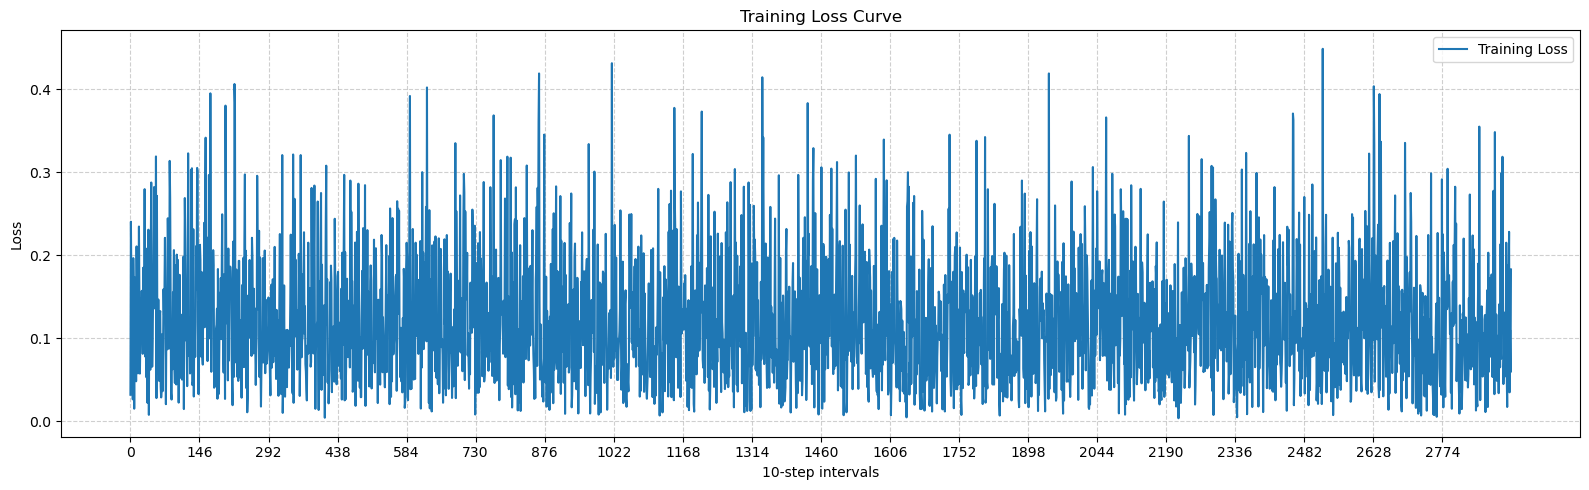

In [58]:
# Training Loss Curve
plt.figure(figsize=(16, 5))  # wider figure
plt.plot(train_losses, label="Training Loss")
plt.xlabel("10-step intervals")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.xticks(ticks=range(0, len(train_losses), max(1, len(train_losses)//20)))  # more x-ticks
plt.grid(True, linestyle='--', alpha=0.6)  # optional: grid for readability
plt.legend()
plt.tight_layout()
plt.show()


In [70]:
!pip install evaluate
from evaluate import load

In [ ]:
# === Load Models ===
pipe_base = StableDiffusionPipeline.from_pretrained(
    pretrained_model, torch_dtype=torch.float16
).to("cuda")

pipe_lora = StableDiffusionPipeline.from_pretrained(
    pretrained_model, torch_dtype=torch.float16
).to("cuda")
pipe_lora.unet.load_attn_procs(output_dir)

# === Load FID Metric ===
fid = load("fid")

# === Image Resize Transform to 299x299 for FID ===
resize = transforms.Compose([
    transforms.Resize((299, 299), interpolation=transforms.InterpolationMode.BILINEAR),
])

def preprocess_image(img_tensor):
    img = transforms.ToPILImage()(img_tensor)
    img = resize(img)
    return img

# === Generate and Collect Images ===
def generate_and_collect_images(pipe, tokenizer, test_dataloader):
    pipe.eval()
    real_images = []
    generated_images = []

    for batch in tqdm(test_dataloader, desc="Generating Images"):
        pixel_values = batch["pixel_values"]
        input_ids = batch["input_ids"]
        prompts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in input_ids]

        # === Generate images ===
        with torch.no_grad():
            images = pipe(prompts, num_inference_steps=50).images

        # === Resize real and generated images ===
        for i in range(len(images)):
            real_img = preprocess_image(pixel_values[i].cpu())
            gen_img = resize(images[i])
            real_images.append(real_img)
            generated_images.append(gen_img)

    return real_images, generated_images

# === Generate Images from Both Models ===
real_imgs, gen_imgs_base = generate_and_collect_images(pipe_base, tokenizer, test_dataloader)
_, gen_imgs_lora = generate_and_collect_images(pipe_lora, tokenizer, test_dataloader)

# === Compute FID ===
fid_score_base = fid.compute(real_images=real_imgs, generated_images=gen_imgs_base)["fid"]
fid_score_lora = fid.compute(real_images=real_imgs, generated_images=gen_imgs_lora)["fid"]

print(f"FID (Base Model): {fid_score_base:.4f}")
print(f"FID (LoRA Model): {fid_score_lora:.4f}")

In [19]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from diffusers import StableDiffusionPipeline
from transformers import CLIPTokenizer

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

D:\anaconda3\Lib\site-packages\diffusers\loaders\unet.py:212: FutureWarning: `load_attn_procs` is deprecated and will be removed in version 0.40.0. Using the `load_attn_procs()` method has been deprecated and will be removed in a future version. Please use `load_lora_adapter()`.
  deprecate("load_attn_procs", "0.40.0", deprecation_message)


  0%|          | 0/100 [00:00<?, ?it/s]

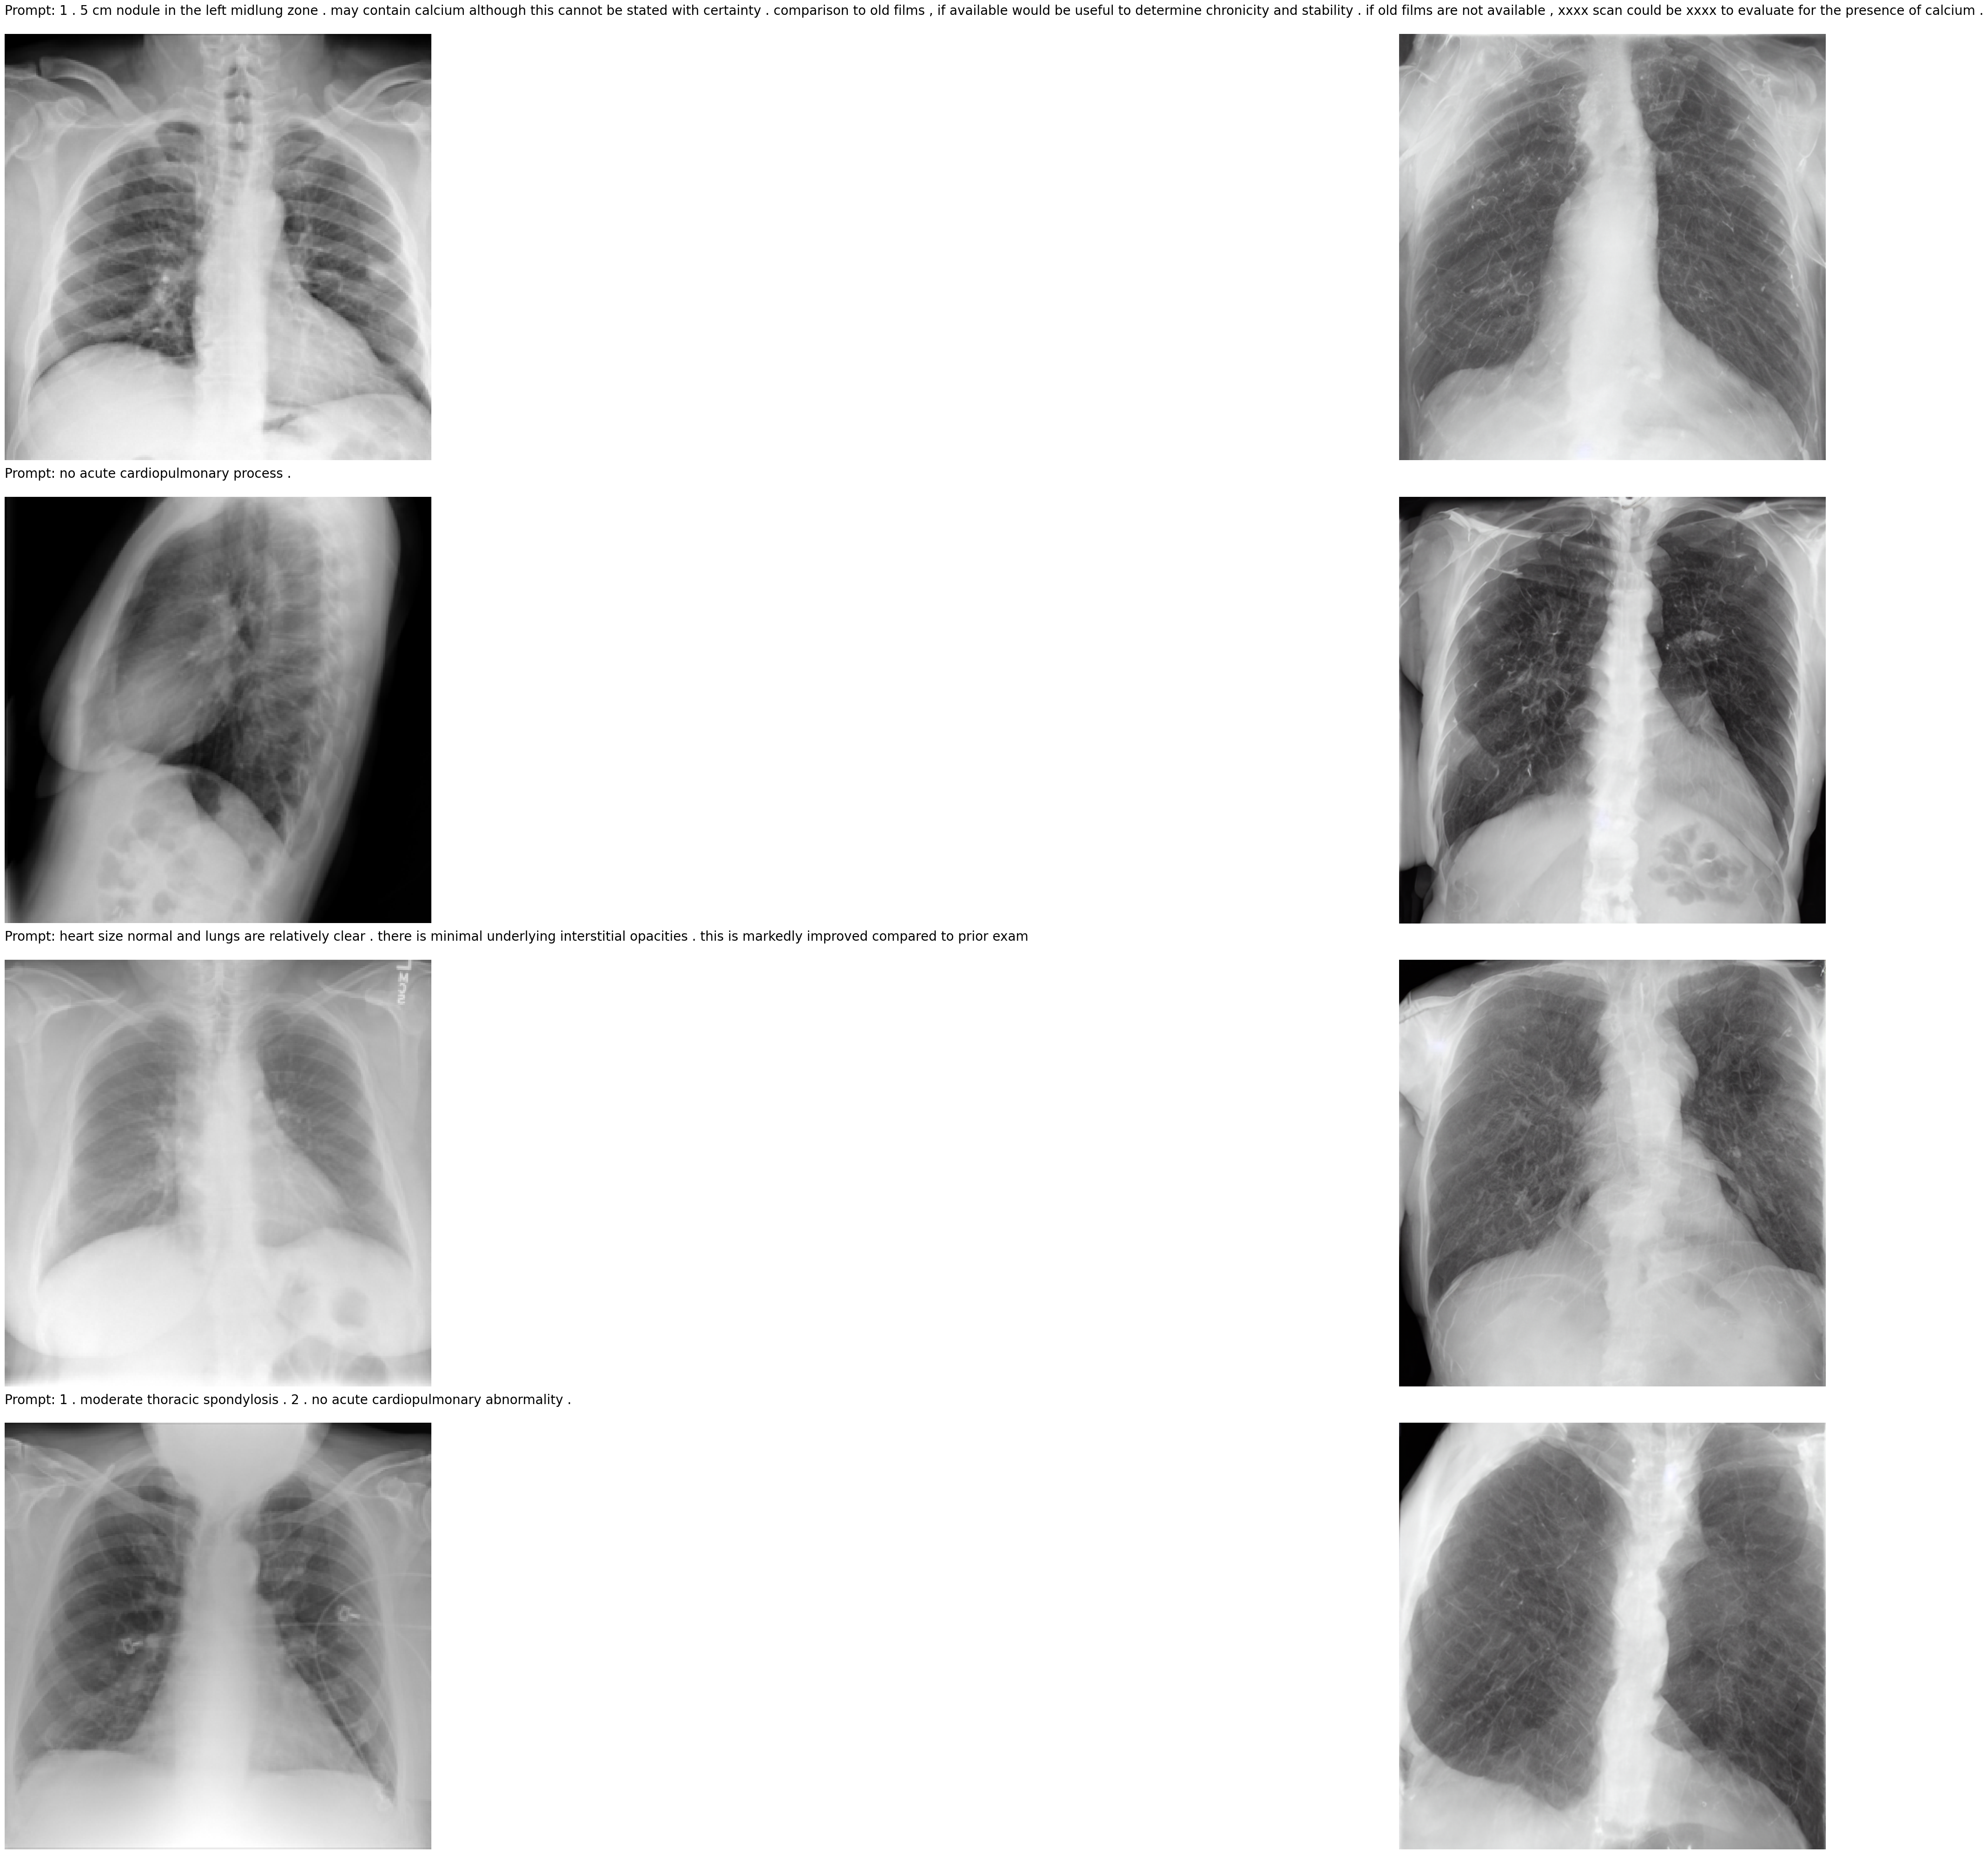

In [66]:
# === Load tokenizer and fine-tuned model ===
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
pipe = StableDiffusionPipeline.from_pretrained(
    pretrained_model,
    torch_dtype=torch.float16,
).to("cuda")
pipe.unet.load_attn_procs(output_dir)  # Load LoRA weights

pipe.unet.eval()
pipe.vae.eval()
pipe.text_encoder.eval()

# === Select a small batch from test set ===
batch = next(iter(test_dataloader))
pixel_values = batch["pixel_values"].to("cuda")
input_ids = batch["input_ids"].to("cuda")
prompts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in input_ids]

# === Generate images using the fine-tuned pipeline ===
with torch.no_grad():
    # decode prompt text again just to be sure
    prompts_text = [tokenizer.decode(ids, skip_special_tokens=True) for ids in input_ids]
    generated_images = pipe(prompts_text, num_inference_steps=100).images

# === Convert real images to PIL format ===
def tensor_to_pil(tensor):
    tensor = tensor.detach().cpu().clamp(-1, 1)
    tensor = (tensor + 1) / 2  # de-normalize to [0,1]
    np_img = tensor.permute(1, 2, 0).numpy()
    return Image.fromarray((np_img * 255).astype(np.uint8))

real_images = [tensor_to_pil(img) for img in pixel_values]

# === Display images side by side ===

n = min(4, len(real_images))  # show at most 4 pairs
plt.figure(figsize=(60, 40))

for i in range(n):
    # Add a full-width title for the prompt above each pair
    plt.subplot(n, 2, 2 * i + 1)
    plt.axis("off")
    plt.title(f"Prompt: {prompts[i]}", fontsize=20, loc='left', pad=30)
    plt.imshow(real_images[i])
    plt.ylabel("Real", fontsize=14)

    plt.subplot(n, 2, 2 * i + 2)
    plt.axis("off")
    plt.imshow(generated_images[i])
    plt.ylabel("Generated", fontsize=14)

plt.tight_layout()
plt.show()